In [23]:
#pip install pmdarima

# Time Series Model with ARIMA 

[10 year US Government Bond Yields (long-term interest rate)](https://datahub.io/core/bond-yields-us-10y#readme)
***

### Steps for ARIMA implementation

- **Load the data**: The first step for model building is of course to load the dataset
- **Preprocessing**: Depending on the dataset, the steps of preprocessing will be defined. This will include creating timestamps, converting the dtype of date/time column, making the series univariate, etc.
- **Make series stationary**: In order to satisfy the assumption, it is necessary to make the series stationary. This would include checking the stationarity of the series and performing required transformations
- **Determine d value**: For making the series stationary, the number of times the difference operation was performed will be taken as the d value
- **Create ACF and PACF plots**: This is the most important step in ARIMA implementation. ACF PACF plots are used to determine the input parameters for our ARIMA model
- **Determine the p and q values**: Read the values of p and q from the plots in the previous step
- **Fit ARIMA model**: Using the processed data and parameter values we calculated from the previous steps, fit the ARIMA model
- **Predict values on validation set**: Predict the future values
- **Calculate RMSE**: To check the performance of the model, check the RMSE value using the predictions and actual values on the validation set
***

# Load the Data

We will include Statsmodels into our workflow which we will use specifically for its powerful TSA models.

In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import ADFTest
from statsmodels.tsa.stattools import kpss

import scipy
from scipy.stats import pearsonr

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

#matplotlib.rcParams['figure.figsize'] = [8, 3]
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

#from matplotlib import rcParams
#from cycler import cycler

#rcParams['figure.figsize'] = 18, 5
#rcParams['axes.spines.top'] = True
#rcParams['axes.spines.right'] = True
#rcParams['axes.prop_cycle'] = cycler(color=['#365977'])
#rcParams['lines.linewidth'] = 2.5

print('Matplotlib:',matplotlib.__version__)
print('Pandas:',pd.__version__)
print('Numpy:',np.__version__)
print('StatsModel:',statsmodels.__version__)
print('Scipy:',scipy.__version__)

Matplotlib: 3.3.2
Pandas: 1.1.3
Numpy: 1.23.0
StatsModel: 0.12.2
Scipy: 1.5.2



# Preprocessing Data

Within reading in our dataframe we can include our datetime and index functions upon our univariate data. 


In [2]:
# Read in data
month = pd.read_excel('/Users/jasonrobinson/Documents/Projects/time_series_analysis/data/U.S. 10-yr-Bond.xls', parse_dates=['Date'], index_col='Date')
print(month.shape)
month.head()

(808, 1)


,Rate
Date,
1953-04-30,2.83
1953-05-31,3.05
1953-06-30,3.11
1953-07-31,2.93
1953-08-31,2.95



### Visualize our data

For the entire range we see an upward and downward non-stationary trend.

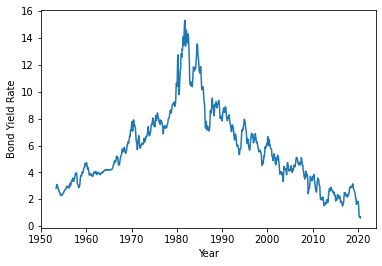

In [3]:
#month.plot(grid=True);
plt.xlabel('Year')
plt.ylabel('Bond Yield Rate')
plt.plot(month)
plt.plot(grid=True)
plt.show();

# Differencing

First order difference with _mean_ and _standard deviation_.

In [41]:
month_log = np.log(month["Rate"])
month_diff = month_log.diff().dropna()

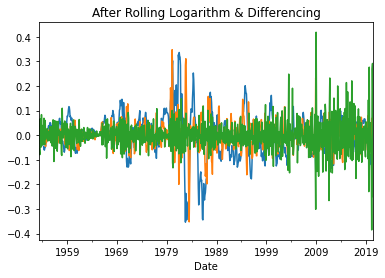

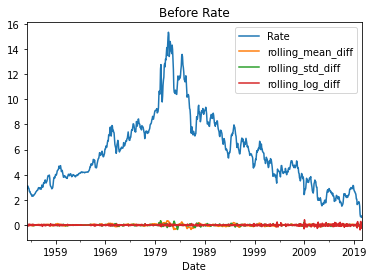

In [5]:
# Differentiate our data to acquire rolling mean
rolling_mean = month['Rate'].rolling(window = 12).mean().dropna()
rolling_std = month['Rate'].rolling(window = 12).std().dropna()

# Current value - past(previous) value
month['rolling_mean_diff'] = rolling_mean - rolling_mean.shift()
month['rolling_std_diff'] = rolling_std - rolling_std.shift()
month['rolling_log_diff'] = month_diff - month_diff.shift()

# Differentiated plots
ax1 = plt.subplot()
month['rolling_mean_diff'].plot(title='After Rolling Mean & Differencing');
month['rolling_std_diff'].plot(title='After Rolling Standard Deviation & Differencing');
month['rolling_log_diff'].plot(title='After Rolling Logarithm & Differencing') 

# Before plot
ax2 = plt.subplot()
month.plot(title='Before Rate');

In [6]:
# Remove remaining null values
month_diff = month['rolling_log_diff'].dropna()

In [33]:
month85 = month[381:]


### Seasonal decomposition

Seasonal decomposition

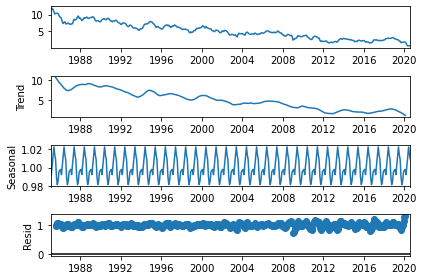

In [43]:
# Decompose trend, seasonality, residuals
decompose_data = seasonal_decompose(month_diff, model="additive")
decompose_data.plot();

In [56]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import DecomposeResult, seasonal_decompose

def plot_seasonal_decompose(result:DecomposeResult, dates:pd.Series=None, title:str="Seasonal Decomposition"):
    x_values = dates if dates is not None else np.arange(len(result.observed))
    return (
        make_subplots(
            rows=4,
            cols=1,
            subplot_titles=["Observed", "Trend", "Seasonal", "Residuals"],
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.observed, mode="lines", name='Observed'),
            row=1,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.trend, mode="lines", name='Trend'),
            row=2,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.seasonal, mode="lines", name='Seasonal'),
            row=3,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.resid, mode="lines", name='Residual'),
            row=4,
            col=1,
        )
        .update_layout(
            height=900, title=f'<b>{title}</b>', margin={'t':100}, title_x=0.5, showlegend=False
        )
    )

In [59]:
# Using plotly to demonstrate seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(month['Rate'], model='additive', period=12)
fig = plot_seasonal_decompose(decompose_data)
fig.show()

AttributeError: 'Series' object has no attribute 'month'

Standard deviation appears to be the least effective at differencing the time series, while log transformation is the right amount of differencing to make the data stationary.

In [9]:
#month['1990':'2000'].head()


### Test for Stationarity

Visually we see that our time series is stationary, but to confirm, let us check statistics through the _Augmented Dickey-Fuller Test_ (ADFTest) or the _Kwiatkowski-Phillips-Schmidt-Shin_ (KPSS) _test_, that can tell us if our p-value is greater than 95% to be considered for rejection or failure to reject. 

In [12]:
from pmdarima.arima import ADFTest
# Augmented Dickey-Fuller test

adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(month["Rate"])

(0.7319408103900956, True)


###  Make Series Stationary


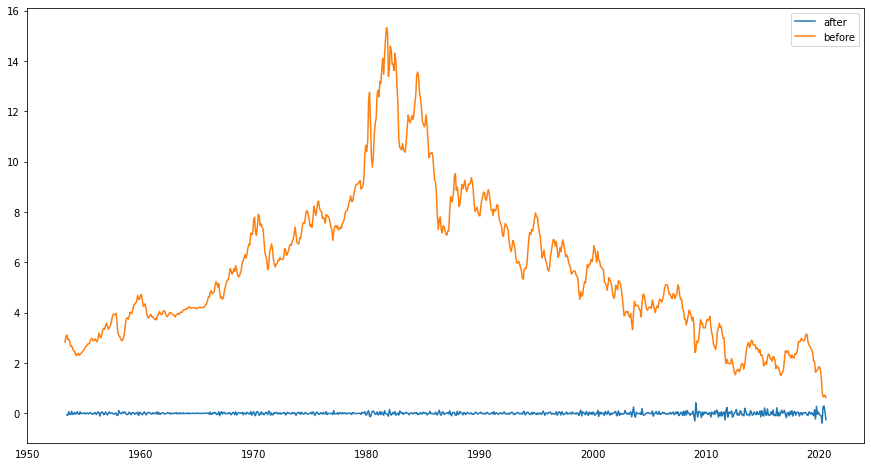

In [20]:
# Before and After confirmation
plt.figure(figsize=(15,8))
plt.plot(month_diff,label="after")
plt.plot(month['Rate'],label="before")
plt.tick_params(
    axis='x',        
    which='both',
    color='orange',
    bottom=False,      
    top=False,        
    labelbottom=True)
plt.legend()
plt.show()


### Confirm Stationarity

Here our time series should be in the form of stationary as our plot suggests as it appears to be stationary, but let's apply KPSS for confirmation.

The p-value is slightly under the threshold of significance, so given that the null hypothesis is non-stationary, we would fail to reject the null and accept the alternative that the series is stationary.

In [8]:
from statsmodels.tsa.stattools import kpss


def kpss_test(month):
    print("Results of KPSS Test:")
    kpsstest = kpss(month_diff, regression="ct", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)
    
    
    
kpss_test(month)

Results of KPSS Test:
Test Statistic           0.042518
p-value                  0.100000
Lags Used                4.000000
Critical Value (10%)     0.119000
Critical Value (5%)      0.146000
Critical Value (2.5%)    0.176000
Critical Value (1%)      0.216000
dtype: float64


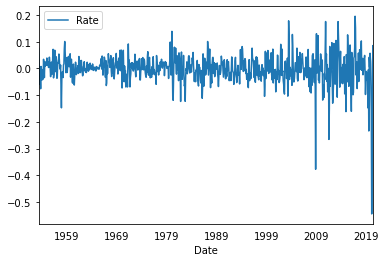

In [9]:
# Closer display of our differenced series
month_diff.plot()
plt.tick_params(
    axis='x',        
    which='both',
    color='orange',
    bottom=False,      
    top=False,        
    labelbottom=True)
plt.show();

# ARIMA Building

After confirming that our data is stationary, we can now build our ARIMA model to predict the bond rate for a period of 3-5 years. To help with determing the parameters for the model we will apply the _Auto Correlation Function_ (ACF) and the _Partial Auto Correlation Function_ (PACF). 


### ACF and PACF

We can use these two functions to allow us to see at which level of lag is most significant towards the current value.


In [ ]:
# Get this figure: fig = py.get_figure("https://plotly.com/~kennethhamgj/22/")
# Get this figure's data: data = py.get_figure("https://plotly.com/~kennethhamgj/22/").get_data()
# Add data to this figure: py.plot(Data([Scatter(x=[1, 2], y=[2, 3])]), filename ="Time Series Analysis", fileopt="extend")
# Get y data of first trace: y1 = py.get_figure("https://plotly.com/~kennethhamgj/22/").get_data()[0]["y"]

# Get figure documentation: https://plotly.com/python/get-requests/
# Add data documentation: https://plotly.com/python/file-options/

# If you're using unicode in your file, you may need to specify the encoding.
# You can reproduce this figure in Python with the following code!

# Learn about API authentication here: https://plotly.com/python/getting-started
# Find your api_key here: https://plotly.com/settings/api

import plotly.plotly as py
from plotly.graph_objs import *
py.sign_in('username', 'api_key')
trace1 = {
  "type": "scatter", 
  "x": ["2016-02-01 00:02:24", "2016-02-01 00:08:48", "2016-02-01 00:10:56", "2016-02-01 00:13:04", "2016-02-01 00:15:12", "2016-02-01 00:19:28", "2016-02-01 00:23:44", "2016-02-01 00:25:52", "2016-02-01 01:36:16", "2016-02-01 01:36:16", "2016-02-01 01:51:12", "2016-02-01 01:57:36", "2016-02-01 02:06:08", "2016-02-01 03:37:52", "2016-02-01 04:37:36", "2016-02-01 04:46:08", "2016-02-01 04:56:48", "2016-02-01 05:05:20", "2016-02-01 05:16:00", "2016-02-01 05:22:24", "2016-02-01 05:28:48", "2016-02-01 05:41:36", "2016-02-01 05:43:44", "2016-02-01 05:48:00", "2016-02-01 05:50:08", "2016-02-01 05:54:24", "2016-02-01 05:58:40", "2016-02-01 06:00:48", "2016-02-01 06:05:04", "2016-02-01 06:07:12", "2016-02-01 06:09:20", "2016-02-01 06:15:44", "2016-02-01 06:20:00", "2016-02-01 06:20:00", "2016-02-01 06:26:24", "2016-02-01 06:26:24", "2016-02-01 06:28:32", "2016-02-01 06:32:48", "2016-02-01 06:34:56", "2016-02-01 06:37:04", "2016-02-01 06:39:12", "2016-02-01 06:41:20", "2016-02-01 06:43:28", "2016-02-01 06:43:28", "2016-02-01 06:45:36", "2016-02-01 06:47:44", "2016-02-01 06:47:44", "2016-02-01 06:52:00", "2016-02-01 06:52:00", "2016-02-01 06:54:08", "2016-02-01 06:56:16", "2016-02-01 06:58:24", "2016-02-01 07:00:32", "2016-02-01 07:02:40", "2016-02-01 07:04:48", "2016-02-01 07:04:48", "2016-02-01 07:06:56", "2016-02-01 07:06:56", "2016-02-01 07:09:04", "2016-02-01 07:11:12", "2016-02-01 07:13:20", "2016-02-01 07:15:28", "2016-02-01 07:15:28", "2016-02-01 07:17:36", "2016-02-01 07:17:36", "2016-02-01 07:19:44", "2016-02-01 07:19:44", "2016-02-01 07:21:52", "2016-02-01 07:24:00", "2016-02-01 07:26:08", "2016-02-01 07:26:08", "2016-02-01 07:28:16", "2016-02-01 07:30:24", "2016-02-01 07:30:24", "2016-02-01 07:32:32", "2016-02-01 07:32:32", "2016-02-01 07:32:32", "2016-02-01 07:36:48", "2016-02-01 07:36:48", "2016-02-01 07:38:56", "2016-02-01 07:41:04", "2016-02-01 07:41:04", "2016-02-01 07:43:12", "2016-02-01 07:43:12", "2016-02-01 07:43:12", "2016-02-01 07:47:28", "2016-02-01 07:47:28", "2016-02-01 07:49:36", "2016-02-01 07:49:36", "2016-02-01 07:51:44", "2016-02-01 07:51:44", "2016-02-01 07:53:52", "2016-02-01 07:56:00", "2016-02-01 07:58:08", "2016-02-01 07:58:08", "2016-02-01 07:58:08", "2016-02-01 08:00:16", "2016-02-01 08:02:24", "2016-02-01 08:04:32", "2016-02-01 08:04:32", "2016-02-01 08:06:40", "2016-02-01 08:06:40", "2016-02-01 08:08:48", "2016-02-01 08:10:56", "2016-02-01 08:13:04", "2016-02-01 08:13:04", "2016-02-01 08:13:04", "2016-02-01 08:15:12", "2016-02-01 08:17:20", "2016-02-01 08:17:20", "2016-02-01 08:19:28", "2016-02-01 08:21:36", "2016-02-01 08:23:44", "2016-02-01 08:23:44", "2016-02-01 08:25:52", "2016-02-01 08:25:52", "2016-02-01 08:28:00", "2016-02-01 08:30:08", "2016-02-01 08:30:08", "2016-02-01 08:32:16", "2016-02-01 08:32:16", "2016-02-01 08:36:32", "2016-02-01 08:36:32", "2016-02-01 08:36:32", "2016-02-01 08:38:40", "2016-02-01 08:40:48", "2016-02-01 08:42:56", "2016-02-01 08:47:12", "2016-02-01 08:51:28", "2016-02-01 08:51:28", "2016-02-01 08:53:36", "2016-02-01 08:53:36", "2016-02-01 08:55:44", "2016-02-01 08:55:44", "2016-02-01 08:57:52", "2016-02-01 08:57:52", "2016-02-01 09:00:00", "2016-02-01 09:00:00", "2016-02-01 09:02:08", "2016-02-01 09:02:08", "2016-02-01 09:04:16", "2016-02-01 09:08:32", "2016-02-01 09:10:40", "2016-02-01 09:10:40", "2016-02-01 09:12:48", "2016-02-01 09:14:56", "2016-02-01 09:17:04", "2016-02-01 09:21:20", "2016-02-01 09:21:20", "2016-02-01 09:23:28", "2016-02-01 09:25:36", "2016-02-01 09:27:44", "2016-02-01 09:27:44", "2016-02-01 09:29:52", "2016-02-01 09:29:52", "2016-02-01 09:32:00", "2016-02-01 09:32:00", "2016-02-01 09:34:08", "2016-02-01 09:34:08", "2016-02-01 09:36:16", "2016-02-01 09:36:16", "2016-02-01 09:38:24", "2016-02-01 09:38:24", "2016-02-01 09:40:32", "2016-02-01 09:42:40", "2016-02-01 09:42:40", "2016-02-01 09:42:40", "2016-02-01 09:44:48", "2016-02-01 09:44:48", "2016-02-01 09:46:56", "2016-02-01 09:46:56", "2016-02-01 09:49:04", "2016-02-01 09:49:04", "2016-02-01 09:51:12", "2016-02-01 09:51:12", "2016-02-01 09:55:28", "2016-02-01 09:55:28", "2016-02-01 09:57:36", "2016-02-01 09:59:44", "2016-02-01 09:59:44", "2016-02-01 10:01:52", "2016-02-01 10:04:00", "2016-02-01 10:06:08", "2016-02-01 10:08:16", "2016-02-01 10:10:24", "2016-02-01 10:12:32", "2016-02-01 10:14:40", "2016-02-01 10:14:40", "2016-02-01 10:18:56", "2016-02-01 10:18:56", "2016-02-01 10:21:04", "2016-02-01 10:21:04", "2016-02-01 10:23:12", "2016-02-01 10:25:20", "2016-02-01 10:25:20", "2016-02-01 10:29:36", "2016-02-01 10:31:44", "2016-02-01 10:31:44", "2016-02-01 10:33:52", "2016-02-01 10:38:08", "2016-02-01 10:38:08", "2016-02-01 10:40:16", "2016-02-01 10:40:16", "2016-02-01 10:42:24", "2016-02-01 10:44:32", "2016-02-01 10:44:32", "2016-02-01 10:46:40", "2016-02-01 10:48:48", "2016-02-01 10:48:48", "2016-02-01 10:50:56", "2016-02-01 10:55:12", "2016-02-01 10:57:20", "2016-02-01 10:57:20", "2016-02-01 10:59:28", "2016-02-01 11:03:44", "2016-02-01 11:03:44", "2016-02-01 11:05:52", "2016-02-01 11:10:08", "2016-02-01 11:10:08", "2016-02-01 11:12:16", "2016-02-01 11:16:32", "2016-02-01 11:18:40", "2016-02-01 11:18:40", "2016-02-01 11:22:56", "2016-02-01 11:25:04", "2016-02-01 11:27:12", "2016-02-01 11:29:20", "2016-02-01 11:31:28", "2016-02-01 11:33:36", "2016-02-01 11:33:36", "2016-02-01 11:35:44", "2016-02-01 11:37:52", "2016-02-01 11:42:08", "2016-02-01 11:42:08", "2016-02-01 11:44:16", "2016-02-01 11:46:24", "2016-02-01 11:50:40", "2016-02-01 11:50:40", "2016-02-01 11:54:56", "2016-02-01 11:54:56", "2016-02-01 11:57:04", "2016-02-01 11:59:12", "2016-02-01 12:01:20", "2016-02-01 12:03:28", "2016-02-01 12:05:36", "2016-02-01 12:07:44", "2016-02-01 12:09:52", "2016-02-01 12:12:00", "2016-02-01 12:16:16", "2016-02-01 12:16:16", "2016-02-01 12:18:24", "2016-02-01 12:20:32", "2016-02-01 12:22:40", "2016-02-01 12:24:48", "2016-02-01 12:26:56", "2016-02-01 12:29:04", "2016-02-01 12:31:12", "2016-02-01 12:31:12", "2016-02-01 12:35:28", "2016-02-01 12:37:36", "2016-02-01 12:39:44", "2016-02-01 12:41:52", "2016-02-01 12:44:00", "2016-02-01 12:44:00", "2016-02-01 12:48:16", "2016-02-01 12:48:16", "2016-02-01 12:52:32", "2016-02-01 12:54:40", "2016-02-01 12:56:48", "2016-02-01 12:58:56", "2016-02-01 13:01:04", "2016-02-01 13:01:04", "2016-02-01 13:05:20", "2016-02-01 13:05:20", "2016-02-01 13:09:36", "2016-02-01 13:09:36", "2016-02-01 13:13:52", "2016-02-01 13:13:52", "2016-02-01 13:18:08", "2016-02-01 13:18:08", "2016-02-01 13:22:24", "2016-02-01 13:22:24", "2016-02-01 13:26:40", "2016-02-01 13:26:40", "2016-02-01 13:30:56", "2016-02-01 13:30:56", "2016-02-01 13:35:12", "2016-02-01 13:35:12", "2016-02-01 13:37:20", "2016-02-01 13:39:28", "2016-02-01 13:41:36", "2016-02-01 13:43:44", "2016-02-01 13:45:52", "2016-02-01 13:48:00", "2016-02-01 13:50:08", "2016-02-01 13:52:16", "2016-02-01 13:54:24", "2016-02-01 13:56:32", "2016-02-01 13:58:40", "2016-02-01 14:00:48", "2016-02-01 14:02:56", "2016-02-01 14:05:04", "2016-02-01 14:07:12", "2016-02-01 14:09:20", "2016-02-01 14:11:28", "2016-02-01 14:13:36", "2016-02-01 14:15:44", "2016-02-01 14:15:44", "2016-02-01 14:20:00", "2016-02-01 14:22:08", "2016-02-01 14:24:16", "2016-02-01 14:24:16", "2016-02-01 14:28:32", "2016-02-01 14:30:40", "2016-02-01 14:32:48", "2016-02-01 14:32:48", "2016-02-01 14:37:04", "2016-02-01 14:39:12", "2016-02-01 14:41:20", "2016-02-01 14:41:20", "2016-02-01 14:45:36", "2016-02-01 14:45:36", "2016-02-01 14:47:44", "2016-02-01 14:49:52", "2016-02-01 14:54:08", "2016-02-01 14:56:16", "2016-02-01 14:58:24", "2016-02-01 14:58:24", "2016-02-01 15:02:40", "2016-02-01 15:02:40", "2016-02-01 15:04:48", "2016-02-01 15:06:56", "2016-02-01 15:11:12", "2016-02-01 15:11:12", "2016-02-01 15:13:20", "2016-02-01 15:15:28", "2016-02-01 15:19:44", "2016-02-01 15:19:44", "2016-02-01 15:21:52", "2016-02-01 15:24:00", "2016-02-01 15:26:08", "2016-02-01 15:28:16", "2016-02-01 15:30:24", "2016-02-01 15:32:32", "2016-02-01 15:36:48", "2016-02-01 15:36:48", "2016-02-01 15:38:56", "2016-02-01 15:41:04", "2016-02-01 15:43:12", "2016-02-01 15:45:20", "2016-02-01 15:47:28", "2016-02-01 15:49:36", "2016-02-01 15:51:44", "2016-02-01 15:53:52", "2016-02-01 15:53:52", "2016-02-01 15:58:08", "2016-02-01 15:58:08", "2016-02-01 16:00:16", "2016-02-01 16:02:24", "2016-02-01 16:02:24", "2016-02-01 16:06:40", "2016-02-01 16:06:40", "2016-02-01 16:08:48", "2016-02-01 16:08:48", "2016-02-01 16:10:56", "2016-02-01 16:13:04", "2016-02-01 16:15:12", "2016-02-01 16:15:12", "2016-02-01 16:17:20", "2016-02-01 16:19:28", "2016-02-01 16:21:36", "2016-02-01 16:21:36", "2016-02-01 16:23:44", "2016-02-01 16:25:52", "2016-02-01 16:28:00", "2016-02-01 16:28:00", "2016-02-01 16:30:08", "2016-02-01 16:30:08", "2016-02-01 16:34:24", "2016-02-01 16:34:24", "2016-02-01 16:36:32", "2016-02-01 16:38:40", "2016-02-01 16:40:48", "2016-02-01 16:40:48", "2016-02-01 16:45:04", "2016-02-01 16:45:04", "2016-02-01 16:47:12", "2016-02-01 16:47:12", "2016-02-01 16:51:28", "2016-02-01 16:51:28", "2016-02-01 16:55:44", "2016-02-01 16:55:44", "2016-02-01 16:57:52", "2016-02-01 16:57:52", "2016-02-01 17:00:00", "2016-02-01 17:02:08", "2016-02-01 17:04:16", "2016-02-01 17:04:16", "2016-02-01 17:08:32", "2016-02-01 17:08:32", "2016-02-01 17:10:40", "2016-02-01 17:10:40", "2016-02-01 17:14:56", "2016-02-01 17:14:56", "2016-02-01 17:17:04", "2016-02-01 17:19:12", "2016-02-01 17:19:12", "2016-02-01 17:21:20", "2016-02-01 17:23:28", "2016-02-01 17:23:28", "2016-02-01 17:25:36", "2016-02-01 17:27:44", "2016-02-01 17:29:52", "2016-02-01 17:29:52", "2016-02-01 17:32:00", "2016-02-01 17:34:08", "2016-02-01 17:36:16", "2016-02-01 17:36:16", "2016-02-01 17:40:32", "2016-02-01 17:40:32", "2016-02-01 17:44:48", "2016-02-01 17:46:56", "2016-02-01 17:46:56", "2016-02-01 17:49:04", "2016-02-01 17:49:04", "2016-02-01 17:51:12", "2016-02-01 17:53:20", "2016-02-01 17:53:20", "2016-02-01 17:55:28", "2016-02-01 17:57:36", "2016-02-01 17:59:44", "2016-02-01 17:59:44", "2016-02-01 18:01:52", "2016-02-01 18:04:00", "2016-02-01 18:06:08", "2016-02-01 18:06:08", "2016-02-01 18:10:24", "2016-02-01 18:10:24", "2016-02-01 18:12:32", "2016-02-01 18:12:32", "2016-02-01 18:14:40", "2016-02-01 18:16:48", "2016-02-01 18:18:56", "2016-02-01 18:18:56", "2016-02-01 18:21:04", "2016-02-01 18:23:12", "2016-02-01 18:25:20", "2016-02-01 18:25:20", "2016-02-01 18:29:36", "2016-02-01 18:29:36", "2016-02-01 18:31:44", "2016-02-01 18:31:44", "2016-02-01 18:36:00", "2016-02-01 18:36:00", "2016-02-01 18:40:16", "2016-02-01 18:40:16", "2016-02-01 18:44:32", "2016-02-01 18:44:32", "2016-02-01 18:46:40", "2016-02-01 18:46:40", "2016-02-01 18:48:48", "2016-02-01 18:50:56", "2016-02-01 18:53:04", "2016-02-01 18:53:04", "2016-02-01 18:55:12", "2016-02-01 18:55:12", "2016-02-01 18:57:20", "2016-02-01 18:57:20", "2016-02-01 19:01:36", "2016-02-01 19:03:44", "2016-02-01 19:03:44", "2016-02-01 19:05:52", "2016-02-01 19:08:00", "2016-02-01 19:08:00", "2016-02-01 19:10:08", "2016-02-01 19:10:08", "2016-02-01 19:14:24", "2016-02-01 19:14:24", "2016-02-01 19:16:32", "2016-02-01 19:18:40", "2016-02-01 19:20:48", "2016-02-01 19:22:56", "2016-02-01 19:22:56", "2016-02-01 19:25:04", "2016-02-01 19:27:12", "2016-02-01 19:27:12", "2016-02-01 19:29:20", "2016-02-01 19:29:20", "2016-02-01 19:33:36", "2016-02-01 19:33:36", "2016-02-01 19:37:52", "2016-02-01 19:37:52", "2016-02-01 19:40:00", "2016-02-01 19:40:00", "2016-02-01 19:42:08", "2016-02-01 19:42:08", "2016-02-01 19:46:24", "2016-02-01 19:48:32", "2016-02-01 19:48:32", "2016-02-01 19:50:40", "2016-02-01 19:52:48", "2016-02-01 19:54:56", "2016-02-01 19:54:56", "2016-02-01 19:57:04", "2016-02-01 19:59:12", "2016-02-01 19:59:12", "2016-02-01 20:01:20", "2016-02-01 20:03:28", "2016-02-01 20:05:36", "2016-02-01 20:05:36", "2016-02-01 20:07:44", "2016-02-01 20:09:52", "2016-02-01 20:12:00", "2016-02-01 20:14:08", "2016-02-01 20:16:16", "2016-02-01 20:16:16", "2016-02-01 20:18:24", "2016-02-01 20:20:32", "2016-02-01 20:20:32", "2016-02-01 20:22:40", "2016-02-01 20:24:48", "2016-02-01 20:24:48", "2016-02-01 20:29:04", "2016-02-01 20:29:04", "2016-02-01 20:31:12", "2016-02-01 20:31:12", "2016-02-01 20:35:28", "2016-02-01 20:35:28", "2016-02-01 20:37:36", "2016-02-01 20:37:36", "2016-02-01 20:41:52", "2016-02-01 20:41:52", "2016-02-01 20:44:00", "2016-02-01 20:44:00", "2016-02-01 20:48:16", "2016-02-01 20:48:16", "2016-02-01 20:50:24", "2016-02-01 20:50:24", "2016-02-01 20:54:40", "2016-02-01 20:54:40", "2016-02-01 20:56:48", "2016-02-01 20:58:56", "2016-02-01 21:01:04", "2016-02-01 21:01:04", "2016-02-01 21:03:12", "2016-02-01 21:03:12", "2016-02-01 21:07:28", "2016-02-01 21:07:28", "2016-02-01 21:09:36", "2016-02-01 21:11:44", "2016-02-01 21:13:52", "2016-02-01 21:16:00", "2016-02-01 21:16:00", "2016-02-01 21:20:16", "2016-02-01 21:20:16", "2016-02-01 21:22:24", "2016-02-01 21:24:32", "2016-02-01 21:26:40", "2016-02-01 21:26:40", "2016-02-01 21:30:56", "2016-02-01 21:30:56", "2016-02-01 21:33:04", "2016-02-01 21:33:04", "2016-02-01 21:35:12", "2016-02-01 21:35:12", "2016-02-01 21:39:28", "2016-02-01 21:39:28", "2016-02-01 21:41:36", "2016-02-01 21:43:44", "2016-02-01 21:45:52", "2016-02-01 21:48:00", "2016-02-01 21:50:08", "2016-02-01 21:52:16", "2016-02-01 21:54:24", "2016-02-01 21:56:32", "2016-02-01 21:58:40", "2016-02-01 21:58:40", "2016-02-01 22:02:56", "2016-02-01 22:02:56", "2016-02-01 22:05:04", "2016-02-01 22:07:12", "2016-02-01 22:09:20", "2016-02-01 22:09:20", "2016-02-01 22:11:28", "2016-02-01 22:15:44", "2016-02-01 22:15:44", "2016-02-01 22:17:52", "2016-02-01 22:20:00", "2016-02-01 22:22:08", "2016-02-01 22:24:16", "2016-02-01 22:24:16", "2016-02-01 22:28:32", "2016-02-01 22:28:32", "2016-02-01 22:30:40", "2016-02-01 22:32:48", "2016-02-01 22:34:56", "2016-02-01 22:37:04", "2016-02-01 22:39:12", "2016-02-01 22:41:20", "2016-02-01 22:43:28", "2016-02-01 22:45:36", "2016-02-01 22:47:44", "2016-02-01 22:49:52", "2016-02-01 22:52:00", "2016-02-01 22:52:00", "2016-02-01 22:54:08", "2016-02-01 22:56:16", "2016-02-01 23:00:32", "2016-02-01 23:02:40", "2016-02-01 23:04:48", "2016-02-01 23:06:56", "2016-02-01 23:11:12", "2016-02-01 23:11:12", "2016-02-01 23:13:20", "2016-02-01 23:15:28", "2016-02-01 23:17:36", "2016-02-01 23:19:44", "2016-02-01 23:19:44", "2016-02-01 23:26:08", "2016-02-01 23:26:08", "2016-02-01 23:30:24", "2016-02-01 23:30:24", "2016-02-01 23:36:48", "2016-02-01 23:36:48", "2016-02-01 23:41:04", "2016-02-01 23:41:04", "2016-02-01 23:45:20", "2016-02-01 23:45:20", "2016-02-01 23:49:36", "2016-02-01 23:51:44", "2016-02-01 23:53:52", "2016-02-01 23:56:00", "2016-02-01 23:58:08", "2016-02-02 00:00:16", "2016-02-02 00:02:24", "2016-02-02 00:06:40", "2016-02-02 00:08:48", "2016-02-02 00:10:56", "2016-02-02 00:13:04", "2016-02-02 00:15:12", "2016-02-02 00:17:20", "2016-02-02 00:19:28", "2016-02-02 00:23:44", "2016-02-02 00:25:52", "2016-02-02 01:29:52", "2016-02-02 01:36:16", "2016-02-02 01:40:32", "2016-02-02 01:53:20", "2016-02-02 01:55:28", "2016-02-02 02:06:08", "2016-02-02 04:39:44", "2016-02-02 04:46:08", "2016-02-02 04:56:48", "2016-02-02 05:05:20", "2016-02-02 05:16:00", "2016-02-02 05:22:24", "2016-02-02 05:28:48", "2016-02-02 05:39:28", "2016-02-02 05:41:36", "2016-02-02 05:48:00", "2016-02-02 05:50:08", "2016-02-02 05:54:24", "2016-02-02 05:58:40", "2016-02-02 06:00:48", "2016-02-02 06:05:04", "2016-02-02 06:07:12", "2016-02-02 06:09:20", "2016-02-02 06:15:44", "2016-02-02 06:17:52", "2016-02-02 06:20:00", "2016-02-02 06:26:24", "2016-02-02 06:26:24", "2016-02-02 06:28:32", "2016-02-02 06:30:40", "2016-02-02 06:34:56", "2016-02-02 06:37:04", "2016-02-02 06:39:12", "2016-02-02 06:41:20", "2016-02-02 06:43:28", "2016-02-02 06:43:28", "2016-02-02 06:47:44", "2016-02-02 06:47:44", "2016-02-02 06:49:52", "2016-02-02 06:52:00", "2016-02-02 06:54:08", "2016-02-02 06:54:08", "2016-02-02 06:56:16", "2016-02-02 06:58:24", "2016-02-02 07:00:32", "2016-02-02 07:02:40", "2016-02-02 07:04:48", "2016-02-02 07:04:48", "2016-02-02 07:06:56", "2016-02-02 07:06:56", "2016-02-02 07:11:12", "2016-02-02 07:11:12", "2016-02-02 07:13:20", "2016-02-02 07:13:20", "2016-02-02 07:15:28", "2016-02-02 07:17:36", "2016-02-02 07:17:36", "2016-02-02 07:19:44", "2016-02-02 07:19:44", "2016-02-02 07:21:52", "2016-02-02 07:24:00", "2016-02-02 07:26:08", "2016-02-02 07:26:08", "2016-02-02 07:28:16", "2016-02-02 07:28:16", "2016-02-02 07:30:24", "2016-02-02 07:30:24", "2016-02-02 07:32:32", "2016-02-02 07:34:40", "2016-02-02 07:36:48", "2016-02-02 07:36:48", "2016-02-02 07:38:56", "2016-02-02 07:38:56", "2016-02-02 07:41:04", "2016-02-02 07:41:04", "2016-02-02 07:43:12", "2016-02-02 07:45:20", "2016-02-02 07:47:28", "2016-02-02 07:47:28", "2016-02-02 07:49:36", "2016-02-02 07:49:36", "2016-02-02 07:51:44", "2016-02-02 07:51:44", "2016-02-02 07:53:52", "2016-02-02 07:56:00", "2016-02-02 07:56:00", "2016-02-02 07:58:08", "2016-02-02 07:58:08", "2016-02-02 08:00:16", "2016-02-02 08:02:24", "2016-02-02 08:04:32", "2016-02-02 08:04:32", "2016-02-02 08:06:40", "2016-02-02 08:08:48", "2016-02-02 08:10:56", "2016-02-02 08:10:56", "2016-02-02 08:13:04", "2016-02-02 08:15:12", "2016-02-02 08:15:12", "2016-02-02 08:15:12", "2016-02-02 08:17:20", "2016-02-02 08:19:28", "2016-02-02 08:19:28", "2016-02-02 08:21:36", "2016-02-02 08:23:44", "2016-02-02 08:23:44", "2016-02-02 08:25:52", "2016-02-02 08:28:00", "2016-02-02 08:28:00", "2016-02-02 08:30:08", "2016-02-02 08:30:08", "2016-02-02 08:32:16", "2016-02-02 08:36:32", "2016-02-02 08:36:32", "2016-02-02 08:38:40", "2016-02-02 08:38:40", "2016-02-02 08:40:48", "2016-02-02 08:40:48", "2016-02-02 08:42:56", "2016-02-02 08:42:56", "2016-02-02 08:45:04", "2016-02-02 08:45:04", "2016-02-02 08:47:12", "2016-02-02 08:47:12", "2016-02-02 08:49:20", "2016-02-02 08:49:20", "2016-02-02 08:51:28", "2016-02-02 08:53:36", "2016-02-02 08:53:36", "2016-02-02 08:55:44", "2016-02-02 08:57:52", "2016-02-02 08:57:52", "2016-02-02 09:00:00", "2016-02-02 09:02:08", "2016-02-02 09:02:08", "2016-02-02 09:04:16", "2016-02-02 09:04:16", "2016-02-02 09:08:32", "2016-02-02 09:08:32", "2016-02-02 09:10:40", "2016-02-02 09:12:48", "2016-02-02 09:12:48", "2016-02-02 09:14:56", "2016-02-02 09:14:56", "2016-02-02 09:17:04", "2016-02-02 09:19:12", "2016-02-02 09:19:12", "2016-02-02 09:19:12", "2016-02-02 09:21:20", "2016-02-02 09:23:28", "2016-02-02 09:23:28", "2016-02-02 09:25:36", "2016-02-02 09:25:36", "2016-02-02 09:29:52", "2016-02-02 09:29:52", "2016-02-02 09:32:00", "2016-02-02 09:34:08", "2016-02-02 09:34:08", "2016-02-02 09:36:16", "2016-02-02 09:38:24", "2016-02-02 09:38:24", "2016-02-02 09:40:32", "2016-02-02 09:40:32", "2016-02-02 09:44:48", "2016-02-02 09:44:48", "2016-02-02 09:46:56", "2016-02-02 09:49:04", "2016-02-02 09:49:04", "2016-02-02 09:51:12", "2016-02-02 09:51:12", "2016-02-02 09:55:28", "2016-02-02 09:57:36", "2016-02-02 09:57:36", "2016-02-02 09:59:44", "2016-02-02 09:59:44", "2016-02-02 10:04:00", "2016-02-02 10:06:08", "2016-02-02 10:06:08", "2016-02-02 10:08:16", "2016-02-02 10:08:16", "2016-02-02 10:10:24", "2016-02-02 10:12:32", "2016-02-02 10:14:40", "2016-02-02 10:16:48", "2016-02-02 10:16:48", "2016-02-02 10:18:56", "2016-02-02 10:21:04", "2016-02-02 10:23:12", "2016-02-02 10:25:20", "2016-02-02 10:27:28", "2016-02-02 10:29:36", "2016-02-02 10:33:52", "2016-02-02 10:33:52", "2016-02-02 10:36:00", "2016-02-02 10:36:00", "2016-02-02 10:38:08", "2016-02-02 10:42:24", "2016-02-02 10:42:24", "2016-02-02 10:46:40", "2016-02-02 10:46:40", "2016-02-02 10:48:48", "2016-02-02 10:50:56", "2016-02-02 10:53:04", "2016-02-02 10:55:12", "2016-02-02 10:55:12", "2016-02-02 10:59:28", "2016-02-02 10:59:28", "2016-02-02 11:03:44", "2016-02-02 11:03:44", "2016-02-02 11:08:00", "2016-02-02 11:10:08", "2016-02-02 11:12:16", "2016-02-02 11:12:16", "2016-02-02 11:16:32", "2016-02-02 11:16:32", "2016-02-02 11:20:48", "2016-02-02 11:20:48", "2016-02-02 11:25:04", "2016-02-02 11:25:04", "2016-02-02 11:29:20", "2016-02-02 11:29:20", "2016-02-02 11:33:36", "2016-02-02 11:33:36", "2016-02-02 11:37:52", "2016-02-02 11:37:52", "2016-02-02 11:42:08", "2016-02-02 11:42:08", "2016-02-02 11:46:24", "2016-02-02 11:50:40", "2016-02-02 11:52:48", "2016-02-02 11:54:56", "2016-02-02 11:54:56", "2016-02-02 11:59:12", "2016-02-02 11:59:12", "2016-02-02 12:03:28", "2016-02-02 12:05:36", "2016-02-02 12:05:36", "2016-02-02 12:07:44", "2016-02-02 12:12:00", "2016-02-02 12:12:00", "2016-02-02 12:16:16", "2016-02-02 12:16:16", "2016-02-02 12:20:32", "2016-02-02 12:20:32", "2016-02-02 12:26:56", "2016-02-02 12:26:56", "2016-02-02 12:29:04", "2016-02-02 12:31:12", "2016-02-02 12:31:12", "2016-02-02 12:35:28", "2016-02-02 12:35:28", "2016-02-02 12:37:36", "2016-02-02 12:39:44", "2016-02-02 12:39:44", "2016-02-02 12:44:00", "2016-02-02 12:46:08", "2016-02-02 12:50:24", "2016-02-02 12:54:40", "2016-02-02 12:54:40", "2016-02-02 13:03:12", "2016-02-02 13:03:12", "2016-02-02 13:05:20", "2016-02-02 13:05:20", "2016-02-02 13:07:28", "2016-02-02 13:09:36", "2016-02-02 13:11:44", "2016-02-02 13:13:52", "2016-02-02 13:18:08", "2016-02-02 13:20:16", "2016-02-02 13:22:24", "2016-02-02 13:24:32", "2016-02-02 13:26:40", "2016-02-02 13:28:48", "2016-02-02 13:30:56", "2016-02-02 13:33:04", "2016-02-02 13:35:12", "2016-02-02 13:35:12", "2016-02-02 13:37:20", "2016-02-02 13:39:28", "2016-02-02 13:39:28", "2016-02-02 13:43:44", "2016-02-02 13:45:52", "2016-02-02 13:50:08", "2016-02-02 13:50:08", "2016-02-02 13:54:24", "2016-02-02 13:56:32", "2016-02-02 13:58:40", "2016-02-02 14:00:48", "2016-02-02 14:02:56", "2016-02-02 14:05:04", "2016-02-02 14:07:12", "2016-02-02 14:07:12", "2016-02-02 14:09:20", "2016-02-02 14:11:28", "2016-02-02 14:13:36", "2016-02-02 14:13:36", "2016-02-02 14:17:52", "2016-02-02 14:17:52", "2016-02-02 14:24:16", "2016-02-02 14:24:16", "2016-02-02 14:24:16", "2016-02-02 14:26:24", "2016-02-02 14:28:32", "2016-02-02 14:30:40", "2016-02-02 14:32:48", "2016-02-02 14:32:48", "2016-02-02 14:37:04", "2016-02-02 14:37:04", "2016-02-02 14:43:28", "2016-02-02 14:43:28", "2016-02-02 14:47:44", "2016-02-02 14:49:52", "2016-02-02 14:52:00", "2016-02-02 14:52:00", "2016-02-02 14:56:16", "2016-02-02 14:56:16", "2016-02-02 15:00:32", "2016-02-02 15:02:40", "2016-02-02 15:02:40", "2016-02-02 15:04:48", "2016-02-02 15:04:48", "2016-02-02 15:06:56", "2016-02-02 15:11:12", "2016-02-02 15:11:12", "2016-02-02 15:15:28", "2016-02-02 15:15:28", "2016-02-02 15:19:44", "2016-02-02 15:19:44", "2016-02-02 15:24:00", "2016-02-02 15:24:00", "2016-02-02 15:26:08", "2016-02-02 15:28:16", "2016-02-02 15:30:24", "2016-02-02 15:34:40", "2016-02-02 15:34:40", "2016-02-02 15:36:48", "2016-02-02 15:36:48", "2016-02-02 15:41:04", "2016-02-02 15:41:04", "2016-02-02 15:43:12", "2016-02-02 15:45:20", "2016-02-02 15:49:36", "2016-02-02 15:51:44", "2016-02-02 15:53:52", "2016-02-02 15:53:52", "2016-02-02 15:56:00", "2016-02-02 16:00:16", "2016-02-02 16:00:16", "2016-02-02 16:00:16", "2016-02-02 16:02:24", "2016-02-02 16:06:40", "2016-02-02 16:06:40", "2016-02-02 16:08:48", "2016-02-02 16:08:48", "2016-02-02 16:08:48", "2016-02-02 16:08:48", "2016-02-02 16:13:04", "2016-02-02 16:13:04", "2016-02-02 16:15:12", "2016-02-02 16:17:20", "2016-02-02 16:19:28", "2016-02-02 16:19:28", "2016-02-02 16:23:44", "2016-02-02 16:23:44", "2016-02-02 16:23:44", "2016-02-02 16:25:52", "2016-02-02 16:28:00", "2016-02-02 16:30:08", "2016-02-02 16:30:08", "2016-02-02 16:30:08", "2016-02-02 16:32:16", "2016-02-02 16:34:24", "2016-02-02 16:34:24", "2016-02-02 16:38:40", "2016-02-02 16:38:40", "2016-02-02 16:42:56", "2016-02-02 16:45:04", "2016-02-02 16:45:04", "2016-02-02 16:47:12", "2016-02-02 16:47:12", "2016-02-02 16:51:28", "2016-02-02 16:51:28", "2016-02-02 16:53:36", "2016-02-02 16:55:44", "2016-02-02 16:55:44", "2016-02-02 16:57:52", "2016-02-02 17:00:00", "2016-02-02 17:02:08", "2016-02-02 17:04:16", "2016-02-02 17:04:16", "2016-02-02 17:06:24", "2016-02-02 17:06:24", "2016-02-02 17:08:32", "2016-02-02 17:10:40", "2016-02-02 17:10:40", "2016-02-02 17:12:48", "2016-02-02 17:14:56", "2016-02-02 17:17:04", "2016-02-02 17:17:04", "2016-02-02 17:19:12", "2016-02-02 17:21:20", "2016-02-02 17:23:28", "2016-02-02 17:25:36", "2016-02-02 17:25:36", "2016-02-02 17:27:44", "2016-02-02 17:29:52", "2016-02-02 17:32:00", "2016-02-02 17:34:08", "2016-02-02 17:36:16", "2016-02-02 17:36:16", "2016-02-02 17:38:24", "2016-02-02 17:40:32", "2016-02-02 17:40:32", "2016-02-02 17:42:40", "2016-02-02 17:42:40", "2016-02-02 17:44:48", "2016-02-02 17:46:56", "2016-02-02 17:49:04", "2016-02-02 17:51:12", "2016-02-02 17:53:20", "2016-02-02 17:55:28", "2016-02-02 17:55:28", "2016-02-02 17:57:36", "2016-02-02 17:57:36", "2016-02-02 17:59:44", "2016-02-02 17:59:44", "2016-02-02 18:01:52", "2016-02-02 18:06:08", "2016-02-02 18:06:08", "2016-02-02 18:08:16", "2016-02-02 18:10:24", "2016-02-02 18:12:32", "2016-02-02 18:16:48", "2016-02-02 18:18:56", "2016-02-02 18:18:56", "2016-02-02 18:23:12", "2016-02-02 18:23:12", "2016-02-02 18:25:20", "2016-02-02 18:25:20", "2016-02-02 18:29:36", "2016-02-02 18:29:36", "2016-02-02 18:31:44", "2016-02-02 18:33:52", "2016-02-02 18:33:52", "2016-02-02 18:36:00", "2016-02-02 18:38:08", "2016-02-02 18:38:08", "2016-02-02 18:40:16", "2016-02-02 18:40:16", "2016-02-02 18:44:32", "2016-02-02 18:46:40", "2016-02-02 18:46:40", "2016-02-02 18:48:48", "2016-02-02 18:50:56", "2016-02-02 18:53:04", "2016-02-02 18:53:04", "2016-02-02 18:55:12", "2016-02-02 18:57:20", "2016-02-02 18:57:20", "2016-02-02 19:01:36", "2016-02-02 19:01:36", "2016-02-02 19:03:44", "2016-02-02 19:05:52", "2016-02-02 19:08:00", "2016-02-02 19:10:08", "2016-02-02 19:12:16", "2016-02-02 19:14:24", "2016-02-02 19:14:24", "2016-02-02 19:16:32", "2016-02-02 19:20:48", "2016-02-02 19:20:48", "2016-02-02 19:22:56", "2016-02-02 19:22:56", "2016-02-02 19:25:04", "2016-02-02 19:27:12", "2016-02-02 19:27:12", "2016-02-02 19:31:28", "2016-02-02 19:31:28", "2016-02-02 19:33:36", "2016-02-02 19:33:36", "2016-02-02 19:35:44", "2016-02-02 19:37:52", "2016-02-02 19:37:52", "2016-02-02 19:40:00", "2016-02-02 19:40:00", "2016-02-02 19:42:08", "2016-02-02 19:44:16", "2016-02-02 19:44:16", "2016-02-02 19:46:24", "2016-02-02 19:48:32", "2016-02-02 19:50:40", "2016-02-02 19:52:48", "2016-02-02 19:52:48", "2016-02-02 19:54:56", "2016-02-02 19:57:04", "2016-02-02 19:59:12", "2016-02-02 20:01:20", "2016-02-02 20:01:20", "2016-02-02 20:05:36", "2016-02-02 20:05:36", "2016-02-02 20:07:44", "2016-02-02 20:07:44", "2016-02-02 20:12:00", "2016-02-02 20:12:00", "2016-02-02 20:16:16", "2016-02-02 20:16:16", "2016-02-02 20:18:24", "2016-02-02 20:18:24", "2016-02-02 20:22:40", "2016-02-02 20:22:40", "2016-02-02 20:24:48", "2016-02-02 20:24:48", "2016-02-02 20:26:56", "2016-02-02 20:29:04", "2016-02-02 20:29:04", "2016-02-02 20:31:12", "2016-02-02 20:31:12", "2016-02-02 20:33:20", "2016-02-02 20:35:28", "2016-02-02 20:37:36", "2016-02-02 20:39:44", "2016-02-02 20:41:52", "2016-02-02 20:41:52", "2016-02-02 20:44:00", "2016-02-02 20:46:08", "2016-02-02 20:48:16", "2016-02-02 20:50:24", "2016-02-02 20:50:24", "2016-02-02 20:52:32", "2016-02-02 20:54:40", "2016-02-02 20:54:40", "2016-02-02 20:56:48", "2016-02-02 20:58:56", "2016-02-02 21:01:04", "2016-02-02 21:03:12", "2016-02-02 21:03:12", "2016-02-02 21:05:20", "2016-02-02 21:07:28", "2016-02-02 21:07:28", "2016-02-02 21:09:36", "2016-02-02 21:11:44", "2016-02-02 21:13:52", "2016-02-02 21:13:52", "2016-02-02 21:16:00", "2016-02-02 21:18:08", "2016-02-02 21:20:16", "2016-02-02 21:22:24", "2016-02-02 21:24:32", "2016-02-02 21:24:32", "2016-02-02 21:26:40", "2016-02-02 21:30:56", "2016-02-02 21:30:56", "2016-02-02 21:33:04", "2016-02-02 21:35:12", "2016-02-02 21:35:12", "2016-02-02 21:39:28", "2016-02-02 21:39:28", "2016-02-02 21:41:36", "2016-02-02 21:41:36", "2016-02-02 21:43:44", "2016-02-02 21:45:52", "2016-02-02 21:45:52", "2016-02-02 21:50:08", "2016-02-02 21:50:08", "2016-02-02 21:54:24", "2016-02-02 21:54:24", "2016-02-02 21:58:40", "2016-02-02 22:00:48", "2016-02-02 22:02:56", "2016-02-02 22:02:56", "2016-02-02 22:05:04", "2016-02-02 22:07:12", "2016-02-02 22:09:20", "2016-02-02 22:09:20", "2016-02-02 22:13:36", "2016-02-02 22:15:44", "2016-02-02 22:15:44", "2016-02-02 22:17:52", "2016-02-02 22:20:00", "2016-02-02 22:22:08", "2016-02-02 22:22:08", "2016-02-02 22:24:16", "2016-02-02 22:28:32", "2016-02-02 22:28:32", "2016-02-02 22:30:40", "2016-02-02 22:32:48", "2016-02-02 22:34:56", "2016-02-02 22:37:04", "2016-02-02 22:39:12", "2016-02-02 22:39:12", "2016-02-02 22:43:28", "2016-02-02 22:45:36", "2016-02-02 22:47:44", "2016-02-02 22:49:52", "2016-02-02 22:52:00", "2016-02-02 22:52:00", "2016-02-02 22:54:08", "2016-02-02 22:56:16", "2016-02-02 23:00:32", "2016-02-02 23:02:40", "2016-02-02 23:04:48", "2016-02-02 23:06:56", "2016-02-02 23:11:12", "2016-02-02 23:11:12", "2016-02-02 23:13:20", "2016-02-02 23:15:28", "2016-02-02 23:17:36", "2016-02-02 23:19:44", "2016-02-02 23:19:44", "2016-02-02 23:26:08", "2016-02-02 23:26:08", "2016-02-02 23:30:24", "2016-02-02 23:30:24", "2016-02-02 23:36:48", "2016-02-02 23:36:48", "2016-02-02 23:41:04", "2016-02-02 23:41:04", "2016-02-02 23:45:20", "2016-02-02 23:45:20", "2016-02-02 23:49:36", "2016-02-02 23:49:36", "2016-02-02 23:53:52", "2016-02-02 23:56:00", "2016-02-02 23:58:08", "2016-02-03 00:00:16", "2016-02-03 00:02:24", "2016-02-03 00:06:40", "2016-02-03 00:08:48", "2016-02-03 00:10:56", "2016-02-03 00:13:04", "2016-02-03 00:15:12", "2016-02-03 00:17:20", "2016-02-03 00:19:28", "2016-02-03 00:25:52", "2016-02-03 00:25:52", "2016-02-03 00:30:08", "2016-02-03 01:36:16", "2016-02-03 01:36:16", "2016-02-03 01:51:12", "2016-02-03 01:55:28", "2016-02-03 02:06:08", "2016-02-03 04:39:44", "2016-02-03 04:46:08", "2016-02-03 04:56:48", "2016-02-03 05:05:20", "2016-02-03 05:16:00", "2016-02-03 05:22:24", "2016-02-03 05:28:48", "2016-02-03 05:39:28", "2016-02-03 05:43:44", "2016-02-03 05:48:00", "2016-02-03 05:50:08", "2016-02-03 05:54:24", "2016-02-03 05:58:40", "2016-02-03 06:00:48", "2016-02-03 06:05:04", "2016-02-03 06:07:12", "2016-02-03 06:09:20", "2016-02-03 06:15:44", "2016-02-03 06:17:52", "2016-02-03 06:20:00", "2016-02-03 06:26:24", "2016-02-03 06:26:24", "2016-02-03 06:28:32", "2016-02-03 06:30:40", "2016-02-03 06:32:48", "2016-02-03 06:37:04", "2016-02-03 06:39:12", "2016-02-03 06:41:20", "2016-02-03 06:43:28", "2016-02-03 06:43:28", "2016-02-03 06:45:36", "2016-02-03 06:47:44", "2016-02-03 06:47:44", "2016-02-03 06:52:00", "2016-02-03 06:52:00", "2016-02-03 06:54:08", "2016-02-03 06:56:16", "2016-02-03 06:58:24", "2016-02-03 06:58:24", "2016-02-03 07:02:40", "2016-02-03 07:04:48", "2016-02-03 07:04:48", "2016-02-03 07:06:56", "2016-02-03 07:06:56", "2016-02-03 07:11:12", "2016-02-03 07:11:12", "2016-02-03 07:13:20", "2016-02-03 07:15:28", "2016-02-03 07:15:28", "2016-02-03 07:17:36", "2016-02-03 07:19:44", "2016-02-03 07:19:44", "2016-02-03 07:21:52", "2016-02-03 07:21:52", "2016-02-03 07:24:00", "2016-02-03 07:26:08", "2016-02-03 07:26:08", "2016-02-03 07:28:16", "2016-02-03 07:28:16", "2016-02-03 07:30:24", "2016-02-03 07:30:24", "2016-02-03 07:32:32", "2016-02-03 07:34:40", "2016-02-03 07:34:40", "2016-02-03 07:36:48", "2016-02-03 07:38:56", "2016-02-03 07:38:56", "2016-02-03 07:41:04", "2016-02-03 07:41:04", "2016-02-03 07:43:12", "2016-02-03 07:45:20", "2016-02-03 07:45:20", "2016-02-03 07:47:28", "2016-02-03 07:49:36", "2016-02-03 07:49:36", "2016-02-03 07:51:44", "2016-02-03 07:51:44", "2016-02-03 07:53:52", "2016-02-03 07:56:00", "2016-02-03 07:58:08", "2016-02-03 07:58:08", "2016-02-03 07:58:08", "2016-02-03 08:00:16", "2016-02-03 08:02:24", "2016-02-03 08:04:32", "2016-02-03 08:04:32", "2016-02-03 08:06:40", "2016-02-03 08:06:40", "2016-02-03 08:10:56", "2016-02-03 08:10:56", "2016-02-03 08:13:04", "2016-02-03 08:15:12", "2016-02-03 08:15:12", "2016-02-03 08:17:20", "2016-02-03 08:19:28", "2016-02-03 08:19:28", "2016-02-03 08:21:36", "2016-02-03 08:23:44", "2016-02-03 08:25:52", "2016-02-03 08:25:52", "2016-02-03 08:28:00", "2016-02-03 08:28:00", "2016-02-03 08:30:08", "2016-02-03 08:32:16", "2016-02-03 08:32:16", "2016-02-03 08:36:32", "2016-02-03 08:36:32", "2016-02-03 08:38:40", "2016-02-03 08:40:48", "2016-02-03 08:40:48", "2016-02-03 08:42:56", "2016-02-03 08:45:04", "2016-02-03 08:45:04", "2016-02-03 08:47:12", "2016-02-03 08:47:12", "2016-02-03 08:51:28", "2016-02-03 08:51:28", "2016-02-03 08:53:36", "2016-02-03 08:53:36", "2016-02-03 08:55:44", "2016-02-03 08:55:44", "2016-02-03 08:57:52", "2016-02-03 08:57:52", "2016-02-03 09:00:00", "2016-02-03 09:02:08", "2016-02-03 09:04:16", "2016-02-03 09:06:24", "2016-02-03 09:08:32", "2016-02-03 09:08:32", "2016-02-03 09:08:32", "2016-02-03 09:10:40", "2016-02-03 09:10:40", "2016-02-03 09:12:48", "2016-02-03 09:14:56", "2016-02-03 09:14:56", "2016-02-03 09:17:04", "2016-02-03 09:17:04", "2016-02-03 09:19:12", "2016-02-03 09:19:12", "2016-02-03 09:21:20", "2016-02-03 09:21:20", "2016-02-03 09:23:28", "2016-02-03 09:23:28", "2016-02-03 09:25:36", "2016-02-03 09:25:36", "2016-02-03 09:27:44", "2016-02-03 09:27:44", "2016-02-03 09:29:52", "2016-02-03 09:32:00", "2016-02-03 09:34:08", "2016-02-03 09:36:16", "2016-02-03 09:38:24", "2016-02-03 09:40:32", "2016-02-03 09:42:40", "2016-02-03 09:42:40", "2016-02-03 09:42:40", "2016-02-03 09:44:48", "2016-02-03 09:46:56", "2016-02-03 09:46:56", "2016-02-03 09:49:04", "2016-02-03 09:49:04", "2016-02-03 09:51:12", "2016-02-03 09:53:20", "2016-02-03 09:55:28", "2016-02-03 09:57:36", "2016-02-03 09:59:44", "2016-02-03 09:59:44", "2016-02-03 09:59:44", "2016-02-03 10:01:52", "2016-02-03 10:06:08", "2016-02-03 10:06:08", "2016-02-03 10:08:16", "2016-02-03 10:08:16", "2016-02-03 10:10:24", "2016-02-03 10:12:32", "2016-02-03 10:14:40", "2016-02-03 10:14:40", "2016-02-03 10:16:48", "2016-02-03 10:18:56", "2016-02-03 10:21:04", "2016-02-03 10:21:04", "2016-02-03 10:25:20", "2016-02-03 10:25:20", "2016-02-03 10:27:28", "2016-02-03 10:29:36", "2016-02-03 10:33:52", "2016-02-03 10:33:52", "2016-02-03 10:36:00", "2016-02-03 10:36:00", "2016-02-03 10:38:08", "2016-02-03 10:42:24", "2016-02-03 10:42:24", "2016-02-03 10:46:40", "2016-02-03 10:46:40", "2016-02-03 10:48:48", "2016-02-03 10:50:56", "2016-02-03 10:53:04", "2016-02-03 10:55:12", "2016-02-03 10:55:12", "2016-02-03 10:59:28", "2016-02-03 10:59:28", "2016-02-03 11:03:44", "2016-02-03 11:03:44", "2016-02-03 11:08:00", "2016-02-03 11:10:08", "2016-02-03 11:12:16", "2016-02-03 11:12:16", "2016-02-03 11:16:32", "2016-02-03 11:16:32", "2016-02-03 11:20:48", "2016-02-03 11:20:48", "2016-02-03 11:25:04", "2016-02-03 11:25:04", "2016-02-03 11:29:20", "2016-02-03 11:29:20", "2016-02-03 11:33:36", "2016-02-03 11:33:36", "2016-02-03 11:37:52", "2016-02-03 11:37:52", "2016-02-03 11:40:00", "2016-02-03 11:42:08", "2016-02-03 11:46:24", "2016-02-03 11:46:24", "2016-02-03 11:50:40", "2016-02-03 11:50:40", "2016-02-03 11:52:48", "2016-02-03 11:54:56", "2016-02-03 11:57:04", "2016-02-03 11:59:12", "2016-02-03 12:01:20", "2016-02-03 12:03:28", "2016-02-03 12:05:36", "2016-02-03 12:07:44", "2016-02-03 12:12:00", "2016-02-03 12:12:00", "2016-02-03 12:14:08", "2016-02-03 12:16:16", "2016-02-03 12:18:24", "2016-02-03 12:20:32", "2016-02-03 12:22:40", "2016-02-03 12:22:40", "2016-02-03 12:26:56", "2016-02-03 12:29:04", "2016-02-03 12:31:12", "2016-02-03 12:31:12", "2016-02-03 12:35:28", "2016-02-03 12:35:28", "2016-02-03 12:39:44", "2016-02-03 12:39:44", "2016-02-03 12:44:00", "2016-02-03 12:44:00", "2016-02-03 12:48:16", "2016-02-03 12:48:16", "2016-02-03 12:52:32", "2016-02-03 12:54:40", "2016-02-03 12:56:48", "2016-02-03 12:58:56", "2016-02-03 13:01:04", "2016-02-03 13:03:12", "2016-02-03 13:05:20", "2016-02-03 13:05:20", "2016-02-03 13:09:36", "2016-02-03 13:11:44", "2016-02-03 13:13:52", "2016-02-03 13:13:52", "2016-02-03 13:18:08", "2016-02-03 13:20:16", "2016-02-03 13:22:24", "2016-02-03 13:22:24", "2016-02-03 13:26:40", "2016-02-03 13:26:40", "2016-02-03 13:30:56", "2016-02-03 13:30:56", "2016-02-03 13:35:12", "2016-02-03 13:35:12", "2016-02-03 13:37:20", "2016-02-03 13:39:28", "2016-02-03 13:43:44", "2016-02-03 13:43:44", "2016-02-03 13:45:52", "2016-02-03 13:48:00", "2016-02-03 13:50:08", "2016-02-03 13:52:16", "2016-02-03 13:54:24", "2016-02-03 13:56:32", "2016-02-03 13:58:40", "2016-02-03 14:00:48", "2016-02-03 14:02:56", "2016-02-03 14:05:04", "2016-02-03 14:07:12", "2016-02-03 14:09:20", "2016-02-03 14:11:28", "2016-02-03 14:13:36", "2016-02-03 14:15:44", "2016-02-03 14:15:44", "2016-02-03 14:20:00", "2016-02-03 14:22:08", "2016-02-03 14:24:16", "2016-02-03 14:24:16", "2016-02-03 14:28:32", "2016-02-03 14:30:40", "2016-02-03 14:32:48", "2016-02-03 14:32:48", "2016-02-03 14:39:12", "2016-02-03 14:39:12", "2016-02-03 14:41:20", "2016-02-03 14:41:20", "2016-02-03 14:45:36", "2016-02-03 14:45:36", "2016-02-03 14:49:52", "2016-02-03 14:49:52", "2016-02-03 14:54:08", "2016-02-03 14:56:16", "2016-02-03 14:56:16", "2016-02-03 14:58:24", "2016-02-03 15:02:40", "2016-02-03 15:02:40", "2016-02-03 15:06:56", "2016-02-03 15:06:56", "2016-02-03 15:11:12", "2016-02-03 15:11:12", "2016-02-03 15:13:20", "2016-02-03 15:15:28", "2016-02-03 15:19:44", "2016-02-03 15:19:44", "2016-02-03 15:21:52", "2016-02-03 15:24:00", "2016-02-03 15:28:16", "2016-02-03 15:28:16", "2016-02-03 15:30:24", "2016-02-03 15:32:32", "2016-02-03 15:32:32", "2016-02-03 15:36:48", "2016-02-03 15:36:48", "2016-02-03 15:41:04", "2016-02-03 15:41:04", "2016-02-03 15:43:12", "2016-02-03 15:45:20", "2016-02-03 15:47:28", "2016-02-03 15:49:36", "2016-02-03 15:51:44", "2016-02-03 15:53:52", "2016-02-03 15:53:52", "2016-02-03 15:56:00", "2016-02-03 15:58:08", "2016-02-03 16:00:16", "2016-02-03 16:02:24", "2016-02-03 16:02:24", "2016-02-03 16:06:40", "2016-02-03 16:06:40", "2016-02-03 16:08:48", "2016-02-03 16:08:48", "2016-02-03 16:10:56", "2016-02-03 16:13:04", "2016-02-03 16:15:12", "2016-02-03 16:15:12", "2016-02-03 16:19:28", "2016-02-03 16:19:28", "2016-02-03 16:21:36", "2016-02-03 16:21:36", "2016-02-03 16:23:44", "2016-02-03 16:23:44", "2016-02-03 16:28:00", "2016-02-03 16:28:00", "2016-02-03 16:30:08", "2016-02-03 16:30:08", "2016-02-03 16:34:24", "2016-02-03 16:34:24", "2016-02-03 16:36:32", "2016-02-03 16:36:32", "2016-02-03 16:40:48", "2016-02-03 16:40:48", "2016-02-03 16:45:04", "2016-02-03 16:45:04", "2016-02-03 16:47:12", "2016-02-03 16:47:12", "2016-02-03 16:51:28", "2016-02-03 16:51:28", "2016-02-03 16:55:44", "2016-02-03 16:55:44", "2016-02-03 16:57:52", "2016-02-03 16:57:52", "2016-02-03 17:02:08", "2016-02-03 17:02:08", "2016-02-03 17:04:16", "2016-02-03 17:04:16", "2016-02-03 17:06:24", "2016-02-03 17:08:32", "2016-02-03 17:10:40", "2016-02-03 17:10:40", "2016-02-03 17:14:56", "2016-02-03 17:14:56", "2016-02-03 17:17:04", "2016-02-03 17:19:12", "2016-02-03 17:21:20", "2016-02-03 17:21:20", "2016-02-03 17:23:28", "2016-02-03 17:25:36", "2016-02-03 17:27:44", "2016-02-03 17:27:44", "2016-02-03 17:29:52", "2016-02-03 17:29:52", "2016-02-03 17:34:08", "2016-02-03 17:34:08", "2016-02-03 17:36:16", "2016-02-03 17:36:16", "2016-02-03 17:38:24", "2016-02-03 17:40:32", "2016-02-03 17:42:40", "2016-02-03 17:42:40", "2016-02-03 17:44:48", "2016-02-03 17:46:56", "2016-02-03 17:49:04", "2016-02-03 17:49:04", "2016-02-03 17:53:20", "2016-02-03 17:53:20", "2016-02-03 17:55:28", "2016-02-03 17:55:28", "2016-02-03 17:59:44", "2016-02-03 17:59:44", "2016-02-03 18:01:52", "2016-02-03 18:04:00", "2016-02-03 18:06:08", "2016-02-03 18:06:08", "2016-02-03 18:10:24", "2016-02-03 18:10:24", "2016-02-03 18:12:32", "2016-02-03 18:14:40", "2016-02-03 18:14:40", "2016-02-03 18:16:48", "2016-02-03 18:18:56", "2016-02-03 18:18:56", "2016-02-03 18:23:12", "2016-02-03 18:23:12", "2016-02-03 18:25:20", "2016-02-03 18:25:20", "2016-02-03 18:29:36", "2016-02-03 18:29:36", "2016-02-03 18:31:44", "2016-02-03 18:33:52", "2016-02-03 18:36:00", "2016-02-03 18:36:00", "2016-02-03 18:38:08", "2016-02-03 18:40:16", "2016-02-03 18:40:16", "2016-02-03 18:42:24", "2016-02-03 18:44:32", "2016-02-03 18:46:40", "2016-02-03 18:46:40", "2016-02-03 18:50:56", "2016-02-03 18:50:56", "2016-02-03 18:53:04", "2016-02-03 18:55:12", "2016-02-03 18:55:12", "2016-02-03 18:57:20", "2016-02-03 18:59:28", "2016-02-03 19:01:36", "2016-02-03 19:01:36", "2016-02-03 19:03:44", "2016-02-03 19:05:52", "2016-02-03 19:05:52", "2016-02-03 19:08:00", "2016-02-03 19:10:08", "2016-02-03 19:10:08", "2016-02-03 19:14:24", "2016-02-03 19:14:24", "2016-02-03 19:16:32", "2016-02-03 19:18:40", "2016-02-03 19:20:48", "2016-02-03 19:20:48", "2016-02-03 19:22:56", "2016-02-03 19:25:04", "2016-02-03 19:27:12", "2016-02-03 19:27:12", "2016-02-03 19:29:20", "2016-02-03 19:29:20", "2016-02-03 19:33:36", "2016-02-03 19:33:36", "2016-02-03 19:35:44", "2016-02-03 19:37:52", "2016-02-03 19:40:00", "2016-02-03 19:40:00", "2016-02-03 19:42:08", "2016-02-03 19:44:16", "2016-02-03 19:46:24", "2016-02-03 19:46:24", "2016-02-03 19:48:32", "2016-02-03 19:48:32", "2016-02-03 19:52:48", "2016-02-03 19:54:56", "2016-02-03 19:54:56", "2016-02-03 19:57:04", "2016-02-03 19:59:12", "2016-02-03 19:59:12", "2016-02-03 20:01:20", "2016-02-03 20:03:28", "2016-02-03 20:05:36", "2016-02-03 20:05:36", "2016-02-03 20:07:44", "2016-02-03 20:07:44", "2016-02-03 20:12:00", "2016-02-03 20:12:00", "2016-02-03 20:16:16", "2016-02-03 20:16:16", "2016-02-03 20:18:24", "2016-02-03 20:18:24", "2016-02-03 20:20:32", "2016-02-03 20:22:40", "2016-02-03 20:24:48", "2016-02-03 20:24:48", "2016-02-03 20:29:04", "2016-02-03 20:29:04", "2016-02-03 20:31:12", "2016-02-03 20:31:12", "2016-02-03 20:35:28", "2016-02-03 20:35:28", "2016-02-03 20:37:36", "2016-02-03 20:37:36", "2016-02-03 20:41:52", "2016-02-03 20:41:52", "2016-02-03 20:44:00", "2016-02-03 20:46:08", "2016-02-03 20:48:16", "2016-02-03 20:48:16", "2016-02-03 20:50:24", "2016-02-03 20:50:24", "2016-02-03 20:52:32", "2016-02-03 20:54:40", "2016-02-03 20:56:48", "2016-02-03 20:58:56", "2016-02-03 21:01:04", "2016-02-03 21:01:04", "2016-02-03 21:03:12", "2016-02-03 21:03:12", "2016-02-03 21:07:28", "2016-02-03 21:07:28", "2016-02-03 21:09:36", "2016-02-03 21:11:44", "2016-02-03 21:13:52", "2016-02-03 21:16:00", "2016-02-03 21:16:00", "2016-02-03 21:20:16", "2016-02-03 21:20:16", "2016-02-03 21:22:24", "2016-02-03 21:24:32", "2016-02-03 21:26:40", "2016-02-03 21:26:40", "2016-02-03 21:28:48", "2016-02-03 21:30:56", "2016-02-03 21:33:04", "2016-02-03 21:33:04", "2016-02-03 21:35:12", "2016-02-03 21:35:12", "2016-02-03 21:39:28", "2016-02-03 21:39:28", "2016-02-03 21:41:36", "2016-02-03 21:43:44", "2016-02-03 21:45:52", "2016-02-03 21:48:00", "2016-02-03 21:50:08", "2016-02-03 21:52:16", "2016-02-03 21:54:24", "2016-02-03 21:56:32", "2016-02-03 21:58:40", "2016-02-03 21:58:40", "2016-02-03 22:02:56", "2016-02-03 22:02:56", "2016-02-03 22:05:04", "2016-02-03 22:05:04", "2016-02-03 22:11:28", "2016-02-03 22:11:28", "2016-02-03 22:15:44", "2016-02-03 22:15:44", "2016-02-03 22:17:52", "2016-02-03 22:20:00", "2016-02-03 22:22:08", "2016-02-03 22:24:16", "2016-02-03 22:24:16", "2016-02-03 22:28:32", "2016-02-03 22:28:32", "2016-02-03 22:30:40", "2016-02-03 22:32:48", "2016-02-03 22:34:56", "2016-02-03 22:37:04", "2016-02-03 22:39:12", "2016-02-03 22:41:20", "2016-02-03 22:43:28", "2016-02-03 22:45:36", "2016-02-03 22:47:44", "2016-02-03 22:47:44", "2016-02-03 22:52:00", "2016-02-03 22:52:00", "2016-02-03 22:54:08", "2016-02-03 22:56:16", "2016-02-03 23:00:32", "2016-02-03 23:02:40", "2016-02-03 23:04:48", "2016-02-03 23:06:56", "2016-02-03 23:11:12", "2016-02-03 23:11:12", "2016-02-03 23:13:20", "2016-02-03 23:15:28", "2016-02-03 23:17:36", "2016-02-03 23:19:44", "2016-02-03 23:19:44", "2016-02-03 23:26:08", "2016-02-03 23:26:08", "2016-02-03 23:30:24", "2016-02-03 23:32:32", "2016-02-03 23:36:48", "2016-02-03 23:36:48", "2016-02-03 23:41:04", "2016-02-03 23:41:04", "2016-02-03 23:45:20", "2016-02-03 23:45:20", "2016-02-03 23:49:36", "2016-02-03 23:49:36", "2016-02-03 23:53:52", "2016-02-03 23:56:00", "2016-02-03 23:58:08", "2016-02-04 00:00:16", "2016-02-04 00:04:32", "2016-02-04 00:06:40", "2016-02-04 00:08:48", "2016-02-04 00:10:56", "2016-02-04 00:13:04", "2016-02-04 00:15:12", "2016-02-04 00:19:28", "2016-02-04 00:19:28", "2016-02-04 00:25:52", "2016-02-04 00:25:52", "2016-02-04 01:29:52", "2016-02-04 01:36:16", "2016-02-04 01:38:24", "2016-02-04 01:51:12", "2016-02-04 01:53:20", "2016-02-04 02:08:16", "2016-02-04 04:39:44", "2016-02-04 04:46:08", "2016-02-04 04:56:48", "2016-02-04 05:05:20", "2016-02-04 05:16:00", "2016-02-04 05:22:24", "2016-02-04 05:28:48", "2016-02-04 05:39:28", "2016-02-04 05:43:44", "2016-02-04 05:50:08", "2016-02-04 05:50:08", "2016-02-04 05:54:24", "2016-02-04 05:58:40", "2016-02-04 06:00:48", "2016-02-04 06:05:04", "2016-02-04 06:07:12", "2016-02-04 06:09:20", "2016-02-04 06:15:44", "2016-02-04 06:17:52", "2016-02-04 06:20:00", "2016-02-04 06:24:16", "2016-02-04 06:26:24", "2016-02-04 06:28:32", "2016-02-04 06:30:40", "2016-02-04 06:32:48", "2016-02-04 06:37:04", "2016-02-04 06:39:12", "2016-02-04 06:41:20", "2016-02-04 06:43:28", "2016-02-04 06:43:28", "2016-02-04 06:47:44", "2016-02-04 06:47:44", "2016-02-04 06:52:00", "2016-02-04 06:52:00", "2016-02-04 06:54:08", "2016-02-04 06:56:16", "2016-02-04 06:58:24", "2016-02-04 06:58:24", "2016-02-04 07:02:40", "2016-02-04 07:04:48", "2016-02-04 07:04:48", "2016-02-04 07:06:56", "2016-02-04 07:06:56", "2016-02-04 07:09:04", "2016-02-04 07:11:12", "2016-02-04 07:13:20", "2016-02-04 07:15:28", "2016-02-04 07:17:36", "2016-02-04 07:17:36", "2016-02-04 07:19:44", "2016-02-04 07:19:44", "2016-02-04 07:21:52", "2016-02-04 07:21:52", "2016-02-04 07:24:00", "2016-02-04 07:26:08", "2016-02-04 07:26:08", "2016-02-04 07:28:16", "2016-02-04 07:28:16", "2016-02-04 07:30:24", "2016-02-04 07:32:32", "2016-02-04 07:32:32", "2016-02-04 07:34:40", "2016-02-04 07:36:48", "2016-02-04 07:38:56", "2016-02-04 07:38:56", "2016-02-04 07:41:04", "2016-02-04 07:41:04", "2016-02-04 07:43:12", "2016-02-04 07:45:20", "2016-02-04 07:47:28", "2016-02-04 07:47:28", "2016-02-04 07:49:36", "2016-02-04 07:51:44", "2016-02-04 07:53:52", "2016-02-04 07:53:52", "2016-02-04 07:53:52", "2016-02-04 07:56:00", "2016-02-04 07:58:08", "2016-02-04 07:58:08", "2016-02-04 08:00:16", "2016-02-04 08:00:16", "2016-02-04 08:02:24", "2016-02-04 08:04:32", "2016-02-04 08:04:32", "2016-02-04 08:06:40", "2016-02-04 08:06:40", "2016-02-04 08:08:48", "2016-02-04 08:10:56", "2016-02-04 08:10:56", "2016-02-04 08:13:04", "2016-02-04 08:13:04", "2016-02-04 08:15:12", "2016-02-04 08:15:12", "2016-02-04 08:17:20", "2016-02-04 08:17:20", "2016-02-04 08:19:28", "2016-02-04 08:21:36", "2016-02-04 08:23:44", "2016-02-04 08:25:52", "2016-02-04 08:25:52", "2016-02-04 08:30:08", "2016-02-04 08:30:08", "2016-02-04 08:32:16", "2016-02-04 08:32:16", "2016-02-04 08:34:24", "2016-02-04 08:38:40", "2016-02-04 08:38:40", "2016-02-04 08:38:40", "2016-02-04 08:40:48", "2016-02-04 08:42:56", "2016-02-04 08:42:56", "2016-02-04 08:45:04", "2016-02-04 08:47:12", "2016-02-04 08:49:20", "2016-02-04 08:49:20", "2016-02-04 08:51:28", "2016-02-04 08:51:28", "2016-02-04 08:53:36", "2016-02-04 08:53:36", "2016-02-04 08:55:44", "2016-02-04 08:55:44", "2016-02-04 08:55:44", "2016-02-04 09:00:00", "2016-02-04 09:00:00", "2016-02-04 09:00:00", "2016-02-04 09:02:08", "2016-02-04 09:04:16", "2016-02-04 09:04:16", "2016-02-04 09:06:24", "2016-02-04 09:06:24", "2016-02-04 09:08:32", "2016-02-04 09:10:40", "2016-02-04 09:10:40", "2016-02-04 09:12:48", "2016-02-04 09:12:48", "2016-02-04 09:17:04", "2016-02-04 09:19:12", "2016-02-04 09:21:20", "2016-02-04 09:21:20", "2016-02-04 09:25:36", "2016-02-04 09:25:36", "2016-02-04 09:27:44", "2016-02-04 09:27:44", "2016-02-04 09:29:52", "2016-02-04 09:32:00", "2016-02-04 09:32:00", "2016-02-04 09:34:08", "2016-02-04 09:36:16", "2016-02-04 09:36:16", "2016-02-04 09:38:24", "2016-02-04 09:38:24", "2016-02-04 09:40:32", "2016-02-04 09:42:40", "2016-02-04 09:42:40", "2016-02-04 09:44:48", "2016-02-04 09:44:48", "2016-02-04 09:49:04", "2016-02-04 09:49:04", "2016-02-04 09:49:04", "2016-02-04 09:51:12", "2016-02-04 09:51:12", "2016-02-04 09:55:28", "2016-02-04 09:55:28", "2016-02-04 09:57:36", "2016-02-04 09:57:36", "2016-02-04 09:59:44", "2016-02-04 09:59:44", "2016-02-04 10:01:52", "2016-02-04 10:04:00", "2016-02-04 10:06:08", "2016-02-04 10:06:08", "2016-02-04 10:08:16", "2016-02-04 10:08:16", "2016-02-04 10:10:24", "2016-02-04 10:14:40", "2016-02-04 10:14:40", "2016-02-04 10:18:56", "2016-02-04 10:18:56", "2016-02-04 10:21:04", "2016-02-04 10:23:12", "2016-02-04 10:25:20", "2016-02-04 10:27:28", "2016-02-04 10:29:36", "2016-02-04 10:31:44", "2016-02-04 10:33:52", "2016-02-04 10:38:08", "2016-02-04 10:38:08", "2016-02-04 10:40:16", "2016-02-04 10:42:24", "2016-02-04 10:42:24", "2016-02-04 10:46:40", "2016-02-04 10:46:40", "2016-02-04 10:46:40", "2016-02-04 10:50:56", "2016-02-04 10:50:56", "2016-02-04 10:53:04", "2016-02-04 10:55:12", "2016-02-04 10:57:20", "2016-02-04 10:59:28", "2016-02-04 11:01:36", "2016-02-04 11:03:44", "2016-02-04 11:05:52", "2016-02-04 11:08:00", "2016-02-04 11:10:08", "2016-02-04 11:12:16", "2016-02-04 11:14:24", "2016-02-04 11:16:32", "2016-02-04 11:18:40", "2016-02-04 11:20:48", "2016-02-04 11:22:56", "2016-02-04 11:25:04", "2016-02-04 11:27:12", "2016-02-04 11:29:20", "2016-02-04 11:31:28", "2016-02-04 11:33:36", "2016-02-04 11:33:36", "2016-02-04 11:37:52", "2016-02-04 11:37:52", "2016-02-04 11:42:08", "2016-02-04 11:42:08", "2016-02-04 11:46:24", "2016-02-04 11:46:24", "2016-02-04 11:48:32", "2016-02-04 11:50:40", "2016-02-04 11:52:48", "2016-02-04 11:54:56", "2016-02-04 11:57:04", "2016-02-04 11:59:12", "2016-02-04 12:01:20", "2016-02-04 12:03:28", "2016-02-04 12:05:36", "2016-02-04 12:07:44", "2016-02-04 12:09:52", "2016-02-04 12:12:00", "2016-02-04 12:14:08", "2016-02-04 12:16:16", "2016-02-04 12:18:24", "2016-02-04 12:20:32", "2016-02-04 12:22:40", "2016-02-04 12:24:48", "2016-02-04 12:26:56", "2016-02-04 12:29:04", "2016-02-04 12:31:12", "2016-02-04 12:33:20", "2016-02-04 12:35:28", "2016-02-04 12:37:36", "2016-02-04 12:39:44", "2016-02-04 12:41:52", "2016-02-04 12:44:00", "2016-02-04 12:46:08", "2016-02-04 12:48:16", "2016-02-04 12:48:16", "2016-02-04 12:52:32", "2016-02-04 12:54:40", "2016-02-04 12:56:48", "2016-02-04 12:58:56", "2016-02-04 13:01:04", "2016-02-04 13:03:12", "2016-02-04 13:05:20", "2016-02-04 13:07:28", "2016-02-04 13:09:36", "2016-02-04 13:09:36", "2016-02-04 13:13:52", "2016-02-04 13:13:52", "2016-02-04 13:18:08", "2016-02-04 13:18:08", "2016-02-04 13:22:24", "2016-02-04 13:24:32", "2016-02-04 13:26:40", "2016-02-04 13:28:48", "2016-02-04 13:30:56", "2016-02-04 13:35:12", "2016-02-04 13:35:12", "2016-02-04 13:35:12", "2016-02-04 13:37:20", "2016-02-04 13:39:28", "2016-02-04 13:41:36", "2016-02-04 13:43:44", "2016-02-04 13:45:52", "2016-02-04 13:48:00", "2016-02-04 13:50:08", "2016-02-04 13:52:16", "2016-02-04 13:54:24", "2016-02-04 13:56:32", "2016-02-04 13:58:40", "2016-02-04 14:00:48", "2016-02-04 14:02:56", "2016-02-04 14:05:04", "2016-02-04 14:07:12", "2016-02-04 14:07:12", "2016-02-04 14:11:28", "2016-02-04 14:13:36", "2016-02-04 14:15:44", "2016-02-04 14:15:44", "2016-02-04 14:22:08", "2016-02-04 14:22:08", "2016-02-04 14:24:16", "2016-02-04 14:26:24", "2016-02-04 14:30:40", "2016-02-04 14:30:40", "2016-02-04 14:32:48", "2016-02-04 14:32:48", "2016-02-04 14:37:04", "2016-02-04 14:39:12", "2016-02-04 14:41:20", "2016-02-04 14:41:20", "2016-02-04 14:45:36", "2016-02-04 14:45:36", "2016-02-04 14:49:52", "2016-02-04 14:49:52", "2016-02-04 14:54:08", "2016-02-04 14:56:16", "2016-02-04 14:56:16", "2016-02-04 15:02:40", "2016-02-04 15:02:40", "2016-02-04 15:04:48", "2016-02-04 15:06:56", "2016-02-04 15:09:04", "2016-02-04 15:11:12", "2016-02-04 15:11:12", "2016-02-04 15:13:20", "2016-02-04 15:15:28", "2016-02-04 15:17:36", "2016-02-04 15:19:44", "2016-02-04 15:24:00", "2016-02-04 15:24:00", "2016-02-04 15:26:08", "2016-02-04 15:28:16", "2016-02-04 15:30:24", "2016-02-04 15:32:32", "2016-02-04 15:32:32", "2016-02-04 15:36:48", "2016-02-04 15:38:56", "2016-02-04 15:43:12", "2016-02-04 15:43:12", "2016-02-04 15:45:20", "2016-02-04 15:47:28", "2016-02-04 15:49:36", "2016-02-04 15:53:52", "2016-02-04 15:53:52", "2016-02-04 15:56:00", "2016-02-04 15:58:08", "2016-02-04 16:00:16", "2016-02-04 16:02:24", "2016-02-04 16:04:32", "2016-02-04 16:04:32", "2016-02-04 16:06:40", "2016-02-04 16:06:40", "2016-02-04 16:08:48", "2016-02-04 16:08:48", "2016-02-04 16:10:56", "2016-02-04 16:10:56", "2016-02-04 16:13:04", "2016-02-04 16:15:12", "2016-02-04 16:15:12", "2016-02-04 16:19:28", "2016-02-04 16:19:28", "2016-02-04 16:21:36", "2016-02-04 16:21:36", "2016-02-04 16:23:44", "2016-02-04 16:25:52", "2016-02-04 16:28:00", "2016-02-04 16:28:00", "2016-02-04 16:30:08", "2016-02-04 16:32:16", "2016-02-04 16:34:24", "2016-02-04 16:34:24", "2016-02-04 16:36:32", "2016-02-04 16:36:32", "2016-02-04 16:40:48", "2016-02-04 16:40:48", "2016-02-04 16:45:04", "2016-02-04 16:45:04", "2016-02-04 16:47:12", "2016-02-04 16:47:12", "2016-02-04 16:51:28", "2016-02-04 16:51:28", "2016-02-04 16:55:44", "2016-02-04 16:55:44", "2016-02-04 16:57:52", "2016-02-04 16:57:52", "2016-02-04 17:02:08", "2016-02-04 17:02:08", "2016-02-04 17:04:16", "2016-02-04 17:04:16", "2016-02-04 17:06:24", "2016-02-04 17:08:32", "2016-02-04 17:10:40", "2016-02-04 17:12:48", "2016-02-04 17:14:56", "2016-02-04 17:14:56", "2016-02-04 17:17:04", "2016-02-04 17:17:04", "2016-02-04 17:19:12", "2016-02-04 17:21:20", "2016-02-04 17:23:28", "2016-02-04 17:23:28", "2016-02-04 17:25:36", "2016-02-04 17:27:44", "2016-02-04 17:29:52", "2016-02-04 17:29:52", "2016-02-04 17:32:00", "2016-02-04 17:34:08", "2016-02-04 17:36:16", "2016-02-04 17:38:24", "2016-02-04 17:40:32", "2016-02-04 17:40:32", "2016-02-04 17:42:40", "2016-02-04 17:42:40", "2016-02-04 17:44:48", "2016-02-04 17:46:56", "2016-02-04 17:49:04", "2016-02-04 17:51:12", "2016-02-04 17:53:20", "2016-02-04 17:53:20", "2016-02-04 17:55:28", "2016-02-04 17:57:36", "2016-02-04 17:59:44", "2016-02-04 17:59:44", "2016-02-04 18:01:52", "2016-02-04 18:04:00", "2016-02-04 18:06:08", "2016-02-04 18:06:08", "2016-02-04 18:10:24", "2016-02-04 18:10:24", "2016-02-04 18:12:32", "2016-02-04 18:12:32", "2016-02-04 18:14:40", "2016-02-04 18:14:40", "2016-02-04 18:18:56", "2016-02-04 18:21:04", "2016-02-04 18:21:04", "2016-02-04 18:23:12", "2016-02-04 18:25:20", "2016-02-04 18:25:20", "2016-02-04 18:29:36", "2016-02-04 18:29:36", "2016-02-04 18:31:44", "2016-02-04 18:31:44", "2016-02-04 18:33:52", "2016-02-04 18:36:00", "2016-02-04 18:38:08", "2016-02-04 18:40:16", "2016-02-04 18:40:16", "2016-02-04 18:42:24", "2016-02-04 18:44:32", "2016-02-04 18:46:40", "2016-02-04 18:46:40", "2016-02-04 18:48:48", "2016-02-04 18:50:56", "2016-02-04 18:53:04", "2016-02-04 18:55:12", "2016-02-04 18:55:12", "2016-02-04 18:57:20", "2016-02-04 18:57:20", "2016-02-04 19:01:36", "2016-02-04 19:01:36", "2016-02-04 19:03:44", "2016-02-04 19:03:44", "2016-02-04 19:08:00", "2016-02-04 19:08:00", "2016-02-04 19:10:08", "2016-02-04 19:10:08", "2016-02-04 19:14:24", "2016-02-04 19:14:24", "2016-02-04 19:16:32", "2016-02-04 19:18:40", "2016-02-04 19:20:48", "2016-02-04 19:20:48", "2016-02-04 19:22:56", "2016-02-04 19:25:04", "2016-02-04 19:27:12", "2016-02-04 19:27:12", "2016-02-04 19:29:20", "2016-02-04 19:29:20", "2016-02-04 19:33:36", "2016-02-04 19:33:36", "2016-02-04 19:35:44", "2016-02-04 19:35:44", "2016-02-04 19:40:00", "2016-02-04 19:40:00", "2016-02-04 19:42:08", "2016-02-04 19:42:08", "2016-02-04 19:46:24", "2016-02-04 19:46:24", "2016-02-04 19:48:32", "2016-02-04 19:50:40", "2016-02-04 19:52:48", "2016-02-04 19:52:48", "2016-02-04 19:54:56", "2016-02-04 19:57:04", "2016-02-04 19:59:12", "2016-02-04 19:59:12", "2016-02-04 20:01:20", "2016-02-04 20:03:28", "2016-02-04 20:05:36", "2016-02-04 20:05:36", "2016-02-04 20:07:44", "2016-02-04 20:09:52", "2016-02-04 20:12:00", "2016-02-04 20:12:00", "2016-02-04 20:16:16", "2016-02-04 20:16:16", "2016-02-04 20:18:24", "2016-02-04 20:18:24", "2016-02-04 20:22:40", "2016-02-04 20:22:40", "2016-02-04 20:24:48", "2016-02-04 20:24:48", "2016-02-04 20:29:04", "2016-02-04 20:29:04", "2016-02-04 20:31:12", "2016-02-04 20:31:12", "2016-02-04 20:33:20", "2016-02-04 20:35:28", "2016-02-04 20:37:36", "2016-02-04 20:37:36", "2016-02-04 20:41:52", "2016-02-04 20:41:52", "2016-02-04 20:44:00", "2016-02-04 20:44:00", "2016-02-04 20:48:16", "2016-02-04 20:48:16", "2016-02-04 20:50:24", "2016-02-04 20:50:24", "2016-02-04 20:54:40", "2016-02-04 20:54:40", "2016-02-04 20:56:48", "2016-02-04 20:56:48", "2016-02-04 21:01:04", "2016-02-04 21:01:04", "2016-02-04 21:03:12", "2016-02-04 21:03:12", "2016-02-04 21:07:28", "2016-02-04 21:07:28", "2016-02-04 21:09:36", "2016-02-04 21:11:44", "2016-02-04 21:13:52", "2016-02-04 21:16:00", "2016-02-04 21:16:00", "2016-02-04 21:20:16", "2016-02-04 21:20:16", "2016-02-04 21:22:24", "2016-02-04 21:22:24", "2016-02-04 21:26:40", "2016-02-04 21:26:40", "2016-02-04 21:28:48", "2016-02-04 21:28:48", "2016-02-04 21:33:04", "2016-02-04 21:33:04", "2016-02-04 21:35:12", "2016-02-04 21:37:20", "2016-02-04 21:39:28", "2016-02-04 21:39:28", "2016-02-04 21:41:36", "2016-02-04 21:43:44", "2016-02-04 21:45:52", "2016-02-04 21:48:00", "2016-02-04 21:50:08", "2016-02-04 21:52:16", "2016-02-04 21:54:24", "2016-02-04 21:58:40", "2016-02-04 21:58:40", "2016-02-04 22:00:48", "2016-02-04 22:02:56", "2016-02-04 22:02:56", "2016-02-04 22:05:04", "2016-02-04 22:05:04", "2016-02-04 22:07:12", "2016-02-04 22:09:20", "2016-02-04 22:11:28", "2016-02-04 22:15:44", "2016-02-04 22:15:44", "2016-02-04 22:17:52", "2016-02-04 22:20:00", "2016-02-04 22:22:08", "2016-02-04 22:24:16", "2016-02-04 22:26:24", "2016-02-04 22:28:32", "2016-02-04 22:28:32", "2016-02-04 22:30:40", "2016-02-04 22:32:48", "2016-02-04 22:34:56", "2016-02-04 22:39:12", "2016-02-04 22:39:12", "2016-02-04 22:41:20", "2016-02-04 22:45:36", "2016-02-04 22:45:36", "2016-02-04 22:49:52", "2016-02-04 22:49:52", "2016-02-04 22:52:00", "2016-02-04 22:54:08", "2016-02-04 22:56:16", "2016-02-04 22:58:24", "2016-02-04 23:00:32", "2016-02-04 23:02:40", "2016-02-04 23:04:48", "2016-02-04 23:06:56", "2016-02-04 23:11:12", "2016-02-04 23:11:12", "2016-02-04 23:13:20", "2016-02-04 23:15:28", "2016-02-04 23:15:28", "2016-02-04 23:19:44", "2016-02-04 23:19:44", "2016-02-04 23:26:08", "2016-02-04 23:26:08", "2016-02-04 23:30:24", "2016-02-04 23:30:24", "2016-02-04 23:36:48", "2016-02-04 23:36:48", "2016-02-04 23:41:04", "2016-02-04 23:41:04", "2016-02-04 23:45:20", "2016-02-04 23:45:20", "2016-02-04 23:49:36", "2016-02-04 23:49:36", "2016-02-04 23:56:00", "2016-02-04 23:58:08", "2016-02-05 00:00:16", "2016-02-05 00:04:32", "2016-02-05 00:06:40", "2016-02-05 00:08:48", "2016-02-05 00:10:56", "2016-02-05 00:13:04", "2016-02-05 00:15:12", "2016-02-05 00:17:20", "2016-02-05 00:19:28", "2016-02-05 00:25:52", "2016-02-05 00:28:00", "2016-02-05 01:29:52", "2016-02-05 01:36:16", "2016-02-05 01:36:16", "2016-02-05 01:51:12", "2016-02-05 01:55:28", "2016-02-05 02:08:16", "2016-02-05 04:39:44", "2016-02-05 04:46:08", "2016-02-05 04:56:48", "2016-02-05 05:05:20", "2016-02-05 05:16:00", "2016-02-05 05:22:24", "2016-02-05 05:28:48", "2016-02-05 05:39:28", "2016-02-05 05:41:36", "2016-02-05 05:48:00", "2016-02-05 05:50:08", "2016-02-05 05:54:24", "2016-02-05 05:58:40", "2016-02-05 06:00:48", "2016-02-05 06:05:04", "2016-02-05 06:07:12", "2016-02-05 06:09:20", "2016-02-05 06:15:44", "2016-02-05 06:17:52", "2016-02-05 06:22:08", "2016-02-05 06:24:16", "2016-02-05 06:26:24", "2016-02-05 06:28:32", "2016-02-05 06:30:40", "2016-02-05 06:32:48", "2016-02-05 06:37:04", "2016-02-05 06:39:12", "2016-02-05 06:41:20", "2016-02-05 06:43:28", "2016-02-05 06:43:28", "2016-02-05 06:47:44", "2016-02-05 06:47:44", "2016-02-05 06:47:44", "2016-02-05 06:52:00", "2016-02-05 06:52:00", "2016-02-05 06:54:08", "2016-02-05 06:56:16", "2016-02-05 06:58:24", "2016-02-05 06:58:24", "2016-02-05 07:02:40", "2016-02-05 07:04:48", "2016-02-05 07:04:48", "2016-02-05 07:06:56", "2016-02-05 07:06:56", "2016-02-05 07:09:04", "2016-02-05 07:11:12", "2016-02-05 07:13:20", "2016-02-05 07:15:28", "2016-02-05 07:15:28", "2016-02-05 07:17:36", "2016-02-05 07:17:36", "2016-02-05 07:19:44", "2016-02-05 07:19:44", "2016-02-05 07:21:52", "2016-02-05 07:24:00", "2016-02-05 07:26:08", "2016-02-05 07:26:08", "2016-02-05 07:28:16", "2016-02-05 07:28:16", "2016-02-05 07:30:24", "2016-02-05 07:32:32", "2016-02-05 07:32:32", "2016-02-05 07:34:40", "2016-02-05 07:34:40", "2016-02-05 07:36:48", "2016-02-05 07:38:56", "2016-02-05 07:38:56", "2016-02-05 07:41:04", "2016-02-05 07:41:04", "2016-02-05 07:43:12", "2016-02-05 07:43:12", "2016-02-05 07:47:28", "2016-02-05 07:47:28", "2016-02-05 07:49:36", "2016-02-05 07:49:36", "2016-02-05 07:51:44", "2016-02-05 07:51:44", "2016-02-05 07:53:52", "2016-02-05 07:56:00", "2016-02-05 07:58:08", "2016-02-05 07:58:08", "2016-02-05 08:00:16", "2016-02-05 08:00:16", "2016-02-05 08:02:24", "2016-02-05 08:04:32", "2016-02-05 08:04:32", "2016-02-05 08:06:40", "2016-02-05 08:06:40", "2016-02-05 08:08:48", "2016-02-05 08:10:56", "2016-02-05 08:10:56", "2016-02-05 08:13:04", "2016-02-05 08:15:12", "2016-02-05 08:15:12", "2016-02-05 08:17:20", "2016-02-05 08:19:28", "2016-02-05 08:19:28", "2016-02-05 08:21:36", "2016-02-05 08:21:36", "2016-02-05 08:23:44", "2016-02-05 08:25:52", "2016-02-05 08:25:52", "2016-02-05 08:28:00", "2016-02-05 08:30:08", "2016-02-05 08:30:08", "2016-02-05 08:32:16", "2016-02-05 08:32:16", "2016-02-05 08:34:24", "2016-02-05 08:36:32", "2016-02-05 08:36:32", "2016-02-05 08:38:40", "2016-02-05 08:38:40", "2016-02-05 08:40:48", "2016-02-05 08:42:56", "2016-02-05 08:45:04", "2016-02-05 08:45:04", "2016-02-05 08:47:12", "2016-02-05 08:47:12", "2016-02-05 08:49:20", "2016-02-05 08:51:28", "2016-02-05 08:51:28", "2016-02-05 08:53:36", "2016-02-05 08:55:44", "2016-02-05 08:55:44", "2016-02-05 08:57:52", "2016-02-05 08:57:52", "2016-02-05 09:00:00", "2016-02-05 09:00:00", "2016-02-05 09:02:08", "2016-02-05 09:04:16", "2016-02-05 09:06:24", "2016-02-05 09:06:24", "2016-02-05 09:08:32", "2016-02-05 09:08:32", "2016-02-05 09:10:40", "2016-02-05 09:10:40", "2016-02-05 09:12:48", "2016-02-05 09:14:56", "2016-02-05 09:14:56", "2016-02-05 09:19:12", "2016-02-05 09:19:12", "2016-02-05 09:19:12", "2016-02-05 09:21:20", "2016-02-05 09:23:28", "2016-02-05 09:25:36", "2016-02-05 09:25:36", "2016-02-05 09:27:44", "2016-02-05 09:27:44", "2016-02-05 09:29:52", "2016-02-05 09:29:52", "2016-02-05 09:32:00", "2016-02-05 09:34:08", "2016-02-05 09:36:16", "2016-02-05 09:38:24", "2016-02-05 09:38:24", "2016-02-05 09:40:32", "2016-02-05 09:40:32", "2016-02-05 09:44:48", "2016-02-05 09:44:48", "2016-02-05 09:46:56", "2016-02-05 09:49:04", "2016-02-05 09:49:04", "2016-02-05 09:51:12", "2016-02-05 09:51:12", "2016-02-05 09:55:28", "2016-02-05 09:57:36", "2016-02-05 09:57:36", "2016-02-05 09:59:44", "2016-02-05 09:59:44", "2016-02-05 10:04:00", "2016-02-05 10:04:00", "2016-02-05 10:06:08", "2016-02-05 10:06:08", "2016-02-05 10:08:16", "2016-02-05 10:10:24", "2016-02-05 10:12:32", "2016-02-05 10:14:40", "2016-02-05 10:14:40", "2016-02-05 10:18:56", "2016-02-05 10:18:56", "2016-02-05 10:21:04", "2016-02-05 10:23:12", "2016-02-05 10:25:20", "2016-02-05 10:27:28", "2016-02-05 10:29:36", "2016-02-05 10:33:52", "2016-02-05 10:33:52", "2016-02-05 10:36:00", "2016-02-05 10:38:08", "2016-02-05 10:40:16", "2016-02-05 10:42:24", "2016-02-05 10:42:24", "2016-02-05 10:44:32", "2016-02-05 10:46:40", "2016-02-05 10:48:48", "2016-02-05 10:50:56", "2016-02-05 10:53:04", "2016-02-05 10:55:12", "2016-02-05 10:55:12", "2016-02-05 10:59:28", "2016-02-05 10:59:28", "2016-02-05 11:03:44", "2016-02-05 11:05:52", "2016-02-05 11:08:00", "2016-02-05 11:10:08", "2016-02-05 11:12:16", "2016-02-05 11:12:16", "2016-02-05 11:16:32", "2016-02-05 11:16:32", "2016-02-05 11:20:48", "2016-02-05 11:20:48", "2016-02-05 11:25:04", "2016-02-05 11:25:04", "2016-02-05 11:29:20", "2016-02-05 11:29:20", "2016-02-05 11:33:36", "2016-02-05 11:33:36", "2016-02-05 11:37:52", "2016-02-05 11:37:52", "2016-02-05 11:42:08", "2016-02-05 11:44:16", "2016-02-05 11:46:24", "2016-02-05 11:46:24", "2016-02-05 11:50:40", "2016-02-05 11:50:40", "2016-02-05 11:54:56", "2016-02-05 11:54:56", "2016-02-05 11:57:04", "2016-02-05 11:59:12", "2016-02-05 12:03:28", "2016-02-05 12:03:28", "2016-02-05 12:05:36", "2016-02-05 12:07:44", "2016-02-05 12:09:52", "2016-02-05 12:12:00", "2016-02-05 12:14:08", "2016-02-05 12:16:16", "2016-02-05 12:18:24", "2016-02-05 12:20:32", "2016-02-05 12:22:40", "2016-02-05 12:22:40", "2016-02-05 12:26:56", "2016-02-05 12:29:04", "2016-02-05 12:31:12", "2016-02-05 12:33:20", "2016-02-05 12:37:36", "2016-02-05 12:37:36", "2016-02-05 12:41:52", "2016-02-05 12:44:00", "2016-02-05 12:44:00", "2016-02-05 12:48:16", "2016-02-05 12:50:24", "2016-02-05 12:52:32", "2016-02-05 12:52:32", "2016-02-05 12:54:40", "2016-02-05 12:58:56", "2016-02-05 12:58:56", "2016-02-05 13:01:04", "2016-02-05 13:01:04", "2016-02-05 13:05:20", "2016-02-05 13:07:28", "2016-02-05 13:09:36", "2016-02-05 13:11:44", "2016-02-05 13:13:52", "2016-02-05 13:16:00", "2016-02-05 13:20:16", "2016-02-05 13:20:16", "2016-02-05 13:22:24", "2016-02-05 13:24:32", "2016-02-05 13:26:40", "2016-02-05 13:26:40", "2016-02-05 13:30:56", "2016-02-05 13:33:04", "2016-02-05 13:35:12", "2016-02-05 13:39:28", "2016-02-05 13:39:28", "2016-02-05 13:43:44", "2016-02-05 13:43:44", "2016-02-05 13:45:52", "2016-02-05 13:48:00", "2016-02-05 13:48:00", "2016-02-05 13:52:16", "2016-02-05 13:52:16", "2016-02-05 13:54:24", "2016-02-05 13:56:32", "2016-02-05 14:00:48", "2016-02-05 14:00:48", "2016-02-05 14:02:56", "2016-02-05 14:05:04", "2016-02-05 14:07:12", "2016-02-05 14:09:20", "2016-02-05 14:11:28", "2016-02-05 14:15:44", "2016-02-05 14:17:52", "2016-02-05 14:17:52", "2016-02-05 14:22:08", "2016-02-05 14:24:16", "2016-02-05 14:26:24", "2016-02-05 14:28:32", "2016-02-05 14:30:40", "2016-02-05 14:32:48", "2016-02-05 14:32:48", "2016-02-05 14:37:04", "2016-02-05 14:39:12", "2016-02-05 14:39:12", "2016-02-05 14:41:20", "2016-02-05 14:43:28", "2016-02-05 14:47:44", "2016-02-05 14:47:44", "2016-02-05 14:49:52", "2016-02-05 14:52:00", "2016-02-05 14:54:08", "2016-02-05 14:56:16", "2016-02-05 14:58:24", "2016-02-05 14:58:24", "2016-02-05 15:02:40", "2016-02-05 15:02:40", "2016-02-05 15:06:56", "2016-02-05 15:06:56", "2016-02-05 15:11:12", "2016-02-05 15:11:12", "2016-02-05 15:15:28", "2016-02-05 15:15:28", "2016-02-05 15:19:44", "2016-02-05 15:24:00", "2016-02-05 15:26:08", "2016-02-05 15:28:16", "2016-02-05 15:28:16", "2016-02-05 15:32:32", "2016-02-05 15:32:32", "2016-02-05 15:34:40", "2016-02-05 15:36:48", "2016-02-05 15:36:48", "2016-02-05 15:38:56", "2016-02-05 15:41:04", "2016-02-05 15:43:12", "2016-02-05 15:45:20", "2016-02-05 15:47:28", "2016-02-05 15:49:36", "2016-02-05 15:51:44", "2016-02-05 15:53:52", "2016-02-05 15:53:52", "2016-02-05 15:58:08", "2016-02-05 16:00:16", "2016-02-05 16:00:16", "2016-02-05 16:02:24", "2016-02-05 16:02:24", "2016-02-05 16:04:32", "2016-02-05 16:06:40", "2016-02-05 16:08:48", "2016-02-05 16:08:48", "2016-02-05 16:10:56", "2016-02-05 16:13:04", "2016-02-05 16:15:12", "2016-02-05 16:17:20", "2016-02-05 16:17:20", "2016-02-05 16:19:28", "2016-02-05 16:21:36", "2016-02-05 16:23:44", "2016-02-05 16:23:44", "2016-02-05 16:25:52", "2016-02-05 16:28:00", "2016-02-05 16:28:00", "2016-02-05 16:30:08", "2016-02-05 16:30:08", "2016-02-05 16:34:24", "2016-02-05 16:34:24", "2016-02-05 16:36:32", "2016-02-05 16:36:32", "2016-02-05 16:38:40", "2016-02-05 16:40:48", "2016-02-05 16:45:04", "2016-02-05 16:45:04", "2016-02-05 16:47:12", "2016-02-05 16:47:12", "2016-02-05 16:51:28", "2016-02-05 16:51:28", "2016-02-05 16:53:36", "2016-02-05 16:53:36", "2016-02-05 16:55:44", "2016-02-05 16:57:52", "2016-02-05 17:00:00", "2016-02-05 17:02:08", "2016-02-05 17:02:08", "2016-02-05 17:04:16", "2016-02-05 17:04:16", "2016-02-05 17:06:24", "2016-02-05 17:10:40", "2016-02-05 17:12:48", "2016-02-05 17:14:56", "2016-02-05 17:17:04", "2016-02-05 17:17:04", "2016-02-05 17:19:12", "2016-02-05 17:21:20", "2016-02-05 17:23:28", "2016-02-05 17:25:36", "2016-02-05 17:27:44", "2016-02-05 17:27:44", "2016-02-05 17:29:52", "2016-02-05 17:29:52", "2016-02-05 17:32:00", "2016-02-05 17:34:08", "2016-02-05 17:34:08", "2016-02-05 17:36:16", "2016-02-05 17:36:16", "2016-02-05 17:40:32", "2016-02-05 17:40:32", "2016-02-05 17:42:40", "2016-02-05 17:44:48", "2016-02-05 17:44:48", "2016-02-05 17:49:04", "2016-02-05 17:49:04", "2016-02-05 17:53:20", "2016-02-05 17:53:20", "2016-02-05 17:55:28", "2016-02-05 17:57:36", "2016-02-05 17:59:44", "2016-02-05 17:59:44", "2016-02-05 18:01:52", "2016-02-05 18:01:52", "2016-02-05 18:04:00", "2016-02-05 18:06:08", "2016-02-05 18:06:08", "2016-02-05 18:08:16", "2016-02-05 18:08:16", "2016-02-05 18:12:32", "2016-02-05 18:14:40", "2016-02-05 18:14:40", "2016-02-05 18:18:56", "2016-02-05 18:18:56", "2016-02-05 18:23:12", "2016-02-05 18:23:12", "2016-02-05 18:25:20", "2016-02-05 18:27:28", "2016-02-05 18:29:36", "2016-02-05 18:31:44", "2016-02-05 18:31:44", "2016-02-05 18:33:52", "2016-02-05 18:36:00", "2016-02-05 18:38:08", "2016-02-05 18:38:08", "2016-02-05 18:40:16", "2016-02-05 18:42:24", "2016-02-05 18:44:32", "2016-02-05 18:44:32", "2016-02-05 18:46:40", "2016-02-05 18:48:48", "2016-02-05 18:50:56", "2016-02-05 18:55:12", "2016-02-05 18:55:12", "2016-02-05 18:57:20", "2016-02-05 18:57:20", "2016-02-05 18:59:28", "2016-02-05 19:01:36", "2016-02-05 19:01:36", "2016-02-05 19:03:44", "2016-02-05 19:03:44", "2016-02-05 19:05:52", "2016-02-05 19:08:00", "2016-02-05 19:08:00", "2016-02-05 19:10:08", "2016-02-05 19:12:16", "2016-02-05 19:14:24", "2016-02-05 19:16:32", "2016-02-05 19:16:32", "2016-02-05 19:20:48", "2016-02-05 19:20:48", "2016-02-05 19:22:56", "2016-02-05 19:25:04", "2016-02-05 19:27:12", "2016-02-05 19:29:20", "2016-02-05 19:29:20", "2016-02-05 19:33:36", "2016-02-05 19:33:36", "2016-02-05 19:35:44", "2016-02-05 19:35:44", "2016-02-05 19:35:44", "2016-02-05 19:40:00", "2016-02-05 19:40:00", "2016-02-05 19:42:08", "2016-02-05 19:42:08", "2016-02-05 19:46:24", "2016-02-05 19:46:24", "2016-02-05 19:48:32", "2016-02-05 19:50:40", "2016-02-05 19:52:48", "2016-02-05 19:52:48", "2016-02-05 19:54:56", "2016-02-05 19:59:12", "2016-02-05 19:59:12", "2016-02-05 20:01:20", "2016-02-05 20:01:20", "2016-02-05 20:05:36", "2016-02-05 20:07:44", "2016-02-05 20:07:44", "2016-02-05 20:09:52", "2016-02-05 20:12:00", "2016-02-05 20:12:00", "2016-02-05 20:14:08", "2016-02-05 20:16:16", "2016-02-05 20:16:16", "2016-02-05 20:18:24", "2016-02-05 20:18:24", "2016-02-05 20:20:32", "2016-02-05 20:20:32", "2016-02-05 20:24:48", "2016-02-05 20:24:48", "2016-02-05 20:26:56", "2016-02-05 20:29:04", "2016-02-05 20:31:12", "2016-02-05 20:31:12", "2016-02-05 20:33:20", "2016-02-05 20:33:20", "2016-02-05 20:35:28", "2016-02-05 20:37:36", "2016-02-05 20:39:44", "2016-02-05 20:41:52", "2016-02-05 20:44:00", "2016-02-05 20:44:00", "2016-02-05 20:46:08", "2016-02-05 20:48:16", "2016-02-05 20:50:24", "2016-02-05 20:50:24", "2016-02-05 20:54:40", "2016-02-05 20:54:40", "2016-02-05 20:56:48", "2016-02-05 20:58:56", "2016-02-05 20:58:56", "2016-02-05 21:03:12", "2016-02-05 21:03:12", "2016-02-05 21:07:28", "2016-02-05 21:07:28", "2016-02-05 21:09:36", "2016-02-05 21:11:44", "2016-02-05 21:11:44", "2016-02-05 21:13:52", "2016-02-05 21:13:52", "2016-02-05 21:16:00", "2016-02-05 21:16:00", "2016-02-05 21:20:16", "2016-02-05 21:20:16", "2016-02-05 21:22:24", "2016-02-05 21:24:32", "2016-02-05 21:26:40", "2016-02-05 21:26:40", "2016-02-05 21:28:48", "2016-02-05 21:28:48", "2016-02-05 21:33:04", "2016-02-05 21:33:04", "2016-02-05 21:35:12", "2016-02-05 21:37:20", "2016-02-05 21:39:28", "2016-02-05 21:41:36", "2016-02-05 21:43:44", "2016-02-05 21:43:44", "2016-02-05 21:45:52", "2016-02-05 21:48:00", "2016-02-05 21:50:08", "2016-02-05 21:52:16", "2016-02-05 21:54:24", "2016-02-05 21:58:40", "2016-02-05 22:00:48", "2016-02-05 22:02:56", "2016-02-05 22:05:04", "2016-02-05 22:05:04", "2016-02-05 22:07:12", "2016-02-05 22:11:28", "2016-02-05 22:11:28", "2016-02-05 22:11:28", "2016-02-05 22:13:36", "2016-02-05 22:15:44", "2016-02-05 22:15:44", "2016-02-05 22:17:52", "2016-02-05 22:20:00", "2016-02-05 22:24:16", "2016-02-05 22:24:16", "2016-02-05 22:26:24", "2016-02-05 22:28:32", "2016-02-05 22:28:32", "2016-02-05 22:30:40", "2016-02-05 22:32:48", "2016-02-05 22:34:56", "2016-02-05 22:39:12", "2016-02-05 22:39:12", "2016-02-05 22:41:20", "2016-02-05 22:43:28", "2016-02-05 22:45:36", "2016-02-05 22:47:44", "2016-02-05 22:47:44", "2016-02-05 22:52:00", "2016-02-05 22:54:08", "2016-02-05 22:58:24", "2016-02-05 23:00:32", "2016-02-05 23:04:48", "2016-02-05 23:04:48", "2016-02-05 23:09:04", "2016-02-05 23:11:12", "2016-02-05 23:11:12", "2016-02-05 23:13:20", "2016-02-05 23:17:36", "2016-02-05 23:17:36", "2016-02-05 23:19:44", "2016-02-05 23:19:44", "2016-02-05 23:21:52", "2016-02-05 23:26:08", "2016-02-05 23:26:08", "2016-02-05 23:32:32", "2016-02-05 23:32:32", "2016-02-05 23:36:48", "2016-02-05 23:38:56", "2016-02-05 23:41:04", "2016-02-05 23:43:12", "2016-02-05 23:43:12", "2016-02-05 23:47:28", "2016-02-05 23:51:44", "2016-02-05 23:53:52", "2016-02-05 23:53:52", "2016-02-06 00:00:16", "2016-02-06 00:00:16", "2016-02-06 00:04:32", "2016-02-06 00:04:32", "2016-02-06 00:08:48", "2016-02-06 00:10:56", "2016-02-06 00:13:04", "2016-02-06 00:15:12", "2016-02-06 00:17:20", "2016-02-06 00:19:28", "2016-02-06 00:21:36", "2016-02-06 00:25:52", "2016-02-06 00:28:00", "2016-02-06 00:30:08", "2016-02-06 01:38:24", "2016-02-06 01:38:24", "2016-02-06 01:55:28", "2016-02-06 02:01:52", "2016-02-06 02:10:24", "2016-02-06 04:37:36", "2016-02-06 04:46:08", "2016-02-06 04:56:48", "2016-02-06 05:07:28", "2016-02-06 05:16:00", "2016-02-06 05:22:24", "2016-02-06 05:28:48", "2016-02-06 05:39:28", "2016-02-06 05:43:44", "2016-02-06 05:50:08", "2016-02-06 05:50:08", "2016-02-06 06:00:48", "2016-02-06 06:00:48", "2016-02-06 06:07:12", "2016-02-06 06:09:20", "2016-02-06 06:17:52", "2016-02-06 06:17:52", "2016-02-06 06:24:16", "2016-02-06 06:26:24", "2016-02-06 06:32:48", "2016-02-06 06:34:56", "2016-02-06 06:37:04", "2016-02-06 06:43:28", "2016-02-06 06:45:36", "2016-02-06 06:47:44", "2016-02-06 06:47:44", "2016-02-06 06:52:00", "2016-02-06 06:54:08", "2016-02-06 06:58:24", "2016-02-06 06:58:24", "2016-02-06 07:04:48", "2016-02-06 07:04:48", "2016-02-06 07:09:04", "2016-02-06 07:11:12", "2016-02-06 07:15:28", "2016-02-06 07:17:36", "2016-02-06 07:21:52", "2016-02-06 07:21:52", "2016-02-06 07:26:08", "2016-02-06 07:28:16", "2016-02-06 07:30:24", "2016-02-06 07:36:48", "2016-02-06 07:38:56", "2016-02-06 07:41:04", "2016-02-06 07:41:04", "2016-02-06 07:45:20", "2016-02-06 07:47:28", "2016-02-06 07:49:36", "2016-02-06 07:51:44", "2016-02-06 07:53:52", "2016-02-06 07:56:00", "2016-02-06 07:58:08", "2016-02-06 08:02:24", "2016-02-06 08:02:24", "2016-02-06 08:04:32", "2016-02-06 08:06:40", "2016-02-06 08:08:48", "2016-02-06 08:10:56", "2016-02-06 08:10:56", "2016-02-06 08:15:12", "2016-02-06 08:15:12", "2016-02-06 08:19:28", "2016-02-06 08:19:28", "2016-02-06 08:23:44", "2016-02-06 08:25:52", "2016-02-06 08:25:52", "2016-02-06 08:28:00", "2016-02-06 08:30:08", "2016-02-06 08:32:16", "2016-02-06 08:32:16", "2016-02-06 08:36:32", "2016-02-06 08:38:40", "2016-02-06 08:40:48", "2016-02-06 08:40:48", "2016-02-06 08:42:56", "2016-02-06 08:47:12", "2016-02-06 08:47:12", "2016-02-06 08:47:12", "2016-02-06 08:53:36", "2016-02-06 08:53:36", "2016-02-06 08:55:44", "2016-02-06 08:55:44", "2016-02-06 08:57:52", "2016-02-06 09:00:00", "2016-02-06 09:00:00", "2016-02-06 09:04:16", "2016-02-06 09:06:24", "2016-02-06 09:06:24", "2016-02-06 09:10:40", "2016-02-06 09:10:40", "2016-02-06 09:12:48", "2016-02-06 09:14:56", "2016-02-06 09:19:12", "2016-02-06 09:19:12", "2016-02-06 09:23:28", "2016-02-06 09:25:36", "2016-02-06 09:25:36", "2016-02-06 09:27:44", "2016-02-06 09:29:52", "2016-02-06 09:34:08", "2016-02-06 09:34:08", "2016-02-06 09:36:16", "2016-02-06 09:36:16", "2016-02-06 09:40:32", "2016-02-06 09:40:32", "2016-02-06 09:42:40", "2016-02-06 09:44:48", "2016-02-06 09:46:56", "2016-02-06 09:46:56", "2016-02-06 09:51:12", "2016-02-06 09:51:12", "2016-02-06 09:53:20", "2016-02-06 09:53:20", "2016-02-06 09:57:36", "2016-02-06 09:57:36", "2016-02-06 09:59:44", "2016-02-06 09:59:44", "2016-02-06 10:04:00", "2016-02-06 10:04:00", "2016-02-06 10:06:08", "2016-02-06 10:06:08", "2016-02-06 10:10:24", "2016-02-06 10:10:24", "2016-02-06 10:14:40", "2016-02-06 10:14:40", "2016-02-06 10:16:48", "2016-02-06 10:18:56", "2016-02-06 10:21:04", "2016-02-06 10:21:04", "2016-02-06 10:25:20", "2016-02-06 10:25:20", "2016-02-06 10:27:28", "2016-02-06 10:29:36", "2016-02-06 10:29:36", "2016-02-06 10:31:44", "2016-02-06 10:33:52", "2016-02-06 10:36:00", "2016-02-06 10:36:00", "2016-02-06 10:40:16", "2016-02-06 10:40:16", "2016-02-06 10:42:24", "2016-02-06 10:44:32", "2016-02-06 10:46:40", "2016-02-06 10:48:48", "2016-02-06 10:48:48", "2016-02-06 10:50:56", "2016-02-06 10:53:04", "2016-02-06 10:55:12", "2016-02-06 10:55:12", "2016-02-06 10:57:20", "2016-02-06 10:59:28", "2016-02-06 11:01:36", "2016-02-06 11:03:44", "2016-02-06 11:03:44", "2016-02-06 11:05:52", "2016-02-06 11:08:00", "2016-02-06 11:10:08", "2016-02-06 11:10:08", "2016-02-06 11:12:16", "2016-02-06 11:14:24", "2016-02-06 11:16:32", "2016-02-06 11:18:40", "2016-02-06 11:18:40", "2016-02-06 11:20:48", "2016-02-06 11:22:56", "2016-02-06 11:25:04", "2016-02-06 11:27:12", "2016-02-06 11:29:20", "2016-02-06 11:29:20", "2016-02-06 11:31:28", "2016-02-06 11:33:36", "2016-02-06 11:35:44", "2016-02-06 11:35:44", "2016-02-06 11:40:00", "2016-02-06 11:40:00", "2016-02-06 11:42:08", "2016-02-06 11:42:08", "2016-02-06 11:46:24", "2016-02-06 11:46:24", "2016-02-06 11:48:32", "2016-02-06 11:50:40", "2016-02-06 11:52:48", "2016-02-06 11:52:48", "2016-02-06 11:57:04", "2016-02-06 11:57:04", "2016-02-06 11:59:12", "2016-02-06 11:59:12", "2016-02-06 12:01:20", "2016-02-06 12:03:28", "2016-02-06 12:05:36", "2016-02-06 12:07:44", "2016-02-06 12:07:44", "2016-02-06 12:09:52", "2016-02-06 12:12:00", "2016-02-06 12:14:08", "2016-02-06 12:14:08", "2016-02-06 12:18:24", "2016-02-06 12:18:24", "2016-02-06 12:20:32", "2016-02-06 12:22:40", "2016-02-06 12:24:48", "2016-02-06 12:24:48", "2016-02-06 12:29:04", "2016-02-06 12:31:12", "2016-02-06 12:33:20", "2016-02-06 12:35:28", "2016-02-06 12:37:36", "2016-02-06 12:39:44", "2016-02-06 12:41:52", "2016-02-06 12:44:00", "2016-02-06 12:46:08", "2016-02-06 12:46:08", "2016-02-06 12:48:16", "2016-02-06 12:48:16", "2016-02-06 12:50:24", "2016-02-06 12:52:32", "2016-02-06 12:52:32", "2016-02-06 12:54:40", "2016-02-06 12:56:48", "2016-02-06 12:56:48", "2016-02-06 12:58:56", "2016-02-06 12:58:56", "2016-02-06 13:01:04", "2016-02-06 13:03:12", "2016-02-06 13:05:20", "2016-02-06 13:05:20", "2016-02-06 13:07:28", "2016-02-06 13:09:36", "2016-02-06 13:11:44", "2016-02-06 13:13:52", "2016-02-06 13:16:00", "2016-02-06 13:18:08", "2016-02-06 13:20:16", "2016-02-06 13:20:16", "2016-02-06 13:24:32", "2016-02-06 13:26:40", "2016-02-06 13:26:40", "2016-02-06 13:28:48", "2016-02-06 13:30:56", "2016-02-06 13:35:12", "2016-02-06 13:35:12", "2016-02-06 13:37:20", "2016-02-06 13:37:20", "2016-02-06 13:39:28", "2016-02-06 13:41:36", "2016-02-06 13:41:36", "2016-02-06 13:43:44", "2016-02-06 13:45:52", "2016-02-06 13:48:00", "2016-02-06 13:48:00", "2016-02-06 13:50:08", "2016-02-06 13:52:16", "2016-02-06 13:54:24", "2016-02-06 13:54:24", "2016-02-06 13:56:32", "2016-02-06 13:58:40", "2016-02-06 14:02:56", "2016-02-06 14:05:04", "2016-02-06 14:05:04", "2016-02-06 14:07:12", "2016-02-06 14:09:20", "2016-02-06 14:11:28", "2016-02-06 14:13:36", "2016-02-06 14:15:44", "2016-02-06 14:15:44", "2016-02-06 14:20:00", "2016-02-06 14:20:00", "2016-02-06 14:22:08", "2016-02-06 14:24:16", "2016-02-06 14:26:24", "2016-02-06 14:26:24", "2016-02-06 14:28:32", "2016-02-06 14:30:40", "2016-02-06 14:30:40", "2016-02-06 14:32:48", "2016-02-06 14:32:48", "2016-02-06 14:34:56", "2016-02-06 14:37:04", "2016-02-06 14:37:04", "2016-02-06 14:39:12", "2016-02-06 14:41:20", "2016-02-06 14:43:28", "2016-02-06 14:43:28", "2016-02-06 14:47:44", "2016-02-06 14:49:52", "2016-02-06 14:49:52", "2016-02-06 14:54:08", "2016-02-06 14:54:08", "2016-02-06 14:58:24", "2016-02-06 14:58:24", "2016-02-06 15:00:32", "2016-02-06 15:02:40", "2016-02-06 15:04:48", "2016-02-06 15:06:56", "2016-02-06 15:09:04", "2016-02-06 15:09:04", "2016-02-06 15:11:12", "2016-02-06 15:11:12", "2016-02-06 15:13:20", "2016-02-06 15:15:28", "2016-02-06 15:19:44", "2016-02-06 15:19:44", "2016-02-06 15:21:52", "2016-02-06 15:21:52", "2016-02-06 15:24:00", "2016-02-06 15:26:08", "2016-02-06 15:26:08", "2016-02-06 15:28:16", "2016-02-06 15:30:24", "2016-02-06 15:30:24", "2016-02-06 15:32:32", "2016-02-06 15:32:32", "2016-02-06 15:36:48", "2016-02-06 15:38:56", "2016-02-06 15:38:56", "2016-02-06 15:43:12", "2016-02-06 15:43:12", "2016-02-06 15:47:28", "2016-02-06 15:49:36", "2016-02-06 15:51:44", "2016-02-06 15:51:44", "2016-02-06 15:53:52", "2016-02-06 15:53:52", "2016-02-06 15:56:00", "2016-02-06 15:58:08", "2016-02-06 16:00:16", "2016-02-06 16:00:16", "2016-02-06 16:02:24", "2016-02-06 16:04:32", "2016-02-06 16:06:40", "2016-02-06 16:08:48", "2016-02-06 16:08:48", "2016-02-06 16:10:56", "2016-02-06 16:13:04", "2016-02-06 16:15:12", "2016-02-06 16:15:12", "2016-02-06 16:17:20", "2016-02-06 16:19:28", "2016-02-06 16:21:36", "2016-02-06 16:21:36", "2016-02-06 16:23:44", "2016-02-06 16:23:44", "2016-02-06 16:28:00", "2016-02-06 16:28:00", "2016-02-06 16:32:16", "2016-02-06 16:32:16", "2016-02-06 16:34:24", "2016-02-06 16:36:32", "2016-02-06 16:38:40", "2016-02-06 16:40:48", "2016-02-06 16:40:48", "2016-02-06 16:45:04", "2016-02-06 16:45:04", "2016-02-06 16:47:12", "2016-02-06 16:49:20", "2016-02-06 16:51:28", "2016-02-06 16:53:36", "2016-02-06 16:55:44", "2016-02-06 16:55:44", "2016-02-06 16:57:52", "2016-02-06 16:57:52", "2016-02-06 17:00:00", "2016-02-06 17:00:00", "2016-02-06 17:02:08", "2016-02-06 17:04:16", "2016-02-06 17:06:24", "2016-02-06 17:08:32", "2016-02-06 17:10:40", "2016-02-06 17:10:40", "2016-02-06 17:12:48", "2016-02-06 17:14:56", "2016-02-06 17:14:56", "2016-02-06 17:17:04", "2016-02-06 17:19:12", "2016-02-06 17:21:20", "2016-02-06 17:23:28", "2016-02-06 17:25:36", "2016-02-06 17:25:36", "2016-02-06 17:27:44", "2016-02-06 17:29:52", "2016-02-06 17:34:08", "2016-02-06 17:34:08", "2016-02-06 17:34:08", "2016-02-06 17:38:24", "2016-02-06 17:38:24", "2016-02-06 17:42:40", "2016-02-06 17:42:40", "2016-02-06 17:44:48", "2016-02-06 17:44:48", "2016-02-06 17:46:56", "2016-02-06 17:49:04", "2016-02-06 17:51:12", "2016-02-06 17:51:12", "2016-02-06 17:53:20", "2016-02-06 17:55:28", "2016-02-06 17:57:36", "2016-02-06 17:59:44", "2016-02-06 17:59:44", "2016-02-06 18:01:52", "2016-02-06 18:04:00", "2016-02-06 18:04:00", "2016-02-06 18:06:08", "2016-02-06 18:08:16", "2016-02-06 18:08:16", "2016-02-06 18:10:24", "2016-02-06 18:14:40", "2016-02-06 18:14:40", "2016-02-06 18:16:48", "2016-02-06 18:16:48", "2016-02-06 18:18:56", "2016-02-06 18:21:04", "2016-02-06 18:21:04", "2016-02-06 18:23:12", "2016-02-06 18:25:20", "2016-02-06 18:27:28", "2016-02-06 18:31:44", "2016-02-06 18:31:44", "2016-02-06 18:33:52", "2016-02-06 18:36:00", "2016-02-06 18:36:00", "2016-02-06 18:38:08", "2016-02-06 18:42:24", "2016-02-06 18:42:24", "2016-02-06 18:42:24", "2016-02-06 18:44:32", "2016-02-06 18:46:40", "2016-02-06 18:46:40", "2016-02-06 18:48:48", "2016-02-06 18:50:56", "2016-02-06 18:53:04", "2016-02-06 18:55:12", "2016-02-06 18:55:12", "2016-02-06 18:59:28", "2016-02-06 18:59:28", "2016-02-06 19:01:36", "2016-02-06 19:03:44", "2016-02-06 19:03:44", "2016-02-06 19:05:52", "2016-02-06 19:08:00", "2016-02-06 19:10:08", "2016-02-06 19:12:16", "2016-02-06 19:14:24", "2016-02-06 19:14:24", "2016-02-06 19:16:32", "2016-02-06 19:18:40", "2016-02-06 19:20:48", "2016-02-06 19:22:56", "2016-02-06 19:25:04", "2016-02-06 19:27:12", "2016-02-06 19:29:20", "2016-02-06 19:31:28", "2016-02-06 19:33:36", "2016-02-06 19:33:36", "2016-02-06 19:35:44", "2016-02-06 19:37:52", "2016-02-06 19:37:52", "2016-02-06 19:42:08", "2016-02-06 19:42:08", "2016-02-06 19:44:16", "2016-02-06 19:46:24", "2016-02-06 19:48:32", "2016-02-06 19:50:40", "2016-02-06 19:54:56", "2016-02-06 19:54:56", "2016-02-06 19:57:04", "2016-02-06 19:59:12", "2016-02-06 20:01:20", "2016-02-06 20:01:20", "2016-02-06 20:05:36", "2016-02-06 20:05:36", "2016-02-06 20:09:52", "2016-02-06 20:09:52", "2016-02-06 20:12:00", "2016-02-06 20:14:08", "2016-02-06 20:16:16", "2016-02-06 20:20:32", "2016-02-06 20:22:40", "2016-02-06 20:24:48", "2016-02-06 20:24:48", "2016-02-06 20:29:04", "2016-02-06 20:31:12", "2016-02-06 20:31:12", "2016-02-06 20:35:28", "2016-02-06 20:35:28", "2016-02-06 20:39:44", "2016-02-06 20:41:52", "2016-02-06 20:44:00", "2016-02-06 20:46:08", "2016-02-06 20:48:16", "2016-02-06 20:52:32", "2016-02-06 20:52:32", "2016-02-06 20:54:40", "2016-02-06 20:56:48", "2016-02-06 21:01:04", "2016-02-06 21:01:04", "2016-02-06 21:05:20", "2016-02-06 21:05:20", "2016-02-06 21:11:44", "2016-02-06 21:16:00", "2016-02-06 21:18:08", "2016-02-06 21:22:24", "2016-02-06 21:22:24", "2016-02-06 21:26:40", "2016-02-06 21:28:48", "2016-02-06 21:30:56", "2016-02-06 21:35:12", "2016-02-06 21:37:20", "2016-02-06 21:37:20", "2016-02-06 21:41:36", "2016-02-06 21:43:44", "2016-02-06 21:48:00", "2016-02-06 21:50:08", "2016-02-06 21:52:16", "2016-02-06 21:56:32", "2016-02-06 21:58:40", "2016-02-06 22:00:48", "2016-02-06 22:02:56", "2016-02-06 22:05:04", "2016-02-06 22:07:12", "2016-02-06 22:11:28", "2016-02-06 22:11:28", "2016-02-06 22:15:44", "2016-02-06 22:15:44", "2016-02-06 22:22:08", "2016-02-06 22:24:16", "2016-02-06 22:26:24", "2016-02-06 22:30:40", "2016-02-06 22:32:48", "2016-02-06 22:37:04", "2016-02-06 22:39:12", "2016-02-06 22:41:20", "2016-02-06 22:45:36", "2016-02-06 22:47:44", "2016-02-06 22:49:52", "2016-02-06 22:52:00", "2016-02-06 22:54:08", "2016-02-06 22:56:16", "2016-02-06 23:02:40", "2016-02-06 23:02:40", "2016-02-06 23:09:04", "2016-02-06 23:11:12", "2016-02-06 23:13:20", "2016-02-06 23:15:28", "2016-02-06 23:19:44", "2016-02-06 23:21:52", "2016-02-06 23:26:08", "2016-02-06 23:30:24", "2016-02-06 23:32:32", "2016-02-06 23:34:40", "2016-02-06 23:36:48", "2016-02-06 23:43:12", "2016-02-06 23:45:20", "2016-02-06 23:47:28", "2016-02-06 23:49:36", "2016-02-06 23:51:44", "2016-02-06 23:58:08", "2016-02-07 00:00:16", "2016-02-07 00:02:24", "2016-02-07 00:08:48", "2016-02-07 00:10:56", "2016-02-07 00:15:12", "2016-02-07 00:15:12", "2016-02-07 00:19:28", "2016-02-07 00:23:44", "2016-02-07 00:28:00", "2016-02-07 01:40:32", "2016-02-07 01:42:40", "2016-02-07 01:51:12", "2016-02-07 01:57:36", "2016-02-07 02:06:08", "2016-02-07 04:39:44", "2016-02-07 04:46:08", "2016-02-07 04:56:48", "2016-02-07 05:07:28", "2016-02-07 05:13:52", "2016-02-07 05:22:24", "2016-02-07 05:28:48", "2016-02-07 05:39:28", "2016-02-07 05:43:44", "2016-02-07 05:50:08", "2016-02-07 05:50:08", "2016-02-07 06:00:48", "2016-02-07 06:00:48", "2016-02-07 06:07:12", "2016-02-07 06:09:20", "2016-02-07 06:17:52", "2016-02-07 06:17:52", "2016-02-07 06:24:16", "2016-02-07 06:26:24", "2016-02-07 06:32:48", "2016-02-07 06:34:56", "2016-02-07 06:37:04", "2016-02-07 06:41:20", "2016-02-07 06:45:36", "2016-02-07 06:47:44", "2016-02-07 06:47:44", "2016-02-07 06:52:00", "2016-02-07 06:54:08", "2016-02-07 06:58:24", "2016-02-07 06:58:24", "2016-02-07 07:04:48", "2016-02-07 07:04:48", "2016-02-07 07:09:04", "2016-02-07 07:11:12", "2016-02-07 07:15:28", "2016-02-07 07:17:36", "2016-02-07 07:19:44", "2016-02-07 07:21:52", "2016-02-07 07:26:08", "2016-02-07 07:28:16", "2016-02-07 07:30:24", "2016-02-07 07:36:48", "2016-02-07 07:36:48", "2016-02-07 07:41:04", "2016-02-07 07:41:04", "2016-02-07 07:45:20", "2016-02-07 07:47:28", "2016-02-07 07:49:36", "2016-02-07 07:51:44", "2016-02-07 07:53:52", "2016-02-07 07:56:00", "2016-02-07 07:58:08", "2016-02-07 08:00:16", "2016-02-07 08:02:24", "2016-02-07 08:04:32", "2016-02-07 08:06:40", "2016-02-07 08:08:48", "2016-02-07 08:10:56", "2016-02-07 08:10:56", "2016-02-07 08:15:12", "2016-02-07 08:15:12", "2016-02-07 08:19:28", "2016-02-07 08:19:28", "2016-02-07 08:23:44", "2016-02-07 08:25:52", "2016-02-07 08:25:52", "2016-02-07 08:28:00", "2016-02-07 08:30:08", "2016-02-07 08:32:16", "2016-02-07 08:34:24", "2016-02-07 08:36:32", "2016-02-07 08:36:32", "2016-02-07 08:40:48", "2016-02-07 08:40:48", "2016-02-07 08:42:56", "2016-02-07 08:42:56", "2016-02-07 08:47:12", "2016-02-07 08:47:12", "2016-02-07 08:51:28", "2016-02-07 08:51:28", "2016-02-07 08:53:36", "2016-02-07 08:55:44", "2016-02-07 08:57:52", "2016-02-07 09:00:00", "2016-02-07 09:00:00", "2016-02-07 09:04:16", "2016-02-07 09:06:24", "2016-02-07 09:06:24", "2016-02-07 09:10:40", "2016-02-07 09:10:40", "2016-02-07 09:14:56", "2016-02-07 09:14:56", "2016-02-07 09:19:12", "2016-02-07 09:19:12", "2016-02-07 09:21:20", "2016-02-07 09:25:36", "2016-02-07 09:25:36", "2016-02-07 09:27:44", "2016-02-07 09:29:52", "2016-02-07 09:32:00", "2016-02-07 09:34:08", "2016-02-07 09:36:16", "2016-02-07 09:36:16", "2016-02-07 09:40:32", "2016-02-07 09:40:32", "2016-02-07 09:42:40", "2016-02-07 09:44:48", "2016-02-07 09:46:56", "2016-02-07 09:46:56", "2016-02-07 09:51:12", "2016-02-07 09:51:12", "2016-02-07 09:53:20", "2016-02-07 09:53:20", "2016-02-07 09:57:36", "2016-02-07 09:57:36", "2016-02-07 09:59:44", "2016-02-07 09:59:44", "2016-02-07 10:04:00", "2016-02-07 10:04:00", "2016-02-07 10:06:08", "2016-02-07 10:08:16", "2016-02-07 10:10:24", "2016-02-07 10:10:24", "2016-02-07 10:12:32", "2016-02-07 10:14:40", "2016-02-07 10:16:48", "2016-02-07 10:18:56", "2016-02-07 10:21:04", "2016-02-07 10:21:04", "2016-02-07 10:23:12", "2016-02-07 10:25:20", "2016-02-07 10:25:20", "2016-02-07 10:29:36", "2016-02-07 10:29:36", "2016-02-07 10:31:44", "2016-02-07 10:33:52", "2016-02-07 10:36:00", "2016-02-07 10:36:00", "2016-02-07 10:40:16", "2016-02-07 10:40:16", "2016-02-07 10:42:24", "2016-02-07 10:44:32", "2016-02-07 10:46:40", "2016-02-07 10:46:40", "2016-02-07 10:48:48", "2016-02-07 10:50:56", "2016-02-07 10:53:04", "2016-02-07 10:55:12", "2016-02-07 10:55:12", "2016-02-07 10:57:20", "2016-02-07 10:59:28", "2016-02-07 11:01:36", "2016-02-07 11:03:44", "2016-02-07 11:03:44", "2016-02-07 11:05:52", "2016-02-07 11:08:00", "2016-02-07 11:10:08", "2016-02-07 11:10:08", "2016-02-07 11:12:16", "2016-02-07 11:14:24", "2016-02-07 11:16:32", "2016-02-07 11:18:40", "2016-02-07 11:18:40", "2016-02-07 11:20:48", "2016-02-07 11:22:56", "2016-02-07 11:25:04", "2016-02-07 11:27:12", "2016-02-07 11:29:20", "2016-02-07 11:29:20", "2016-02-07 11:31:28", "2016-02-07 11:31:28", "2016-02-07 11:35:44", "2016-02-07 11:35:44", "2016-02-07 11:37:52", "2016-02-07 11:40:00", "2016-02-07 11:42:08", "2016-02-07 11:46:24", "2016-02-07 11:46:24", "2016-02-07 11:48:32", "2016-02-07 11:50:40", "2016-02-07 11:52:48", "2016-02-07 11:52:48", "2016-02-07 11:54:56", "2016-02-07 11:57:04", "2016-02-07 11:59:12", "2016-02-07 11:59:12", "2016-02-07 12:01:20", "2016-02-07 12:03:28", "2016-02-07 12:05:36", "2016-02-07 12:07:44", "2016-02-07 12:07:44", "2016-02-07 12:09:52", "2016-02-07 12:12:00", "2016-02-07 12:14:08", "2016-02-07 12:16:16", "2016-02-07 12:18:24", "2016-02-07 12:18:24", "2016-02-07 12:20:32", "2016-02-07 12:22:40", "2016-02-07 12:24:48", "2016-02-07 12:24:48", "2016-02-07 12:29:04", "2016-02-07 12:29:04", "2016-02-07 12:33:20", "2016-02-07 12:33:20", "2016-02-07 12:35:28", "2016-02-07 12:37:36", "2016-02-07 12:39:44", "2016-02-07 12:39:44", "2016-02-07 12:41:52", "2016-02-07 12:41:52", "2016-02-07 12:46:08", "2016-02-07 12:46:08", "2016-02-07 12:48:16", "2016-02-07 12:48:16", "2016-02-07 12:52:32", "2016-02-07 12:52:32", "2016-02-07 12:54:40", "2016-02-07 12:56:48", "2016-02-07 12:58:56", "2016-02-07 12:58:56", "2016-02-07 13:01:04", "2016-02-07 13:03:12", "2016-02-07 13:05:20", "2016-02-07 13:05:20", "2016-02-07 13:07:28", "2016-02-07 13:09:36", "2016-02-07 13:11:44", "2016-02-07 13:13:52", "2016-02-07 13:13:52", "2016-02-07 13:18:08", "2016-02-07 13:18:08", "2016-02-07 13:20:16", "2016-02-07 13:22:24", "2016-02-07 13:24:32", "2016-02-07 13:24:32", "2016-02-07 13:26:40", "2016-02-07 13:28:48", "2016-02-07 13:30:56", "2016-02-07 13:30:56", "2016-02-07 13:35:12", "2016-02-07 13:35:12", "2016-02-07 13:37:20", "2016-02-07 13:37:20", "2016-02-07 13:41:36", "2016-02-07 13:41:36", "2016-02-07 13:43:44", "2016-02-07 13:43:44", "2016-02-07 13:48:00", "2016-02-07 13:48:00", "2016-02-07 13:52:16", "2016-02-07 13:52:16", "2016-02-07 13:54:24", "2016-02-07 13:54:24", "2016-02-07 13:58:40", "2016-02-07 13:58:40", "2016-02-07 14:00:48", "2016-02-07 14:00:48", "2016-02-07 14:02:56", "2016-02-07 14:05:04", "2016-02-07 14:07:12", "2016-02-07 14:09:20", "2016-02-07 14:11:28", "2016-02-07 14:11:28", "2016-02-07 14:13:36", "2016-02-07 14:15:44", "2016-02-07 14:17:52", "2016-02-07 14:20:00", "2016-02-07 14:20:00", "2016-02-07 14:24:16", "2016-02-07 14:24:16", "2016-02-07 14:26:24", "2016-02-07 14:26:24", "2016-02-07 14:30:40", "2016-02-07 14:30:40", "2016-02-07 14:32:48", "2016-02-07 14:34:56", "2016-02-07 14:37:04", "2016-02-07 14:37:04", "2016-02-07 14:39:12", "2016-02-07 14:39:12", "2016-02-07 14:43:28", "2016-02-07 14:43:28", "2016-02-07 14:47:44", "2016-02-07 14:47:44", "2016-02-07 14:49:52", "2016-02-07 14:52:00", "2016-02-07 14:54:08", "2016-02-07 14:54:08", "2016-02-07 14:58:24", "2016-02-07 14:58:24", "2016-02-07 15:00:32", "2016-02-07 15:02:40", "2016-02-07 15:06:56", "2016-02-07 15:06:56", "2016-02-07 15:09:04", "2016-02-07 15:09:04", "2016-02-07 15:11:12", "2016-02-07 15:11:12", "2016-02-07 15:13:20", "2016-02-07 15:15:28", "2016-02-07 15:17:36", "2016-02-07 15:19:44", "2016-02-07 15:19:44", "2016-02-07 15:21:52", "2016-02-07 15:24:00", "2016-02-07 15:26:08", "2016-02-07 15:26:08", "2016-02-07 15:30:24", "2016-02-07 15:30:24", "2016-02-07 15:32:32", "2016-02-07 15:32:32", "2016-02-07 15:36:48", "2016-02-07 15:36:48", "2016-02-07 15:38:56", "2016-02-07 15:38:56", "2016-02-07 15:43:12", "2016-02-07 15:43:12", "2016-02-07 15:47:28", "2016-02-07 15:47:28", "2016-02-07 15:49:36", "2016-02-07 15:51:44", "2016-02-07 15:53:52", "2016-02-07 15:53:52", "2016-02-07 15:56:00", "2016-02-07 15:58:08", "2016-02-07 16:00:16", "2016-02-07 16:00:16", "2016-02-07 16:02:24", "2016-02-07 16:04:32", "2016-02-07 16:06:40", "2016-02-07 16:08:48", "2016-02-07 16:10:56", "2016-02-07 16:13:04", "2016-02-07 16:13:04", "2016-02-07 16:15:12", "2016-02-07 16:17:20", "2016-02-07 16:19:28", "2016-02-07 16:19:28", "2016-02-07 16:21:36", "2016-02-07 16:23:44", "2016-02-07 16:23:44", "2016-02-07 16:25:52", "2016-02-07 16:28:00", "2016-02-07 16:30:08", "2016-02-07 16:32:16", "2016-02-07 16:32:16", "2016-02-07 16:34:24", "2016-02-07 16:36:32", "2016-02-07 16:38:40", "2016-02-07 16:38:40", "2016-02-07 16:40:48", "2016-02-07 16:42:56", "2016-02-07 16:45:04", "2016-02-07 16:45:04", "2016-02-07 16:47:12", "2016-02-07 16:49:20", "2016-02-07 16:51:28", "2016-02-07 16:51:28", "2016-02-07 16:53:36", "2016-02-07 16:55:44", "2016-02-07 16:57:52", "2016-02-07 16:57:52", "2016-02-07 17:02:08", "2016-02-07 17:02:08", "2016-02-07 17:06:24", "2016-02-07 17:06:24", "2016-02-07 17:08:32", "2016-02-07 17:08:32", "2016-02-07 17:12:48", "2016-02-07 17:12:48", "2016-02-07 17:14:56", "2016-02-07 17:14:56", "2016-02-07 17:19:12", "2016-02-07 17:19:12", "2016-02-07 17:21:20", "2016-02-07 17:21:20", "2016-02-07 17:23:28", "2016-02-07 17:25:36", "2016-02-07 17:27:44", "2016-02-07 17:27:44", "2016-02-07 17:32:00", "2016-02-07 17:32:00", "2016-02-07 17:34:08", "2016-02-07 17:36:16", "2016-02-07 17:36:16", "2016-02-07 17:38:24", "2016-02-07 17:40:32", "2016-02-07 17:42:40", "2016-02-07 17:44:48", "2016-02-07 17:46:56", "2016-02-07 17:59:44", "2016-02-07 18:01:52", "2016-02-07 18:04:00", "2016-02-07 18:04:00", "2016-02-07 18:08:16", "2016-02-07 18:10:24", "2016-02-07 18:10:24", "2016-02-07 18:12:32", "2016-02-07 18:12:32", "2016-02-07 18:14:40", "2016-02-07 18:14:40", "2016-02-07 18:16:48", "2016-02-07 18:16:48", "2016-02-07 18:16:48", "2016-02-07 18:18:56", "2016-02-07 18:21:04", "2016-02-07 18:23:12", "2016-02-07 18:25:20", "2016-02-07 18:27:28", "2016-02-07 18:29:36", "2016-02-07 18:29:36", "2016-02-07 18:31:44", "2016-02-07 18:33:52", "2016-02-07 18:36:00", "2016-02-07 18:36:00", "2016-02-07 18:38:08", "2016-02-07 18:42:24", "2016-02-07 18:42:24", "2016-02-07 18:46:40", "2016-02-07 18:46:40", "2016-02-07 18:50:56", "2016-02-07 18:50:56", "2016-02-07 18:55:12", "2016-02-07 18:57:20", "2016-02-07 18:59:28", "2016-02-07 19:01:36", "2016-02-07 19:01:36", "2016-02-07 19:05:52", "2016-02-07 19:05:52", "2016-02-07 19:08:00", "2016-02-07 19:10:08", "2016-02-07 19:10:08", "2016-02-07 19:12:16", "2016-02-07 19:12:16", "2016-02-07 19:12:16", "2016-02-07 19:14:24", "2016-02-07 19:16:32", "2016-02-07 19:18:40", "2016-02-07 19:20:48", "2016-02-07 19:22:56", "2016-02-07 19:22:56", "2016-02-07 19:25:04", "2016-02-07 19:27:12", "2016-02-07 19:29:20", "2016-02-07 19:31:28", "2016-02-07 19:31:28", "2016-02-07 19:33:36", "2016-02-07 19:35:44", "2016-02-07 19:37:52", "2016-02-07 19:37:52", "2016-02-07 19:42:08", "2016-02-07 19:42:08", "2016-02-07 19:46:24", "2016-02-07 19:48:32", "2016-02-07 19:50:40", "2016-02-07 19:52:48", "2016-02-07 19:54:56", "2016-02-07 19:59:12", "2016-02-07 19:59:12", "2016-02-07 20:01:20", "2016-02-07 20:03:28", "2016-02-07 20:05:36", "2016-02-07 20:07:44", "2016-02-07 20:09:52", "2016-02-07 20:12:00", "2016-02-07 20:14:08", "2016-02-07 20:16:16", "2016-02-07 20:16:16", "2016-02-07 20:20:32", "2016-02-07 20:20:32", "2016-02-07 20:22:40", "2016-02-07 20:24:48", "2016-02-07 20:24:48", "2016-02-07 20:26:56", "2016-02-07 20:29:04", "2016-02-07 20:29:04", "2016-02-07 20:33:20", "2016-02-07 20:35:28", "2016-02-07 20:39:44", "2016-02-07 20:39:44", "2016-02-07 20:41:52", "2016-02-07 20:44:00", "2016-02-07 20:46:08", "2016-02-07 20:48:16", "2016-02-07 20:50:24", "2016-02-07 20:54:40", "2016-02-07 20:54:40", "2016-02-07 21:01:04", "2016-02-07 21:01:04", "2016-02-07 21:03:12", "2016-02-07 21:05:20", "2016-02-07 21:09:36", "2016-02-07 21:11:44", "2016-02-07 21:11:44", "2016-02-07 21:13:52", "2016-02-07 21:16:00", "2016-02-07 21:20:16", "2016-02-07 21:22:24", "2016-02-07 21:24:32", "2016-02-07 21:26:40", "2016-02-07 21:28:48", "2016-02-07 21:33:04", "2016-02-07 21:35:12", "2016-02-07 21:37:20", "2016-02-07 21:37:20", "2016-02-07 21:43:44", "2016-02-07 21:43:44", "2016-02-07 21:48:00", "2016-02-07 21:50:08", "2016-02-07 21:52:16", "2016-02-07 21:56:32", "2016-02-07 21:58:40", "2016-02-07 21:58:40", "2016-02-07 22:00:48", "2016-02-07 22:07:12", "2016-02-07 22:09:20", "2016-02-07 22:11:28", "2016-02-07 22:15:44", "2016-02-07 22:15:44", "2016-02-07 22:17:52", "2016-02-07 22:20:00", "2016-02-07 22:24:16", "2016-02-07 22:26:24", "2016-02-07 22:30:40", "2016-02-07 22:30:40", "2016-02-07 22:37:04", "2016-02-07 22:39:12", "2016-02-07 22:41:20", "2016-02-07 22:45:36", "2016-02-07 22:47:44", "2016-02-07 22:49:52", "2016-02-07 22:52:00", "2016-02-07 22:54:08", "2016-02-07 22:58:24", "2016-02-07 23:02:40", "2016-02-07 23:02:40", "2016-02-07 23:09:04", "2016-02-07 23:11:12", "2016-02-07 23:13:20", "2016-02-07 23:15:28", "2016-02-07 23:19:44", "2016-02-07 23:19:44", "2016-02-07 23:26:08", "2016-02-07 23:30:24", "2016-02-07 23:30:24", "2016-02-07 23:36:48", "2016-02-07 23:36:48", "2016-02-07 23:41:04", "2016-02-07 23:45:20", "2016-02-07 23:45:20", "2016-02-07 23:51:44", "2016-02-07 23:51:44", "2016-02-07 23:58:08", "2016-02-08 00:00:16", "2016-02-08 00:02:24", "2016-02-08 00:08:48", "2016-02-08 00:10:56", "2016-02-08 00:15:12", "2016-02-08 00:15:12", "2016-02-08 00:19:28", "2016-02-08 00:23:44", "2016-02-08 00:23:44", "2016-02-08 01:36:16", "2016-02-08 01:40:32", "2016-02-08 01:51:12", "2016-02-08 01:55:28", "2016-02-08 02:04:00", "2016-02-08 04:37:36", "2016-02-08 04:46:08", "2016-02-08 04:56:48", "2016-02-08 05:05:20", "2016-02-08 05:16:00", "2016-02-08 05:22:24", "2016-02-08 05:28:48", "2016-02-08 05:39:28", "2016-02-08 05:41:36", "2016-02-08 05:48:00", "2016-02-08 05:50:08", "2016-02-08 05:54:24", "2016-02-08 05:58:40", "2016-02-08 06:00:48", "2016-02-08 06:05:04", "2016-02-08 06:07:12", "2016-02-08 06:09:20", "2016-02-08 06:15:44", "2016-02-08 06:17:52", "2016-02-08 06:26:24", "2016-02-08 06:26:24", "2016-02-08 06:28:32", "2016-02-08 06:32:48", "2016-02-08 06:34:56", "2016-02-08 06:37:04", "2016-02-08 06:39:12", "2016-02-08 06:41:20", "2016-02-08 06:43:28", "2016-02-08 06:43:28", "2016-02-08 06:45:36", "2016-02-08 06:45:36", "2016-02-08 06:47:44", "2016-02-08 06:52:00", "2016-02-08 06:52:00", "2016-02-08 06:54:08", "2016-02-08 06:56:16", "2016-02-08 07:00:32", "2016-02-08 07:00:32", "2016-02-08 07:02:40", "2016-02-08 07:02:40", "2016-02-08 07:04:48", "2016-02-08 07:06:56", "2016-02-08 07:09:04", "2016-02-08 07:09:04", "2016-02-08 07:11:12", "2016-02-08 07:13:20", "2016-02-08 07:15:28", "2016-02-08 07:15:28", "2016-02-08 07:17:36", "2016-02-08 07:17:36", "2016-02-08 07:19:44", "2016-02-08 07:21:52", "2016-02-08 07:21:52", "2016-02-08 07:24:00", "2016-02-08 07:26:08", "2016-02-08 07:26:08", "2016-02-08 07:28:16", "2016-02-08 07:28:16", "2016-02-08 07:30:24", "2016-02-08 07:32:32", "2016-02-08 07:34:40", "2016-02-08 07:34:40", "2016-02-08 07:34:40", "2016-02-08 07:36:48", "2016-02-08 07:38:56", "2016-02-08 07:38:56", "2016-02-08 07:41:04", "2016-02-08 07:41:04", "2016-02-08 07:43:12", "2016-02-08 07:43:12", "2016-02-08 07:47:28", "2016-02-08 07:47:28", "2016-02-08 07:49:36", "2016-02-08 07:49:36", "2016-02-08 07:51:44", "2016-02-08 07:51:44", "2016-02-08 07:53:52", "2016-02-08 07:56:00", "2016-02-08 07:58:08", "2016-02-08 07:58:08", "2016-02-08 08:00:16", "2016-02-08 08:00:16", "2016-02-08 08:02:24", "2016-02-08 08:04:32", "2016-02-08 08:06:40", "2016-02-08 08:06:40", "2016-02-08 08:10:56", "2016-02-08 08:10:56", "2016-02-08 08:13:04", "2016-02-08 08:13:04", "2016-02-08 08:15:12", "2016-02-08 08:15:12", "2016-02-08 08:17:20", "2016-02-08 08:19:28", "2016-02-08 08:19:28", "2016-02-08 08:21:36", "2016-02-08 08:23:44", "2016-02-08 08:23:44", "2016-02-08 08:25:52", "2016-02-08 08:25:52", "2016-02-08 08:28:00", "2016-02-08 08:30:08", "2016-02-08 08:30:08", "2016-02-08 08:32:16", "2016-02-08 08:32:16", "2016-02-08 08:34:24", "2016-02-08 08:34:24", "2016-02-08 08:36:32", "2016-02-08 08:38:40", "2016-02-08 08:38:40", "2016-02-08 08:40:48", "2016-02-08 08:40:48", "2016-02-08 08:42:56", "2016-02-08 08:45:04", "2016-02-08 08:45:04", "2016-02-08 08:47:12", "2016-02-08 08:47:12", "2016-02-08 08:49:20", "2016-02-08 08:51:28", "2016-02-08 08:53:36", "2016-02-08 08:55:44", "2016-02-08 08:55:44", "2016-02-08 08:57:52", "2016-02-08 09:00:00", "2016-02-08 09:00:00", "2016-02-08 09:02:08", "2016-02-08 09:02:08", "2016-02-08 09:06:24", "2016-02-08 09:06:24", "2016-02-08 09:08:32", "2016-02-08 09:08:32", "2016-02-08 09:10:40", "2016-02-08 09:12:48", "2016-02-08 09:12:48", "2016-02-08 09:14:56", "2016-02-08 09:14:56", "2016-02-08 09:17:04", "2016-02-08 09:19:12", "2016-02-08 09:19:12", "2016-02-08 09:19:12", "2016-02-08 09:23:28", "2016-02-08 09:23:28", "2016-02-08 09:25:36", "2016-02-08 09:25:36", "2016-02-08 09:27:44", "2016-02-08 09:29:52", "2016-02-08 09:29:52", "2016-02-08 09:32:00", "2016-02-08 09:34:08", "2016-02-08 09:34:08", "2016-02-08 09:36:16", "2016-02-08 09:36:16", "2016-02-08 09:38:24", "2016-02-08 09:40:32", "2016-02-08 09:40:32", "2016-02-08 09:42:40", "2016-02-08 09:44:48", "2016-02-08 09:44:48", "2016-02-08 09:46:56", "2016-02-08 09:49:04", "2016-02-08 09:51:12", "2016-02-08 09:51:12", "2016-02-08 09:53:20", "2016-02-08 09:57:36", "2016-02-08 09:57:36", "2016-02-08 09:59:44", "2016-02-08 09:59:44", "2016-02-08 10:01:52", "2016-02-08 10:04:00", "2016-02-08 10:06:08", "2016-02-08 10:06:08", "2016-02-08 10:08:16", "2016-02-08 10:10:24", "2016-02-08 10:10:24", "2016-02-08 10:14:40", "2016-02-08 10:14:40", "2016-02-08 10:18:56", "2016-02-08 10:18:56", "2016-02-08 10:21:04", "2016-02-08 10:23:12", "2016-02-08 10:23:12", "2016-02-08 10:25:20", "2016-02-08 10:27:28", "2016-02-08 10:29:36", "2016-02-08 10:31:44", "2016-02-08 10:33:52", "2016-02-08 10:36:00", "2016-02-08 10:38:08", "2016-02-08 10:38:08", "2016-02-08 10:42:24", "2016-02-08 10:42:24", "2016-02-08 10:46:40", "2016-02-08 10:46:40", "2016-02-08 10:48:48", "2016-02-08 10:50:56", "2016-02-08 10:53:04", "2016-02-08 10:55:12", "2016-02-08 10:55:12", "2016-02-08 10:59:28", "2016-02-08 10:59:28", "2016-02-08 11:03:44", "2016-02-08 11:03:44", "2016-02-08 11:08:00", "2016-02-08 11:10:08", "2016-02-08 11:12:16", "2016-02-08 11:14:24", "2016-02-08 11:16:32", "2016-02-08 11:16:32", "2016-02-08 11:20:48", "2016-02-08 11:20:48", "2016-02-08 11:25:04", "2016-02-08 11:25:04", "2016-02-08 11:29:20", "2016-02-08 11:29:20", "2016-02-08 11:33:36", "2016-02-08 11:35:44", "2016-02-08 11:37:52", "2016-02-08 11:37:52", "2016-02-08 11:40:00", "2016-02-08 11:42:08", "2016-02-08 11:44:16", "2016-02-08 11:46:24", "2016-02-08 11:48:32", "2016-02-08 11:50:40", "2016-02-08 11:52:48", "2016-02-08 11:54:56", "2016-02-08 11:59:12", "2016-02-08 11:59:12", "2016-02-08 12:01:20", "2016-02-08 12:03:28", "2016-02-08 12:05:36", "2016-02-08 12:07:44", "2016-02-08 12:12:00", "2016-02-08 12:14:08", "2016-02-08 12:16:16", "2016-02-08 12:18:24", "2016-02-08 12:20:32", "2016-02-08 12:22:40", "2016-02-08 12:24:48", "2016-02-08 12:26:56", "2016-02-08 12:29:04", "2016-02-08 12:31:12", "2016-02-08 12:33:20", "2016-02-08 12:35:28", "2016-02-08 12:37:36", "2016-02-08 12:39:44", "2016-02-08 12:41:52", "2016-02-08 12:44:00", "2016-02-08 12:44:00", "2016-02-08 12:48:16", "2016-02-08 12:48:16", "2016-02-08 12:52:32", "2016-02-08 12:54:40", "2016-02-08 12:56:48", "2016-02-08 12:58:56", "2016-02-08 13:01:04", "2016-02-08 13:01:04", "2016-02-08 13:05:20", "2016-02-08 13:05:20", "2016-02-08 13:09:36", "2016-02-08 13:09:36", "2016-02-08 13:13:52", "2016-02-08 13:13:52", "2016-02-08 13:18:08", "2016-02-08 13:18:08", "2016-02-08 13:20:16", "2016-02-08 13:22:24", "2016-02-08 13:26:40", "2016-02-08 13:26:40", "2016-02-08 13:30:56", "2016-02-08 13:30:56", "2016-02-08 13:35:12", "2016-02-08 13:35:12", "2016-02-08 13:37:20", "2016-02-08 13:39:28", "2016-02-08 13:41:36", "2016-02-08 13:43:44", "2016-02-08 13:45:52", "2016-02-08 13:48:00", "2016-02-08 13:50:08", "2016-02-08 13:52:16", "2016-02-08 13:54:24", "2016-02-08 13:56:32", "2016-02-08 13:58:40", "2016-02-08 14:00:48", "2016-02-08 14:02:56", "2016-02-08 14:05:04", "2016-02-08 14:07:12", "2016-02-08 14:09:20", "2016-02-08 14:11:28", "2016-02-08 14:13:36", "2016-02-08 14:15:44", "2016-02-08 14:20:00", "2016-02-08 14:22:08", "2016-02-08 14:24:16", "2016-02-08 14:24:16", "2016-02-08 14:28:32", "2016-02-08 14:30:40", "2016-02-08 14:32:48", "2016-02-08 14:32:48", "2016-02-08 14:37:04", "2016-02-08 14:39:12", "2016-02-08 14:41:20", "2016-02-08 14:43:28", "2016-02-08 14:45:36", "2016-02-08 14:47:44", "2016-02-08 14:49:52", "2016-02-08 14:54:08", "2016-02-08 14:56:16", "2016-02-08 14:58:24", "2016-02-08 14:58:24", "2016-02-08 15:02:40", "2016-02-08 15:02:40", "2016-02-08 15:06:56", "2016-02-08 15:09:04", "2016-02-08 15:11:12", "2016-02-08 15:11:12", "2016-02-08 15:13:20", "2016-02-08 15:15:28", "2016-02-08 15:17:36", "2016-02-08 15:19:44", "2016-02-08 15:21:52", "2016-02-08 15:24:00", "2016-02-08 15:26:08", "2016-02-08 15:28:16", "2016-02-08 15:30:24", "2016-02-08 15:32:32", "2016-02-08 15:32:32", "2016-02-08 15:34:40", "2016-02-08 15:36:48", "2016-02-08 15:41:04", "2016-02-08 15:41:04", "2016-02-08 15:43:12", "2016-02-08 15:45:20", "2016-02-08 15:47:28", "2016-02-08 15:49:36", "2016-02-08 15:51:44", "2016-02-08 15:53:52", "2016-02-08 15:53:52", "2016-02-08 15:58:08", "2016-02-08 15:58:08", "2016-02-08 16:00:16", "2016-02-08 16:02:24", "2016-02-08 16:04:32", "2016-02-08 16:06:40", "2016-02-08 16:06:40", "2016-02-08 16:08:48", "2016-02-08 16:08:48", "2016-02-08 16:10:56", "2016-02-08 16:13:04", "2016-02-08 16:15:12", "2016-02-08 16:15:12", "2016-02-08 16:17:20", "2016-02-08 16:19:28", "2016-02-08 16:21:36", "2016-02-08 16:21:36", "2016-02-08 16:23:44", "2016-02-08 16:23:44", "2016-02-08 16:28:00", "2016-02-08 16:28:00", "2016-02-08 16:30:08", "2016-02-08 16:32:16", "2016-02-08 16:34:24", "2016-02-08 16:34:24", "2016-02-08 16:36:32", "2016-02-08 16:36:32", "2016-02-08 16:40:48", "2016-02-08 16:40:48", "2016-02-08 16:45:04", "2016-02-08 16:45:04", "2016-02-08 16:47:12", "2016-02-08 16:49:20", "2016-02-08 16:51:28", "2016-02-08 16:51:28", "2016-02-08 16:55:44", "2016-02-08 16:55:44", "2016-02-08 16:57:52", "2016-02-08 16:57:52", "2016-02-08 17:00:00", "2016-02-08 17:02:08", "2016-02-08 17:04:16", "2016-02-08 17:04:16", "2016-02-08 17:06:24", "2016-02-08 17:08:32", "2016-02-08 17:10:40", "2016-02-08 17:10:40", "2016-02-08 17:14:56", "2016-02-08 17:14:56", "2016-02-08 17:17:04", "2016-02-08 17:17:04", "2016-02-08 17:19:12", "2016-02-08 17:21:20", "2016-02-08 17:23:28", "2016-02-08 17:23:28", "2016-02-08 17:25:36", "2016-02-08 17:27:44", "2016-02-08 17:29:52", "2016-02-08 17:29:52", "2016-02-08 17:32:00", "2016-02-08 17:34:08", "2016-02-08 17:36:16", "2016-02-08 17:38:24", "2016-02-08 17:38:24", "2016-02-08 17:40:32", "2016-02-08 17:42:40", "2016-02-08 17:42:40", "2016-02-08 17:44:48", "2016-02-08 17:49:04", "2016-02-08 17:51:12", "2016-02-08 17:53:20", "2016-02-08 17:53:20", "2016-02-08 17:55:28", "2016-02-08 17:57:36", "2016-02-08 17:59:44", "2016-02-08 17:59:44", "2016-02-08 18:01:52", "2016-02-08 18:04:00", "2016-02-08 18:06:08", "2016-02-08 18:06:08", "2016-02-08 18:08:16", "2016-02-08 18:10:24", "2016-02-08 18:12:32", "2016-02-08 18:12:32", "2016-02-08 18:14:40", "2016-02-08 18:16:48", "2016-02-08 18:18:56", "2016-02-08 18:18:56", "2016-02-08 18:23:12", "2016-02-08 18:23:12", "2016-02-08 18:25:20", "2016-02-08 18:25:20", "2016-02-08 18:27:28", "2016-02-08 18:29:36", "2016-02-08 18:31:44", "2016-02-08 18:33:52", "2016-02-08 18:33:52", "2016-02-08 18:36:00", "2016-02-08 18:38:08", "2016-02-08 18:38:08", "2016-02-08 18:40:16", "2016-02-08 18:42:24", "2016-02-08 18:44:32", "2016-02-08 18:44:32", "2016-02-08 18:46:40", "2016-02-08 18:48:48", "2016-02-08 18:50:56", "2016-02-08 18:50:56", "2016-02-08 18:55:12", "2016-02-08 18:55:12", "2016-02-08 18:57:20", "2016-02-08 18:59:28", "2016-02-08 19:01:36", "2016-02-08 19:03:44", "2016-02-08 19:03:44", "2016-02-08 19:08:00", "2016-02-08 19:08:00", "2016-02-08 19:12:16", "2016-02-08 19:14:24", "2016-02-08 19:16:32", "2016-02-08 19:16:32", "2016-02-08 19:18:40", "2016-02-08 19:20:48", "2016-02-08 19:20:48", "2016-02-08 19:25:04", "2016-02-08 19:27:12", "2016-02-08 19:27:12", "2016-02-08 19:29:20", "2016-02-08 19:31:28", "2016-02-08 19:31:28", "2016-02-08 19:33:36", "2016-02-08 19:35:44", "2016-02-08 19:35:44", "2016-02-08 19:35:44", "2016-02-08 19:35:44", "2016-02-08 19:37:52", "2016-02-08 19:40:00", "2016-02-08 19:40:00", "2016-02-08 19:44:16", "2016-02-08 19:44:16", "2016-02-08 19:48:32", "2016-02-08 19:48:32", "2016-02-08 19:50:40", "2016-02-08 19:52:48", "2016-02-08 19:54:56", "2016-02-08 19:57:04", "2016-02-08 19:59:12", "2016-02-08 19:59:12", "2016-02-08 20:01:20", "2016-02-08 20:03:28", "2016-02-08 20:07:44", "2016-02-08 20:07:44", "2016-02-08 20:09:52", "2016-02-08 20:09:52", "2016-02-08 20:14:08", "2016-02-08 20:14:08", "2016-02-08 20:14:08", "2016-02-08 20:18:24", "2016-02-08 20:18:24", "2016-02-08 20:20:32", "2016-02-08 20:20:32", "2016-02-08 20:22:40", "2016-02-08 20:24:48", "2016-02-08 20:26:56", "2016-02-08 20:29:04", "2016-02-08 20:31:12", "2016-02-08 20:31:12", "2016-02-08 20:31:12", "2016-02-08 20:33:20", "2016-02-08 20:35:28", "2016-02-08 20:35:28", "2016-02-08 20:37:36", "2016-02-08 20:37:36", "2016-02-08 20:39:44", "2016-02-08 20:41:52", "2016-02-08 20:41:52", "2016-02-08 20:44:00", "2016-02-08 20:46:08", "2016-02-08 20:48:16", "2016-02-08 20:48:16", "2016-02-08 20:50:24", "2016-02-08 20:50:24", "2016-02-08 20:54:40", "2016-02-08 20:54:40", "2016-02-08 20:56:48", "2016-02-08 20:58:56", "2016-02-08 21:01:04", "2016-02-08 21:03:12", "2016-02-08 21:05:20", "2016-02-08 21:05:20", "2016-02-08 21:07:28", "2016-02-08 21:09:36", "2016-02-08 21:11:44", "2016-02-08 21:13:52", "2016-02-08 21:13:52", "2016-02-08 21:18:08", "2016-02-08 21:18:08", "2016-02-08 21:20:16", "2016-02-08 21:22:24", "2016-02-08 21:24:32", "2016-02-08 21:26:40", "2016-02-08 21:26:40", "2016-02-08 21:30:56", "2016-02-08 21:30:56", "2016-02-08 21:33:04", "2016-02-08 21:35:12", "2016-02-08 21:35:12", "2016-02-08 21:35:12", "2016-02-08 21:37:20", "2016-02-08 21:39:28", "2016-02-08 21:41:36", "2016-02-08 21:43:44", "2016-02-08 21:43:44", "2016-02-08 21:45:52", "2016-02-08 21:48:00", "2016-02-08 21:50:08", "2016-02-08 21:52:16", "2016-02-08 21:54:24", "2016-02-08 21:56:32", "2016-02-08 21:58:40", "2016-02-08 21:58:40", "2016-02-08 22:02:56", "2016-02-08 22:02:56", "2016-02-08 22:05:04", "2016-02-08 22:07:12", "2016-02-08 22:09:20", "2016-02-08 22:11:28", "2016-02-08 22:13:36", "2016-02-08 22:15:44", "2016-02-08 22:17:52", "2016-02-08 22:17:52", "2016-02-08 22:22:08", "2016-02-08 22:24:16", "2016-02-08 22:24:16", "2016-02-08 22:28:32", "2016-02-08 22:28:32", "2016-02-08 22:30:40", "2016-02-08 22:32:48", "2016-02-08 22:32:48", "2016-02-08 22:34:56", "2016-02-08 22:39:12", "2016-02-08 22:39:12", "2016-02-08 22:41:20", "2016-02-08 22:43:28", "2016-02-08 22:43:28", "2016-02-08 22:47:44", "2016-02-08 22:47:44", "2016-02-08 22:52:00", "2016-02-08 22:52:00", "2016-02-08 22:54:08", "2016-02-08 22:56:16", "2016-02-08 23:00:32", "2016-02-08 23:02:40", "2016-02-08 23:04:48", "2016-02-08 23:06:56", "2016-02-08 23:09:04", "2016-02-08 23:11:12", "2016-02-08 23:13:20", "2016-02-08 23:15:28", "2016-02-08 23:15:28", "2016-02-08 23:19:44", "2016-02-08 23:21:52", "2016-02-08 23:26:08", "2016-02-08 23:26:08", "2016-02-08 23:30:24", "2016-02-08 23:32:32", "2016-02-08 23:36:48", "2016-02-08 23:36:48", "2016-02-08 23:41:04", "2016-02-08 23:41:04", "2016-02-08 23:45:20", "2016-02-08 23:45:20", "2016-02-08 23:49:36", "2016-02-08 23:49:36", "2016-02-08 23:53:52", "2016-02-08 23:56:00", "2016-02-09 00:00:16", "2016-02-09 00:02:24", "2016-02-09 00:06:40", "2016-02-09 00:06:40", "2016-02-09 00:10:56", "2016-02-09 00:10:56", "2016-02-09 00:15:12", "2016-02-09 00:15:12", "2016-02-09 00:19:28", "2016-02-09 00:19:28", "2016-02-09 00:23:44", "2016-02-09 00:25:52", "2016-02-09 01:29:52", "2016-02-09 01:36:16", "2016-02-09 01:38:24", "2016-02-09 01:53:20", "2016-02-09 01:55:28", "2016-02-09 02:06:08", "2016-02-09 04:39:44", "2016-02-09 04:46:08", "2016-02-09 04:56:48", "2016-02-09 05:05:20", "2016-02-09 05:16:00", "2016-02-09 05:22:24", "2016-02-09 05:28:48", "2016-02-09 05:39:28", "2016-02-09 05:43:44", "2016-02-09 05:48:00", "2016-02-09 05:50:08", "2016-02-09 05:54:24", "2016-02-09 05:58:40", "2016-02-09 06:00:48", "2016-02-09 06:05:04", "2016-02-09 06:07:12", "2016-02-09 06:09:20", "2016-02-09 06:15:44", "2016-02-09 06:17:52", "2016-02-09 06:22:08", "2016-02-09 06:26:24", "2016-02-09 06:26:24", "2016-02-09 06:28:32", "2016-02-09 06:30:40", "2016-02-09 06:32:48", "2016-02-09 06:37:04", "2016-02-09 06:39:12", "2016-02-09 06:41:20", "2016-02-09 06:43:28", "2016-02-09 06:43:28", "2016-02-09 06:45:36", "2016-02-09 06:47:44", "2016-02-09 06:47:44", "2016-02-09 06:52:00", "2016-02-09 06:52:00", "2016-02-09 06:54:08", "2016-02-09 06:56:16", "2016-02-09 06:58:24", "2016-02-09 06:58:24", "2016-02-09 07:02:40", "2016-02-09 07:04:48", "2016-02-09 07:04:48", "2016-02-09 07:06:56", "2016-02-09 07:09:04", "2016-02-09 07:09:04", "2016-02-09 07:13:20", "2016-02-09 07:13:20", "2016-02-09 07:15:28", "2016-02-09 07:15:28", "2016-02-09 07:17:36", "2016-02-09 07:17:36", "2016-02-09 07:19:44", "2016-02-09 07:19:44", "2016-02-09 07:21:52", "2016-02-09 07:24:00", "2016-02-09 07:26:08", "2016-02-09 07:26:08", "2016-02-09 07:28:16", "2016-02-09 07:30:24", "2016-02-09 07:30:24", "2016-02-09 07:30:24", "2016-02-09 07:32:32", "2016-02-09 07:34:40", "2016-02-09 07:34:40", "2016-02-09 07:36:48", "2016-02-09 07:38:56", "2016-02-09 07:38:56", "2016-02-09 07:41:04", "2016-02-09 07:41:04", "2016-02-09 07:43:12", "2016-02-09 07:43:12", "2016-02-09 07:45:20", "2016-02-09 07:47:28", "2016-02-09 07:49:36", "2016-02-09 07:49:36", "2016-02-09 07:51:44", "2016-02-09 07:51:44", "2016-02-09 07:53:52", "2016-02-09 07:56:00", "2016-02-09 07:56:00", "2016-02-09 07:58:08", "2016-02-09 08:00:16", "2016-02-09 08:00:16", "2016-02-09 08:02:24", "2016-02-09 08:04:32", "2016-02-09 08:04:32", "2016-02-09 08:06:40", "2016-02-09 08:06:40", "2016-02-09 08:08:48", "2016-02-09 08:10:56", "2016-02-09 08:13:04", "2016-02-09 08:13:04", "2016-02-09 08:15:12", "2016-02-09 08:15:12", "2016-02-09 08:17:20", "2016-02-09 08:19:28", "2016-02-09 08:19:28", "2016-02-09 08:21:36", "2016-02-09 08:23:44", "2016-02-09 08:23:44", "2016-02-09 08:25:52", "2016-02-09 08:28:00", "2016-02-09 08:28:00", "2016-02-09 08:30:08", "2016-02-09 08:30:08", "2016-02-09 08:32:16", "2016-02-09 08:34:24", "2016-02-09 08:34:24", "2016-02-09 08:36:32", "2016-02-09 08:38:40", "2016-02-09 08:38:40", "2016-02-09 08:40:48", "2016-02-09 08:40:48", "2016-02-09 08:42:56", "2016-02-09 08:45:04", "2016-02-09 08:47:12", "2016-02-09 08:47:12", "2016-02-09 08:47:12", "2016-02-09 08:49:20", "2016-02-09 08:49:20", "2016-02-09 08:53:36", "2016-02-09 08:53:36", "2016-02-09 08:55:44", "2016-02-09 08:55:44", "2016-02-09 08:57:52", "2016-02-09 08:57:52", "2016-02-09 09:00:00", "2016-02-09 09:00:00", "2016-02-09 09:02:08", "2016-02-09 09:04:16", "2016-02-09 09:04:16", "2016-02-09 09:06:24", "2016-02-09 09:06:24", "2016-02-09 09:08:32", "2016-02-09 09:10:40", "2016-02-09 09:10:40", "2016-02-09 09:12:48", "2016-02-09 09:14:56", "2016-02-09 09:17:04", "2016-02-09 09:17:04", "2016-02-09 09:19:12", "2016-02-09 09:19:12", "2016-02-09 09:19:12", "2016-02-09 09:21:20", "2016-02-09 09:23:28", "2016-02-09 09:25:36", "2016-02-09 09:25:36", "2016-02-09 09:27:44", "2016-02-09 09:29:52", "2016-02-09 09:29:52", "2016-02-09 09:34:08", "2016-02-09 09:34:08", "2016-02-09 09:36:16", "2016-02-09 09:36:16", "2016-02-09 09:38:24", "2016-02-09 09:40:32", "2016-02-09 09:40:32", "2016-02-09 09:42:40", "2016-02-09 09:44:48", "2016-02-09 09:46:56", "2016-02-09 09:49:04", "2016-02-09 09:49:04", "2016-02-09 09:51:12", "2016-02-09 09:51:12", "2016-02-09 09:57:36", "2016-02-09 09:57:36", "2016-02-09 09:59:44", "2016-02-09 09:59:44", "2016-02-09 10:01:52", "2016-02-09 10:04:00", "2016-02-09 10:04:00", "2016-02-09 10:06:08", "2016-02-09 10:06:08", "2016-02-09 10:08:16", "2016-02-09 10:10:24", "2016-02-09 10:12:32", "2016-02-09 10:14:40", "2016-02-09 10:18:56", "2016-02-09 10:18:56", "2016-02-09 10:21:04", "2016-02-09 10:25:20", "2016-02-09 10:25:20", "2016-02-09 10:29:36", "2016-02-09 10:29:36", "2016-02-09 10:33:52", "2016-02-09 10:36:00", "2016-02-09 10:36:00", "2016-02-09 10:38:08", "2016-02-09 10:38:08", "2016-02-09 10:40:16", "2016-02-09 10:42:24", "2016-02-09 10:44:32", "2016-02-09 10:46:40", "2016-02-09 10:46:40", "2016-02-09 10:48:48", "2016-02-09 10:53:04", "2016-02-09 10:53:04", "2016-02-09 10:55:12", "2016-02-09 10:57:20", "2016-02-09 10:59:28", "2016-02-09 10:59:28", "2016-02-09 11:03:44", "2016-02-09 11:05:52", "2016-02-09 11:10:08", "2016-02-09 11:10:08", "2016-02-09 11:14:24", "2016-02-09 11:14:24", "2016-02-09 11:18:40", "2016-02-09 11:18:40", "2016-02-09 11:20:48", "2016-02-09 11:22:56", "2016-02-09 11:25:04", "2016-02-09 11:27:12", "2016-02-09 11:29:20", "2016-02-09 11:31:28", "2016-02-09 11:33:36", "2016-02-09 11:35:44", "2016-02-09 11:37:52", "2016-02-09 11:37:52", "2016-02-09 11:42:08", "2016-02-09 11:42:08", "2016-02-09 11:46:24", "2016-02-09 11:46:24", "2016-02-09 11:48:32", "2016-02-09 11:50:40", "2016-02-09 11:54:56", "2016-02-09 11:54:56", "2016-02-09 11:57:04", "2016-02-09 11:59:12", "2016-02-09 12:01:20", "2016-02-09 12:03:28", "2016-02-09 12:05:36", "2016-02-09 12:07:44", "2016-02-09 12:09:52", "2016-02-09 12:12:00", "2016-02-09 12:14:08", "2016-02-09 12:16:16", "2016-02-09 12:20:32", "2016-02-09 12:20:32", "2016-02-09 12:24:48", "2016-02-09 12:24:48", "2016-02-09 12:26:56", "2016-02-09 12:29:04", "2016-02-09 12:33:20", "2016-02-09 12:35:28", "2016-02-09 12:35:28", "2016-02-09 12:39:44", "2016-02-09 12:39:44", "2016-02-09 12:44:00", "2016-02-09 12:48:16", "2016-02-09 12:50:24", "2016-02-09 12:52:32", "2016-02-09 12:54:40", "2016-02-09 12:56:48", "2016-02-09 12:58:56", "2016-02-09 13:01:04", "2016-02-09 13:01:04", "2016-02-09 13:05:20", "2016-02-09 13:05:20", "2016-02-09 13:09:36", "2016-02-09 13:09:36", "2016-02-09 13:13:52", "2016-02-09 13:13:52", "2016-02-09 13:18:08", "2016-02-09 13:18:08", "2016-02-09 13:20:16", "2016-02-09 13:22:24", "2016-02-09 13:26:40", "2016-02-09 13:26:40", "2016-02-09 13:28:48", "2016-02-09 13:30:56", "2016-02-09 13:35:12", "2016-02-09 13:35:12", "2016-02-09 13:37:20", "2016-02-09 13:39:28", "2016-02-09 13:43:44", "2016-02-09 13:43:44", "2016-02-09 13:45:52", "2016-02-09 13:48:00", "2016-02-09 13:50:08", "2016-02-09 13:52:16", "2016-02-09 13:54:24", "2016-02-09 13:56:32", "2016-02-09 13:58:40", "2016-02-09 14:00:48", "2016-02-09 14:02:56", "2016-02-09 14:05:04", "2016-02-09 14:07:12", "2016-02-09 14:07:12", "2016-02-09 14:11:28", "2016-02-09 14:13:36", "2016-02-09 14:15:44", "2016-02-09 14:15:44", "2016-02-09 14:20:00", "2016-02-09 14:22:08", "2016-02-09 14:24:16", "2016-02-09 14:26:24", "2016-02-09 14:28:32", "2016-02-09 14:30:40", "2016-02-09 14:32:48", "2016-02-09 14:32:48", "2016-02-09 14:37:04", "2016-02-09 14:37:04", "2016-02-09 14:41:20", "2016-02-09 14:41:20", "2016-02-09 14:45:36", "2016-02-09 14:45:36", "2016-02-09 14:49:52", "2016-02-09 14:49:52", "2016-02-09 14:54:08", "2016-02-09 14:56:16", "2016-02-09 14:58:24", "2016-02-09 14:58:24", "2016-02-09 15:02:40", "2016-02-09 15:02:40", "2016-02-09 15:06:56", "2016-02-09 15:06:56", "2016-02-09 15:11:12", "2016-02-09 15:11:12", "2016-02-09 15:13:20", "2016-02-09 15:15:28", "2016-02-09 15:19:44", "2016-02-09 15:19:44", "2016-02-09 15:21:52", "2016-02-09 15:24:00", "2016-02-09 15:26:08", "2016-02-09 15:28:16", "2016-02-09 15:30:24", "2016-02-09 15:32:32", "2016-02-09 15:32:32", "2016-02-09 15:36:48", "2016-02-09 15:36:48", "2016-02-09 15:41:04", "2016-02-09 15:41:04", "2016-02-09 15:43:12", "2016-02-09 15:45:20", "2016-02-09 15:47:28", "2016-02-09 15:49:36", "2016-02-09 15:51:44", "2016-02-09 15:53:52", "2016-02-09 15:53:52", "2016-02-09 15:58:08", "2016-02-09 15:58:08", "2016-02-09 16:00:16", "2016-02-09 16:02:24", "2016-02-09 16:02:24", "2016-02-09 16:06:40", "2016-02-09 16:06:40", "2016-02-09 16:08:48", "2016-02-09 16:08:48", "2016-02-09 16:10:56", "2016-02-09 16:13:04", "2016-02-09 16:15:12", "2016-02-09 16:15:12", "2016-02-09 16:17:20", "2016-02-09 16:17:20", "2016-02-09 16:21:36", "2016-02-09 16:21:36", "2016-02-09 16:23:44", "2016-02-09 16:25:52", "2016-02-09 16:28:00", "2016-02-09 16:28:00", "2016-02-09 16:30:08", "2016-02-09 16:32:16", "2016-02-09 16:34:24", "2016-02-09 16:34:24", "2016-02-09 16:36:32", "2016-02-09 16:36:32", "2016-02-09 16:40:48", "2016-02-09 16:40:48", "2016-02-09 16:45:04", "2016-02-09 16:45:04", "2016-02-09 16:47:12", "2016-02-09 16:49:20", "2016-02-09 16:51:28", "2016-02-09 16:51:28", "2016-02-09 16:55:44", "2016-02-09 16:55:44", "2016-02-09 16:57:52", "2016-02-09 16:57:52", "2016-02-09 17:02:08", "2016-02-09 17:02:08", "2016-02-09 17:04:16", "2016-02-09 17:04:16", "2016-02-09 17:08:32", "2016-02-09 17:08:32", "2016-02-09 17:10:40", "2016-02-09 17:10:40", "2016-02-09 17:14:56", "2016-02-09 17:14:56", "2016-02-09 17:17:04", "2016-02-09 17:19:12", "2016-02-09 17:19:12", "2016-02-09 17:21:20", "2016-02-09 17:23:28", "2016-02-09 17:23:28", "2016-02-09 17:25:36", "2016-02-09 17:27:44", "2016-02-09 17:29:52", "2016-02-09 17:29:52", "2016-02-09 17:34:08", "2016-02-09 17:34:08", "2016-02-09 17:36:16", "2016-02-09 17:38:24", "2016-02-09 17:38:24", "2016-02-09 17:40:32", "2016-02-09 17:42:40", "2016-02-09 17:42:40", "2016-02-09 17:44:48", "2016-02-09 17:46:56", "2016-02-09 17:49:04", "2016-02-09 17:51:12", "2016-02-09 17:53:20", "2016-02-09 17:55:28", "2016-02-09 17:55:28", "2016-02-09 17:57:36", "2016-02-09 17:59:44", "2016-02-09 17:59:44", "2016-02-09 18:01:52", "2016-02-09 18:04:00", "2016-02-09 18:06:08", "2016-02-09 18:06:08", "2016-02-09 18:08:16", "2016-02-09 18:10:24", "2016-02-09 18:12:32", "2016-02-09 18:12:32", "2016-02-09 18:14:40", "2016-02-09 18:16:48", "2016-02-09 18:18:56", "2016-02-09 18:18:56", "2016-02-09 18:21:04", "2016-02-09 18:23:12", "2016-02-09 18:25:20", "2016-02-09 18:25:20", "2016-02-09 18:27:28", "2016-02-09 18:29:36", "2016-02-09 18:31:44", "2016-02-09 18:31:44", "2016-02-09 18:33:52", "2016-02-09 18:36:00", "2016-02-09 18:38:08", "2016-02-09 18:40:16", "2016-02-09 18:42:24", "2016-02-09 18:44:32", "2016-02-09 18:46:40", "2016-02-09 18:46:40", "2016-02-09 18:48:48", "2016-02-09 18:48:48", "2016-02-09 18:50:56", "2016-02-09 18:53:04", "2016-02-09 18:55:12", "2016-02-09 18:55:12", "2016-02-09 18:57:20", "2016-02-09 18:57:20", "2016-02-09 19:01:36", "2016-02-09 19:03:44", "2016-02-09 19:03:44", "2016-02-09 19:05:52", "2016-02-09 19:08:00", "2016-02-09 19:08:00", "2016-02-09 19:10:08", "2016-02-09 19:10:08", "2016-02-09 19:14:24", "2016-02-09 19:14:24", "2016-02-09 19:16:32", "2016-02-09 19:18:40", "2016-02-09 19:20:48", "2016-02-09 19:22:56", "2016-02-09 19:25:04", "2016-02-09 19:27:12", "2016-02-09 19:27:12", "2016-02-09 19:29:20", "2016-02-09 19:31:28", "2016-02-09 19:33:36", "2016-02-09 19:33:36", "2016-02-09 19:35:44", "2016-02-09 19:35:44", "2016-02-09 19:37:52", "2016-02-09 19:40:00", "2016-02-09 19:42:08", "2016-02-09 19:44:16", "2016-02-09 19:46:24", "2016-02-09 19:46:24", "2016-02-09 19:48:32", "2016-02-09 19:48:32", "2016-02-09 19:50:40", "2016-02-09 19:52:48", "2016-02-09 19:52:48", "2016-02-09 19:57:04", "2016-02-09 19:57:04", "2016-02-09 19:59:12", "2016-02-09 19:59:12", "2016-02-09 20:03:28", "2016-02-09 20:05:36", "2016-02-09 20:07:44", "2016-02-09 20:07:44", "2016-02-09 20:09:52", "2016-02-09 20:12:00", "2016-02-09 20:14:08", "2016-02-09 20:16:16", "2016-02-09 20:18:24", "2016-02-09 20:18:24", "2016-02-09 20:20:32", "2016-02-09 20:20:32", "2016-02-09 20:22:40", "2016-02-09 20:24:48", "2016-02-09 20:24:48", "2016-02-09 20:26:56", "2016-02-09 20:29:04", "2016-02-09 20:29:04", "2016-02-09 20:33:20", "2016-02-09 20:33:20", "2016-02-09 20:35:28", "2016-02-09 20:35:28", "2016-02-09 20:37:36", "2016-02-09 20:37:36", "2016-02-09 20:41:52", "2016-02-09 20:41:52", "2016-02-09 20:44:00", "2016-02-09 20:44:00", "2016-02-09 20:48:16", "2016-02-09 20:48:16", "2016-02-09 20:50:24", "2016-02-09 20:52:32", "2016-02-09 20:52:32", "2016-02-09 20:56:48", "2016-02-09 20:56:48", "2016-02-09 20:58:56", "2016-02-09 21:01:04", "2016-02-09 21:03:12", "2016-02-09 21:03:12", "2016-02-09 21:05:20", "2016-02-09 21:07:28", "2016-02-09 21:07:28", "2016-02-09 21:09:36", "2016-02-09 21:11:44", "2016-02-09 21:13:52", "2016-02-09 21:16:00", "2016-02-09 21:18:08", "2016-02-09 21:20:16", "2016-02-09 21:22:24", "2016-02-09 21:22:24", "2016-02-09 21:26:40", "2016-02-09 21:26:40", "2016-02-09 21:28:48", "2016-02-09 21:28:48", "2016-02-09 21:30:56", "2016-02-09 21:33:04", "2016-02-09 21:33:04", "2016-02-09 21:35:12", "2016-02-09 21:37:20", "2016-02-09 21:39:28", "2016-02-09 21:39:28", "2016-02-09 21:41:36", "2016-02-09 21:43:44", "2016-02-09 21:45:52", "2016-02-09 21:48:00", "2016-02-09 21:50:08", "2016-02-09 21:52:16", "2016-02-09 21:54:24", "2016-02-09 21:58:40", "2016-02-09 21:58:40", "2016-02-09 22:00:48", "2016-02-09 22:02:56", "2016-02-09 22:02:56", "2016-02-09 22:05:04", "2016-02-09 22:07:12", "2016-02-09 22:09:20", "2016-02-09 22:09:20", "2016-02-09 22:11:28", "2016-02-09 22:13:36", "2016-02-09 22:15:44", "2016-02-09 22:17:52", "2016-02-09 22:22:08", "2016-02-09 22:24:16", "2016-02-09 22:26:24", "2016-02-09 22:28:32", "2016-02-09 22:28:32", "2016-02-09 22:30:40", "2016-02-09 22:32:48", "2016-02-09 22:34:56", "2016-02-09 22:37:04", "2016-02-09 22:39:12", "2016-02-09 22:41:20", "2016-02-09 22:43:28", "2016-02-09 22:43:28", "2016-02-09 22:47:44", "2016-02-09 22:47:44", "2016-02-09 22:52:00", "2016-02-09 22:52:00", "2016-02-09 22:54:08", "2016-02-09 22:56:16", "2016-02-09 23:00:32", "2016-02-09 23:02:40", "2016-02-09 23:04:48", "2016-02-09 23:06:56", "2016-02-09 23:09:04", "2016-02-09 23:11:12", "2016-02-09 23:13:20", "2016-02-09 23:15:28", "2016-02-09 23:17:36", "2016-02-09 23:19:44", "2016-02-09 23:19:44", "2016-02-09 23:24:00", "2016-02-09 23:26:08", "2016-02-09 23:30:24", "2016-02-09 23:30:24", "2016-02-09 23:36:48", "2016-02-09 23:36:48", "2016-02-09 23:41:04", "2016-02-09 23:41:04", "2016-02-09 23:45:20", "2016-02-09 23:45:20", "2016-02-09 23:49:36", "2016-02-09 23:49:36", "2016-02-09 23:53:52", "2016-02-09 23:56:00", "2016-02-10 00:00:16", "2016-02-10 00:00:16", "2016-02-10 00:02:24", "2016-02-10 00:06:40", "2016-02-10 00:08:48", "2016-02-10 00:10:56", "2016-02-10 00:13:04", "2016-02-10 00:15:12", "2016-02-10 00:17:20", "2016-02-10 00:19:28", "2016-02-10 00:23:44", "2016-02-10 00:28:00", "2016-02-10 01:29:52", "2016-02-10 01:36:16", "2016-02-10 01:38:24", "2016-02-10 01:51:12", "2016-02-10 01:55:28", "2016-02-10 02:06:08", "2016-02-10 04:39:44", "2016-02-10 04:46:08", "2016-02-10 05:05:20", "2016-02-10 05:09:36", "2016-02-10 05:16:00", "2016-02-10 05:22:24", "2016-02-10 05:28:48", "2016-02-10 05:39:28", "2016-02-10 05:41:36", "2016-02-10 05:50:08", "2016-02-10 05:50:08", "2016-02-10 05:54:24", "2016-02-10 06:00:48", "2016-02-10 06:02:56", "2016-02-10 06:07:12", "2016-02-10 06:09:20", "2016-02-10 06:11:28", "2016-02-10 06:15:44", "2016-02-10 06:17:52", "2016-02-10 06:22:08", "2016-02-10 06:24:16", "2016-02-10 06:26:24", "2016-02-10 06:28:32", "2016-02-10 06:30:40", "2016-02-10 06:34:56", "2016-02-10 06:37:04", "2016-02-10 06:39:12", "2016-02-10 06:41:20", "2016-02-10 06:43:28", "2016-02-10 06:43:28", "2016-02-10 06:45:36", "2016-02-10 06:45:36", "2016-02-10 06:49:52", "2016-02-10 06:52:00", "2016-02-10 06:52:00", "2016-02-10 06:54:08", "2016-02-10 06:56:16", "2016-02-10 06:58:24", "2016-02-10 07:00:32", "2016-02-10 07:04:48", "2016-02-10 07:04:48", "2016-02-10 07:06:56", "2016-02-10 07:06:56", "2016-02-10 07:09:04", "2016-02-10 07:11:12", "2016-02-10 07:11:12", "2016-02-10 07:13:20", "2016-02-10 07:13:20", "2016-02-10 07:15:28", "2016-02-10 07:17:36", "2016-02-10 07:17:36", "2016-02-10 07:19:44", "2016-02-10 07:19:44", "2016-02-10 07:21:52", "2016-02-10 07:24:00", "2016-02-10 07:26:08", "2016-02-10 07:26:08", "2016-02-10 07:28:16", "2016-02-10 07:28:16", "2016-02-10 07:30:24", "2016-02-10 07:32:32", "2016-02-10 07:32:32", "2016-02-10 07:34:40", "2016-02-10 07:36:48", "2016-02-10 07:36:48", "2016-02-10 07:38:56", "2016-02-10 07:38:56", "2016-02-10 07:41:04", "2016-02-10 07:41:04", "2016-02-10 07:43:12", "2016-02-10 07:43:12", "2016-02-10 07:47:28", "2016-02-10 07:47:28", "2016-02-10 07:49:36", "2016-02-10 07:49:36", "2016-02-10 07:51:44", "2016-02-10 07:51:44", "2016-02-10 07:53:52", "2016-02-10 07:56:00", "2016-02-10 07:58:08", "2016-02-10 07:58:08", "2016-02-10 07:58:08", "2016-02-10 08:00:16", "2016-02-10 08:02:24", "2016-02-10 08:04:32", "2016-02-10 08:04:32", "2016-02-10 08:06:40", "2016-02-10 08:06:40", "2016-02-10 08:08:48", "2016-02-10 08:10:56", "2016-02-10 08:13:04", "2016-02-10 08:13:04", "2016-02-10 08:15:12", "2016-02-10 08:15:12", "2016-02-10 08:17:20", "2016-02-10 08:17:20", "2016-02-10 08:19:28", "2016-02-10 08:21:36", "2016-02-10 08:21:36", "2016-02-10 08:25:52", "2016-02-10 08:25:52", "2016-02-10 08:28:00", "2016-02-10 08:28:00", "2016-02-10 08:30:08", "2016-02-10 08:30:08", "2016-02-10 08:32:16", "2016-02-10 08:34:24", "2016-02-10 08:34:24", "2016-02-10 08:36:32", "2016-02-10 08:38:40", "2016-02-10 08:38:40", "2016-02-10 08:40:48", "2016-02-10 08:42:56", "2016-02-10 08:45:04", "2016-02-10 08:45:04", "2016-02-10 08:47:12", "2016-02-10 08:49:20", "2016-02-10 08:51:28", "2016-02-10 08:51:28", "2016-02-10 08:53:36", "2016-02-10 08:53:36", "2016-02-10 08:55:44", "2016-02-10 08:55:44", "2016-02-10 08:57:52", "2016-02-10 09:00:00", "2016-02-10 09:00:00", "2016-02-10 09:02:08", "2016-02-10 09:02:08", "2016-02-10 09:04:16", "2016-02-10 09:04:16", "2016-02-10 09:06:24", "2016-02-10 09:08:32", "2016-02-10 09:10:40", "2016-02-10 09:10:40", "2016-02-10 09:12:48", "2016-02-10 09:14:56", "2016-02-10 09:17:04", "2016-02-10 09:17:04", "2016-02-10 09:19:12", "2016-02-10 09:21:20", "2016-02-10 09:23:28", "2016-02-10 09:25:36", "2016-02-10 09:27:44", "2016-02-10 09:40:32", "2016-02-10 09:40:32", "2016-02-10 09:42:40", "2016-02-10 09:44:48", "2016-02-10 09:46:56", "2016-02-10 09:46:56", "2016-02-10 09:49:04", "2016-02-10 09:49:04", "2016-02-10 09:53:20", "2016-02-10 09:55:28", "2016-02-10 09:55:28", "2016-02-10 09:57:36", "2016-02-10 09:57:36", "2016-02-10 09:59:44", "2016-02-10 10:04:00", "2016-02-10 10:06:08", "2016-02-10 10:06:08", "2016-02-10 10:08:16", "2016-02-10 10:10:24", "2016-02-10 10:12:32", "2016-02-10 10:12:32", "2016-02-10 10:14:40", "2016-02-10 10:16:48", "2016-02-10 10:18:56", "2016-02-10 10:18:56", "2016-02-10 10:21:04", "2016-02-10 10:21:04", "2016-02-10 10:23:12", "2016-02-10 10:23:12", "2016-02-10 10:25:20", "2016-02-10 10:27:28", "2016-02-10 10:29:36", "2016-02-10 10:29:36", "2016-02-10 10:31:44", "2016-02-10 10:31:44", "2016-02-10 10:33:52", "2016-02-10 10:38:08", "2016-02-10 10:38:08", "2016-02-10 10:40:16", "2016-02-10 10:40:16", "2016-02-10 10:46:40", "2016-02-10 10:48:48", "2016-02-10 10:50:56", "2016-02-10 10:53:04", "2016-02-10 10:55:12", "2016-02-10 10:57:20", "2016-02-10 10:59:28", "2016-02-10 10:59:28", "2016-02-10 11:01:36", "2016-02-10 11:01:36", "2016-02-10 11:03:44", "2016-02-10 11:05:52", "2016-02-10 11:10:08", "2016-02-10 11:10:08", "2016-02-10 11:10:08", "2016-02-10 11:12:16", "2016-02-10 11:14:24", "2016-02-10 11:16:32", "2016-02-10 11:18:40", "2016-02-10 11:20:48", "2016-02-10 11:20:48", "2016-02-10 11:25:04", "2016-02-10 11:25:04", "2016-02-10 11:27:12", "2016-02-10 11:29:20", "2016-02-10 11:31:28", "2016-02-10 11:33:36", "2016-02-10 11:37:52", "2016-02-10 11:40:00", "2016-02-10 11:42:08", "2016-02-10 11:44:16", "2016-02-10 11:46:24", "2016-02-10 11:48:32", "2016-02-10 11:50:40", "2016-02-10 11:52:48", "2016-02-10 11:57:04", "2016-02-10 11:57:04", "2016-02-10 11:59:12", "2016-02-10 12:01:20", "2016-02-10 12:01:20", "2016-02-10 12:07:44", "2016-02-10 12:07:44", "2016-02-10 12:12:00", "2016-02-10 12:14:08", "2016-02-10 12:14:08", "2016-02-10 12:16:16", "2016-02-10 12:18:24", "2016-02-10 12:18:24", "2016-02-10 12:20:32", "2016-02-10 12:22:40", "2016-02-10 12:24:48", "2016-02-10 12:26:56", "2016-02-10 12:31:12", "2016-02-10 12:31:12", "2016-02-10 12:35:28", "2016-02-10 12:37:36", "2016-02-10 12:37:36", "2016-02-10 12:39:44", "2016-02-10 12:46:08", "2016-02-10 12:46:08", "2016-02-10 12:48:16", "2016-02-10 12:50:24", "2016-02-10 12:54:40", "2016-02-10 12:56:48", "2016-02-10 12:58:56", "2016-02-10 13:01:04", "2016-02-10 13:03:12", "2016-02-10 13:05:20", "2016-02-10 13:05:20", "2016-02-10 13:09:36", "2016-02-10 13:09:36", "2016-02-10 13:13:52", "2016-02-10 13:13:52", "2016-02-10 13:16:00", "2016-02-10 13:18:08", "2016-02-10 13:18:08", "2016-02-10 13:20:16", "2016-02-10 13:20:16", "2016-02-10 13:24:32", "2016-02-10 13:26:40", "2016-02-10 13:33:04", "2016-02-10 13:33:04", "2016-02-10 13:35:12", "2016-02-10 13:37:20", "2016-02-10 13:39:28", "2016-02-10 13:43:44", "2016-02-10 13:45:52", "2016-02-10 13:48:00", "2016-02-10 13:52:16", "2016-02-10 13:54:24", "2016-02-10 13:56:32", "2016-02-10 13:58:40", "2016-02-10 13:58:40", "2016-02-10 14:02:56", "2016-02-10 14:05:04", "2016-02-10 14:05:04", "2016-02-10 14:07:12", "2016-02-10 14:07:12", "2016-02-10 14:09:20", "2016-02-10 14:11:28", "2016-02-10 14:13:36", "2016-02-10 14:15:44", "2016-02-10 14:15:44", "2016-02-10 14:17:52", "2016-02-10 14:22:08", "2016-02-10 14:22:08", "2016-02-10 14:24:16", "2016-02-10 14:28:32", "2016-02-10 14:30:40", "2016-02-10 14:34:56", "2016-02-10 14:37:04", "2016-02-10 14:41:20", "2016-02-10 14:41:20", "2016-02-10 14:45:36", "2016-02-10 14:47:44", "2016-02-10 14:49:52", "2016-02-10 14:52:00", "2016-02-10 14:56:16", "2016-02-10 14:58:24", "2016-02-10 15:00:32", "2016-02-10 15:02:40", "2016-02-10 15:04:48", "2016-02-10 15:06:56", "2016-02-10 15:06:56", "2016-02-10 15:09:04", "2016-02-10 15:11:12", "2016-02-10 15:15:28", "2016-02-10 15:17:36", "2016-02-10 15:19:44", "2016-02-10 15:19:44", "2016-02-10 15:24:00", "2016-02-10 15:24:00", "2016-02-10 15:28:16", "2016-02-10 15:30:24", "2016-02-10 15:32:32", "2016-02-10 15:36:48", "2016-02-10 15:38:56", "2016-02-10 15:41:04", "2016-02-10 15:41:04", "2016-02-10 15:41:04", "2016-02-10 15:43:12", "2016-02-10 15:47:28", "2016-02-10 15:47:28", "2016-02-10 15:51:44", "2016-02-10 15:53:52", "2016-02-10 15:56:00", "2016-02-10 15:58:08", "2016-02-10 16:00:16", "2016-02-10 16:02:24", "2016-02-10 16:02:24", "2016-02-10 16:06:40", "2016-02-10 16:06:40", "2016-02-10 16:08:48", "2016-02-10 16:10:56", "2016-02-10 16:13:04", "2016-02-10 16:13:04", "2016-02-10 16:15:12", "2016-02-10 16:15:12", "2016-02-10 16:17:20", "2016-02-10 16:17:20", "2016-02-10 16:19:28", "2016-02-10 16:21:36", "2016-02-10 16:23:44", "2016-02-10 16:23:44", "2016-02-10 16:28:00", "2016-02-10 16:28:00", "2016-02-10 16:30:08", "2016-02-10 16:30:08", "2016-02-10 16:32:16", "2016-02-10 16:34:24", "2016-02-10 16:34:24", "2016-02-10 16:36:32", "2016-02-10 16:36:32", "2016-02-10 16:38:40", "2016-02-10 16:40:48", "2016-02-10 16:40:48", "2016-02-10 16:45:04", "2016-02-10 16:45:04", "2016-02-10 16:47:12", "2016-02-10 16:51:28", "2016-02-10 16:51:28", "2016-02-10 16:55:44", "2016-02-10 16:55:44", "2016-02-10 16:57:52", "2016-02-10 17:02:08", "2016-02-10 17:04:16", "2016-02-10 17:04:16", "2016-02-10 17:06:24", "2016-02-10 17:10:40", "2016-02-10 17:10:40", "2016-02-10 17:14:56", "2016-02-10 17:14:56", "2016-02-10 17:17:04", "2016-02-10 17:19:12", "2016-02-10 17:19:12", "2016-02-10 17:21:20", "2016-02-10 17:23:28", "2016-02-10 17:23:28", "2016-02-10 17:25:36", "2016-02-10 17:25:36", "2016-02-10 17:27:44", "2016-02-10 17:29:52", "2016-02-10 17:29:52", "2016-02-10 17:32:00", "2016-02-10 17:32:00", "2016-02-10 17:34:08", "2016-02-10 17:36:16", "2016-02-10 17:36:16", "2016-02-10 17:38:24", "2016-02-10 17:40:32", "2016-02-10 17:42:40", "2016-02-10 17:42:40", "2016-02-10 17:44:48", "2016-02-10 17:46:56", "2016-02-10 17:51:12", "2016-02-10 17:51:12", "2016-02-10 17:53:20", "2016-02-10 17:55:28", "2016-02-10 17:55:28", "2016-02-10 17:59:44", "2016-02-10 17:59:44", "2016-02-10 18:01:52", "2016-02-10 18:06:08", "2016-02-10 18:06:08", "2016-02-10 18:08:16", "2016-02-10 18:10:24", "2016-02-10 18:12:32", "2016-02-10 18:12:32", "2016-02-10 18:14:40", "2016-02-10 18:16:48", "2016-02-10 18:18:56", "2016-02-10 18:21:04", "2016-02-10 18:23:12", "2016-02-10 18:25:20", "2016-02-10 18:25:20", "2016-02-10 18:27:28", "2016-02-10 18:29:36", "2016-02-10 18:29:36", "2016-02-10 18:29:36", "2016-02-10 18:31:44", "2016-02-10 18:31:44", "2016-02-10 18:36:00", "2016-02-10 18:36:00", "2016-02-10 18:38:08", "2016-02-10 18:38:08", "2016-02-10 18:40:16", "2016-02-10 18:42:24", "2016-02-10 18:44:32", "2016-02-10 18:48:48", "2016-02-10 18:48:48", "2016-02-10 18:53:04", "2016-02-10 18:55:12", "2016-02-10 18:55:12", "2016-02-10 18:59:28", "2016-02-10 18:59:28", "2016-02-10 19:01:36", "2016-02-10 19:05:52", "2016-02-10 19:05:52", "2016-02-10 19:08:00", "2016-02-10 19:08:00", "2016-02-10 19:12:16", "2016-02-10 19:14:24", "2016-02-10 19:16:32", "2016-02-10 19:18:40", "2016-02-10 19:18:40", "2016-02-10 19:20:48", "2016-02-10 19:22:56", "2016-02-10 19:22:56", "2016-02-10 19:25:04", "2016-02-10 19:25:04", "2016-02-10 19:27:12", "2016-02-10 19:29:20", "2016-02-10 19:29:20", "2016-02-10 19:31:28", "2016-02-10 19:31:28", "2016-02-10 19:33:36", "2016-02-10 19:35:44", "2016-02-10 19:35:44", "2016-02-10 19:37:52", "2016-02-10 19:37:52", "2016-02-10 19:40:00", "2016-02-10 19:42:08", "2016-02-10 19:42:08", "2016-02-10 19:46:24", "2016-02-10 19:46:24", "2016-02-10 19:50:40", "2016-02-10 19:50:40", "2016-02-10 19:54:56", "2016-02-10 19:54:56", "2016-02-10 19:57:04", "2016-02-10 19:57:04", "2016-02-10 19:59:12", "2016-02-10 20:01:20", "2016-02-10 20:03:28", "2016-02-10 20:03:28", "2016-02-10 20:05:36", "2016-02-10 20:09:52", "2016-02-10 20:09:52", "2016-02-10 20:14:08", "2016-02-10 20:14:08", "2016-02-10 20:16:16", "2016-02-10 20:18:24", "2016-02-10 20:20:32", "2016-02-10 20:20:32", "2016-02-10 20:22:40", "2016-02-10 20:24:48", "2016-02-10 20:26:56", "2016-02-10 20:26:56", "2016-02-10 20:29:04", "2016-02-10 20:29:04", "2016-02-10 20:31:12", "2016-02-10 20:31:12", "2016-02-10 20:33:20", "2016-02-10 20:35:28", "2016-02-10 20:35:28", "2016-02-10 20:37:36", "2016-02-10 20:39:44", "2016-02-10 20:39:44", "2016-02-10 20:41:52", "2016-02-10 20:44:00", "2016-02-10 20:44:00", "2016-02-10 20:48:16", "2016-02-10 20:48:16", "2016-02-10 20:50:24", "2016-02-10 20:52:32", "2016-02-10 20:54:40", "2016-02-10 20:56:48", "2016-02-10 20:58:56", "2016-02-10 21:01:04", "2016-02-10 21:03:12", "2016-02-10 21:03:12", "2016-02-10 21:03:12", "2016-02-10 21:07:28", "2016-02-10 21:09:36", "2016-02-10 21:09:36", "2016-02-10 21:13:52", "2016-02-10 21:13:52", "2016-02-10 21:16:00", "2016-02-10 21:16:00", "2016-02-10 21:18:08", "2016-02-10 21:20:16", "2016-02-10 21:20:16", "2016-02-10 21:22:24", "2016-02-10 21:24:32", "2016-02-10 21:24:32", "2016-02-10 21:28:48", "2016-02-10 21:28:48", "2016-02-10 21:30:56", "2016-02-10 21:30:56", "2016-02-10 21:33:04", "2016-02-10 21:35:12", "2016-02-10 21:35:12", "2016-02-10 21:37:20", "2016-02-10 21:39:28", "2016-02-10 21:39:28", "2016-02-10 21:43:44", "2016-02-10 21:43:44", "2016-02-10 21:45:52", "2016-02-10 21:45:52", "2016-02-10 21:48:00", "2016-02-10 21:50:08", "2016-02-10 21:52:16", "2016-02-10 21:54:24", "2016-02-10 21:56:32", "2016-02-10 22:00:48", "2016-02-10 22:00:48", "2016-02-10 22:05:04", "2016-02-10 22:07:12", "2016-02-10 22:07:12", "2016-02-10 22:09:20", "2016-02-10 22:11:28", "2016-02-10 22:11:28", "2016-02-10 22:15:44", "2016-02-10 22:15:44", "2016-02-10 22:17:52", "2016-02-10 22:17:52", "2016-02-10 22:22:08", "2016-02-10 22:22:08", "2016-02-10 22:24:16", "2016-02-10 22:24:16", "2016-02-10 22:28:32", "2016-02-10 22:30:40", "2016-02-10 22:32:48", "2016-02-10 22:34:56", "2016-02-10 22:39:12", "2016-02-10 22:41:20", "2016-02-10 22:41:20", "2016-02-10 22:43:28", "2016-02-10 22:45:36", "2016-02-10 22:47:44", "2016-02-10 22:49:52", "2016-02-10 22:52:00", "2016-02-10 22:52:00", "2016-02-10 22:54:08", "2016-02-10 22:54:08", "2016-02-10 22:56:16", "2016-02-10 23:00:32", "2016-02-10 23:00:32", "2016-02-10 23:04:48", "2016-02-10 23:04:48", "2016-02-10 23:11:12", "2016-02-10 23:11:12", "2016-02-10 23:17:36", "2016-02-10 23:19:44", "2016-02-10 23:19:44", "2016-02-10 23:21:52", "2016-02-10 23:21:52", "2016-02-10 23:26:08", "2016-02-10 23:26:08", "2016-02-10 23:28:16", "2016-02-10 23:30:24", "2016-02-10 23:34:40", "2016-02-10 23:36:48", "2016-02-10 23:43:12", "2016-02-10 23:45:20", "2016-02-10 23:45:20", "2016-02-10 23:47:28", "2016-02-10 23:49:36", "2016-02-10 23:49:36", "2016-02-10 23:51:44", "2016-02-10 23:56:00", "2016-02-10 23:58:08", "2016-02-11 00:00:16", "2016-02-11 00:02:24", "2016-02-11 00:06:40", "2016-02-11 00:08:48", "2016-02-11 00:10:56", "2016-02-11 00:15:12", "2016-02-11 00:19:28", "2016-02-11 00:21:36", "2016-02-11 00:23:44", "2016-02-11 00:23:44", "2016-02-11 00:25:52", "2016-02-11 00:28:00", "2016-02-11 01:29:52", "2016-02-11 01:40:32", "2016-02-11 01:42:40", "2016-02-11 01:51:12", "2016-02-11 01:53:20", "2016-02-11 01:59:44", "2016-02-11 02:16:48", "2016-02-11 04:39:44", "2016-02-11 04:48:16", "2016-02-11 04:56:48", "2016-02-11 05:07:28", "2016-02-11 05:16:00", "2016-02-11 05:22:24", "2016-02-11 05:28:48", "2016-02-11 05:39:28", "2016-02-11 05:41:36", "2016-02-11 05:50:08", "2016-02-11 05:50:08", "2016-02-11 06:00:48", "2016-02-11 06:00:48", "2016-02-11 06:07:12", "2016-02-11 06:09:20", "2016-02-11 06:17:52", "2016-02-11 06:17:52", "2016-02-11 06:26:24", "2016-02-11 06:26:24", "2016-02-11 06:32:48", "2016-02-11 06:34:56", "2016-02-11 06:39:12", "2016-02-11 06:43:28", "2016-02-11 06:45:36", "2016-02-11 06:47:44", "2016-02-11 06:47:44", "2016-02-11 06:52:00", "2016-02-11 06:54:08", "2016-02-11 06:58:24", "2016-02-11 06:58:24", "2016-02-11 07:04:48", "2016-02-11 07:04:48", "2016-02-11 07:09:04", "2016-02-11 07:11:12", "2016-02-11 07:15:28", "2016-02-11 07:17:36", "2016-02-11 07:19:44", "2016-02-11 07:21:52", "2016-02-11 07:26:08", "2016-02-11 07:30:24", "2016-02-11 07:30:24", "2016-02-11 07:34:40", "2016-02-11 07:41:04", "2016-02-11 07:41:04", "2016-02-11 07:41:04", "2016-02-11 07:45:20", "2016-02-11 07:47:28", "2016-02-11 07:49:36", "2016-02-11 07:51:44", "2016-02-11 07:53:52", "2016-02-11 07:56:00", "2016-02-11 07:58:08", "2016-02-11 08:00:16", "2016-02-11 08:02:24", "2016-02-11 08:04:32", "2016-02-11 08:06:40", "2016-02-11 08:06:40", "2016-02-11 08:10:56", "2016-02-11 08:10:56", "2016-02-11 08:15:12", "2016-02-11 08:15:12", "2016-02-11 08:19:28", "2016-02-11 08:19:28", "2016-02-11 08:23:44", "2016-02-11 08:25:52", "2016-02-11 08:25:52", "2016-02-11 08:28:00", "2016-02-11 08:30:08", "2016-02-11 08:32:16", "2016-02-11 08:34:24", "2016-02-11 08:36:32", "2016-02-11 08:36:32", "2016-02-11 08:40:48", "2016-02-11 08:40:48", "2016-02-11 08:45:04", "2016-02-11 08:45:04", "2016-02-11 08:47:12", "2016-02-11 08:47:12", "2016-02-11 08:51:28", "2016-02-11 08:53:36", "2016-02-11 08:53:36", "2016-02-11 08:55:44", "2016-02-11 08:57:52", "2016-02-11 09:00:00", "2016-02-11 09:00:00", "2016-02-11 09:04:16", "2016-02-11 09:06:24", "2016-02-11 09:06:24", "2016-02-11 09:10:40", "2016-02-11 09:10:40", "2016-02-11 09:14:56", "2016-02-11 09:14:56", "2016-02-11 09:17:04", "2016-02-11 09:19:12", "2016-02-11 09:21:20", "2016-02-11 09:25:36", "2016-02-11 09:25:36", "2016-02-11 09:27:44", "2016-02-11 09:29:52", "2016-02-11 09:34:08", "2016-02-11 09:34:08", "2016-02-11 09:36:16", "2016-02-11 09:36:16", "2016-02-11 09:38:24", "2016-02-11 09:40:32", "2016-02-11 09:42:40", "2016-02-11 09:42:40", "2016-02-11 09:46:56", "2016-02-11 09:46:56", "2016-02-11 09:51:12", "2016-02-11 09:51:12", "2016-02-11 09:53:20", "2016-02-11 09:53:20", "2016-02-11 09:57:36", "2016-02-11 09:57:36", "2016-02-11 09:59:44", "2016-02-11 09:59:44", "2016-02-11 10:04:00", "2016-02-11 10:04:00", "2016-02-11 10:06:08", "2016-02-11 10:08:16", "2016-02-11 10:10:24", "2016-02-11 10:10:24", "2016-02-11 10:14:40", "2016-02-11 10:14:40", "2016-02-11 10:16:48", "2016-02-11 10:18:56", "2016-02-11 10:21:04", "2016-02-11 10:21:04", "2016-02-11 10:23:12", "2016-02-11 10:25:20", "2016-02-11 10:25:20", "2016-02-11 10:29:36", "2016-02-11 10:29:36", "2016-02-11 10:31:44", "2016-02-11 10:33:52", "2016-02-11 10:36:00", "2016-02-11 10:36:00", "2016-02-11 10:40:16", "2016-02-11 10:40:16", "2016-02-11 10:42:24", "2016-02-11 10:44:32", "2016-02-11 10:46:40", "2016-02-11 10:46:40", "2016-02-11 10:48:48", "2016-02-11 10:50:56", "2016-02-11 10:53:04", "2016-02-11 10:55:12", "2016-02-11 10:55:12", "2016-02-11 10:57:20", "2016-02-11 10:59:28", "2016-02-11 11:01:36", "2016-02-11 11:03:44", "2016-02-11 11:03:44", "2016-02-11 11:05:52", "2016-02-11 11:08:00", "2016-02-11 11:10:08", "2016-02-11 11:10:08", "2016-02-11 11:12:16", "2016-02-11 11:14:24", "2016-02-11 11:16:32", "2016-02-11 11:18:40", "2016-02-11 11:18:40", "2016-02-11 11:20:48", "2016-02-11 11:22:56", "2016-02-11 11:25:04", "2016-02-11 11:25:04", "2016-02-11 11:27:12", "2016-02-11 11:29:20", "2016-02-11 11:31:28", "2016-02-11 11:31:28", "2016-02-11 11:35:44", "2016-02-11 11:35:44", "2016-02-11 11:40:00", "2016-02-11 11:40:00", "2016-02-11 11:42:08", "2016-02-11 11:42:08", "2016-02-11 11:46:24", "2016-02-11 11:46:24", "2016-02-11 11:48:32", "2016-02-11 11:50:40", "2016-02-11 11:52:48", "2016-02-11 11:52:48", "2016-02-11 11:54:56", "2016-02-11 11:57:04", "2016-02-11 11:59:12", "2016-02-11 11:59:12", "2016-02-11 12:01:20", "2016-02-11 12:03:28", "2016-02-11 12:05:36", "2016-02-11 12:07:44", "2016-02-11 12:07:44", "2016-02-11 12:09:52", "2016-02-11 12:12:00", "2016-02-11 12:14:08", "2016-02-11 12:16:16", "2016-02-11 12:18:24", "2016-02-11 12:18:24", "2016-02-11 12:20:32", "2016-02-11 12:22:40", "2016-02-11 12:24:48", "2016-02-11 12:24:48", "2016-02-11 12:29:04", "2016-02-11 12:29:04", "2016-02-11 12:31:12", "2016-02-11 12:31:12", "2016-02-11 12:35:28", "2016-02-11 12:35:28", "2016-02-11 12:37:36", "2016-02-11 12:37:36", "2016-02-11 12:41:52", "2016-02-11 12:41:52", "2016-02-11 12:46:08", "2016-02-11 12:46:08", "2016-02-11 12:48:16", "2016-02-11 12:48:16", "2016-02-11 12:52:32", "2016-02-11 12:52:32", "2016-02-11 12:54:40", "2016-02-11 12:54:40", "2016-02-11 12:58:56", "2016-02-11 12:58:56", "2016-02-11 13:01:04", "2016-02-11 13:03:12", "2016-02-11 13:05:20", "2016-02-11 13:05:20", "2016-02-11 13:09:36", "2016-02-11 13:09:36", "2016-02-11 13:11:44", "2016-02-11 13:13:52", "2016-02-11 13:13:52", "2016-02-11 13:16:00", "2016-02-11 13:18:08", "2016-02-11 13:20:16", "2016-02-11 13:20:16", "2016-02-11 13:24:32", "2016-02-11 13:24:32", "2016-02-11 13:26:40", "2016-02-11 13:28:48", "2016-02-11 13:30:56", "2016-02-11 13:33:04", "2016-02-11 13:35:12", "2016-02-11 13:35:12", "2016-02-11 13:37:20", "2016-02-11 13:39:28", "2016-02-11 13:41:36", "2016-02-11 13:41:36", "2016-02-11 13:43:44", "2016-02-11 13:43:44", "2016-02-11 13:48:00", "2016-02-11 13:48:00", "2016-02-11 13:50:08", "2016-02-11 13:52:16", "2016-02-11 13:54:24", "2016-02-11 13:58:40", "2016-02-11 14:00:48", "2016-02-11 14:02:56", "2016-02-11 14:07:12", "2016-02-11 14:09:20", "2016-02-11 14:11:28", "2016-02-11 14:13:36", "2016-02-11 14:13:36", "2016-02-11 14:15:44", "2016-02-11 14:17:52", "2016-02-11 14:17:52", "2016-02-11 14:20:00", "2016-02-11 14:22:08", "2016-02-11 14:24:16", "2016-02-11 14:24:16", "2016-02-11 14:28:32", "2016-02-11 14:28:32", "2016-02-11 14:30:40", "2016-02-11 14:30:40", "2016-02-11 14:34:56", "2016-02-11 14:34:56", "2016-02-11 14:37:04", "2016-02-11 14:41:20", "2016-02-11 14:41:20", "2016-02-11 14:45:36", "2016-02-11 14:47:44", "2016-02-11 14:47:44", "2016-02-11 14:52:00", "2016-02-11 14:52:00", "2016-02-11 14:54:08", "2016-02-11 14:56:16", "2016-02-11 14:58:24", "2016-02-11 15:00:32", "2016-02-11 15:00:32", "2016-02-11 15:04:48", "2016-02-11 15:04:48", "2016-02-11 15:09:04", "2016-02-11 15:09:04", "2016-02-11 15:11:12", "2016-02-11 15:13:20", "2016-02-11 15:13:20", "2016-02-11 15:15:28", "2016-02-11 15:17:36", "2016-02-11 15:17:36", "2016-02-11 15:19:44", "2016-02-11 15:19:44", "2016-02-11 15:21:52", "2016-02-11 15:24:00", "2016-02-11 15:24:00", "2016-02-11 15:26:08", "2016-02-11 15:28:16", "2016-02-11 15:30:24", "2016-02-11 15:32:32", "2016-02-11 15:32:32", "2016-02-11 15:36:48", "2016-02-11 15:36:48", "2016-02-11 15:38:56", "2016-02-11 15:41:04", "2016-02-11 15:41:04", "2016-02-11 15:43:12", "2016-02-11 15:45:20", "2016-02-11 15:49:36", "2016-02-11 15:49:36", "2016-02-11 15:51:44", "2016-02-11 15:51:44", "2016-02-11 15:56:00", "2016-02-11 15:56:00", "2016-02-11 15:58:08", "2016-02-11 16:00:16", "2016-02-11 16:02:24", "2016-02-11 16:04:32", "2016-02-11 16:06:40", "2016-02-11 16:08:48", "2016-02-11 16:08:48", "2016-02-11 16:10:56", "2016-02-11 16:13:04", "2016-02-11 16:15:12", "2016-02-11 16:15:12", "2016-02-11 16:15:12", "2016-02-11 16:17:20", "2016-02-11 16:19:28", "2016-02-11 16:21:36", "2016-02-11 16:23:44", "2016-02-11 16:23:44", "2016-02-11 16:25:52", "2016-02-11 16:25:52", "2016-02-11 16:30:08", "2016-02-11 16:30:08", "2016-02-11 16:30:08", "2016-02-11 16:32:16", "2016-02-11 16:32:16", "2016-02-11 16:36:32", "2016-02-11 16:36:32", "2016-02-11 16:38:40", "2016-02-11 16:40:48", "2016-02-11 16:42:56", "2016-02-11 16:42:56", "2016-02-11 16:47:12", "2016-02-11 16:47:12", "2016-02-11 16:49:20", "2016-02-11 16:49:20", "2016-02-11 16:53:36", "2016-02-11 16:55:44", "2016-02-11 17:00:00", "2016-02-11 17:00:00", "2016-02-11 17:02:08", "2016-02-11 17:04:16", "2016-02-11 17:04:16", "2016-02-11 17:08:32", "2016-02-11 17:08:32", "2016-02-11 17:10:40", "2016-02-11 17:12:48", "2016-02-11 17:14:56", "2016-02-11 17:17:04", "2016-02-11 17:17:04", "2016-02-11 17:19:12", "2016-02-11 17:19:12", "2016-02-11 17:21:20", "2016-02-11 17:23:28", "2016-02-11 17:23:28", "2016-02-11 17:25:36", "2016-02-11 17:27:44", "2016-02-11 17:27:44", "2016-02-11 17:27:44", "2016-02-11 17:32:00", "2016-02-11 17:32:00", "2016-02-11 17:34:08", "2016-02-11 17:36:16", "2016-02-11 17:38:24", "2016-02-11 17:38:24", "2016-02-11 17:40:32", "2016-02-11 17:42:40", "2016-02-11 17:44:48", "2016-02-11 17:44:48", "2016-02-11 17:46:56", "2016-02-11 17:49:04", "2016-02-11 17:51:12", "2016-02-11 17:51:12", "2016-02-11 17:55:28", "2016-02-11 17:55:28", "2016-02-11 17:59:44", "2016-02-11 18:01:52", "2016-02-11 18:01:52", "2016-02-11 18:06:08", "2016-02-11 18:08:16", "2016-02-11 18:10:24", "2016-02-11 18:14:40", "2016-02-11 18:14:40", "2016-02-11 18:16:48", "2016-02-11 18:18:56", "2016-02-11 18:21:04", "2016-02-11 18:21:04", "2016-02-11 18:23:12", "2016-02-11 18:23:12", "2016-02-11 18:25:20", "2016-02-11 18:27:28", "2016-02-11 18:27:28", "2016-02-11 18:27:28", "2016-02-11 18:29:36", "2016-02-11 18:31:44", "2016-02-11 18:33:52", "2016-02-11 18:33:52", "2016-02-11 18:36:00", "2016-02-11 18:36:00", "2016-02-11 18:38:08", "2016-02-11 18:40:16", "2016-02-11 18:42:24", "2016-02-11 18:44:32", "2016-02-11 18:46:40", "2016-02-11 18:46:40", "2016-02-11 18:50:56", "2016-02-11 18:53:04", "2016-02-11 18:55:12", "2016-02-11 18:57:20", "2016-02-11 18:57:20", "2016-02-11 18:59:28", "2016-02-11 18:59:28", "2016-02-11 19:03:44", "2016-02-11 19:05:52", "2016-02-11 19:05:52", "2016-02-11 19:08:00", "2016-02-11 19:10:08", "2016-02-11 19:12:16", "2016-02-11 19:14:24", "2016-02-11 19:16:32", "2016-02-11 19:16:32", "2016-02-11 19:20:48", "2016-02-11 19:20:48", "2016-02-11 19:25:04", "2016-02-11 19:25:04", "2016-02-11 19:27:12", "2016-02-11 19:27:12", "2016-02-11 19:29:20", "2016-02-11 19:31:28", "2016-02-11 19:31:28", "2016-02-11 19:35:44", "2016-02-11 19:35:44", "2016-02-11 19:37:52", "2016-02-11 19:40:00", "2016-02-11 19:42:08", "2016-02-11 19:44:16", "2016-02-11 19:46:24", "2016-02-11 19:48:32", "2016-02-11 19:50:40", "2016-02-11 19:52:48", "2016-02-11 19:54:56", "2016-02-11 19:57:04", "2016-02-11 19:59:12", "2016-02-11 20:01:20", "2016-02-11 20:03:28", "2016-02-11 20:05:36", "2016-02-11 20:05:36", "2016-02-11 20:09:52", "2016-02-11 20:12:00", "2016-02-11 20:14:08", "2016-02-11 20:16:16", "2016-02-11 20:16:16", "2016-02-11 20:20:32", "2016-02-11 20:22:40", "2016-02-11 20:24:48", "2016-02-11 20:24:48", "2016-02-11 20:29:04", "2016-02-11 20:31:12", "2016-02-11 20:33:20", "2016-02-11 20:35:28", "2016-02-11 20:39:44", "2016-02-11 20:39:44", "2016-02-11 20:41:52", "2016-02-11 20:44:00", "2016-02-11 20:48:16", "2016-02-11 20:48:16", "2016-02-11 20:52:32", "2016-02-11 20:54:40", "2016-02-11 20:56:48", "2016-02-11 21:01:04", "2016-02-11 21:01:04", "2016-02-11 21:05:20", "2016-02-11 21:05:20", "2016-02-11 21:11:44", "2016-02-11 21:11:44", "2016-02-11 21:16:00", "2016-02-11 21:18:08", "2016-02-11 21:20:16", "2016-02-11 21:24:32", "2016-02-11 21:26:40", "2016-02-11 21:28:48", "2016-02-11 21:30:56", "2016-02-11 21:33:04", "2016-02-11 21:37:20", "2016-02-11 21:39:28", "2016-02-11 21:41:36", "2016-02-11 21:43:44", "2016-02-11 21:48:00", "2016-02-11 21:50:08", "2016-02-11 21:52:16", "2016-02-11 21:56:32", "2016-02-11 21:58:40", "2016-02-11 22:00:48", "2016-02-11 22:02:56", "2016-02-11 22:05:04", "2016-02-11 22:07:12", "2016-02-11 22:09:20", "2016-02-11 22:11:28", "2016-02-11 22:15:44", "2016-02-11 22:15:44", "2016-02-11 22:22:08", "2016-02-11 22:24:16", "2016-02-11 22:26:24", "2016-02-11 22:30:40", "2016-02-11 22:30:40", "2016-02-11 22:37:04", "2016-02-11 22:39:12", "2016-02-11 22:41:20", "2016-02-11 22:45:36", "2016-02-11 22:47:44", "2016-02-11 22:49:52", "2016-02-11 22:52:00", "2016-02-11 22:56:16", "2016-02-11 22:56:16", "2016-02-11 23:02:40", "2016-02-11 23:02:40", "2016-02-11 23:09:04", "2016-02-11 23:11:12", "2016-02-11 23:13:20", "2016-02-11 23:15:28", "2016-02-11 23:19:44", "2016-02-11 23:19:44", "2016-02-11 23:26:08", "2016-02-11 23:28:16", "2016-02-11 23:30:24", "2016-02-11 23:36:48", "2016-02-11 23:36:48", "2016-02-11 23:41:04", "2016-02-11 23:45:20", "2016-02-11 23:47:28", "2016-02-11 23:51:44", "2016-02-11 23:51:44", "2016-02-11 23:56:00", "2016-02-12 00:00:16", "2016-02-12 00:02:24", "2016-02-12 00:08:48", "2016-02-12 00:10:56", "2016-02-12 00:13:04", "2016-02-12 00:15:12", "2016-02-12 00:19:28", "2016-02-12 00:23:44", "2016-02-12 00:25:52", "2016-02-12 01:36:16", "2016-02-12 01:42:40", "2016-02-12 01:51:12", "2016-02-12 01:55:28", "2016-02-12 02:04:00", "2016-02-12 04:39:44", "2016-02-12 04:46:08", "2016-02-12 04:56:48", "2016-02-12 05:05:20", "2016-02-12 05:16:00", "2016-02-12 05:22:24", "2016-02-12 05:28:48", "2016-02-12 05:39:28", "2016-02-12 05:41:36", "2016-02-12 05:48:00", "2016-02-12 05:50:08", "2016-02-12 05:54:24", "2016-02-12 05:58:40", "2016-02-12 06:00:48", "2016-02-12 06:05:04", "2016-02-12 06:07:12", "2016-02-12 06:09:20", "2016-02-12 06:15:44", "2016-02-12 06:17:52", "2016-02-12 06:20:00", "2016-02-12 06:24:16", "2016-02-12 06:26:24", "2016-02-12 06:28:32", "2016-02-12 06:30:40", "2016-02-12 06:32:48", "2016-02-12 06:37:04", "2016-02-12 06:39:12", "2016-02-12 06:41:20", "2016-02-12 06:43:28", "2016-02-12 06:43:28", "2016-02-12 06:45:36", "2016-02-12 06:45:36", "2016-02-12 06:47:44", "2016-02-12 06:52:00", "2016-02-12 06:52:00", "2016-02-12 06:54:08", "2016-02-12 06:56:16", "2016-02-12 06:58:24", "2016-02-12 06:58:24", "2016-02-12 07:02:40", "2016-02-12 07:02:40", "2016-02-12 07:04:48", "2016-02-12 07:06:56", "2016-02-12 07:09:04", "2016-02-12 07:09:04", "2016-02-12 07:11:12", "2016-02-12 07:13:20", "2016-02-12 07:15:28", "2016-02-12 07:15:28", "2016-02-12 07:17:36", "2016-02-12 07:17:36", "2016-02-12 07:19:44", "2016-02-12 07:19:44", "2016-02-12 07:21:52", "2016-02-12 07:24:00", "2016-02-12 07:26:08", "2016-02-12 07:26:08", "2016-02-12 07:28:16", "2016-02-12 07:28:16", "2016-02-12 07:30:24", "2016-02-12 07:30:24", "2016-02-12 07:32:32", "2016-02-12 07:34:40", "2016-02-12 07:34:40", "2016-02-12 07:36:48", "2016-02-12 07:38:56", "2016-02-12 07:38:56", "2016-02-12 07:41:04", "2016-02-12 07:41:04", "2016-02-12 07:43:12", "2016-02-12 07:43:12", "2016-02-12 07:47:28", "2016-02-12 07:47:28", "2016-02-12 07:49:36", "2016-02-12 07:49:36", "2016-02-12 07:51:44", "2016-02-12 07:51:44", "2016-02-12 07:53:52", "2016-02-12 07:56:00", "2016-02-12 07:56:00", "2016-02-12 07:58:08", "2016-02-12 07:58:08", "2016-02-12 08:00:16", "2016-02-12 08:02:24", "2016-02-12 08:04:32", "2016-02-12 08:04:32", "2016-02-12 08:06:40", "2016-02-12 08:08:48", "2016-02-12 08:10:56", "2016-02-12 08:10:56", "2016-02-12 08:15:12", "2016-02-12 08:15:12", "2016-02-12 08:17:20", "2016-02-12 08:17:20", "2016-02-12 08:21:36", "2016-02-12 08:21:36", "2016-02-12 08:23:44", "2016-02-12 08:23:44", "2016-02-12 08:25:52", "2016-02-12 08:25:52", "2016-02-12 08:28:00", "2016-02-12 08:30:08", "2016-02-12 08:30:08", "2016-02-12 08:32:16", "2016-02-12 08:34:24", "2016-02-12 08:34:24", "2016-02-12 08:36:32", "2016-02-12 08:36:32", "2016-02-12 08:38:40", "2016-02-12 08:38:40", "2016-02-12 08:40:48", "2016-02-12 08:40:48", "2016-02-12 08:45:04", "2016-02-12 08:47:12", "2016-02-12 08:47:12", "2016-02-12 08:49:20", "2016-02-12 08:51:28", "2016-02-12 08:51:28", "2016-02-12 08:53:36", "2016-02-12 08:55:44", "2016-02-12 08:55:44", "2016-02-12 08:57:52", "2016-02-12 09:00:00", "2016-02-12 09:00:00", "2016-02-12 09:00:00", "2016-02-12 09:02:08", "2016-02-12 09:02:08", "2016-02-12 09:04:16", "2016-02-12 09:06:24", "2016-02-12 09:08:32", "2016-02-12 09:08:32", "2016-02-12 09:08:32", "2016-02-12 09:10:40", "2016-02-12 09:12:48", "2016-02-12 09:14:56", "2016-02-12 09:14:56", "2016-02-12 09:17:04", "2016-02-12 09:17:04", "2016-02-12 09:19:12", "2016-02-12 09:19:12", "2016-02-12 09:21:20", "2016-02-12 09:21:20", "2016-02-12 09:23:28", "2016-02-12 09:25:36", "2016-02-12 09:25:36", "2016-02-12 09:27:44", "2016-02-12 09:27:44", "2016-02-12 09:29:52", "2016-02-12 09:29:52", "2016-02-12 09:32:00", "2016-02-12 09:34:08", "2016-02-12 09:36:16", "2016-02-12 09:38:24", "2016-02-12 09:38:24", "2016-02-12 09:40:32", "2016-02-12 09:40:32", "2016-02-12 09:44:48", "2016-02-12 09:44:48", "2016-02-12 09:46:56", "2016-02-12 09:49:04", "2016-02-12 09:49:04", "2016-02-12 09:51:12", "2016-02-12 09:53:20", "2016-02-12 09:55:28", "2016-02-12 09:57:36", "2016-02-12 09:57:36", "2016-02-12 09:59:44", "2016-02-12 10:04:00", "2016-02-12 10:04:00", "2016-02-12 10:06:08", "2016-02-12 10:06:08", "2016-02-12 10:08:16", "2016-02-12 10:08:16", "2016-02-12 10:10:24", "2016-02-12 10:12:32", "2016-02-12 10:12:32", "2016-02-12 10:14:40", "2016-02-12 10:16:48", "2016-02-12 10:18:56", "2016-02-12 10:21:04", "2016-02-12 10:21:04", "2016-02-12 10:23:12", "2016-02-12 10:25:20", "2016-02-12 10:27:28", "2016-02-12 10:29:36", "2016-02-12 10:33:52", "2016-02-12 10:33:52", "2016-02-12 10:36:00", "2016-02-12 10:38:08", "2016-02-12 10:40:16", "2016-02-12 10:42:24", "2016-02-12 10:44:32", "2016-02-12 10:46:40", "2016-02-12 10:48:48", "2016-02-12 10:48:48", "2016-02-12 10:53:04", "2016-02-12 10:55:12", "2016-02-12 10:57:20", "2016-02-12 10:59:28", "2016-02-12 11:01:36", "2016-02-12 11:05:52", "2016-02-12 11:08:00", "2016-02-12 11:08:00", "2016-02-12 11:10:08", "2016-02-12 11:12:16", "2016-02-12 11:12:16", "2016-02-12 11:14:24", "2016-02-12 11:16:32", "2016-02-12 11:16:32", "2016-02-12 11:20:48", "2016-02-12 11:20:48", "2016-02-12 11:25:04", "2016-02-12 11:25:04", "2016-02-12 11:29:20", "2016-02-12 11:29:20", "2016-02-12 11:33:36", "2016-02-12 11:33:36", "2016-02-12 11:37:52", "2016-02-12 11:37:52", "2016-02-12 11:42:08", "2016-02-12 11:44:16", "2016-02-12 11:46:24", "2016-02-12 11:50:40", "2016-02-12 11:52:48", "2016-02-12 11:54:56", "2016-02-12 11:54:56", "2016-02-12 11:59:12", "2016-02-12 11:59:12", "2016-02-12 12:03:28", "2016-02-12 12:03:28", "2016-02-12 12:07:44", "2016-02-12 12:07:44", "2016-02-12 12:09:52", "2016-02-12 12:12:00", "2016-02-12 12:12:00", "2016-02-12 12:14:08", "2016-02-12 12:18:24", "2016-02-12 12:22:40", "2016-02-12 12:22:40", "2016-02-12 12:24:48", "2016-02-12 12:26:56", "2016-02-12 12:26:56", "2016-02-12 12:29:04", "2016-02-12 12:33:20", "2016-02-12 12:37:36", "2016-02-12 12:37:36", "2016-02-12 12:41:52", "2016-02-12 12:44:00", "2016-02-12 12:44:00", "2016-02-12 12:48:16", "2016-02-12 12:50:24", "2016-02-12 12:52:32", "2016-02-12 12:56:48", "2016-02-12 12:56:48", "2016-02-12 12:58:56", "2016-02-12 13:03:12", "2016-02-12 13:03:12", "2016-02-12 13:05:20", "2016-02-12 13:07:28", "2016-02-12 13:09:36", "2016-02-12 13:11:44", "2016-02-12 13:13:52", "2016-02-12 13:16:00", "2016-02-12 13:18:08", "2016-02-12 13:20:16", "2016-02-12 13:22:24", "2016-02-12 13:22:24", "2016-02-12 13:24:32", "2016-02-12 13:26:40", "2016-02-12 13:28:48", "2016-02-12 13:30:56", "2016-02-12 13:30:56", "2016-02-12 13:35:12", "2016-02-12 13:37:20", "2016-02-12 13:41:36", "2016-02-12 13:41:36", "2016-02-12 13:45:52", "2016-02-12 13:45:52", "2016-02-12 13:50:08", "2016-02-12 13:50:08", "2016-02-12 13:52:16", "2016-02-12 13:56:32", "2016-02-12 13:56:32", "2016-02-12 13:58:40", "2016-02-12 13:58:40", "2016-02-12 14:02:56", "2016-02-12 14:05:04", "2016-02-12 14:07:12", "2016-02-12 14:09:20", "2016-02-12 14:11:28", "2016-02-12 14:11:28", "2016-02-12 14:15:44", "2016-02-12 14:15:44", "2016-02-12 14:20:00", "2016-02-12 14:20:00", "2016-02-12 14:22:08", "2016-02-12 14:24:16", "2016-02-12 14:26:24", "2016-02-12 14:30:40", "2016-02-12 14:32:48", "2016-02-12 14:32:48", "2016-02-12 14:39:12", "2016-02-12 14:39:12", "2016-02-12 14:43:28", "2016-02-12 14:43:28", "2016-02-12 14:47:44", "2016-02-12 14:47:44", "2016-02-12 14:52:00", "2016-02-12 14:54:08", "2016-02-12 14:54:08", "2016-02-12 14:56:16", "2016-02-12 15:00:32", "2016-02-12 15:02:40", "2016-02-12 15:02:40", "2016-02-12 15:06:56", "2016-02-12 15:06:56", "2016-02-12 15:11:12", "2016-02-12 15:11:12", "2016-02-12 15:13:20", "2016-02-12 15:13:20", "2016-02-12 15:15:28", "2016-02-12 15:19:44", "2016-02-12 15:21:52", "2016-02-12 15:24:00", "2016-02-12 15:24:00", "2016-02-12 15:26:08", "2016-02-12 15:28:16", "2016-02-12 15:30:24", "2016-02-12 15:32:32", "2016-02-12 15:32:32", "2016-02-12 15:36:48", "2016-02-12 15:38:56", "2016-02-12 15:41:04", "2016-02-12 15:43:12", "2016-02-12 15:45:20", "2016-02-12 15:47:28", "2016-02-12 15:49:36", "2016-02-12 15:51:44", "2016-02-12 15:53:52", "2016-02-12 15:56:00", "2016-02-12 15:56:00", "2016-02-12 16:00:16", "2016-02-12 16:02:24", "2016-02-12 16:04:32", "2016-02-12 16:06:40", "2016-02-12 16:08:48", "2016-02-12 16:08:48", "2016-02-12 16:13:04", "2016-02-12 16:15:12", "2016-02-12 16:15:12", "2016-02-12 16:17:20", "2016-02-12 16:19:28", "2016-02-12 16:19:28", "2016-02-12 16:19:28", "2016-02-12 16:21:36", "2016-02-12 16:21:36", "2016-02-12 16:23:44", "2016-02-12 16:25:52", "2016-02-12 16:28:00", "2016-02-12 16:28:00", "2016-02-12 16:30:08", "2016-02-12 16:30:08", "2016-02-12 16:32:16", "2016-02-12 16:34:24", "2016-02-12 16:34:24", "2016-02-12 16:36:32", "2016-02-12 16:38:40", "2016-02-12 16:40:48", "2016-02-12 16:42:56", "2016-02-12 16:45:04", "2016-02-12 16:47:12", "2016-02-12 16:47:12", "2016-02-12 16:51:28", "2016-02-12 16:53:36", "2016-02-12 16:55:44", "2016-02-12 16:55:44", "2016-02-12 16:57:52", "2016-02-12 16:57:52", "2016-02-12 17:02:08", "2016-02-12 17:02:08", "2016-02-12 17:04:16", "2016-02-12 17:04:16", "2016-02-12 17:08:32", "2016-02-12 17:08:32", "2016-02-12 17:10:40", "2016-02-12 17:10:40", "2016-02-12 17:12:48", "2016-02-12 17:14:56", "2016-02-12 17:17:04", "2016-02-12 17:19:12", "2016-02-12 17:19:12", "2016-02-12 17:21:20", "2016-02-12 17:21:20", "2016-02-12 17:23:28", "2016-02-12 17:23:28", "2016-02-12 17:25:36", "2016-02-12 17:27:44", "2016-02-12 17:27:44", "2016-02-12 17:32:00", "2016-02-12 17:32:00", "2016-02-12 17:34:08", "2016-02-12 17:36:16", "2016-02-12 17:36:16", "2016-02-12 17:40:32", "2016-02-12 17:40:32", "2016-02-12 17:42:40", "2016-02-12 17:44:48", "2016-02-12 17:46:56", "2016-02-12 17:49:04", "2016-02-12 17:51:12", "2016-02-12 17:51:12", "2016-02-12 17:53:20", "2016-02-12 17:53:20", "2016-02-12 17:57:36", "2016-02-12 17:57:36", "2016-02-12 17:59:44", "2016-02-12 18:01:52", "2016-02-12 18:04:00", "2016-02-12 18:06:08", "2016-02-12 18:06:08", "2016-02-12 18:08:16", "2016-02-12 18:10:24", "2016-02-12 18:12:32", "2016-02-12 18:12:32", "2016-02-12 18:14:40", "2016-02-12 18:16:48", "2016-02-12 18:16:48", "2016-02-12 18:18:56", "2016-02-12 18:18:56", "2016-02-12 18:21:04", "2016-02-12 18:23:12", "2016-02-12 18:23:12", "2016-02-12 18:25:20", "2016-02-12 18:27:28", "2016-02-12 18:29:36", "2016-02-12 18:31:44", "2016-02-12 18:31:44", "2016-02-12 18:36:00", "2016-02-12 18:36:00", "2016-02-12 18:40:16", "2016-02-12 18:40:16", "2016-02-12 18:42:24", "2016-02-12 18:44:32", "2016-02-12 18:46:40", "2016-02-12 18:48:48", "2016-02-12 18:48:48", "2016-02-12 18:50:56", "2016-02-12 18:53:04", "2016-02-12 18:55:12", "2016-02-12 18:55:12", "2016-02-12 18:57:20", "2016-02-12 18:59:28", "2016-02-12 18:59:28", "2016-02-12 19:01:36", "2016-02-12 19:01:36", "2016-02-12 19:03:44", "2016-02-12 19:05:52", "2016-02-12 19:08:00", "2016-02-12 19:10:08", "2016-02-12 19:10:08", "2016-02-12 19:12:16", "2016-02-12 19:14:24", "2016-02-12 19:16:32", "2016-02-12 19:18:40", "2016-02-12 19:18:40", "2016-02-12 19:18:40", "2016-02-12 19:20:48", "2016-02-12 19:22:56", "2016-02-12 19:25:04", "2016-02-12 19:27:12", "2016-02-12 19:27:12", "2016-02-12 19:29:20", "2016-02-12 19:31:28", "2016-02-12 19:33:36", "2016-02-12 19:35:44", "2016-02-12 19:37:52", "2016-02-12 19:37:52", "2016-02-12 19:40:00", "2016-02-12 19:40:00", "2016-02-12 19:44:16", "2016-02-12 19:44:16", "2016-02-12 19:46:24", "2016-02-12 19:48:32", "2016-02-12 19:50:40", "2016-02-12 19:50:40", "2016-02-12 19:52:48", "2016-02-12 19:52:48", "2016-02-12 19:54:56", "2016-02-12 19:57:04", "2016-02-12 19:59:12", "2016-02-12 19:59:12", "2016-02-12 20:01:20", "2016-02-12 20:03:28", "2016-02-12 20:03:28", "2016-02-12 20:05:36", "2016-02-12 20:09:52", "2016-02-12 20:09:52", "2016-02-12 20:12:00", "2016-02-12 20:12:00", "2016-02-12 20:16:16", "2016-02-12 20:16:16", "2016-02-12 20:18:24", "2016-02-12 20:18:24", "2016-02-12 20:20:32", "2016-02-12 20:22:40", "2016-02-12 20:22:40", "2016-02-12 20:24:48", "2016-02-12 20:26:56", "2016-02-12 20:29:04", "2016-02-12 20:29:04", "2016-02-12 20:31:12", "2016-02-12 20:33:20", "2016-02-12 20:35:28", "2016-02-12 20:35:28", "2016-02-12 20:37:36", "2016-02-12 20:39:44", "2016-02-12 20:41:52", "2016-02-12 20:41:52", "2016-02-12 20:44:00", "2016-02-12 20:44:00", "2016-02-12 20:48:16", "2016-02-12 20:48:16", "2016-02-12 20:50:24", "2016-02-12 20:52:32", "2016-02-12 20:54:40", "2016-02-12 20:54:40", "2016-02-12 20:56:48", "2016-02-12 20:56:48", "2016-02-12 21:01:04", "2016-02-12 21:01:04", "2016-02-12 21:03:12", "2016-02-12 21:03:12", "2016-02-12 21:07:28", "2016-02-12 21:07:28", "2016-02-12 21:09:36", "2016-02-12 21:11:44", "2016-02-12 21:13:52", "2016-02-12 21:16:00", "2016-02-12 21:16:00", "2016-02-12 21:20:16", "2016-02-12 21:20:16", "2016-02-12 21:22:24", "2016-02-12 21:26:40", "2016-02-12 21:26:40", "2016-02-12 21:28:48", "2016-02-12 21:28:48", "2016-02-12 21:33:04", "2016-02-12 21:33:04", "2016-02-12 21:35:12", "2016-02-12 21:37:20", "2016-02-12 21:39:28", "2016-02-12 21:39:28", "2016-02-12 21:41:36", "2016-02-12 21:43:44", "2016-02-12 21:45:52", "2016-02-12 21:48:00", "2016-02-12 21:50:08", "2016-02-12 21:50:08", "2016-02-12 21:54:24", "2016-02-12 21:56:32", "2016-02-12 21:58:40", "2016-02-12 21:58:40", "2016-02-12 22:02:56", "2016-02-12 22:02:56", "2016-02-12 22:05:04", "2016-02-12 22:05:04", "2016-02-12 22:09:20", "2016-02-12 22:11:28", "2016-02-12 22:11:28", "2016-02-12 22:15:44", "2016-02-12 22:15:44", "2016-02-12 22:17:52", "2016-02-12 22:20:00", "2016-02-12 22:22:08", "2016-02-12 22:24:16", "2016-02-12 22:28:32", "2016-02-12 22:28:32", "2016-02-12 22:32:48", "2016-02-12 22:32:48", "2016-02-12 22:39:12", "2016-02-12 22:39:12", "2016-02-12 22:43:28", "2016-02-12 22:43:28", "2016-02-12 22:47:44", "2016-02-12 22:47:44", "2016-02-12 22:49:52", "2016-02-12 22:52:00", "2016-02-12 22:56:16", "2016-02-12 22:56:16", "2016-02-12 22:58:24", "2016-02-12 22:58:24", "2016-02-12 23:00:32", "2016-02-12 23:02:40", "2016-02-12 23:04:48", "2016-02-12 23:04:48", "2016-02-12 23:06:56", "2016-02-12 23:11:12", "2016-02-12 23:13:20", "2016-02-12 23:15:28", "2016-02-12 23:15:28", "2016-02-12 23:17:36", "2016-02-12 23:19:44", "2016-02-12 23:19:44", "2016-02-12 23:26:08", "2016-02-12 23:26:08", "2016-02-12 23:30:24", "2016-02-12 23:32:32", "2016-02-12 23:38:56", "2016-02-12 23:38:56", "2016-02-12 23:41:04", "2016-02-12 23:43:12", "2016-02-12 23:45:20", "2016-02-12 23:45:20", "2016-02-12 23:51:44", "2016-02-12 23:53:52", "2016-02-12 23:56:00", "2016-02-12 23:56:00", "2016-02-13 00:00:16", "2016-02-13 00:02:24", "2016-02-13 00:02:24", "2016-02-13 00:06:40", "2016-02-13 00:08:48", "2016-02-13 00:10:56", "2016-02-13 00:13:04", "2016-02-13 00:15:12", "2016-02-13 00:19:28", "2016-02-13 00:19:28", "2016-02-13 00:23:44", "2016-02-13 00:25:52", "2016-02-13 07:58:08", "2016-02-13 08:02:24", "2016-02-13 08:02:24", "2016-02-13 08:04:32", "2016-02-13 08:08:48", "2016-02-13 08:08:48", "2016-02-13 08:13:04", "2016-02-13 08:13:04", "2016-02-13 08:15:12", "2016-02-13 08:15:12", "2016-02-13 08:19:28", "2016-02-13 08:19:28", "2016-02-13 08:23:44", "2016-02-13 08:25:52", "2016-02-13 08:25:52", "2016-02-13 08:28:00", "2016-02-13 08:30:08", "2016-02-13 08:32:16", "2016-02-13 08:32:16", "2016-02-13 08:36:32", "2016-02-13 08:38:40", "2016-02-13 08:40:48", "2016-02-13 08:40:48", "2016-02-13 08:42:56", "2016-02-13 08:45:04", "2016-02-13 08:47:12", "2016-02-13 08:47:12", "2016-02-13 08:51:28", "2016-02-13 08:53:36", "2016-02-13 08:53:36", "2016-02-13 08:55:44", "2016-02-13 08:57:52", "2016-02-13 09:00:00", "2016-02-13 09:00:00", "2016-02-13 09:04:16", "2016-02-13 09:06:24", "2016-02-13 09:08:32", "2016-02-13 09:10:40", "2016-02-13 09:10:40", "2016-02-13 09:14:56", "2016-02-13 09:14:56", "2016-02-13 09:19:12", "2016-02-13 09:19:12", "2016-02-13 09:23:28", "2016-02-13 09:25:36", "2016-02-13 09:25:36", "2016-02-13 09:29:52", "2016-02-13 09:34:08", "2016-02-13 09:34:08", "2016-02-13 09:36:16", "2016-02-13 09:36:16", "2016-02-13 09:40:32", "2016-02-13 09:40:32", "2016-02-13 09:42:40", "2016-02-13 09:44:48", "2016-02-13 09:46:56", "2016-02-13 09:46:56", "2016-02-13 09:51:12", "2016-02-13 09:51:12", "2016-02-13 09:53:20", "2016-02-13 09:53:20", "2016-02-13 09:57:36", "2016-02-13 09:57:36", "2016-02-13 09:59:44", "2016-02-13 10:01:52", "2016-02-13 10:04:00", "2016-02-13 10:06:08", "2016-02-13 10:06:08", "2016-02-13 10:08:16", "2016-02-13 10:10:24", "2016-02-13 10:10:24", "2016-02-13 10:12:32", "2016-02-13 10:14:40", "2016-02-13 10:16:48", "2016-02-13 10:18:56", "2016-02-13 10:21:04", "2016-02-13 10:21:04", "2016-02-13 10:23:12", "2016-02-13 10:25:20", "2016-02-13 10:27:28", "2016-02-13 10:29:36", "2016-02-13 10:29:36", "2016-02-13 10:33:52", "2016-02-13 10:36:00", "2016-02-13 10:36:00", "2016-02-13 10:40:16", "2016-02-13 10:40:16", "2016-02-13 10:44:32", "2016-02-13 10:44:32", "2016-02-13 10:46:40", "2016-02-13 10:46:40", "2016-02-13 10:48:48", "2016-02-13 10:50:56", "2016-02-13 10:53:04", "2016-02-13 10:55:12", "2016-02-13 10:55:12", "2016-02-13 10:57:20", "2016-02-13 10:59:28", "2016-02-13 11:01:36", "2016-02-13 11:03:44", "2016-02-13 11:03:44", "2016-02-13 11:05:52", "2016-02-13 11:08:00", "2016-02-13 11:10:08", "2016-02-13 11:10:08", "2016-02-13 11:12:16", "2016-02-13 11:14:24", "2016-02-13 11:16:32", "2016-02-13 11:18:40", "2016-02-13 11:18:40", "2016-02-13 11:20:48", "2016-02-13 11:22:56", "2016-02-13 11:25:04", "2016-02-13 11:29:20", "2016-02-13 11:29:20", "2016-02-13 11:31:28", "2016-02-13 11:31:28", "2016-02-13 11:33:36", "2016-02-13 11:35:44", "2016-02-13 11:35:44", "2016-02-13 11:40:00", "2016-02-13 11:40:00", "2016-02-13 11:42:08", "2016-02-13 11:42:08", "2016-02-13 11:46:24", "2016-02-13 11:46:24", "2016-02-13 11:48:32", "2016-02-13 11:50:40", "2016-02-13 11:52:48", "2016-02-13 11:52:48", "2016-02-13 11:54:56", "2016-02-13 11:57:04", "2016-02-13 11:59:12", "2016-02-13 11:59:12", "2016-02-13 12:01:20", "2016-02-13 12:03:28", "2016-02-13 12:05:36", "2016-02-13 12:07:44", "2016-02-13 12:09:52", "2016-02-13 12:09:52", "2016-02-13 12:12:00", "2016-02-13 12:14:08", "2016-02-13 12:16:16", "2016-02-13 12:18:24", "2016-02-13 12:18:24", "2016-02-13 12:20:32", "2016-02-13 12:22:40", "2016-02-13 12:24:48", "2016-02-13 12:24:48", "2016-02-13 12:29:04", "2016-02-13 12:29:04", "2016-02-13 12:31:12", "2016-02-13 12:33:20", "2016-02-13 12:35:28", "2016-02-13 12:35:28", "2016-02-13 12:37:36", "2016-02-13 12:37:36", "2016-02-13 12:41:52", "2016-02-13 12:44:00", "2016-02-13 12:46:08", "2016-02-13 12:48:16", "2016-02-13 12:48:16", "2016-02-13 12:50:24", "2016-02-13 12:52:32", "2016-02-13 12:52:32", "2016-02-13 12:54:40", "2016-02-13 12:56:48", "2016-02-13 12:58:56", "2016-02-13 12:58:56", "2016-02-13 13:01:04", "2016-02-13 13:03:12", "2016-02-13 13:05:20", "2016-02-13 13:07:28", "2016-02-13 13:07:28", "2016-02-13 13:09:36", "2016-02-13 13:11:44", "2016-02-13 13:13:52", "2016-02-13 13:13:52", "2016-02-13 13:16:00", "2016-02-13 13:18:08", "2016-02-13 13:20:16", "2016-02-13 13:22:24", "2016-02-13 13:24:32", "2016-02-13 13:24:32", "2016-02-13 13:26:40", "2016-02-13 13:28:48", "2016-02-13 13:30:56", "2016-02-13 13:30:56", "2016-02-13 13:35:12", "2016-02-13 13:35:12", "2016-02-13 13:37:20", "2016-02-13 13:39:28", "2016-02-13 13:41:36", "2016-02-13 13:43:44", "2016-02-13 13:45:52", "2016-02-13 13:48:00", "2016-02-13 13:50:08", "2016-02-13 13:50:08", "2016-02-13 13:52:16", "2016-02-13 13:54:24", "2016-02-13 13:54:24", "2016-02-13 13:56:32", "2016-02-13 13:56:32", "2016-02-13 14:00:48", "2016-02-13 14:02:56", "2016-02-13 14:05:04", "2016-02-13 14:05:04", "2016-02-13 14:07:12", "2016-02-13 14:07:12", "2016-02-13 14:09:20", "2016-02-13 14:11:28", "2016-02-13 14:13:36", "2016-02-13 14:13:36", "2016-02-13 14:15:44", "2016-02-13 14:17:52", "2016-02-13 14:20:00", "2016-02-13 14:20:00", "2016-02-13 14:24:16", "2016-02-13 14:24:16", "2016-02-13 14:26:24", "2016-02-13 14:26:24", "2016-02-13 14:30:40", "2016-02-13 14:30:40", "2016-02-13 14:34:56", "2016-02-13 14:34:56", "2016-02-13 14:37:04", "2016-02-13 14:39:12", "2016-02-13 14:41:20", "2016-02-13 14:43:28", "2016-02-13 14:45:36", "2016-02-13 14:47:44", "2016-02-13 14:49:52", "2016-02-13 14:49:52", "2016-02-13 14:52:00", "2016-02-13 14:54:08", "2016-02-13 14:56:16", "2016-02-13 14:56:16", "2016-02-13 14:58:24", "2016-02-13 15:00:32", "2016-02-13 15:02:40", "2016-02-13 15:02:40", "2016-02-13 15:06:56", "2016-02-13 15:06:56", "2016-02-13 15:09:04", "2016-02-13 15:11:12", "2016-02-13 15:11:12", "2016-02-13 15:13:20", "2016-02-13 15:13:20", "2016-02-13 15:15:28", "2016-02-13 15:17:36", "2016-02-13 15:19:44", "2016-02-13 15:19:44", "2016-02-13 15:21:52", "2016-02-13 15:24:00", "2016-02-13 15:26:08", "2016-02-13 15:26:08", "2016-02-13 15:30:24", "2016-02-13 15:30:24", "2016-02-13 15:32:32", "2016-02-13 15:34:40", "2016-02-13 15:36:48", "2016-02-13 15:38:56", "2016-02-13 15:38:56", "2016-02-13 15:43:12", "2016-02-13 15:43:12", "2016-02-13 15:47:28", "2016-02-13 15:47:28", "2016-02-13 15:49:36", "2016-02-13 15:49:36", "2016-02-13 15:53:52", "2016-02-13 15:53:52", "2016-02-13 15:56:00", "2016-02-13 15:56:00", "2016-02-13 15:58:08", "2016-02-13 16:00:16", "2016-02-13 16:02:24", "2016-02-13 16:04:32", "2016-02-13 16:06:40", "2016-02-13 16:06:40", "2016-02-13 16:08:48", "2016-02-13 16:08:48", "2016-02-13 16:13:04", "2016-02-13 16:13:04", "2016-02-13 16:15:12", "2016-02-13 16:17:20", "2016-02-13 16:19:28", "2016-02-13 16:19:28", "2016-02-13 16:21:36", "2016-02-13 16:23:44", "2016-02-13 16:23:44", "2016-02-13 16:25:52", "2016-02-13 16:28:00", "2016-02-13 16:30:08", "2016-02-13 16:30:08", "2016-02-13 16:34:24", "2016-02-13 16:36:32", "2016-02-13 16:38:40", "2016-02-13 16:38:40", "2016-02-13 16:40:48", "2016-02-13 16:42:56", "2016-02-13 16:45:04", "2016-02-13 16:45:04", "2016-02-13 16:47:12", "2016-02-13 16:49:20", "2016-02-13 16:51:28", "2016-02-13 16:53:36", "2016-02-13 16:55:44", "2016-02-13 16:55:44", "2016-02-13 16:57:52", "2016-02-13 16:57:52", "2016-02-13 17:00:00", "2016-02-13 17:02:08", "2016-02-13 17:02:08", "2016-02-13 17:06:24", "2016-02-13 17:08:32", "2016-02-13 17:08:32", "2016-02-13 17:10:40", "2016-02-13 17:12:48", "2016-02-13 17:14:56", "2016-02-13 17:14:56", "2016-02-13 17:17:04", "2016-02-13 17:19:12", "2016-02-13 17:21:20", "2016-02-13 17:23:28", "2016-02-13 17:25:36", "2016-02-13 17:25:36", "2016-02-13 17:27:44", "2016-02-13 17:29:52", "2016-02-13 17:32:00", "2016-02-13 17:34:08", "2016-02-13 17:34:08", "2016-02-13 17:38:24", "2016-02-13 17:38:24", "2016-02-13 17:40:32", "2016-02-13 17:42:40", "2016-02-13 17:44:48", "2016-02-13 17:44:48", "2016-02-13 17:46:56", "2016-02-13 17:49:04", "2016-02-13 17:51:12", "2016-02-13 17:53:20", "2016-02-13 17:55:28", "2016-02-13 17:55:28", "2016-02-13 17:57:36", "2016-02-13 17:57:36", "2016-02-13 17:59:44", "2016-02-13 17:59:44", "2016-02-13 18:01:52", "2016-02-13 18:04:00", "2016-02-13 18:06:08", "2016-02-13 18:08:16", "2016-02-13 18:10:24", "2016-02-13 18:12:32", "2016-02-13 18:12:32", "2016-02-13 18:14:40", "2016-02-13 18:14:40", "2016-02-13 18:18:56", "2016-02-13 18:18:56", "2016-02-13 18:21:04", "2016-02-13 18:23:12", "2016-02-13 18:25:20", "2016-02-13 18:25:20", "2016-02-13 18:27:28", "2016-02-13 18:29:36", "2016-02-13 18:31:44", "2016-02-13 18:33:52", "2016-02-13 18:36:00", "2016-02-13 18:38:08", "2016-02-13 18:38:08", "2016-02-13 18:40:16", "2016-02-13 18:42:24", "2016-02-13 18:44:32", "2016-02-13 18:44:32", "2016-02-13 18:46:40", "2016-02-13 18:48:48", "2016-02-13 18:53:04", "2016-02-13 18:53:04", "2016-02-13 18:55:12", "2016-02-13 18:55:12", "2016-02-13 18:57:20", "2016-02-13 18:59:28", "2016-02-13 19:01:36", "2016-02-13 19:01:36", "2016-02-13 19:03:44", "2016-02-13 19:05:52", "2016-02-13 19:08:00", "2016-02-13 19:08:00", "2016-02-13 19:10:08", "2016-02-13 19:12:16", "2016-02-13 19:14:24", "2016-02-13 19:16:32", "2016-02-13 19:18:40", "2016-02-13 19:18:40", "2016-02-13 19:22:56", "2016-02-13 19:22:56", "2016-02-13 19:25:04", "2016-02-13 19:27:12", "2016-02-13 19:27:12", "2016-02-13 19:29:20", "2016-02-13 19:31:28", "2016-02-13 19:33:36", "2016-02-13 19:35:44", "2016-02-13 19:35:44", "2016-02-13 19:40:00", "2016-02-13 19:40:00", "2016-02-13 19:44:16", "2016-02-13 19:44:16", "2016-02-13 19:48:32", "2016-02-13 19:48:32", "2016-02-13 19:52:48", "2016-02-13 19:54:56", "2016-02-13 19:54:56", "2016-02-13 19:59:12", "2016-02-13 19:59:12", "2016-02-13 20:01:20", "2016-02-13 20:03:28", "2016-02-13 20:05:36", "2016-02-13 20:05:36", "2016-02-13 20:09:52", "2016-02-13 20:12:00", "2016-02-13 20:16:16", "2016-02-13 20:16:16", "2016-02-13 20:18:24", "2016-02-13 20:20:32", "2016-02-13 20:20:32", "2016-02-13 20:24:48", "2016-02-13 20:24:48", "2016-02-13 20:29:04", "2016-02-13 20:31:12", "2016-02-13 20:33:20", "2016-02-13 20:35:28", "2016-02-13 20:39:44", "2016-02-13 20:39:44", "2016-02-13 20:44:00", "2016-02-13 20:44:00", "2016-02-13 20:46:08", "2016-02-13 20:50:24", "2016-02-13 20:52:32", "2016-02-13 20:54:40", "2016-02-13 20:56:48", "2016-02-13 21:01:04", "2016-02-13 21:01:04", "2016-02-13 21:05:20", "2016-02-13 21:05:20", "2016-02-13 21:11:44", "2016-02-13 21:11:44", "2016-02-13 21:16:00", "2016-02-13 21:16:00", "2016-02-13 21:22:24", "2016-02-13 21:22:24", "2016-02-13 21:26:40", "2016-02-13 21:30:56", "2016-02-13 21:30:56", "2016-02-13 21:33:04", "2016-02-13 21:37:20", "2016-02-13 21:37:20", "2016-02-13 21:41:36", "2016-02-13 21:43:44", "2016-02-13 21:48:00", "2016-02-13 21:50:08", "2016-02-13 21:52:16", "2016-02-13 21:56:32", "2016-02-13 21:58:40", "2016-02-13 22:00:48", "2016-02-13 22:02:56", "2016-02-13 22:05:04", "2016-02-13 22:07:12", "2016-02-13 22:11:28", "2016-02-13 22:15:44", "2016-02-13 22:15:44", "2016-02-13 22:22:08", "2016-02-13 22:24:16", "2016-02-13 22:30:40", "2016-02-13 22:30:40", "2016-02-13 22:37:04", "2016-02-13 22:39:12", "2016-02-13 22:41:20", "2016-02-13 22:45:36", "2016-02-13 22:47:44", "2016-02-13 22:49:52", "2016-02-13 22:52:00", "2016-02-13 22:54:08", "2016-02-13 22:56:16", "2016-02-13 23:02:40", "2016-02-13 23:02:40", "2016-02-13 23:09:04", "2016-02-13 23:11:12", "2016-02-13 23:13:20", "2016-02-13 23:15:28", "2016-02-13 23:19:44", "2016-02-13 23:19:44", "2016-02-13 23:26:08", "2016-02-13 23:30:24", "2016-02-13 23:30:24", "2016-02-13 23:36:48", "2016-02-13 23:36:48", "2016-02-13 23:43:12", "2016-02-13 23:45:20", "2016-02-13 23:47:28", "2016-02-13 23:51:44", "2016-02-13 23:51:44", "2016-02-13 23:58:08", "2016-02-14 00:00:16", "2016-02-14 00:02:24", "2016-02-14 00:08:48", "2016-02-14 00:10:56", "2016-02-14 00:13:04", "2016-02-14 00:15:12", "2016-02-14 00:19:28", "2016-02-14 00:23:44", "2016-02-14 00:25:52", "2016-02-14 01:40:32", "2016-02-14 01:40:32", "2016-02-14 01:51:12", "2016-02-14 01:59:44", "2016-02-14 02:06:08", "2016-02-14 04:37:36", "2016-02-14 04:46:08", "2016-02-14 04:56:48", "2016-02-14 05:07:28", "2016-02-14 05:16:00", "2016-02-14 05:22:24", "2016-02-14 05:28:48", "2016-02-14 05:41:36", "2016-02-14 05:41:36", "2016-02-14 05:50:08", "2016-02-14 05:58:40", "2016-02-14 06:00:48", "2016-02-14 06:00:48", "2016-02-14 06:07:12", "2016-02-14 06:09:20", "2016-02-14 06:17:52", "2016-02-14 06:17:52", "2016-02-14 06:26:24", "2016-02-14 06:26:24", "2016-02-14 06:30:40", "2016-02-14 06:34:56", "2016-02-14 06:37:04", "2016-02-14 06:41:20", "2016-02-14 06:45:36", "2016-02-14 06:47:44", "2016-02-14 06:47:44", "2016-02-14 06:52:00", "2016-02-14 06:54:08", "2016-02-14 06:58:24", "2016-02-14 06:58:24", "2016-02-14 07:04:48", "2016-02-14 07:04:48", "2016-02-14 07:09:04", "2016-02-14 07:11:12", "2016-02-14 07:15:28", "2016-02-14 07:17:36", "2016-02-14 07:19:44", "2016-02-14 07:21:52", "2016-02-14 07:26:08", "2016-02-14 07:30:24", "2016-02-14 07:30:24", "2016-02-14 07:36:48", "2016-02-14 07:36:48", "2016-02-14 07:41:04", "2016-02-14 07:41:04", "2016-02-14 07:45:20", "2016-02-14 07:49:36", "2016-02-14 07:49:36", "2016-02-14 07:51:44", "2016-02-14 07:53:52", "2016-02-14 07:56:00", "2016-02-14 07:58:08", "2016-02-14 08:00:16", "2016-02-14 08:02:24", "2016-02-14 08:04:32", "2016-02-14 08:08:48", "2016-02-14 08:08:48", "2016-02-14 08:10:56", "2016-02-14 08:13:04", "2016-02-14 08:15:12", "2016-02-14 08:15:12", "2016-02-14 08:19:28", "2016-02-14 08:19:28", "2016-02-14 08:23:44", "2016-02-14 08:25:52", "2016-02-14 08:25:52", "2016-02-14 08:28:00", "2016-02-14 08:32:16", "2016-02-14 08:32:16", "2016-02-14 08:36:32", "2016-02-14 08:36:32", "2016-02-14 08:40:48", "2016-02-14 08:40:48", "2016-02-14 08:45:04", "2016-02-14 08:45:04", "2016-02-14 08:47:12", "2016-02-14 08:47:12", "2016-02-14 08:51:28", "2016-02-14 08:53:36", "2016-02-14 08:53:36", "2016-02-14 08:55:44", "2016-02-14 08:57:52", "2016-02-14 09:00:00", "2016-02-14 09:00:00", "2016-02-14 09:04:16", "2016-02-14 09:06:24", "2016-02-14 09:08:32", "2016-02-14 09:10:40", "2016-02-14 09:10:40", "2016-02-14 09:14:56", "2016-02-14 09:14:56", "2016-02-14 09:19:12", "2016-02-14 09:19:12", "2016-02-14 09:23:28", "2016-02-14 09:25:36", "2016-02-14 09:25:36", "2016-02-14 09:29:52", "2016-02-14 09:29:52", "2016-02-14 09:34:08", "2016-02-14 09:34:08", "2016-02-14 09:36:16", "2016-02-14 09:36:16", "2016-02-14 09:38:24", "2016-02-14 09:40:32", "2016-02-14 09:42:40", "2016-02-14 09:42:40", "2016-02-14 09:46:56", "2016-02-14 09:46:56", "2016-02-14 09:51:12", "2016-02-14 09:51:12", "2016-02-14 09:53:20", "2016-02-14 09:53:20", "2016-02-14 09:55:28", "2016-02-14 09:57:36", "2016-02-14 09:59:44", "2016-02-14 09:59:44", "2016-02-14 10:04:00", "2016-02-14 10:04:00", "2016-02-14 10:06:08", "2016-02-14 10:08:16", "2016-02-14 10:10:24", "2016-02-14 10:10:24", "2016-02-14 10:14:40", "2016-02-14 10:14:40", "2016-02-14 10:16:48", "2016-02-14 10:18:56", "2016-02-14 10:21:04", "2016-02-14 10:21:04", "2016-02-14 10:23:12", "2016-02-14 10:25:20", "2016-02-14 10:27:28", "2016-02-14 10:29:36", "2016-02-14 10:29:36", "2016-02-14 10:31:44", "2016-02-14 10:33:52", "2016-02-14 10:36:00", "2016-02-14 10:36:00", "2016-02-14 10:40:16", "2016-02-14 10:40:16", "2016-02-14 10:42:24", "2016-02-14 10:44:32", "2016-02-14 10:46:40", "2016-02-14 10:46:40", "2016-02-14 10:48:48", "2016-02-14 10:50:56", "2016-02-14 10:53:04", "2016-02-14 10:55:12", "2016-02-14 10:55:12", "2016-02-14 10:57:20", "2016-02-14 10:59:28", "2016-02-14 11:01:36", "2016-02-14 11:03:44", "2016-02-14 11:03:44", "2016-02-14 11:05:52", "2016-02-14 11:08:00", "2016-02-14 11:10:08", "2016-02-14 11:10:08", "2016-02-14 11:12:16", "2016-02-14 11:14:24", "2016-02-14 11:16:32", "2016-02-14 11:18:40", "2016-02-14 11:18:40", "2016-02-14 11:20:48", "2016-02-14 11:22:56", "2016-02-14 11:25:04", "2016-02-14 11:27:12", "2016-02-14 11:29:20", "2016-02-14 11:29:20", "2016-02-14 11:33:36", "2016-02-14 11:33:36", "2016-02-14 11:35:44", "2016-02-14 11:35:44", "2016-02-14 11:40:00", "2016-02-14 11:40:00", "2016-02-14 11:42:08", "2016-02-14 11:42:08", "2016-02-14 11:46:24", "2016-02-14 11:48:32", "2016-02-14 11:50:40", "2016-02-14 11:52:48", "2016-02-14 11:52:48", "2016-02-14 11:54:56", "2016-02-14 11:57:04", "2016-02-14 11:59:12", "2016-02-14 11:59:12", "2016-02-14 12:01:20", "2016-02-14 12:03:28", "2016-02-14 12:05:36", "2016-02-14 12:07:44", "2016-02-14 12:09:52", "2016-02-14 12:09:52", "2016-02-14 12:12:00", "2016-02-14 12:14:08", "2016-02-14 12:14:08", "2016-02-14 12:16:16", "2016-02-14 12:20:32", "2016-02-14 12:20:32", "2016-02-14 12:22:40", "2016-02-14 12:24:48", "2016-02-14 12:24:48", "2016-02-14 12:29:04", "2016-02-14 12:29:04", "2016-02-14 12:31:12", "2016-02-14 12:31:12", "2016-02-14 12:35:28", "2016-02-14 12:35:28", "2016-02-14 12:37:36", "2016-02-14 12:37:36", "2016-02-14 12:41:52", "2016-02-14 12:41:52", "2016-02-14 12:46:08", "2016-02-14 12:46:08", "2016-02-14 12:48:16", "2016-02-14 12:48:16", "2016-02-14 12:52:32", "2016-02-14 12:52:32", "2016-02-14 12:54:40", "2016-02-14 12:54:40", "2016-02-14 12:58:56", "2016-02-14 13:01:04", "2016-02-14 13:01:04", "2016-02-14 13:03:12", "2016-02-14 13:05:20", "2016-02-14 13:05:20", "2016-02-14 13:07:28", "2016-02-14 13:09:36", "2016-02-14 13:11:44", "2016-02-14 13:11:44", "2016-02-14 13:16:00", "2016-02-14 13:16:00", "2016-02-14 13:20:16", "2016-02-14 13:20:16", "2016-02-14 13:22:24", "2016-02-14 13:24:32", "2016-02-14 13:24:32", "2016-02-14 13:26:40", "2016-02-14 13:28:48", "2016-02-14 13:30:56", "2016-02-14 13:33:04", "2016-02-14 13:33:04", "2016-02-14 13:35:12", "2016-02-14 13:37:20", "2016-02-14 13:37:20", "2016-02-14 13:41:36", "2016-02-14 13:41:36", "2016-02-14 13:43:44", "2016-02-14 13:43:44", "2016-02-14 13:48:00", "2016-02-14 13:48:00", "2016-02-14 13:50:08", "2016-02-14 13:52:16", "2016-02-14 13:54:24", "2016-02-14 13:56:32", "2016-02-14 13:58:40", "2016-02-14 13:58:40", "2016-02-14 14:00:48", "2016-02-14 14:02:56", "2016-02-14 14:05:04", "2016-02-14 14:05:04", "2016-02-14 14:07:12", "2016-02-14 14:09:20", "2016-02-14 14:11:28", "2016-02-14 14:13:36", "2016-02-14 14:13:36", "2016-02-14 14:15:44", "2016-02-14 14:17:52", "2016-02-14 14:20:00", "2016-02-14 14:20:00", "2016-02-14 14:22:08", "2016-02-14 14:24:16", "2016-02-14 14:26:24", "2016-02-14 14:26:24", "2016-02-14 14:30:40", "2016-02-14 14:30:40", "2016-02-14 14:32:48", "2016-02-14 14:34:56", "2016-02-14 14:37:04", "2016-02-14 14:37:04", "2016-02-14 14:39:12", "2016-02-14 14:41:20", "2016-02-14 14:43:28", "2016-02-14 14:43:28", "2016-02-14 14:47:44", "2016-02-14 14:47:44", "2016-02-14 14:49:52", "2016-02-14 14:49:52", "2016-02-14 14:54:08", "2016-02-14 14:54:08", "2016-02-14 14:56:16", "2016-02-14 14:58:24", "2016-02-14 15:00:32", "2016-02-14 15:00:32", "2016-02-14 15:02:40", "2016-02-14 15:04:48", "2016-02-14 15:06:56", "2016-02-14 15:09:04", "2016-02-14 15:11:12", "2016-02-14 15:11:12", "2016-02-14 15:13:20", "2016-02-14 15:15:28", "2016-02-14 15:17:36", "2016-02-14 15:19:44", "2016-02-14 15:19:44", "2016-02-14 15:21:52", "2016-02-14 15:24:00", "2016-02-14 15:26:08", "2016-02-14 15:26:08", "2016-02-14 15:30:24", "2016-02-14 15:30:24", "2016-02-14 15:32:32", "2016-02-14 15:34:40", "2016-02-14 15:36:48", "2016-02-14 15:36:48", "2016-02-14 15:38:56", "2016-02-14 15:38:56", "2016-02-14 15:43:12", "2016-02-14 15:43:12", "2016-02-14 15:47:28", "2016-02-14 15:47:28", "2016-02-14 15:49:36", "2016-02-14 15:51:44", "2016-02-14 15:53:52", "2016-02-14 15:53:52", "2016-02-14 15:56:00", "2016-02-14 15:58:08", "2016-02-14 16:00:16", "2016-02-14 16:00:16", "2016-02-14 16:02:24", "2016-02-14 16:04:32", "2016-02-14 16:06:40", "2016-02-14 16:06:40", "2016-02-14 16:08:48", "2016-02-14 16:10:56", "2016-02-14 16:13:04", "2016-02-14 16:15:12", "2016-02-14 16:15:12", "2016-02-14 16:17:20", "2016-02-14 16:19:28", "2016-02-14 16:21:36", "2016-02-14 16:23:44", "2016-02-14 16:23:44", "2016-02-14 16:25:52", "2016-02-14 16:28:00", "2016-02-14 16:30:08", "2016-02-14 16:30:08", "2016-02-14 16:32:16", "2016-02-14 16:34:24", "2016-02-14 16:36:32", "2016-02-14 16:38:40", "2016-02-14 16:38:40", "2016-02-14 16:40:48", "2016-02-14 16:42:56", "2016-02-14 16:42:56", "2016-02-14 16:45:04", "2016-02-14 16:47:12", "2016-02-14 16:49:20", "2016-02-14 16:51:28", "2016-02-14 16:51:28", "2016-02-14 16:53:36", "2016-02-14 16:55:44", "2016-02-14 16:57:52", "2016-02-14 17:00:00", "2016-02-14 17:00:00", "2016-02-14 17:02:08", "2016-02-14 17:04:16", "2016-02-14 17:06:24", "2016-02-14 17:08:32", "2016-02-14 17:08:32", "2016-02-14 17:10:40", "2016-02-14 17:12:48", "2016-02-14 17:14:56", "2016-02-14 17:14:56", "2016-02-14 17:17:04", "2016-02-14 17:19:12", "2016-02-14 17:21:20", "2016-02-14 17:21:20", "2016-02-14 17:25:36", "2016-02-14 17:25:36", "2016-02-14 17:27:44", "2016-02-14 17:27:44", "2016-02-14 17:29:52", "2016-02-14 17:32:00", "2016-02-14 17:34:08", "2016-02-14 17:36:16", "2016-02-14 17:38:24", "2016-02-14 17:38:24", "2016-02-14 17:40:32", "2016-02-14 17:42:40", "2016-02-14 17:42:40", "2016-02-14 17:44:48", "2016-02-14 17:46:56", "2016-02-14 17:49:04", "2016-02-14 17:51:12", "2016-02-14 17:51:12", "2016-02-14 17:53:20", "2016-02-14 17:55:28", "2016-02-14 17:57:36", "2016-02-14 17:57:36", "2016-02-14 17:59:44", "2016-02-14 18:01:52", "2016-02-14 18:04:00", "2016-02-14 18:04:00", "2016-02-14 18:08:16", "2016-02-14 18:08:16", "2016-02-14 18:10:24", "2016-02-14 18:12:32", "2016-02-14 18:12:32", "2016-02-14 18:14:40", "2016-02-14 18:16:48", "2016-02-14 18:18:56", "2016-02-14 18:21:04", "2016-02-14 18:21:04", "2016-02-14 18:23:12", "2016-02-14 18:25:20", "2016-02-14 18:27:28", "2016-02-14 18:27:28", "2016-02-14 18:29:36", "2016-02-14 18:31:44", "2016-02-14 18:33:52", "2016-02-14 18:36:00", "2016-02-14 18:38:08", "2016-02-14 18:38:08", "2016-02-14 18:42:24", "2016-02-14 18:42:24", "2016-02-14 18:44:32", "2016-02-14 18:46:40", "2016-02-14 18:46:40", "2016-02-14 18:48:48", "2016-02-14 18:53:04", "2016-02-14 18:53:04", "2016-02-14 18:55:12", "2016-02-14 18:55:12", "2016-02-14 18:59:28", "2016-02-14 18:59:28", "2016-02-14 19:01:36", "2016-02-14 19:03:44", "2016-02-14 19:05:52", "2016-02-14 19:05:52", "2016-02-14 19:08:00", "2016-02-14 19:10:08", "2016-02-14 19:12:16", "2016-02-14 19:12:16", "2016-02-14 19:16:32", "2016-02-14 19:16:32", "2016-02-14 19:20:48", "2016-02-14 19:20:48", "2016-02-14 19:25:04", "2016-02-14 19:25:04", "2016-02-14 19:27:12", "2016-02-14 19:27:12", "2016-02-14 19:31:28", "2016-02-14 19:31:28", "2016-02-14 19:33:36", "2016-02-14 19:35:44", "2016-02-14 19:37:52", "2016-02-14 19:40:00", "2016-02-14 19:42:08", "2016-02-14 19:44:16", "2016-02-14 19:46:24", "2016-02-14 19:50:40", "2016-02-14 19:50:40", "2016-02-14 19:54:56", "2016-02-14 19:54:56", "2016-02-14 19:57:04", "2016-02-14 19:59:12", "2016-02-14 20:01:20", "2016-02-14 20:03:28", "2016-02-14 20:05:36", "2016-02-14 20:07:44", "2016-02-14 20:09:52", "2016-02-14 20:12:00", "2016-02-14 20:12:00", "2016-02-14 20:16:16", "2016-02-14 20:16:16", "2016-02-14 20:20:32", "2016-02-14 20:22:40", "2016-02-14 20:24:48", "2016-02-14 20:24:48", "2016-02-14 20:29:04", "2016-02-14 20:31:12", "2016-02-14 20:35:28", "2016-02-14 20:35:28", "2016-02-14 20:39:44", "2016-02-14 20:39:44", "2016-02-14 20:44:00", "2016-02-14 20:44:00", "2016-02-14 20:48:16", "2016-02-14 20:48:16", "2016-02-14 20:52:32", "2016-02-14 20:54:40", "2016-02-14 20:56:48", "2016-02-14 21:01:04", "2016-02-14 21:01:04", "2016-02-14 21:05:20", "2016-02-14 21:07:28", "2016-02-14 21:09:36", "2016-02-14 21:16:00", "2016-02-14 21:18:08", "2016-02-14 21:22:24", "2016-02-14 21:22:24", "2016-02-14 21:26:40", "2016-02-14 21:28:48", "2016-02-14 21:30:56", "2016-02-14 21:33:04", "2016-02-14 21:37:20", "2016-02-14 21:37:20", "2016-02-14 21:41:36", "2016-02-14 21:43:44", "2016-02-14 21:48:00", "2016-02-14 21:50:08", "2016-02-14 21:52:16", "2016-02-14 21:56:32", "2016-02-14 21:58:40", "2016-02-14 22:00:48", "2016-02-14 22:02:56", "2016-02-14 22:05:04", "2016-02-14 22:07:12", "2016-02-14 22:09:20", "2016-02-14 22:11:28", "2016-02-14 22:15:44", "2016-02-14 22:15:44", "2016-02-14 22:22:08", "2016-02-14 22:24:16", "2016-02-14 22:26:24", "2016-02-14 22:30:40", "2016-02-14 22:30:40", "2016-02-14 22:37:04", "2016-02-14 22:39:12", "2016-02-14 22:41:20", "2016-02-14 22:45:36", "2016-02-14 22:47:44", "2016-02-14 22:49:52", "2016-02-14 22:52:00", "2016-02-14 22:54:08", "2016-02-14 22:56:16", "2016-02-14 23:02:40", "2016-02-14 23:02:40", "2016-02-14 23:09:04", "2016-02-14 23:11:12", "2016-02-14 23:13:20", "2016-02-14 23:15:28", "2016-02-14 23:19:44", "2016-02-14 23:19:44", "2016-02-14 23:26:08", "2016-02-14 23:28:16", "2016-02-14 23:30:24", "2016-02-14 23:36:48", "2016-02-14 23:36:48", "2016-02-14 23:41:04", "2016-02-14 23:45:20", "2016-02-14 23:47:28", "2016-02-14 23:51:44", "2016-02-14 23:51:44", "2016-02-14 23:56:00", "2016-02-15 00:00:16", "2016-02-15 00:02:24", "2016-02-15 00:08:48", "2016-02-15 00:13:04", "2016-02-15 00:13:04", "2016-02-15 00:15:12", "2016-02-15 00:19:28", "2016-02-15 00:23:44", "2016-02-15 00:23:44", "2016-02-15 01:36:16", "2016-02-15 01:40:32", "2016-02-15 01:51:12", "2016-02-15 01:55:28", "2016-02-15 02:06:08", "2016-02-15 04:39:44", "2016-02-15 04:46:08", "2016-02-15 04:56:48", "2016-02-15 05:05:20", "2016-02-15 05:16:00", "2016-02-15 05:22:24", "2016-02-15 05:28:48", "2016-02-15 05:39:28", "2016-02-15 05:43:44", "2016-02-15 05:48:00", "2016-02-15 05:50:08", "2016-02-15 05:54:24", "2016-02-15 06:00:48", "2016-02-15 06:00:48", "2016-02-15 06:05:04", "2016-02-15 06:07:12", "2016-02-15 06:09:20", "2016-02-15 06:15:44", "2016-02-15 06:17:52", "2016-02-15 06:20:00", "2016-02-15 06:26:24", "2016-02-15 06:26:24", "2016-02-15 06:28:32", "2016-02-15 06:30:40", "2016-02-15 06:32:48", "2016-02-15 06:37:04", "2016-02-15 06:39:12", "2016-02-15 06:41:20", "2016-02-15 06:43:28", "2016-02-15 06:43:28", "2016-02-15 06:45:36", "2016-02-15 06:47:44", "2016-02-15 06:47:44", "2016-02-15 06:52:00", "2016-02-15 06:52:00", "2016-02-15 06:54:08", "2016-02-15 06:56:16", "2016-02-15 07:00:32", "2016-02-15 07:00:32", "2016-02-15 07:04:48", "2016-02-15 07:04:48", "2016-02-15 07:06:56", "2016-02-15 07:06:56", "2016-02-15 07:09:04", "2016-02-15 07:09:04", "2016-02-15 07:11:12", "2016-02-15 07:13:20", "2016-02-15 07:15:28", "2016-02-15 07:15:28", "2016-02-15 07:17:36", "2016-02-15 07:17:36", "2016-02-15 07:19:44", "2016-02-15 07:21:52", "2016-02-15 07:21:52", "2016-02-15 07:24:00", "2016-02-15 07:26:08", "2016-02-15 07:26:08", "2016-02-15 07:28:16", "2016-02-15 07:28:16", "2016-02-15 07:30:24", "2016-02-15 07:32:32", "2016-02-15 07:32:32", "2016-02-15 07:34:40", "2016-02-15 07:36:48", "2016-02-15 07:36:48", "2016-02-15 07:38:56", "2016-02-15 07:38:56", "2016-02-15 07:41:04", "2016-02-15 07:43:12", "2016-02-15 07:45:20", "2016-02-15 07:45:20", "2016-02-15 07:45:20", "2016-02-15 07:47:28", "2016-02-15 07:49:36", "2016-02-15 07:49:36", "2016-02-15 07:51:44", "2016-02-15 07:51:44", "2016-02-15 07:53:52", "2016-02-15 07:56:00", "2016-02-15 07:56:00", "2016-02-15 07:58:08", "2016-02-15 08:00:16", "2016-02-15 08:00:16", "2016-02-15 08:02:24", "2016-02-15 08:04:32", "2016-02-15 08:04:32", "2016-02-15 08:06:40", "2016-02-15 08:06:40", "2016-02-15 08:08:48", "2016-02-15 08:10:56", "2016-02-15 08:13:04", "2016-02-15 08:13:04", "2016-02-15 08:15:12", "2016-02-15 08:15:12", "2016-02-15 08:17:20", "2016-02-15 08:19:28", "2016-02-15 08:19:28", "2016-02-15 08:21:36", "2016-02-15 08:23:44", "2016-02-15 08:23:44", "2016-02-15 08:25:52", "2016-02-15 08:28:00", "2016-02-15 08:28:00", "2016-02-15 08:30:08", "2016-02-15 08:30:08", "2016-02-15 08:32:16", "2016-02-15 08:34:24", "2016-02-15 08:36:32", "2016-02-15 08:36:32", "2016-02-15 08:38:40", "2016-02-15 08:38:40", "2016-02-15 08:40:48", "2016-02-15 08:42:56", "2016-02-15 08:45:04", "2016-02-15 08:45:04", "2016-02-15 08:47:12", "2016-02-15 08:47:12", "2016-02-15 08:49:20", "2016-02-15 08:51:28", "2016-02-15 08:51:28", "2016-02-15 08:55:44", "2016-02-15 08:55:44", "2016-02-15 08:57:52", "2016-02-15 09:00:00", "2016-02-15 09:00:00", "2016-02-15 09:02:08", "2016-02-15 09:02:08", "2016-02-15 09:04:16", "2016-02-15 09:06:24", "2016-02-15 09:08:32", "2016-02-15 09:08:32", "2016-02-15 09:10:40", "2016-02-15 09:10:40", "2016-02-15 09:12:48", "2016-02-15 09:12:48", "2016-02-15 09:12:48", "2016-02-15 09:14:56", "2016-02-15 09:17:04", "2016-02-15 09:17:04", "2016-02-15 09:19:12", "2016-02-15 09:19:12", "2016-02-15 09:19:12", "2016-02-15 09:21:20", "2016-02-15 09:23:28", "2016-02-15 09:23:28", "2016-02-15 09:25:36", "2016-02-15 09:25:36", "2016-02-15 09:27:44", "2016-02-15 09:29:52", "2016-02-15 09:29:52", "2016-02-15 09:34:08", "2016-02-15 09:34:08", "2016-02-15 09:36:16", "2016-02-15 09:36:16", "2016-02-15 09:38:24", "2016-02-15 09:40:32", "2016-02-15 09:42:40", "2016-02-15 09:44:48", "2016-02-15 09:44:48", "2016-02-15 09:46:56", "2016-02-15 09:49:04", "2016-02-15 09:51:12", "2016-02-15 09:51:12", "2016-02-15 09:53:20", "2016-02-15 09:57:36", "2016-02-15 09:57:36", "2016-02-15 09:59:44", "2016-02-15 10:01:52", "2016-02-15 10:04:00", "2016-02-15 10:04:00", "2016-02-15 10:06:08", "2016-02-15 10:06:08", "2016-02-15 10:06:08", "2016-02-15 10:10:24", "2016-02-15 10:10:24", "2016-02-15 10:12:32", "2016-02-15 10:14:40", "2016-02-15 10:14:40", "2016-02-15 10:18:56", "2016-02-15 10:18:56", "2016-02-15 10:21:04", "2016-02-15 10:23:12", "2016-02-15 10:25:20", "2016-02-15 10:27:28", "2016-02-15 10:29:36", "2016-02-15 10:33:52", "2016-02-15 10:33:52", "2016-02-15 10:36:00", "2016-02-15 10:38:08", "2016-02-15 10:38:08", "2016-02-15 10:42:24", "2016-02-15 10:42:24", "2016-02-15 10:44:32", "2016-02-15 10:46:40", "2016-02-15 10:48:48", "2016-02-15 10:50:56", "2016-02-15 10:53:04", "2016-02-15 10:55:12", "2016-02-15 10:55:12", "2016-02-15 10:59:28", "2016-02-15 10:59:28", "2016-02-15 11:03:44", "2016-02-15 11:05:52", "2016-02-15 11:08:00", "2016-02-15 11:10:08", "2016-02-15 11:12:16", "2016-02-15 11:12:16", "2016-02-15 11:16:32", "2016-02-15 11:16:32", "2016-02-15 11:20:48", "2016-02-15 11:20:48", "2016-02-15 11:25:04", "2016-02-15 11:25:04", "2016-02-15 11:29:20", "2016-02-15 11:29:20", "2016-02-15 11:33:36", "2016-02-15 11:33:36", "2016-02-15 11:37:52", "2016-02-15 11:37:52", "2016-02-15 11:42:08", "2016-02-15 11:42:08", "2016-02-15 11:46:24", "2016-02-15 11:46:24", "2016-02-15 11:48:32", "2016-02-15 11:50:40", "2016-02-15 11:54:56", "2016-02-15 11:54:56", "2016-02-15 11:57:04", "2016-02-15 11:59:12", "2016-02-15 12:03:28", "2016-02-15 12:03:28", "2016-02-15 12:07:44", "2016-02-15 12:09:52", "2016-02-15 12:12:00", "2016-02-15 12:14:08", "2016-02-15 12:16:16", "2016-02-15 12:20:32", "2016-02-15 12:20:32", "2016-02-15 12:24:48", "2016-02-15 12:24:48", "2016-02-15 12:26:56", "2016-02-15 12:29:04", "2016-02-15 12:29:04", "2016-02-15 12:31:12", "2016-02-15 12:33:20", "2016-02-15 12:35:28", "2016-02-15 12:37:36", "2016-02-15 12:39:44", "2016-02-15 12:39:44", "2016-02-15 12:44:00", "2016-02-15 12:44:00", "2016-02-15 12:48:16", "2016-02-15 12:48:16", "2016-02-15 12:54:40", "2016-02-15 12:54:40", "2016-02-15 12:58:56", "2016-02-15 12:58:56", "2016-02-15 13:01:04", "2016-02-15 13:03:12", "2016-02-15 13:05:20", "2016-02-15 13:07:28", "2016-02-15 13:09:36", "2016-02-15 13:11:44", "2016-02-15 13:13:52", "2016-02-15 13:16:00", "2016-02-15 13:18:08", "2016-02-15 13:20:16", "2016-02-15 13:22:24", "2016-02-15 13:24:32", "2016-02-15 13:26:40", "2016-02-15 13:26:40", "2016-02-15 13:30:56", "2016-02-15 13:30:56", "2016-02-15 13:35:12", "2016-02-15 13:35:12", "2016-02-15 13:37:20", "2016-02-15 13:39:28", "2016-02-15 13:41:36", "2016-02-15 13:43:44", "2016-02-15 13:48:00", "2016-02-15 13:48:00", "2016-02-15 13:52:16", "2016-02-15 13:52:16", "2016-02-15 13:56:32", "2016-02-15 13:58:40", "2016-02-15 13:58:40", "2016-02-15 14:00:48", "2016-02-15 14:02:56", "2016-02-15 14:05:04", "2016-02-15 14:07:12", "2016-02-15 14:09:20", "2016-02-15 14:11:28", "2016-02-15 14:13:36", "2016-02-15 14:15:44", "2016-02-15 14:17:52", "2016-02-15 14:22:08", "2016-02-15 14:22:08", "2016-02-15 14:24:16", "2016-02-15 14:24:16", "2016-02-15 14:28:32", "2016-02-15 14:28:32", "2016-02-15 14:32:48", "2016-02-15 14:32:48", "2016-02-15 14:39:12", "2016-02-15 14:39:12", "2016-02-15 14:41:20", "2016-02-15 14:41:20", "2016-02-15 14:45:36", "2016-02-15 14:45:36", "2016-02-15 14:49:52", "2016-02-15 14:49:52", "2016-02-15 14:54:08", "2016-02-15 14:54:08", "2016-02-15 14:58:24", "2016-02-15 15:00:32", "2016-02-15 15:02:40", "2016-02-15 15:02:40", "2016-02-15 15:04:48", "2016-02-15 15:06:56", "2016-02-15 15:11:12", "2016-02-15 15:11:12", "2016-02-15 15:13:20", "2016-02-15 15:15:28", "2016-02-15 15:19:44", "2016-02-15 15:19:44", "2016-02-15 15:24:00", "2016-02-15 15:24:00", "2016-02-15 15:26:08", "2016-02-15 15:28:16", "2016-02-15 15:30:24", "2016-02-15 15:32:32", "2016-02-15 15:32:32", "2016-02-15 15:36:48", "2016-02-15 15:36:48", "2016-02-15 15:41:04", "2016-02-15 15:41:04", "2016-02-15 15:43:12", "2016-02-15 15:45:20", "2016-02-15 15:49:36", "2016-02-15 15:51:44", "2016-02-15 15:53:52", "2016-02-15 15:53:52", "2016-02-15 15:56:00", "2016-02-15 15:58:08", "2016-02-15 16:00:16", "2016-02-15 16:02:24", "2016-02-15 16:04:32", "2016-02-15 16:06:40", "2016-02-15 16:06:40", "2016-02-15 16:08:48", "2016-02-15 16:08:48", "2016-02-15 16:10:56", "2016-02-15 16:13:04", "2016-02-15 16:15:12", "2016-02-15 16:15:12", "2016-02-15 16:17:20", "2016-02-15 16:19:28", "2016-02-15 16:21:36", "2016-02-15 16:23:44", "2016-02-15 16:23:44", "2016-02-15 16:25:52", "2016-02-15 16:28:00", "2016-02-15 16:28:00", "2016-02-15 16:30:08", "2016-02-15 16:32:16", "2016-02-15 16:34:24", "2016-02-15 16:34:24", "2016-02-15 16:36:32", "2016-02-15 16:36:32", "2016-02-15 16:40:48", "2016-02-15 16:42:56", "2016-02-15 16:45:04", "2016-02-15 16:47:12", "2016-02-15 16:49:20", "2016-02-15 16:49:20", "2016-02-15 16:51:28", "2016-02-15 16:53:36", "2016-02-15 16:55:44", "2016-02-15 16:55:44", "2016-02-15 16:57:52", "2016-02-15 16:57:52", "2016-02-15 17:02:08", "2016-02-15 17:02:08", "2016-02-15 17:04:16", "2016-02-15 17:04:16", "2016-02-15 17:06:24", "2016-02-15 17:08:32", "2016-02-15 17:10:40", "2016-02-15 17:10:40", "2016-02-15 17:14:56", "2016-02-15 17:14:56", "2016-02-15 17:17:04", "2016-02-15 17:17:04", "2016-02-15 17:19:12", "2016-02-15 17:21:20", "2016-02-15 17:23:28", "2016-02-15 17:23:28", "2016-02-15 17:25:36", "2016-02-15 17:27:44", "2016-02-15 17:29:52", "2016-02-15 17:32:00", "2016-02-15 17:34:08", "2016-02-15 17:34:08", "2016-02-15 17:36:16", "2016-02-15 17:38:24", "2016-02-15 17:40:32", "2016-02-15 17:40:32", "2016-02-15 17:42:40", "2016-02-15 17:42:40", "2016-02-15 17:46:56", "2016-02-15 17:46:56", "2016-02-15 17:49:04", "2016-02-15 17:49:04", "2016-02-15 17:53:20", "2016-02-15 17:53:20", "2016-02-15 17:55:28", "2016-02-15 17:57:36", "2016-02-15 17:59:44", "2016-02-15 17:59:44", "2016-02-15 18:01:52", "2016-02-15 18:04:00", "2016-02-15 18:06:08", "2016-02-15 18:06:08", "2016-02-15 18:08:16", "2016-02-15 18:10:24", "2016-02-15 18:12:32", "2016-02-15 18:12:32", "2016-02-15 18:14:40", "2016-02-15 18:16:48", "2016-02-15 18:18:56", "2016-02-15 18:18:56", "2016-02-15 18:23:12", "2016-02-15 18:23:12", "2016-02-15 18:25:20", "2016-02-15 18:25:20", "2016-02-15 18:29:36", "2016-02-15 18:29:36", "2016-02-15 18:31:44", "2016-02-15 18:31:44", "2016-02-15 18:33:52", "2016-02-15 18:36:00", "2016-02-15 18:38:08", "2016-02-15 18:38:08", "2016-02-15 18:40:16", "2016-02-15 18:42:24", "2016-02-15 18:44:32", "2016-02-15 18:44:32", "2016-02-15 18:46:40", "2016-02-15 18:48:48", "2016-02-15 18:50:56", "2016-02-15 18:50:56", "2016-02-15 18:53:04", "2016-02-15 18:57:20", "2016-02-15 18:57:20", "2016-02-15 18:59:28", "2016-02-15 19:01:36", "2016-02-15 19:01:36", "2016-02-15 19:03:44", "2016-02-15 19:05:52", "2016-02-15 19:08:00", "2016-02-15 19:08:00", "2016-02-15 19:10:08", "2016-02-15 19:10:08", "2016-02-15 19:14:24", "2016-02-15 19:14:24", "2016-02-15 19:16:32", "2016-02-15 19:20:48", "2016-02-15 19:20:48", "2016-02-15 19:22:56", "2016-02-15 19:22:56", "2016-02-15 19:25:04", "2016-02-15 19:27:12", "2016-02-15 19:27:12", "2016-02-15 19:29:20", "2016-02-15 19:31:28", "2016-02-15 19:33:36", "2016-02-15 19:33:36", "2016-02-15 19:35:44", "2016-02-15 19:37:52", "2016-02-15 19:40:00", "2016-02-15 19:40:00", "2016-02-15 19:42:08", "2016-02-15 19:44:16", "2016-02-15 19:46:24", "2016-02-15 19:46:24", "2016-02-15 19:48:32", "2016-02-15 19:50:40", "2016-02-15 19:52:48", "2016-02-15 19:52:48", "2016-02-15 19:54:56", "2016-02-15 19:57:04", "2016-02-15 19:59:12", "2016-02-15 19:59:12", "2016-02-15 20:01:20", "2016-02-15 20:03:28", "2016-02-15 20:05:36", "2016-02-15 20:05:36", "2016-02-15 20:07:44", "2016-02-15 20:09:52", "2016-02-15 20:12:00", "2016-02-15 20:16:16", "2016-02-15 20:18:24", "2016-02-15 20:18:24", "2016-02-15 20:20:32", "2016-02-15 20:22:40", "2016-02-15 20:24:48", "2016-02-15 20:24:48", "2016-02-15 20:26:56", "2016-02-15 20:29:04", "2016-02-15 20:31:12", "2016-02-15 20:33:20", "2016-02-15 20:35:28", "2016-02-15 20:37:36", "2016-02-15 20:39:44", "2016-02-15 20:39:44", "2016-02-15 20:41:52", "2016-02-15 20:41:52", "2016-02-15 20:44:00", "2016-02-15 20:46:08", "2016-02-15 20:48:16", "2016-02-15 20:48:16", "2016-02-15 20:50:24", "2016-02-15 20:50:24", "2016-02-15 20:52:32", "2016-02-15 20:54:40", "2016-02-15 20:54:40", "2016-02-15 20:56:48", "2016-02-15 20:56:48", "2016-02-15 20:58:56", "2016-02-15 21:01:04", "2016-02-15 21:03:12", "2016-02-15 21:03:12", "2016-02-15 21:05:20", "2016-02-15 21:07:28", "2016-02-15 21:09:36", "2016-02-15 21:09:36", "2016-02-15 21:13:52", "2016-02-15 21:13:52", "2016-02-15 21:16:00", "2016-02-15 21:20:16", "2016-02-15 21:20:16", "2016-02-15 21:22:24", "2016-02-15 21:26:40", "2016-02-15 21:26:40", "2016-02-15 21:28:48", "2016-02-15 21:30:56", "2016-02-15 21:33:04", "2016-02-15 21:33:04", "2016-02-15 21:35:12", "2016-02-15 21:37:20", "2016-02-15 21:39:28", "2016-02-15 21:39:28", "2016-02-15 21:41:36", "2016-02-15 21:41:36", "2016-02-15 21:43:44", "2016-02-15 21:45:52", "2016-02-15 21:45:52", "2016-02-15 21:48:00", "2016-02-15 21:50:08", "2016-02-15 21:52:16", "2016-02-15 21:54:24", "2016-02-15 21:58:40", "2016-02-15 21:58:40", "2016-02-15 21:58:40", "2016-02-15 22:02:56", "2016-02-15 22:02:56", "2016-02-15 22:05:04", "2016-02-15 22:05:04", "2016-02-15 22:09:20", "2016-02-15 22:09:20", "2016-02-15 22:13:36", "2016-02-15 22:15:44", "2016-02-15 22:17:52", "2016-02-15 22:17:52", "2016-02-15 22:22:08", "2016-02-15 22:24:16", "2016-02-15 22:24:16", "2016-02-15 22:28:32", "2016-02-15 22:28:32", "2016-02-15 22:30:40", "2016-02-15 22:34:56", "2016-02-15 22:34:56", "2016-02-15 22:37:04", "2016-02-15 22:39:12", "2016-02-15 22:43:28", "2016-02-15 22:45:36", "2016-02-15 22:45:36", "2016-02-15 22:47:44", "2016-02-15 22:49:52", "2016-02-15 22:49:52", "2016-02-15 22:52:00", "2016-02-15 22:52:00", "2016-02-15 22:54:08", "2016-02-15 22:56:16", "2016-02-15 23:00:32", "2016-02-15 23:02:40", "2016-02-15 23:04:48", "2016-02-15 23:06:56", "2016-02-15 23:09:04", "2016-02-15 23:11:12", "2016-02-15 23:13:20", "2016-02-15 23:15:28", "2016-02-15 23:15:28", "2016-02-15 23:19:44", "2016-02-15 23:19:44", "2016-02-15 23:24:00", "2016-02-15 23:26:08", "2016-02-15 23:30:24", "2016-02-15 23:30:24", "2016-02-15 23:36:48", "2016-02-15 23:41:04", "2016-02-15 23:43:12", "2016-02-15 23:45:20", "2016-02-15 23:49:36", "2016-02-15 23:49:36", "2016-02-15 23:53:52", "2016-02-15 23:56:00", "2016-02-15 23:56:00", "2016-02-15 23:58:08", "2016-02-16 00:00:16", "2016-02-16 00:02:24", "2016-02-16 00:06:40", "2016-02-16 00:08:48", "2016-02-16 00:10:56", "2016-02-16 00:13:04", "2016-02-16 00:15:12", "2016-02-16 00:17:20", "2016-02-16 00:19:28", "2016-02-16 00:23:44", "2016-02-16 00:25:52", "2016-02-16 00:30:08", "2016-02-16 01:36:16", "2016-02-16 01:40:32", "2016-02-16 01:51:12", "2016-02-16 01:55:28", "2016-02-16 02:06:08", "2016-02-16 04:39:44", "2016-02-16 04:46:08", "2016-02-16 04:56:48", "2016-02-16 05:05:20", "2016-02-16 05:16:00", "2016-02-16 05:22:24", "2016-02-16 05:28:48", "2016-02-16 05:39:28", "2016-02-16 05:43:44", "2016-02-16 05:48:00", "2016-02-16 05:50:08", "2016-02-16 05:54:24", "2016-02-16 05:58:40", "2016-02-16 06:00:48", "2016-02-16 06:05:04", "2016-02-16 06:07:12", "2016-02-16 06:09:20", "2016-02-16 06:15:44", "2016-02-16 06:17:52", "2016-02-16 06:20:00", "2016-02-16 06:24:16", "2016-02-16 06:26:24", "2016-02-16 06:28:32", "2016-02-16 06:30:40", "2016-02-16 06:32:48", "2016-02-16 06:37:04", "2016-02-16 06:39:12", "2016-02-16 06:41:20", "2016-02-16 06:43:28", "2016-02-16 06:43:28", "2016-02-16 06:45:36", "2016-02-16 06:45:36", "2016-02-16 06:47:44", "2016-02-16 06:52:00", "2016-02-16 06:52:00", "2016-02-16 06:54:08", "2016-02-16 06:56:16", "2016-02-16 06:58:24", "2016-02-16 06:58:24", "2016-02-16 07:02:40", "2016-02-16 07:04:48", "2016-02-16 07:04:48", "2016-02-16 07:06:56", "2016-02-16 07:06:56", "2016-02-16 07:09:04", "2016-02-16 07:11:12", "2016-02-16 07:13:20", "2016-02-16 07:15:28", "2016-02-16 07:15:28", "2016-02-16 07:17:36", "2016-02-16 07:17:36", "2016-02-16 07:19:44", "2016-02-16 07:21:52", "2016-02-16 07:21:52", "2016-02-16 07:24:00", "2016-02-16 07:26:08", "2016-02-16 07:26:08", "2016-02-16 07:28:16", "2016-02-16 07:28:16", "2016-02-16 07:30:24", "2016-02-16 07:30:24", "2016-02-16 07:32:32", "2016-02-16 07:34:40", "2016-02-16 07:36:48", "2016-02-16 07:36:48", "2016-02-16 07:38:56", "2016-02-16 07:38:56", "2016-02-16 07:41:04", "2016-02-16 07:41:04", "2016-02-16 07:43:12", "2016-02-16 07:43:12", "2016-02-16 07:47:28", "2016-02-16 07:47:28", "2016-02-16 07:49:36", "2016-02-16 07:49:36", "2016-02-16 07:51:44", "2016-02-16 07:53:52", "2016-02-16 07:53:52", "2016-02-16 07:56:00", "2016-02-16 07:58:08", "2016-02-16 07:58:08", "2016-02-16 08:00:16", "2016-02-16 08:02:24", "2016-02-16 08:04:32", "2016-02-16 08:06:40", "2016-02-16 08:06:40", "2016-02-16 08:08:48", "2016-02-16 08:08:48", "2016-02-16 08:10:56", "2016-02-16 08:10:56", "2016-02-16 08:13:04", "2016-02-16 08:15:12", "2016-02-16 08:15:12", "2016-02-16 08:17:20", "2016-02-16 08:17:20", "2016-02-16 08:19:28", "2016-02-16 08:21:36", "2016-02-16 08:21:36", "2016-02-16 08:25:52", "2016-02-16 08:25:52", "2016-02-16 08:30:08", "2016-02-16 08:30:08", "2016-02-16 08:32:16", "2016-02-16 08:34:24", "2016-02-16 08:34:24", "2016-02-16 08:36:32", "2016-02-16 08:38:40", "2016-02-16 08:40:48", "2016-02-16 08:40:48", "2016-02-16 08:42:56", "2016-02-16 08:42:56", "2016-02-16 08:45:04", "2016-02-16 08:47:12", "2016-02-16 08:49:20", "2016-02-16 08:49:20", "2016-02-16 08:51:28", "2016-02-16 08:51:28", "2016-02-16 08:53:36", "2016-02-16 08:53:36", "2016-02-16 08:55:44", "2016-02-16 08:57:52", "2016-02-16 08:57:52", "2016-02-16 09:00:00", "2016-02-16 09:02:08", "2016-02-16 09:02:08", "2016-02-16 09:04:16", "2016-02-16 09:04:16", "2016-02-16 09:08:32", "2016-02-16 09:08:32", "2016-02-16 09:10:40", "2016-02-16 09:10:40", "2016-02-16 09:12:48", "2016-02-16 09:12:48", "2016-02-16 09:14:56", "2016-02-16 09:14:56", "2016-02-16 09:17:04", "2016-02-16 09:17:04", "2016-02-16 09:19:12", "2016-02-16 09:19:12", "2016-02-16 09:21:20", "2016-02-16 09:23:28", "2016-02-16 09:25:36", "2016-02-16 09:25:36", "2016-02-16 09:29:52", "2016-02-16 09:29:52", "2016-02-16 09:32:00", "2016-02-16 09:32:00", "2016-02-16 09:34:08", "2016-02-16 09:36:16", "2016-02-16 09:40:32", "2016-02-16 09:40:32", "2016-02-16 09:42:40", "2016-02-16 09:42:40", "2016-02-16 09:44:48", "2016-02-16 09:46:56", "2016-02-16 09:49:04", "2016-02-16 09:51:12", "2016-02-16 09:51:12", "2016-02-16 09:53:20", "2016-02-16 09:53:20", "2016-02-16 09:55:28", "2016-02-16 09:57:36", "2016-02-16 09:57:36", "2016-02-16 09:59:44", "2016-02-16 09:59:44", "2016-02-16 10:01:52", "2016-02-16 10:04:00", "2016-02-16 10:04:00", "2016-02-16 10:06:08", "2016-02-16 10:08:16", "2016-02-16 10:08:16", "2016-02-16 10:08:16", "2016-02-16 10:10:24", "2016-02-16 10:12:32", "2016-02-16 10:12:32", "2016-02-16 10:14:40", "2016-02-16 10:14:40", "2016-02-16 10:18:56", "2016-02-16 10:18:56", "2016-02-16 10:21:04", "2016-02-16 10:25:20", "2016-02-16 10:25:20", "2016-02-16 10:27:28", "2016-02-16 10:29:36", "2016-02-16 10:33:52", "2016-02-16 10:33:52", "2016-02-16 10:55:12", "2016-02-16 10:59:28", "2016-02-16 10:59:28", "2016-02-16 11:01:36", "2016-02-16 11:03:44", "2016-02-16 11:10:08", "2016-02-16 11:12:16", "2016-02-16 11:14:24", "2016-02-16 11:16:32", "2016-02-16 11:16:32", "2016-02-16 11:20:48", "2016-02-16 11:20:48", "2016-02-16 11:22:56", "2016-02-16 11:25:04", "2016-02-16 11:25:04", "2016-02-16 11:27:12", "2016-02-16 11:31:28", "2016-02-16 11:33:36", "2016-02-16 11:33:36", "2016-02-16 11:35:44", "2016-02-16 11:35:44", "2016-02-16 11:37:52", "2016-02-16 11:40:00", "2016-02-16 11:42:08", "2016-02-16 11:46:24", "2016-02-16 11:48:32", "2016-02-16 11:52:48", "2016-02-16 11:57:04", "2016-02-16 11:59:12", "2016-02-16 12:01:20", "2016-02-16 12:03:28", "2016-02-16 12:05:36", "2016-02-16 12:05:36", "2016-02-16 12:09:52", "2016-02-16 12:09:52", "2016-02-16 12:14:08", "2016-02-16 12:16:16", "2016-02-16 12:18:24", "2016-02-16 12:18:24", "2016-02-16 12:20:32", "2016-02-16 12:22:40", "2016-02-16 12:24:48", "2016-02-16 12:26:56", "2016-02-16 12:29:04", "2016-02-16 12:33:20", "2016-02-16 12:35:28", "2016-02-16 12:35:28", "2016-02-16 12:39:44", "2016-02-16 12:41:52", "2016-02-16 12:46:08", "2016-02-16 12:46:08", "2016-02-16 12:48:16", "2016-02-16 12:52:32", "2016-02-16 12:52:32", "2016-02-16 12:56:48", "2016-02-16 12:56:48", "2016-02-16 12:58:56", "2016-02-16 13:01:04", "2016-02-16 13:03:12", "2016-02-16 13:05:20", "2016-02-16 13:07:28", "2016-02-16 13:07:28", "2016-02-16 13:09:36", "2016-02-16 13:11:44", "2016-02-16 13:11:44", "2016-02-16 13:13:52", "2016-02-16 13:20:16", "2016-02-16 13:20:16", "2016-02-16 13:22:24", "2016-02-16 13:24:32", "2016-02-16 13:26:40", "2016-02-16 13:30:56", "2016-02-16 13:30:56", "2016-02-16 13:33:04", "2016-02-16 13:37:20", "2016-02-16 13:37:20", "2016-02-16 13:41:36", "2016-02-16 13:43:44", "2016-02-16 13:48:00", "2016-02-16 13:48:00", "2016-02-16 13:50:08", "2016-02-16 13:52:16", "2016-02-16 13:54:24", "2016-02-16 13:56:32", "2016-02-16 13:56:32", "2016-02-16 13:58:40", "2016-02-16 14:00:48", "2016-02-16 14:00:48", "2016-02-16 14:05:04", "2016-02-16 14:07:12", "2016-02-16 14:07:12", "2016-02-16 14:09:20", "2016-02-16 14:11:28", "2016-02-16 14:15:44", "2016-02-16 14:15:44", "2016-02-16 14:20:00", "2016-02-16 14:22:08", "2016-02-16 14:24:16", "2016-02-16 14:24:16", "2016-02-16 14:26:24", "2016-02-16 14:30:40", "2016-02-16 14:30:40", "2016-02-16 14:34:56", "2016-02-16 14:37:04", "2016-02-16 14:39:12", "2016-02-16 14:41:20", "2016-02-16 14:45:36", "2016-02-16 14:45:36", "2016-02-16 14:47:44", "2016-02-16 14:49:52", "2016-02-16 14:54:08", "2016-02-16 14:54:08", "2016-02-16 14:54:08", "2016-02-16 14:58:24", "2016-02-16 14:58:24", "2016-02-16 15:00:32", "2016-02-16 15:02:40", "2016-02-16 15:04:48", "2016-02-16 15:09:04", "2016-02-16 15:11:12", "2016-02-16 15:11:12", "2016-02-16 15:13:20", "2016-02-16 15:15:28", "2016-02-16 15:19:44", "2016-02-16 15:21:52", "2016-02-16 15:24:00", "2016-02-16 15:30:24", "2016-02-16 15:30:24", "2016-02-16 15:30:24", "2016-02-16 15:34:40", "2016-02-16 15:34:40", "2016-02-16 15:38:56", "2016-02-16 15:38:56", "2016-02-16 15:41:04", "2016-02-16 15:43:12", "2016-02-16 15:45:20", "2016-02-16 15:47:28", "2016-02-16 15:49:36", "2016-02-16 15:49:36", "2016-02-16 15:53:52", "2016-02-16 15:56:00", "2016-02-16 15:56:00", "2016-02-16 15:58:08", "2016-02-16 15:58:08", "2016-02-16 16:00:16", "2016-02-16 16:02:24", "2016-02-16 16:02:24", "2016-02-16 16:06:40", "2016-02-16 16:06:40", "2016-02-16 16:08:48", "2016-02-16 16:08:48", "2016-02-16 16:10:56", "2016-02-16 16:13:04", "2016-02-16 16:15:12", "2016-02-16 16:15:12", "2016-02-16 16:17:20", "2016-02-16 16:19:28", "2016-02-16 16:21:36", "2016-02-16 16:23:44", "2016-02-16 16:23:44", "2016-02-16 16:25:52", "2016-02-16 16:28:00", "2016-02-16 16:28:00", "2016-02-16 16:30:08", "2016-02-16 16:32:16", "2016-02-16 16:34:24", "2016-02-16 16:34:24", "2016-02-16 16:36:32", "2016-02-16 16:38:40", "2016-02-16 16:40:48", "2016-02-16 16:40:48", "2016-02-16 16:45:04", "2016-02-16 16:45:04", "2016-02-16 16:49:20", "2016-02-16 16:49:20", "2016-02-16 16:51:28", "2016-02-16 16:51:28", "2016-02-16 16:55:44", "2016-02-16 16:55:44", "2016-02-16 16:57:52", "2016-02-16 16:57:52", "2016-02-16 17:02:08", "2016-02-16 17:02:08", "2016-02-16 17:04:16", "2016-02-16 17:04:16", "2016-02-16 17:08:32", "2016-02-16 17:08:32", "2016-02-16 17:10:40", "2016-02-16 17:10:40", "2016-02-16 17:14:56", "2016-02-16 17:14:56", "2016-02-16 17:17:04", "2016-02-16 17:17:04", "2016-02-16 17:19:12", "2016-02-16 17:21:20", "2016-02-16 17:23:28", "2016-02-16 17:23:28", "2016-02-16 17:25:36", "2016-02-16 17:27:44", "2016-02-16 17:29:52", "2016-02-16 17:29:52", "2016-02-16 17:34:08", "2016-02-16 17:34:08", "2016-02-16 17:36:16", "2016-02-16 17:36:16", "2016-02-16 17:40:32", "2016-02-16 17:40:32", "2016-02-16 17:42:40", "2016-02-16 17:42:40", "2016-02-16 17:44:48", "2016-02-16 17:46:56", "2016-02-16 17:49:04", "2016-02-16 17:51:12", "2016-02-16 17:53:20", "2016-02-16 17:53:20", "2016-02-16 17:55:28", "2016-02-16 17:57:36", "2016-02-16 17:59:44", "2016-02-16 17:59:44", "2016-02-16 18:01:52", "2016-02-16 18:04:00", "2016-02-16 18:06:08", "2016-02-16 18:06:08", "2016-02-16 18:08:16", "2016-02-16 18:10:24", "2016-02-16 18:12:32", "2016-02-16 18:12:32", "2016-02-16 18:14:40", "2016-02-16 18:14:40", "2016-02-16 18:18:56", "2016-02-16 18:21:04", "2016-02-16 18:21:04", "2016-02-16 18:23:12", "2016-02-16 18:25:20", "2016-02-16 18:25:20", "2016-02-16 18:27:28", "2016-02-16 18:31:44", "2016-02-16 18:31:44", "2016-02-16 18:33:52", "2016-02-16 18:36:00", "2016-02-16 18:36:00", "2016-02-16 18:38:08", "2016-02-16 18:38:08", "2016-02-16 18:40:16", "2016-02-16 18:42:24", "2016-02-16 18:44:32", "2016-02-16 18:46:40", "2016-02-16 18:48:48", "2016-02-16 18:48:48", "2016-02-16 18:50:56", "2016-02-16 18:53:04", "2016-02-16 18:55:12", "2016-02-16 18:55:12", "2016-02-16 18:57:20", "2016-02-16 18:57:20", "2016-02-16 19:01:36", "2016-02-16 19:01:36", "2016-02-16 19:03:44", "2016-02-16 19:05:52", "2016-02-16 19:08:00", "2016-02-16 19:08:00", "2016-02-16 19:10:08", "2016-02-16 19:12:16", "2016-02-16 19:14:24", "2016-02-16 19:14:24", "2016-02-16 19:16:32", "2016-02-16 19:16:32", "2016-02-16 19:20:48", "2016-02-16 19:20:48", "2016-02-16 19:22:56", "2016-02-16 19:25:04", "2016-02-16 19:27:12", "2016-02-16 19:27:12", "2016-02-16 19:29:20", "2016-02-16 19:29:20", "2016-02-16 19:33:36", "2016-02-16 19:33:36", "2016-02-16 19:35:44", "2016-02-16 19:37:52", "2016-02-16 19:40:00", "2016-02-16 19:40:00", "2016-02-16 19:42:08", "2016-02-16 19:42:08", "2016-02-16 19:46:24", "2016-02-16 19:50:40", "2016-02-16 19:50:40", "2016-02-16 19:52:48", "2016-02-16 19:52:48", "2016-02-16 19:54:56", "2016-02-16 19:57:04", "2016-02-16 19:59:12", "2016-02-16 19:59:12", "2016-02-16 20:01:20", "2016-02-16 20:03:28", "2016-02-16 20:05:36", "2016-02-16 20:05:36", "2016-02-16 20:09:52", "2016-02-16 20:09:52", "2016-02-16 20:12:00", "2016-02-16 20:12:00", "2016-02-16 20:14:08", "2016-02-16 20:16:16", "2016-02-16 20:18:24", "2016-02-16 20:18:24", "2016-02-16 20:20:32", "2016-02-16 20:22:40", "2016-02-16 20:24:48", "2016-02-16 20:24:48", "2016-02-16 20:29:04", "2016-02-16 20:29:04", "2016-02-16 20:31:12", "2016-02-16 20:31:12", "2016-02-16 20:33:20", "2016-02-16 20:35:28", "2016-02-16 20:37:36", "2016-02-16 20:37:36", "2016-02-16 20:41:52", "2016-02-16 20:41:52", "2016-02-16 20:44:00", "2016-02-16 20:44:00", "2016-02-16 20:48:16", "2016-02-16 20:48:16", "2016-02-16 20:50:24", "2016-02-16 20:50:24", "2016-02-16 20:54:40", "2016-02-16 20:54:40", "2016-02-16 20:56:48", "2016-02-16 20:56:48", "2016-02-16 21:01:04", "2016-02-16 21:01:04", "2016-02-16 21:03:12", "2016-02-16 21:03:12", "2016-02-16 21:07:28", "2016-02-16 21:07:28", "2016-02-16 21:09:36", "2016-02-16 21:11:44", "2016-02-16 21:13:52", "2016-02-16 21:16:00", "2016-02-16 21:20:16", "2016-02-16 21:20:16", "2016-02-16 21:22:24", "2016-02-16 21:24:32", "2016-02-16 21:26:40", "2016-02-16 21:26:40", "2016-02-16 21:28:48", "2016-02-16 21:30:56", "2016-02-16 21:33:04", "2016-02-16 21:35:12", "2016-02-16 21:35:12", "2016-02-16 21:39:28", "2016-02-16 21:39:28", "2016-02-16 21:41:36", "2016-02-16 21:43:44", "2016-02-16 21:43:44", "2016-02-16 21:45:52", "2016-02-16 21:48:00", "2016-02-16 21:50:08", "2016-02-16 21:52:16", "2016-02-16 21:54:24", "2016-02-16 21:56:32", "2016-02-16 21:58:40", "2016-02-16 22:00:48", "2016-02-16 22:02:56", "2016-02-16 22:02:56", "2016-02-16 22:05:04", "2016-02-16 22:05:04", "2016-02-16 22:09:20", "2016-02-16 22:09:20", "2016-02-16 22:11:28", "2016-02-16 22:15:44", "2016-02-16 22:15:44", "2016-02-16 22:17:52", "2016-02-16 22:20:00", "2016-02-16 22:22:08", "2016-02-16 22:24:16", "2016-02-16 22:24:16", "2016-02-16 22:28:32", "2016-02-16 22:28:32", "2016-02-16 22:32:48", "2016-02-16 22:32:48", "2016-02-16 22:34:56", "2016-02-16 22:39:12", "2016-02-16 22:39:12", "2016-02-16 22:41:20", "2016-02-16 22:43:28", "2016-02-16 22:43:28", "2016-02-16 22:47:44", "2016-02-16 22:47:44", "2016-02-16 22:52:00", "2016-02-16 22:52:00", "2016-02-16 22:54:08", "2016-02-16 22:56:16", "2016-02-16 23:00:32", "2016-02-16 23:02:40", "2016-02-16 23:04:48", "2016-02-16 23:06:56", "2016-02-16 23:11:12", "2016-02-16 23:11:12", "2016-02-16 23:13:20", "2016-02-16 23:15:28", "2016-02-16 23:17:36", "2016-02-16 23:19:44", "2016-02-16 23:19:44", "2016-02-16 23:26:08", "2016-02-16 23:26:08", "2016-02-16 23:30:24", "2016-02-16 23:30:24", "2016-02-16 23:36:48", "2016-02-16 23:36:48", "2016-02-16 23:41:04", "2016-02-16 23:41:04", "2016-02-16 23:45:20", "2016-02-16 23:45:20", "2016-02-16 23:49:36", "2016-02-16 23:51:44", "2016-02-16 23:53:52", "2016-02-16 23:58:08", "2016-02-16 23:58:08", "2016-02-17 00:00:16", "2016-02-17 00:02:24", "2016-02-17 00:06:40", "2016-02-17 00:08:48", "2016-02-17 00:10:56", "2016-02-17 00:13:04", "2016-02-17 00:15:12", "2016-02-17 00:17:20", "2016-02-17 00:19:28", "2016-02-17 00:25:52", "2016-02-17 00:25:52", "2016-02-17 00:30:08", "2016-02-17 01:36:16", "2016-02-17 01:36:16", "2016-02-17 01:51:12", "2016-02-17 01:55:28", "2016-02-17 02:06:08", "2016-02-17 04:39:44", "2016-02-17 04:46:08", "2016-02-17 04:56:48", "2016-02-17 05:05:20", "2016-02-17 05:16:00", "2016-02-17 05:22:24", "2016-02-17 05:28:48", "2016-02-17 05:41:36", "2016-02-17 05:41:36", "2016-02-17 05:48:00", "2016-02-17 05:50:08", "2016-02-17 05:54:24", "2016-02-17 05:58:40", "2016-02-17 06:00:48", "2016-02-17 06:05:04", "2016-02-17 06:07:12", "2016-02-17 06:09:20", "2016-02-17 06:15:44", "2016-02-17 06:17:52", "2016-02-17 06:22:08", "2016-02-17 06:24:16", "2016-02-17 06:26:24", "2016-02-17 06:28:32", "2016-02-17 06:30:40", "2016-02-17 06:32:48", "2016-02-17 06:37:04", "2016-02-17 06:39:12", "2016-02-17 06:41:20", "2016-02-17 06:43:28", "2016-02-17 06:43:28", "2016-02-17 06:47:44", "2016-02-17 06:47:44", "2016-02-17 06:49:52", "2016-02-17 06:52:00", "2016-02-17 06:52:00", "2016-02-17 06:54:08", "2016-02-17 06:56:16", "2016-02-17 06:58:24", "2016-02-17 07:00:32", "2016-02-17 07:02:40", "2016-02-17 07:04:48", "2016-02-17 07:04:48", "2016-02-17 07:06:56", "2016-02-17 07:06:56", "2016-02-17 07:09:04", "2016-02-17 07:11:12", "2016-02-17 07:15:28", "2016-02-17 07:15:28", "2016-02-17 07:15:28", "2016-02-17 07:17:36", "2016-02-17 07:17:36", "2016-02-17 07:19:44", "2016-02-17 07:19:44", "2016-02-17 07:21:52", "2016-02-17 07:24:00", "2016-02-17 07:26:08", "2016-02-17 07:26:08", "2016-02-17 07:28:16", "2016-02-17 07:30:24", "2016-02-17 07:30:24", "2016-02-17 07:30:24", "2016-02-17 07:32:32", "2016-02-17 07:34:40", "2016-02-17 07:34:40", "2016-02-17 07:38:56", "2016-02-17 07:38:56", "2016-02-17 07:41:04", "2016-02-17 07:41:04", "2016-02-17 07:43:12", "2016-02-17 07:43:12", "2016-02-17 07:45:20", "2016-02-17 07:47:28", "2016-02-17 07:49:36", "2016-02-17 07:49:36", "2016-02-17 07:51:44", "2016-02-17 07:51:44", "2016-02-17 07:53:52", "2016-02-17 07:56:00", "2016-02-17 07:56:00", "2016-02-17 07:58:08", "2016-02-17 07:58:08", "2016-02-17 08:00:16", "2016-02-17 08:00:16", "2016-02-17 08:04:32", "2016-02-17 08:04:32", "2016-02-17 08:06:40", "2016-02-17 08:08:48", "2016-02-17 08:10:56", "2016-02-17 08:10:56", "2016-02-17 08:13:04", "2016-02-17 08:13:04", "2016-02-17 08:15:12", "2016-02-17 08:15:12", "2016-02-17 08:17:20", "2016-02-17 08:19:28", "2016-02-17 08:21:36", "2016-02-17 08:21:36", "2016-02-17 08:23:44", "2016-02-17 08:23:44", "2016-02-17 08:25:52", "2016-02-17 08:25:52", "2016-02-17 08:28:00", "2016-02-17 08:30:08", "2016-02-17 08:30:08", "2016-02-17 08:32:16", "2016-02-17 08:34:24", "2016-02-17 08:36:32", "2016-02-17 08:38:40", "2016-02-17 08:38:40", "2016-02-17 08:40:48", "2016-02-17 08:42:56", "2016-02-17 08:45:04", "2016-02-17 08:45:04", "2016-02-17 08:47:12", "2016-02-17 08:49:20", "2016-02-17 08:49:20", "2016-02-17 08:51:28", "2016-02-17 08:51:28", "2016-02-17 08:53:36", "2016-02-17 08:55:44", "2016-02-17 08:55:44", "2016-02-17 08:57:52", "2016-02-17 08:57:52", "2016-02-17 09:00:00", "2016-02-17 09:00:00", "2016-02-17 09:02:08", "2016-02-17 09:02:08", "2016-02-17 09:04:16", "2016-02-17 09:06:24", "2016-02-17 09:06:24", "2016-02-17 09:08:32", "2016-02-17 09:10:40", "2016-02-17 09:10:40", "2016-02-17 09:12:48", "2016-02-17 09:12:48", "2016-02-17 09:14:56", "2016-02-17 09:17:04", "2016-02-17 09:19:12", "2016-02-17 09:19:12", "2016-02-17 09:19:12", "2016-02-17 09:21:20", "2016-02-17 09:23:28", "2016-02-17 09:23:28", "2016-02-17 09:25:36", "2016-02-17 09:25:36", "2016-02-17 09:27:44", "2016-02-17 09:27:44", "2016-02-17 09:29:52", "2016-02-17 09:32:00", "2016-02-17 09:32:00", "2016-02-17 09:36:16", "2016-02-17 09:36:16", "2016-02-17 09:38:24", "2016-02-17 09:38:24", "2016-02-17 09:40:32", "2016-02-17 09:42:40", "2016-02-17 09:44:48", "2016-02-17 09:46:56", "2016-02-17 09:49:04", "2016-02-17 09:49:04", "2016-02-17 09:51:12", "2016-02-17 09:51:12", "2016-02-17 09:53:20", "2016-02-17 09:55:28", "2016-02-17 09:57:36", "2016-02-17 09:57:36", "2016-02-17 09:59:44", "2016-02-17 09:59:44", "2016-02-17 10:04:00", "2016-02-17 10:04:00", "2016-02-17 10:06:08", "2016-02-17 10:08:16", "2016-02-17 10:08:16", "2016-02-17 10:10:24", "2016-02-17 10:12:32", "2016-02-17 10:14:40", "2016-02-17 10:14:40", "2016-02-17 10:16:48", "2016-02-17 10:18:56", "2016-02-17 10:21:04", "2016-02-17 10:23:12", "2016-02-17 10:25:20", "2016-02-17 10:27:28", "2016-02-17 10:29:36", "2016-02-17 10:33:52", "2016-02-17 10:33:52", "2016-02-17 10:36:00", "2016-02-17 10:38:08", "2016-02-17 10:38:08", "2016-02-17 10:42:24", "2016-02-17 10:44:32", "2016-02-17 10:46:40", "2016-02-17 10:48:48", "2016-02-17 10:48:48", "2016-02-17 10:50:56", "2016-02-17 10:53:04", "2016-02-17 10:55:12", "2016-02-17 10:55:12", "2016-02-17 10:59:28", "2016-02-17 10:59:28", "2016-02-17 11:03:44", "2016-02-17 11:03:44", "2016-02-17 11:08:00", "2016-02-17 11:10:08", "2016-02-17 11:12:16", "2016-02-17 11:14:24", "2016-02-17 11:16:32", "2016-02-17 11:18:40", "2016-02-17 11:20:48", "2016-02-17 11:20:48", "2016-02-17 11:25:04", "2016-02-17 11:25:04", "2016-02-17 11:29:20", "2016-02-17 11:29:20", "2016-02-17 11:33:36", "2016-02-17 11:33:36", "2016-02-17 11:35:44", "2016-02-17 11:37:52", "2016-02-17 11:42:08", "2016-02-17 11:42:08", "2016-02-17 11:46:24", "2016-02-17 11:46:24", "2016-02-17 11:48:32", "2016-02-17 11:50:40", "2016-02-17 11:52:48", "2016-02-17 11:54:56", "2016-02-17 11:57:04", "2016-02-17 11:59:12", "2016-02-17 12:01:20", "2016-02-17 12:03:28", "2016-02-17 12:07:44", "2016-02-17 12:09:52", "2016-02-17 12:12:00", "2016-02-17 12:14:08", "2016-02-17 12:16:16", "2016-02-17 12:18:24", "2016-02-17 12:20:32", "2016-02-17 12:22:40", "2016-02-17 12:24:48", "2016-02-17 12:26:56", "2016-02-17 12:29:04", "2016-02-17 12:31:12", "2016-02-17 12:31:12", "2016-02-17 12:37:36", "2016-02-17 12:37:36", "2016-02-17 12:39:44", "2016-02-17 12:41:52", "2016-02-17 12:44:00", "2016-02-17 12:46:08", "2016-02-17 12:48:16", "2016-02-17 12:48:16", "2016-02-17 12:50:24", "2016-02-17 12:52:32", "2016-02-17 12:54:40", "2016-02-17 12:56:48", "2016-02-17 12:58:56", "2016-02-17 13:01:04", "2016-02-17 13:01:04", "2016-02-17 13:05:20", "2016-02-17 13:05:20", "2016-02-17 13:09:36", "2016-02-17 13:11:44", "2016-02-17 13:13:52", "2016-02-17 13:13:52", "2016-02-17 13:18:08", "2016-02-17 13:18:08", "2016-02-17 13:20:16", "2016-02-17 13:22:24", "2016-02-17 13:26:40", "2016-02-17 13:30:56", "2016-02-17 13:30:56", "2016-02-17 13:35:12", "2016-02-17 13:37:20", "2016-02-17 13:39:28", "2016-02-17 13:39:28", "2016-02-17 13:41:36", "2016-02-17 13:43:44", "2016-02-17 13:45:52", "2016-02-17 13:48:00", "2016-02-17 13:50:08", "2016-02-17 13:50:08", "2016-02-17 13:52:16", "2016-02-17 13:54:24", "2016-02-17 13:56:32", "2016-02-17 13:58:40", "2016-02-17 14:00:48", "2016-02-17 14:02:56", "2016-02-17 14:05:04", "2016-02-17 14:07:12", "2016-02-17 14:09:20", "2016-02-17 14:11:28", "2016-02-17 14:13:36", "2016-02-17 14:15:44", "2016-02-17 14:15:44", "2016-02-17 14:22:08", "2016-02-17 14:24:16", "2016-02-17 14:24:16", "2016-02-17 14:28:32", "2016-02-17 14:30:40", "2016-02-17 14:32:48", "2016-02-17 14:32:48", "2016-02-17 14:37:04", "2016-02-17 14:39:12", "2016-02-17 14:41:20", "2016-02-17 14:41:20", "2016-02-17 14:45:36", "2016-02-17 14:45:36", "2016-02-17 14:49:52", "2016-02-17 14:49:52", "2016-02-17 14:52:00", "2016-02-17 14:54:08", "2016-02-17 14:54:08", "2016-02-17 14:58:24", "2016-02-17 14:58:24", "2016-02-17 15:02:40", "2016-02-17 15:04:48", "2016-02-17 15:04:48", "2016-02-17 15:06:56", "2016-02-17 15:11:12", "2016-02-17 15:11:12", "2016-02-17 15:13:20", "2016-02-17 15:15:28", "2016-02-17 15:19:44", "2016-02-17 15:19:44", "2016-02-17 15:24:00", "2016-02-17 15:24:00", "2016-02-17 15:26:08", "2016-02-17 15:28:16", "2016-02-17 15:30:24", "2016-02-17 15:32:32", "2016-02-17 15:32:32", "2016-02-17 15:36:48", "2016-02-17 15:41:04", "2016-02-17 15:41:04", "2016-02-17 15:45:20", "2016-02-17 15:47:28", "2016-02-17 15:49:36", "2016-02-17 15:49:36", "2016-02-17 15:51:44", "2016-02-17 15:53:52", "2016-02-17 15:53:52", "2016-02-17 15:56:00", "2016-02-17 15:58:08", "2016-02-17 15:58:08", "2016-02-17 16:02:24", "2016-02-17 16:02:24", "2016-02-17 16:04:32", "2016-02-17 16:06:40", "2016-02-17 16:06:40", "2016-02-17 16:08:48", "2016-02-17 16:08:48", "2016-02-17 16:10:56", "2016-02-17 16:13:04", "2016-02-17 16:15:12", "2016-02-17 16:15:12", "2016-02-17 16:17:20", "2016-02-17 16:19:28", "2016-02-17 16:21:36", "2016-02-17 16:21:36", "2016-02-17 16:23:44", "2016-02-17 16:23:44", "2016-02-17 16:28:00", "2016-02-17 16:28:00", "2016-02-17 16:30:08", "2016-02-17 16:32:16", "2016-02-17 16:34:24", "2016-02-17 16:34:24", "2016-02-17 16:36:32", "2016-02-17 16:38:40", "2016-02-17 16:40:48", "2016-02-17 16:42:56", "2016-02-17 16:45:04", "2016-02-17 16:45:04", "2016-02-17 16:47:12", "2016-02-17 16:47:12", "2016-02-17 16:51:28", "2016-02-17 16:51:28", "2016-02-17 16:55:44", "2016-02-17 16:55:44", "2016-02-17 16:57:52", "2016-02-17 16:57:52", "2016-02-17 17:02:08", "2016-02-17 17:02:08", "2016-02-17 17:04:16", "2016-02-17 17:04:16", "2016-02-17 17:06:24", "2016-02-17 17:08:32", "2016-02-17 17:10:40", "2016-02-17 17:10:40", "2016-02-17 17:14:56", "2016-02-17 17:14:56", "2016-02-17 17:17:04", "2016-02-17 17:17:04", "2016-02-17 17:19:12", "2016-02-17 17:21:20", "2016-02-17 17:23:28", "2016-02-17 17:23:28", "2016-02-17 17:27:44", "2016-02-17 17:27:44", "2016-02-17 17:29:52", "2016-02-17 17:29:52", "2016-02-17 17:32:00", "2016-02-17 17:34:08", "2016-02-17 17:36:16", "2016-02-17 17:36:16", "2016-02-17 17:38:24", "2016-02-17 17:40:32", "2016-02-17 17:42:40", "2016-02-17 17:42:40", "2016-02-17 17:44:48", "2016-02-17 17:49:04", "2016-02-17 17:49:04", "2016-02-17 17:51:12", "2016-02-17 17:53:20", "2016-02-17 17:53:20", "2016-02-17 17:57:36", "2016-02-17 17:57:36", "2016-02-17 17:59:44", "2016-02-17 17:59:44", "2016-02-17 18:01:52", "2016-02-17 18:04:00", "2016-02-17 18:06:08", "2016-02-17 18:06:08", "2016-02-17 18:08:16", "2016-02-17 18:10:24", "2016-02-17 18:12:32", "2016-02-17 18:14:40", "2016-02-17 18:16:48", "2016-02-17 18:18:56", "2016-02-17 18:21:04", "2016-02-17 18:21:04", "2016-02-17 18:25:20", "2016-02-17 18:25:20", "2016-02-17 18:27:28", "2016-02-17 18:27:28", "2016-02-17 18:29:36", "2016-02-17 18:31:44", "2016-02-17 18:31:44", "2016-02-17 18:36:00", "2016-02-17 18:36:00", "2016-02-17 18:38:08", "2016-02-17 18:40:16", "2016-02-17 18:40:16", "2016-02-17 18:42:24", "2016-02-17 18:44:32", "2016-02-17 18:46:40", "2016-02-17 18:48:48", "2016-02-17 18:50:56", "2016-02-17 18:50:56", "2016-02-17 18:53:04", "2016-02-17 18:55:12", "2016-02-17 18:55:12", "2016-02-17 18:57:20", "2016-02-17 18:59:28", "2016-02-17 19:01:36", "2016-02-17 19:03:44", "2016-02-17 19:03:44", "2016-02-17 19:08:00", "2016-02-17 19:10:08", "2016-02-17 19:10:08", "2016-02-17 19:12:16", "2016-02-17 19:14:24", "2016-02-17 19:16:32", "2016-02-17 19:16:32", "2016-02-17 19:18:40", "2016-02-17 19:20:48", "2016-02-17 19:22:56", "2016-02-17 19:22:56", "2016-02-17 19:25:04", "2016-02-17 19:27:12", "2016-02-17 19:27:12", "2016-02-17 19:29:20", "2016-02-17 19:29:20", "2016-02-17 19:31:28", "2016-02-17 19:33:36", "2016-02-17 19:33:36", "2016-02-17 19:35:44", "2016-02-17 19:35:44", "2016-02-17 19:40:00", "2016-02-17 19:40:00", "2016-02-17 19:42:08", "2016-02-17 19:42:08", "2016-02-17 19:46:24", "2016-02-17 19:46:24", "2016-02-17 19:48:32", "2016-02-17 19:50:40", "2016-02-17 19:52:48", "2016-02-17 19:52:48", "2016-02-17 19:54:56", "2016-02-17 19:57:04", "2016-02-17 19:59:12", "2016-02-17 20:01:20", "2016-02-17 20:01:20", "2016-02-17 20:05:36", "2016-02-17 20:05:36", "2016-02-17 20:07:44", "2016-02-17 20:07:44", "2016-02-17 20:12:00", "2016-02-17 20:14:08", "2016-02-17 20:14:08", "2016-02-17 20:16:16", "2016-02-17 20:18:24", "2016-02-17 20:20:32", "2016-02-17 20:20:32", "2016-02-17 20:22:40", "2016-02-17 20:24:48", "2016-02-17 20:24:48", "2016-02-17 20:26:56", "2016-02-17 20:26:56", "2016-02-17 20:29:04", "2016-02-17 20:31:12", "2016-02-17 20:31:12", "2016-02-17 20:33:20", "2016-02-17 20:35:28", "2016-02-17 20:37:36", "2016-02-17 20:37:36", "2016-02-17 20:41:52", "2016-02-17 20:41:52", "2016-02-17 20:44:00", "2016-02-17 20:44:00", "2016-02-17 20:48:16", "2016-02-17 20:48:16", "2016-02-17 20:50:24", "2016-02-17 20:50:24", "2016-02-17 20:54:40", "2016-02-17 20:54:40", "2016-02-17 20:56:48", "2016-02-17 20:56:48", "2016-02-17 21:01:04", "2016-02-17 21:01:04", "2016-02-17 21:03:12", "2016-02-17 21:03:12", "2016-02-17 21:07:28", "2016-02-17 21:07:28", "2016-02-17 21:09:36", "2016-02-17 21:11:44", "2016-02-17 21:13:52", "2016-02-17 21:16:00", "2016-02-17 21:16:00", "2016-02-17 21:20:16", "2016-02-17 21:22:24", "2016-02-17 21:22:24", "2016-02-17 21:24:32", "2016-02-17 21:26:40", "2016-02-17 21:26:40", "2016-02-17 21:28:48", "2016-02-17 21:28:48", "2016-02-17 21:33:04", "2016-02-17 21:33:04", "2016-02-17 21:35:12", "2016-02-17 21:37:20", "2016-02-17 21:39:28", "2016-02-17 21:39:28", "2016-02-17 21:41:36", "2016-02-17 21:43:44", "2016-02-17 21:45:52", "2016-02-17 21:48:00", "2016-02-17 21:50:08", "2016-02-17 21:52:16", "2016-02-17 21:54:24", "2016-02-17 21:56:32", "2016-02-17 21:58:40", "2016-02-17 22:00:48", "2016-02-17 22:02:56", "2016-02-17 22:02:56", "2016-02-17 22:05:04", "2016-02-17 22:05:04", "2016-02-17 22:07:12", "2016-02-17 22:09:20", "2016-02-17 22:13:36", "2016-02-17 22:15:44", "2016-02-17 22:15:44", "2016-02-17 22:17:52", "2016-02-17 22:22:08", "2016-02-17 22:22:08", "2016-02-17 22:24:16", "2016-02-17 22:28:32", "2016-02-17 22:28:32", "2016-02-17 22:30:40", "2016-02-17 22:32:48", "2016-02-17 22:32:48", "2016-02-17 22:34:56", "2016-02-17 22:39:12", "2016-02-17 22:39:12", "2016-02-17 22:41:20", "2016-02-17 22:43:28", "2016-02-17 22:43:28", "2016-02-17 22:47:44", "2016-02-17 22:47:44", "2016-02-17 22:52:00", "2016-02-17 22:52:00", "2016-02-17 22:54:08", "2016-02-17 22:56:16", "2016-02-17 23:00:32", "2016-02-17 23:02:40", "2016-02-17 23:04:48", "2016-02-17 23:06:56", "2016-02-17 23:11:12", "2016-02-17 23:11:12", "2016-02-17 23:13:20", "2016-02-17 23:15:28", "2016-02-17 23:17:36", "2016-02-17 23:19:44", "2016-02-17 23:21:52", "2016-02-17 23:26:08", "2016-02-17 23:30:24", "2016-02-17 23:30:24", "2016-02-17 23:34:40", "2016-02-17 23:36:48", "2016-02-17 23:41:04", "2016-02-17 23:41:04", "2016-02-17 23:45:20", "2016-02-17 23:45:20", "2016-02-17 23:49:36", "2016-02-17 23:49:36", "2016-02-17 23:53:52", "2016-02-17 23:56:00", "2016-02-17 23:58:08", "2016-02-18 00:00:16", "2016-02-18 00:02:24", "2016-02-18 00:06:40", "2016-02-18 00:08:48", "2016-02-18 00:10:56", "2016-02-18 00:13:04", "2016-02-18 00:15:12", "2016-02-18 00:17:20", "2016-02-18 00:19:28", "2016-02-18 00:23:44", "2016-02-18 00:25:52", "2016-02-18 01:29:52", "2016-02-18 01:36:16", "2016-02-18 01:38:24", "2016-02-18 01:51:12", "2016-02-18 01:55:28", "2016-02-18 02:08:16", "2016-02-18 04:39:44", "2016-02-18 04:46:08", "2016-02-18 04:56:48", "2016-02-18 05:05:20", "2016-02-18 05:16:00", "2016-02-18 05:22:24", "2016-02-18 05:28:48", "2016-02-18 05:39:28", "2016-02-18 05:41:36", "2016-02-18 05:48:00", "2016-02-18 05:50:08", "2016-02-18 05:54:24", "2016-02-18 05:58:40", "2016-02-18 06:00:48", "2016-02-18 06:05:04", "2016-02-18 06:07:12", "2016-02-18 06:09:20", "2016-02-18 06:15:44", "2016-02-18 06:17:52", "2016-02-18 06:20:00", "2016-02-18 06:24:16", "2016-02-18 06:26:24", "2016-02-18 06:28:32", "2016-02-18 06:30:40", "2016-02-18 06:32:48", "2016-02-18 06:37:04", "2016-02-18 06:39:12", "2016-02-18 06:41:20", "2016-02-18 06:43:28", "2016-02-18 06:43:28", "2016-02-18 06:45:36", "2016-02-18 06:47:44", "2016-02-18 06:47:44", "2016-02-18 06:52:00", "2016-02-18 06:52:00", "2016-02-18 06:54:08", "2016-02-18 06:56:16", "2016-02-18 06:58:24", "2016-02-18 06:58:24", "2016-02-18 07:02:40", "2016-02-18 07:04:48", "2016-02-18 07:04:48", "2016-02-18 07:06:56", "2016-02-18 07:06:56", "2016-02-18 07:09:04", "2016-02-18 07:11:12", "2016-02-18 07:13:20", "2016-02-18 07:15:28", "2016-02-18 07:15:28", "2016-02-18 07:17:36", "2016-02-18 07:17:36", "2016-02-18 07:19:44", "2016-02-18 07:19:44", "2016-02-18 07:21:52", "2016-02-18 07:24:00", "2016-02-18 07:24:00", "2016-02-18 07:26:08", "2016-02-18 07:28:16", "2016-02-18 07:28:16", "2016-02-18 07:30:24", "2016-02-18 07:30:24", "2016-02-18 07:32:32", "2016-02-18 07:34:40", "2016-02-18 07:36:48", "2016-02-18 07:36:48", "2016-02-18 07:38:56", "2016-02-18 07:38:56", "2016-02-18 07:41:04", "2016-02-18 07:43:12", "2016-02-18 07:43:12", "2016-02-18 07:43:12", "2016-02-18 07:47:28", "2016-02-18 07:47:28", "2016-02-18 07:49:36", "2016-02-18 07:49:36", "2016-02-18 07:51:44", "2016-02-18 07:51:44", "2016-02-18 07:53:52", "2016-02-18 07:56:00", "2016-02-18 07:56:00", "2016-02-18 07:58:08", "2016-02-18 08:00:16", "2016-02-18 08:00:16", "2016-02-18 08:02:24", "2016-02-18 08:04:32", "2016-02-18 08:04:32", "2016-02-18 08:06:40", "2016-02-18 08:06:40", "2016-02-18 08:08:48", "2016-02-18 08:10:56", "2016-02-18 08:13:04", "2016-02-18 08:13:04", "2016-02-18 08:15:12", "2016-02-18 08:15:12", "2016-02-18 08:17:20", "2016-02-18 08:19:28", "2016-02-18 08:19:28", "2016-02-18 08:21:36", "2016-02-18 08:23:44", "2016-02-18 08:23:44", "2016-02-18 08:25:52", "2016-02-18 08:25:52", "2016-02-18 08:28:00", "2016-02-18 08:32:16", "2016-02-18 08:32:16", "2016-02-18 08:32:16", "2016-02-18 08:34:24", "2016-02-18 08:36:32", "2016-02-18 08:38:40", "2016-02-18 08:38:40", "2016-02-18 08:38:40", "2016-02-18 08:38:40", "2016-02-18 08:40:48", "2016-02-18 08:42:56", "2016-02-18 08:45:04", "2016-02-18 08:47:12", "2016-02-18 08:47:12", "2016-02-18 08:49:20", "2016-02-18 08:49:20", "2016-02-18 08:51:28", "2016-02-18 08:51:28", "2016-02-18 08:53:36", "2016-02-18 08:53:36", "2016-02-18 08:55:44", "2016-02-18 08:55:44", "2016-02-18 08:57:52", "2016-02-18 09:00:00", "2016-02-18 09:02:08", "2016-02-18 09:02:08", "2016-02-18 09:02:08", "2016-02-18 09:04:16", "2016-02-18 09:06:24", "2016-02-18 09:06:24", "2016-02-18 09:08:32", "2016-02-18 09:10:40", "2016-02-18 09:10:40", "2016-02-18 09:12:48", "2016-02-18 09:14:56", "2016-02-18 09:17:04", "2016-02-18 09:17:04", "2016-02-18 09:19:12", "2016-02-18 09:19:12", "2016-02-18 09:21:20", "2016-02-18 09:23:28", "2016-02-18 09:23:28", "2016-02-18 09:27:44", "2016-02-18 09:27:44", "2016-02-18 09:29:52", "2016-02-18 09:29:52", "2016-02-18 09:34:08", "2016-02-18 09:34:08", "2016-02-18 09:36:16", "2016-02-18 09:38:24", "2016-02-18 09:38:24", "2016-02-18 09:40:32", "2016-02-18 09:40:32", "2016-02-18 09:42:40", "2016-02-18 09:44:48", "2016-02-18 09:44:48", "2016-02-18 09:49:04", "2016-02-18 09:51:12", "2016-02-18 09:53:20", "2016-02-18 09:55:28", "2016-02-18 09:57:36", "2016-02-18 09:59:44", "2016-02-18 09:59:44", "2016-02-18 09:59:44", "2016-02-18 10:01:52", "2016-02-18 10:04:00", "2016-02-18 10:04:00", "2016-02-18 10:06:08", "2016-02-18 10:08:16", "2016-02-18 10:10:24", "2016-02-18 10:10:24", "2016-02-18 10:12:32", "2016-02-18 10:14:40", "2016-02-18 10:14:40", "2016-02-18 10:14:40", "2016-02-18 10:18:56", "2016-02-18 10:18:56", "2016-02-18 10:21:04", "2016-02-18 10:23:12", "2016-02-18 10:25:20", "2016-02-18 10:27:28", "2016-02-18 10:29:36", "2016-02-18 10:33:52", "2016-02-18 10:36:00", "2016-02-18 10:38:08", "2016-02-18 10:38:08", "2016-02-18 10:42:24", "2016-02-18 10:42:24", "2016-02-18 10:46:40", "2016-02-18 10:46:40", "2016-02-18 10:46:40", "2016-02-18 10:50:56", "2016-02-18 10:50:56", "2016-02-18 10:55:12", "2016-02-18 10:55:12", "2016-02-18 10:57:20", "2016-02-18 10:59:28", "2016-02-18 10:59:28", "2016-02-18 11:03:44", "2016-02-18 11:08:00", "2016-02-18 11:08:00", "2016-02-18 11:12:16", "2016-02-18 11:12:16", "2016-02-18 11:16:32", "2016-02-18 11:16:32", "2016-02-18 11:20:48", "2016-02-18 11:20:48", "2016-02-18 11:25:04", "2016-02-18 11:27:12", "2016-02-18 11:29:20", "2016-02-18 11:29:20", "2016-02-18 11:33:36", "2016-02-18 11:35:44", "2016-02-18 11:37:52", "2016-02-18 11:37:52", "2016-02-18 11:40:00", "2016-02-18 11:44:16", "2016-02-18 11:46:24", "2016-02-18 11:48:32", "2016-02-18 11:48:32", "2016-02-18 11:50:40", "2016-02-18 11:52:48", "2016-02-18 11:54:56", "2016-02-18 11:57:04", "2016-02-18 11:59:12", "2016-02-18 12:01:20", "2016-02-18 12:03:28", "2016-02-18 12:05:36", "2016-02-18 12:07:44", "2016-02-18 12:09:52", "2016-02-18 12:12:00", "2016-02-18 12:16:16", "2016-02-18 12:16:16", "2016-02-18 12:16:16", "2016-02-18 12:20:32", "2016-02-18 12:20:32", "2016-02-18 12:24:48", "2016-02-18 12:26:56", "2016-02-18 12:29:04", "2016-02-18 12:31:12", "2016-02-18 12:33:20", "2016-02-18 12:37:36", "2016-02-18 12:37:36", "2016-02-18 12:39:44", "2016-02-18 12:41:52", "2016-02-18 12:41:52", "2016-02-18 12:44:00", "2016-02-18 12:46:08", "2016-02-18 12:48:16", "2016-02-18 12:48:16", "2016-02-18 12:52:32", "2016-02-18 12:54:40", "2016-02-18 12:56:48", "2016-02-18 12:58:56", "2016-02-18 13:01:04", "2016-02-18 13:01:04", "2016-02-18 13:05:20", "2016-02-18 13:05:20", "2016-02-18 13:09:36", "2016-02-18 13:09:36", "2016-02-18 13:13:52", "2016-02-18 13:13:52", "2016-02-18 13:18:08", "2016-02-18 13:20:16", "2016-02-18 13:22:24", "2016-02-18 13:22:24", "2016-02-18 13:24:32", "2016-02-18 13:26:40", "2016-02-18 13:26:40", "2016-02-18 13:30:56", "2016-02-18 13:33:04", "2016-02-18 13:35:12", "2016-02-18 13:35:12", "2016-02-18 13:39:28", "2016-02-18 13:39:28", "2016-02-18 13:43:44", "2016-02-18 13:43:44", "2016-02-18 13:45:52", "2016-02-18 13:48:00", "2016-02-18 13:50:08", "2016-02-18 13:52:16", "2016-02-18 13:54:24", "2016-02-18 13:56:32", "2016-02-18 13:58:40", "2016-02-18 14:00:48", "2016-02-18 14:02:56", "2016-02-18 14:05:04", "2016-02-18 14:07:12", "2016-02-18 14:09:20", "2016-02-18 14:11:28", "2016-02-18 14:13:36", "2016-02-18 14:15:44", "2016-02-18 14:15:44", "2016-02-18 14:20:00", "2016-02-18 14:22:08", "2016-02-18 14:22:08", "2016-02-18 14:24:16", "2016-02-18 14:28:32", "2016-02-18 14:30:40", "2016-02-18 14:30:40", "2016-02-18 14:34:56", "2016-02-18 14:37:04", "2016-02-18 14:39:12", "2016-02-18 14:39:12", "2016-02-18 14:41:20", "2016-02-18 14:41:20", "2016-02-18 14:45:36", "2016-02-18 14:45:36", "2016-02-18 14:49:52", "2016-02-18 14:49:52", "2016-02-18 14:54:08", "2016-02-18 14:54:08", "2016-02-18 14:58:24", "2016-02-18 14:58:24", "2016-02-18 15:02:40", "2016-02-18 15:04:48", "2016-02-18 15:06:56", "2016-02-18 15:06:56", "2016-02-18 15:09:04", "2016-02-18 15:11:12", "2016-02-18 15:13:20", "2016-02-18 15:15:28", "2016-02-18 15:19:44", "2016-02-18 15:19:44", "2016-02-18 15:24:00", "2016-02-18 15:24:00", "2016-02-18 15:26:08", "2016-02-18 15:28:16", "2016-02-18 15:30:24", "2016-02-18 15:32:32", "2016-02-18 15:32:32", "2016-02-18 15:34:40", "2016-02-18 15:36:48", "2016-02-18 15:38:56", "2016-02-18 15:41:04", "2016-02-18 15:41:04", "2016-02-18 15:43:12", "2016-02-18 15:45:20", "2016-02-18 15:47:28", "2016-02-18 15:51:44", "2016-02-18 15:51:44", "2016-02-18 15:53:52", "2016-02-18 15:56:00", "2016-02-18 15:56:00", "2016-02-18 16:00:16", "2016-02-18 16:02:24", "2016-02-18 16:02:24", "2016-02-18 16:02:24", "2016-02-18 16:06:40", "2016-02-18 16:06:40", "2016-02-18 16:08:48", "2016-02-18 16:08:48", "2016-02-18 16:10:56", "2016-02-18 16:13:04", "2016-02-18 16:15:12", "2016-02-18 16:15:12", "2016-02-18 16:19:28", "2016-02-18 16:19:28", "2016-02-18 16:23:44", "2016-02-18 16:23:44", "2016-02-18 16:25:52", "2016-02-18 16:25:52", "2016-02-18 16:28:00", "2016-02-18 16:30:08", "2016-02-18 16:30:08", "2016-02-18 16:32:16", "2016-02-18 16:34:24", "2016-02-18 16:36:32", "2016-02-18 16:36:32", "2016-02-18 16:38:40", "2016-02-18 16:40:48", "2016-02-18 16:40:48", "2016-02-18 16:45:04", "2016-02-18 16:45:04", "2016-02-18 16:49:20", "2016-02-18 16:49:20", "2016-02-18 16:51:28", "2016-02-18 16:51:28", "2016-02-18 16:55:44", "2016-02-18 16:55:44", "2016-02-18 16:57:52", "2016-02-18 16:57:52", "2016-02-18 17:02:08", "2016-02-18 17:02:08", "2016-02-18 17:04:16", "2016-02-18 17:04:16", "2016-02-18 17:08:32", "2016-02-18 17:08:32", "2016-02-18 17:10:40", "2016-02-18 17:10:40", "2016-02-18 17:14:56", "2016-02-18 17:14:56", "2016-02-18 17:17:04", "2016-02-18 17:17:04", "2016-02-18 17:19:12", "2016-02-18 17:21:20", "2016-02-18 17:23:28", "2016-02-18 17:23:28", "2016-02-18 17:25:36", "2016-02-18 17:29:52", "2016-02-18 17:29:52", "2016-02-18 17:34:08", "2016-02-18 17:34:08", "2016-02-18 17:36:16", "2016-02-18 17:36:16", "2016-02-18 17:38:24", "2016-02-18 17:40:32", "2016-02-18 17:42:40", "2016-02-18 17:42:40", "2016-02-18 17:44:48", "2016-02-18 17:46:56", "2016-02-18 17:49:04", "2016-02-18 17:51:12", "2016-02-18 17:53:20", "2016-02-18 17:53:20", "2016-02-18 17:55:28", "2016-02-18 17:57:36", "2016-02-18 17:59:44", "2016-02-18 17:59:44", "2016-02-18 18:01:52", "2016-02-18 18:04:00", "2016-02-18 18:06:08", "2016-02-18 18:08:16", "2016-02-18 18:10:24", "2016-02-18 18:12:32", "2016-02-18 18:12:32", "2016-02-18 18:16:48", "2016-02-18 18:16:48", "2016-02-18 18:18:56", "2016-02-18 18:18:56", "2016-02-18 18:21:04", "2016-02-18 18:23:12", "2016-02-18 18:25:20", "2016-02-18 18:25:20", "2016-02-18 18:27:28", "2016-02-18 18:29:36", "2016-02-18 18:31:44", "2016-02-18 18:31:44", "2016-02-18 18:33:52", "2016-02-18 18:36:00", "2016-02-18 18:38:08", "2016-02-18 18:40:16", "2016-02-18 18:40:16", "2016-02-18 18:42:24", "2016-02-18 18:44:32", "2016-02-18 18:44:32", "2016-02-18 18:48:48", "2016-02-18 18:48:48", "2016-02-18 18:50:56", "2016-02-18 18:53:04", "2016-02-18 18:55:12", "2016-02-18 18:55:12", "2016-02-18 18:57:20", "2016-02-18 18:59:28", "2016-02-18 19:01:36", "2016-02-18 19:01:36", "2016-02-18 19:03:44", "2016-02-18 19:08:00", "2016-02-18 19:08:00", "2016-02-18 19:10:08", "2016-02-18 19:10:08", "2016-02-18 19:12:16", "2016-02-18 19:14:24", "2016-02-18 19:14:24", "2016-02-18 19:16:32", "2016-02-18 19:18:40", "2016-02-18 19:20:48", "2016-02-18 19:20:48", "2016-02-18 19:22:56", "2016-02-18 19:25:04", "2016-02-18 19:27:12", "2016-02-18 19:27:12", "2016-02-18 19:29:20", "2016-02-18 19:29:20", "2016-02-18 19:33:36", "2016-02-18 19:33:36", "2016-02-18 19:35:44", "2016-02-18 19:35:44", "2016-02-18 19:40:00", "2016-02-18 19:40:00", "2016-02-18 19:42:08", "2016-02-18 19:42:08", "2016-02-18 19:46:24", "2016-02-18 19:46:24", "2016-02-18 19:48:32", "2016-02-18 19:50:40", "2016-02-18 19:52:48", "2016-02-18 19:52:48", "2016-02-18 19:54:56", "2016-02-18 19:57:04", "2016-02-18 19:59:12", "2016-02-18 19:59:12", "2016-02-18 20:01:20", "2016-02-18 20:03:28", "2016-02-18 20:05:36", "2016-02-18 20:07:44", "2016-02-18 20:07:44", "2016-02-18 20:12:00", "2016-02-18 20:12:00", "2016-02-18 20:14:08", "2016-02-18 20:16:16", "2016-02-18 20:16:16", "2016-02-18 20:18:24", "2016-02-18 20:18:24", "2016-02-18 20:22:40", "2016-02-18 20:22:40", "2016-02-18 20:24:48", "2016-02-18 20:24:48", "2016-02-18 20:29:04", "2016-02-18 20:29:04", "2016-02-18 20:31:12", "2016-02-18 20:31:12", "2016-02-18 20:33:20", "2016-02-18 20:35:28", "2016-02-18 20:37:36", "2016-02-18 20:37:36", "2016-02-18 20:41:52", "2016-02-18 20:41:52", "2016-02-18 20:44:00", "2016-02-18 20:44:00", "2016-02-18 20:48:16", "2016-02-18 20:48:16", "2016-02-18 20:50:24", "2016-02-18 20:50:24", "2016-02-18 20:54:40", "2016-02-18 20:54:40", "2016-02-18 20:56:48", "2016-02-18 20:56:48", "2016-02-18 21:01:04", "2016-02-18 21:01:04", "2016-02-18 21:03:12", "2016-02-18 21:03:12", "2016-02-18 21:07:28", "2016-02-18 21:07:28", "2016-02-18 21:09:36", "2016-02-18 21:11:44", "2016-02-18 21:13:52", "2016-02-18 21:16:00", "2016-02-18 21:16:00", "2016-02-18 21:20:16", "2016-02-18 21:20:16", "2016-02-18 21:22:24", "2016-02-18 21:22:24", "2016-02-18 21:26:40", "2016-02-18 21:26:40", "2016-02-18 21:28:48", "2016-02-18 21:28:48", "2016-02-18 21:33:04", "2016-02-18 21:33:04", "2016-02-18 21:35:12", "2016-02-18 21:35:12", "2016-02-18 21:39:28", "2016-02-18 21:39:28", "2016-02-18 21:41:36", "2016-02-18 21:43:44", "2016-02-18 21:45:52", "2016-02-18 21:48:00", "2016-02-18 21:50:08", "2016-02-18 21:52:16", "2016-02-18 21:54:24", "2016-02-18 21:58:40", "2016-02-18 22:00:48", "2016-02-18 22:00:48", "2016-02-18 22:02:56", "2016-02-18 22:02:56", "2016-02-18 22:05:04", "2016-02-18 22:07:12", "2016-02-18 22:09:20", "2016-02-18 22:09:20", "2016-02-18 22:11:28", "2016-02-18 22:15:44", "2016-02-18 22:15:44", "2016-02-18 22:17:52", "2016-02-18 22:20:00", "2016-02-18 22:22:08", "2016-02-18 22:24:16", "2016-02-18 22:26:24", "2016-02-18 22:28:32", "2016-02-18 22:28:32", "2016-02-18 22:30:40", "2016-02-18 22:32:48", "2016-02-18 22:34:56", "2016-02-18 22:39:12", "2016-02-18 22:39:12", "2016-02-18 22:41:20", "2016-02-18 22:43:28", "2016-02-18 22:43:28", "2016-02-18 22:47:44", "2016-02-18 22:47:44", "2016-02-18 22:52:00", "2016-02-18 22:52:00", "2016-02-18 22:54:08", "2016-02-18 22:58:24", "2016-02-18 23:00:32", "2016-02-18 23:02:40", "2016-02-18 23:04:48", "2016-02-18 23:06:56", "2016-02-18 23:11:12", "2016-02-18 23:11:12", "2016-02-18 23:13:20", "2016-02-18 23:15:28", "2016-02-18 23:15:28", "2016-02-18 23:19:44", "2016-02-18 23:19:44", "2016-02-18 23:26:08", "2016-02-18 23:26:08", "2016-02-18 23:30:24", "2016-02-18 23:32:32", "2016-02-18 23:36:48", "2016-02-18 23:36:48", "2016-02-18 23:41:04", "2016-02-18 23:41:04", "2016-02-18 23:43:12", "2016-02-18 23:45:20", "2016-02-18 23:49:36", "2016-02-18 23:49:36", "2016-02-18 23:56:00", "2016-02-18 23:56:00", "2016-02-19 00:00:16", "2016-02-19 00:00:16", "2016-02-19 00:02:24", "2016-02-19 00:06:40", "2016-02-19 00:08:48", "2016-02-19 00:10:56", "2016-02-19 00:13:04", "2016-02-19 00:15:12", "2016-02-19 00:17:20", "2016-02-19 00:21:36", "2016-02-19 00:25:52", "2016-02-19 00:28:00", "2016-02-19 01:29:52", "2016-02-19 01:38:24", "2016-02-19 01:40:32", "2016-02-19 01:55:28", "2016-02-19 01:57:36", "2016-02-19 02:08:16", "2016-02-19 04:39:44", "2016-02-19 04:46:08", "2016-02-19 04:56:48", "2016-02-19 05:05:20", "2016-02-19 05:16:00", "2016-02-19 05:22:24", "2016-02-19 05:28:48", "2016-02-19 05:39:28", "2016-02-19 05:41:36", "2016-02-19 05:48:00", "2016-02-19 05:50:08", "2016-02-19 05:54:24", "2016-02-19 05:58:40", "2016-02-19 06:00:48", "2016-02-19 06:05:04", "2016-02-19 06:07:12", "2016-02-19 06:09:20", "2016-02-19 06:15:44", "2016-02-19 06:17:52", "2016-02-19 06:20:00", "2016-02-19 06:24:16", "2016-02-19 06:26:24", "2016-02-19 06:28:32", "2016-02-19 06:30:40", "2016-02-19 06:32:48", "2016-02-19 06:37:04", "2016-02-19 06:39:12", "2016-02-19 06:41:20", "2016-02-19 06:43:28", "2016-02-19 06:43:28", "2016-02-19 06:45:36", "2016-02-19 06:47:44", "2016-02-19 06:47:44", "2016-02-19 06:52:00", "2016-02-19 06:52:00", "2016-02-19 06:54:08", "2016-02-19 06:56:16", "2016-02-19 06:58:24", "2016-02-19 06:58:24", "2016-02-19 07:02:40", "2016-02-19 07:04:48", "2016-02-19 07:04:48", "2016-02-19 07:06:56", "2016-02-19 07:06:56", "2016-02-19 07:11:12", "2016-02-19 07:11:12", "2016-02-19 07:13:20", "2016-02-19 07:13:20", "2016-02-19 07:15:28", "2016-02-19 07:17:36", "2016-02-19 07:17:36", "2016-02-19 07:19:44", "2016-02-19 07:19:44", "2016-02-19 07:21:52", "2016-02-19 07:24:00", "2016-02-19 07:26:08", "2016-02-19 07:26:08", "2016-02-19 07:28:16", "2016-02-19 07:28:16", "2016-02-19 07:30:24", "2016-02-19 07:32:32", "2016-02-19 07:32:32", "2016-02-19 07:34:40", "2016-02-19 07:34:40", "2016-02-19 07:36:48", "2016-02-19 07:38:56", "2016-02-19 07:38:56", "2016-02-19 07:41:04", "2016-02-19 07:41:04", "2016-02-19 07:43:12", "2016-02-19 07:43:12", "2016-02-19 07:47:28", "2016-02-19 07:47:28", "2016-02-19 07:49:36", "2016-02-19 07:49:36", "2016-02-19 07:51:44", "2016-02-19 07:51:44", "2016-02-19 07:53:52", "2016-02-19 07:56:00", "2016-02-19 07:56:00", "2016-02-19 07:58:08", "2016-02-19 07:58:08", "2016-02-19 08:00:16", "2016-02-19 08:02:24", "2016-02-19 08:04:32", "2016-02-19 08:04:32", "2016-02-19 08:06:40", "2016-02-19 08:06:40", "2016-02-19 08:08:48", "2016-02-19 08:10:56", "2016-02-19 08:10:56", "2016-02-19 08:13:04", "2016-02-19 08:15:12", "2016-02-19 08:15:12", "2016-02-19 08:17:20", "2016-02-19 08:17:20", "2016-02-19 08:21:36", "2016-02-19 08:21:36", "2016-02-19 08:21:36", "2016-02-19 08:23:44", "2016-02-19 08:25:52", "2016-02-19 08:25:52", "2016-02-19 08:28:00", "2016-02-19 08:30:08", "2016-02-19 08:30:08", "2016-02-19 08:32:16", "2016-02-19 08:32:16", "2016-02-19 08:36:32", "2016-02-19 08:36:32", "2016-02-19 08:38:40", "2016-02-19 08:38:40", "2016-02-19 08:40:48", "2016-02-19 08:40:48", "2016-02-19 08:42:56", "2016-02-19 08:42:56", "2016-02-19 08:45:04", "2016-02-19 08:47:12", "2016-02-19 08:47:12", "2016-02-19 08:51:28", "2016-02-19 08:51:28", "2016-02-19 08:53:36", "2016-02-19 08:53:36", "2016-02-19 08:55:44", "2016-02-19 08:55:44", "2016-02-19 08:57:52", "2016-02-19 09:00:00", "2016-02-19 09:00:00", "2016-02-19 09:00:00", "2016-02-19 09:02:08", "2016-02-19 09:04:16", "2016-02-19 09:06:24", "2016-02-19 09:06:24", "2016-02-19 09:08:32", "2016-02-19 09:08:32", "2016-02-19 09:10:40", "2016-02-19 09:10:40", "2016-02-19 09:12:48", "2016-02-19 09:14:56", "2016-02-19 09:14:56", "2016-02-19 09:17:04", "2016-02-19 09:17:04", "2016-02-19 09:21:20", "2016-02-19 09:21:20", "2016-02-19 09:23:28", "2016-02-19 09:25:36", "2016-02-19 09:25:36", "2016-02-19 09:27:44", "2016-02-19 09:29:52", "2016-02-19 09:29:52", "2016-02-19 09:32:00", "2016-02-19 09:34:08", "2016-02-19 09:36:16", "2016-02-19 09:36:16", "2016-02-19 09:38:24", "2016-02-19 09:38:24", "2016-02-19 09:40:32", "2016-02-19 09:40:32", "2016-02-19 09:44:48", "2016-02-19 09:44:48", "2016-02-19 09:46:56", "2016-02-19 09:46:56", "2016-02-19 09:51:12", "2016-02-19 09:51:12", "2016-02-19 09:53:20", "2016-02-19 09:57:36", "2016-02-19 09:57:36", "2016-02-19 09:57:36", "2016-02-19 09:59:44", "2016-02-19 09:59:44", "2016-02-19 10:04:00", "2016-02-19 10:04:00", "2016-02-19 10:08:16", "2016-02-19 10:08:16", "2016-02-19 10:10:24", "2016-02-19 10:10:24", "2016-02-19 10:12:32", "2016-02-19 10:14:40", "2016-02-19 10:14:40", "2016-02-19 10:18:56", "2016-02-19 10:18:56", "2016-02-19 10:23:12", "2016-02-19 10:25:20", "2016-02-19 10:27:28", "2016-02-19 10:31:44", "2016-02-19 10:31:44", "2016-02-19 10:33:52", "2016-02-19 10:33:52", "2016-02-19 10:36:00", "2016-02-19 10:38:08", "2016-02-19 10:38:08", "2016-02-19 10:42:24", "2016-02-19 10:42:24", "2016-02-19 10:46:40", "2016-02-19 10:46:40", "2016-02-19 10:48:48", "2016-02-19 10:50:56", "2016-02-19 10:53:04", "2016-02-19 10:55:12", "2016-02-19 10:57:20", "2016-02-19 10:59:28", "2016-02-19 11:01:36", "2016-02-19 11:03:44", "2016-02-19 11:03:44", "2016-02-19 11:08:00", "2016-02-19 11:10:08", "2016-02-19 11:12:16", "2016-02-19 11:12:16", "2016-02-19 11:16:32", "2016-02-19 11:16:32", "2016-02-19 11:20:48", "2016-02-19 11:20:48", "2016-02-19 11:25:04", "2016-02-19 11:27:12", "2016-02-19 11:29:20", "2016-02-19 11:31:28", "2016-02-19 11:33:36", "2016-02-19 11:33:36", "2016-02-19 11:35:44", "2016-02-19 11:37:52", "2016-02-19 11:42:08", "2016-02-19 11:42:08", "2016-02-19 11:46:24", "2016-02-19 11:46:24", "2016-02-19 11:50:40", "2016-02-19 11:50:40", "2016-02-19 11:52:48", "2016-02-19 11:54:56", "2016-02-19 11:57:04", "2016-02-19 11:59:12", "2016-02-19 12:03:28", "2016-02-19 12:05:36", "2016-02-19 12:09:52", "2016-02-19 12:09:52", "2016-02-19 12:14:08", "2016-02-19 12:14:08", "2016-02-19 12:16:16", "2016-02-19 12:18:24", "2016-02-19 12:20:32", "2016-02-19 12:22:40", "2016-02-19 12:24:48", "2016-02-19 12:26:56", "2016-02-19 12:29:04", "2016-02-19 12:31:12", "2016-02-19 12:33:20", "2016-02-19 12:35:28", "2016-02-19 12:37:36", "2016-02-19 12:39:44", "2016-02-19 12:41:52", "2016-02-19 12:44:00", "2016-02-19 12:46:08", "2016-02-19 12:46:08", "2016-02-19 12:48:16", "2016-02-19 12:52:32", "2016-02-19 12:52:32", "2016-02-19 12:54:40", "2016-02-19 12:56:48", "2016-02-19 12:58:56", "2016-02-19 13:01:04", "2016-02-19 13:01:04", "2016-02-19 13:05:20", "2016-02-19 13:07:28", "2016-02-19 13:09:36", "2016-02-19 13:11:44", "2016-02-19 13:13:52", "2016-02-19 13:13:52", "2016-02-19 13:18:08", "2016-02-19 13:18:08", "2016-02-19 13:20:16", "2016-02-19 13:22:24", "2016-02-19 13:26:40", "2016-02-19 13:26:40", "2016-02-19 13:30:56", "2016-02-19 13:30:56", "2016-02-19 13:35:12", "2016-02-19 13:35:12", "2016-02-19 13:39:28", "2016-02-19 13:39:28", "2016-02-19 13:41:36", "2016-02-19 13:45:52", "2016-02-19 13:48:00", "2016-02-19 13:50:08", "2016-02-19 13:50:08", "2016-02-19 13:52:16", "2016-02-19 13:54:24", "2016-02-19 13:54:24", "2016-02-19 13:56:32", "2016-02-19 14:00:48", "2016-02-19 14:00:48", "2016-02-19 14:02:56", "2016-02-19 14:05:04", "2016-02-19 14:09:20", "2016-02-19 14:09:20", "2016-02-19 14:13:36", "2016-02-19 14:13:36", "2016-02-19 14:15:44", "2016-02-19 14:15:44", "2016-02-19 14:20:00", "2016-02-19 14:22:08", "2016-02-19 14:24:16", "2016-02-19 14:24:16", "2016-02-19 14:30:40", "2016-02-19 14:30:40", "2016-02-19 14:32:48", "2016-02-19 14:32:48", "2016-02-19 14:39:12", "2016-02-19 14:39:12", "2016-02-19 14:41:20", "2016-02-19 14:43:28", "2016-02-19 14:45:36", "2016-02-19 14:47:44", "2016-02-19 14:47:44", "2016-02-19 14:52:00", "2016-02-19 14:54:08", "2016-02-19 14:54:08", "2016-02-19 14:56:16", "2016-02-19 14:58:24", "2016-02-19 15:00:32", "2016-02-19 15:02:40", "2016-02-19 15:02:40", "2016-02-19 15:06:56", "2016-02-19 15:06:56", "2016-02-19 15:11:12", "2016-02-19 15:11:12", "2016-02-19 15:15:28", "2016-02-19 15:17:36", "2016-02-19 15:19:44", "2016-02-19 15:19:44", "2016-02-19 15:21:52", "2016-02-19 15:24:00", "2016-02-19 15:26:08", "2016-02-19 15:28:16", "2016-02-19 15:30:24", "2016-02-19 15:32:32", "2016-02-19 15:34:40", "2016-02-19 15:36:48", "2016-02-19 15:36:48", "2016-02-19 15:41:04", "2016-02-19 15:41:04", "2016-02-19 15:43:12", "2016-02-19 15:45:20", "2016-02-19 15:47:28", "2016-02-19 15:49:36", "2016-02-19 15:51:44", "2016-02-19 15:53:52", "2016-02-19 15:53:52", "2016-02-19 15:56:00", "2016-02-19 15:58:08", "2016-02-19 15:58:08", "2016-02-19 16:00:16", "2016-02-19 16:02:24", "2016-02-19 16:02:24", "2016-02-19 16:06:40", "2016-02-19 16:06:40", "2016-02-19 16:08:48", "2016-02-19 16:08:48", "2016-02-19 16:10:56", "2016-02-19 16:13:04", "2016-02-19 16:15:12", "2016-02-19 16:15:12", "2016-02-19 16:17:20", "2016-02-19 16:17:20", "2016-02-19 16:21:36", "2016-02-19 16:23:44", "2016-02-19 16:23:44", "2016-02-19 16:23:44", "2016-02-19 16:28:00", "2016-02-19 16:28:00", "2016-02-19 16:30:08", "2016-02-19 16:30:08", "2016-02-19 16:34:24", "2016-02-19 16:34:24", "2016-02-19 16:36:32", "2016-02-19 16:36:32", "2016-02-19 16:40:48", "2016-02-19 16:45:04", "2016-02-19 16:45:04", "2016-02-19 16:49:20", "2016-02-19 16:49:20", "2016-02-19 16:51:28", "2016-02-19 16:51:28", "2016-02-19 16:55:44", "2016-02-19 16:57:52", "2016-02-19 17:02:08", "2016-02-19 17:04:16", "2016-02-19 17:04:16", "2016-02-19 17:06:24", "2016-02-19 17:08:32", "2016-02-19 17:10:40", "2016-02-19 17:12:48", "2016-02-19 17:14:56", "2016-02-19 17:14:56", "2016-02-19 17:17:04", "2016-02-19 17:17:04", "2016-02-19 17:21:20", "2016-02-19 17:21:20", "2016-02-19 17:23:28", "2016-02-19 17:25:36", "2016-02-19 17:27:44", "2016-02-19 17:29:52", "2016-02-19 17:32:00", "2016-02-19 17:32:00", "2016-02-19 17:34:08", "2016-02-19 17:34:08", "2016-02-19 17:36:16", "2016-02-19 17:38:24", "2016-02-19 17:38:24", "2016-02-19 17:40:32", "2016-02-19 17:40:32", "2016-02-19 17:42:40", "2016-02-19 17:46:56", "2016-02-19 17:46:56", "2016-02-19 17:51:12", "2016-02-19 17:51:12", "2016-02-19 17:53:20", "2016-02-19 17:55:28", "2016-02-19 17:57:36", "2016-02-19 17:57:36", "2016-02-19 17:59:44", "2016-02-19 18:01:52", "2016-02-19 18:04:00", "2016-02-19 18:04:00", "2016-02-19 18:06:08", "2016-02-19 18:06:08", "2016-02-19 18:06:08", "2016-02-19 18:10:24", "2016-02-19 18:12:32", "2016-02-19 18:12:32", "2016-02-19 18:16:48", "2016-02-19 18:18:56", "2016-02-19 18:21:04", "2016-02-19 18:21:04", "2016-02-19 18:23:12", "2016-02-19 18:23:12", "2016-02-19 18:25:20", "2016-02-19 18:27:28", "2016-02-19 18:29:36", "2016-02-19 18:33:52", "2016-02-19 18:36:00", "2016-02-19 18:36:00", "2016-02-19 18:40:16", "2016-02-19 18:40:16", "2016-02-19 18:42:24", "2016-02-19 18:42:24", "2016-02-19 18:44:32", "2016-02-19 18:44:32", "2016-02-19 18:44:32", "2016-02-19 18:48:48", "2016-02-19 18:50:56", "2016-02-19 18:53:04", "2016-02-19 18:55:12", "2016-02-19 18:57:20", "2016-02-19 18:59:28", "2016-02-19 19:01:36", "2016-02-19 19:01:36", "2016-02-19 19:01:36", "2016-02-19 19:03:44", "2016-02-19 19:03:44", "2016-02-19 19:05:52", "2016-02-19 19:08:00", "2016-02-19 19:08:00", "2016-02-19 19:10:08", "2016-02-19 19:12:16", "2016-02-19 19:14:24", "2016-02-19 19:16:32", "2016-02-19 19:18:40", "2016-02-19 19:18:40", "2016-02-19 19:20:48", "2016-02-19 19:22:56", "2016-02-19 19:25:04", "2016-02-19 19:27:12", "2016-02-19 19:27:12", "2016-02-19 19:31:28", "2016-02-19 19:31:28", "2016-02-19 19:33:36", "2016-02-19 19:35:44", "2016-02-19 19:37:52", "2016-02-19 19:37:52", "2016-02-19 19:40:00", "2016-02-19 19:42:08", "2016-02-19 19:42:08", "2016-02-19 19:44:16", "2016-02-19 19:46:24", "2016-02-19 19:46:24", "2016-02-19 19:48:32", "2016-02-19 19:50:40", "2016-02-19 19:50:40", "2016-02-19 19:52:48", "2016-02-19 19:54:56", "2016-02-19 19:57:04", "2016-02-19 19:59:12", "2016-02-19 20:01:20", "2016-02-19 20:01:20", "2016-02-19 20:03:28", "2016-02-19 20:05:36", "2016-02-19 20:05:36", "2016-02-19 20:07:44", "2016-02-19 20:09:52", "2016-02-19 20:09:52", "2016-02-19 20:12:00", "2016-02-19 20:12:00", "2016-02-19 20:14:08", "2016-02-19 20:14:08", "2016-02-19 20:18:24", "2016-02-19 20:20:32", "2016-02-19 20:22:40", "2016-02-19 20:22:40", "2016-02-19 20:24:48", "2016-02-19 20:24:48", "2016-02-19 20:29:04", "2016-02-19 20:29:04", "2016-02-19 20:31:12", "2016-02-19 20:31:12", "2016-02-19 20:35:28", "2016-02-19 20:37:36", "2016-02-19 20:37:36", "2016-02-19 20:39:44", "2016-02-19 20:41:52", "2016-02-19 20:41:52", "2016-02-19 20:44:00", "2016-02-19 20:48:16", "2016-02-19 20:48:16", "2016-02-19 20:50:24", "2016-02-19 20:50:24", "2016-02-19 20:52:32", "2016-02-19 20:54:40", "2016-02-19 20:54:40", "2016-02-19 20:56:48", "2016-02-19 20:56:48", "2016-02-19 21:01:04", "2016-02-19 21:01:04", "2016-02-19 21:03:12", "2016-02-19 21:05:20", "2016-02-19 21:07:28", "2016-02-19 21:07:28", "2016-02-19 21:09:36", "2016-02-19 21:11:44", "2016-02-19 21:13:52", "2016-02-19 21:16:00", "2016-02-19 21:16:00", "2016-02-19 21:20:16", "2016-02-19 21:20:16", "2016-02-19 21:22:24", "2016-02-19 21:24:32", "2016-02-19 21:26:40", "2016-02-19 21:26:40", "2016-02-19 21:28:48", "2016-02-19 21:28:48", "2016-02-19 21:33:04", "2016-02-19 21:33:04", "2016-02-19 21:35:12", "2016-02-19 21:35:12", "2016-02-19 21:39:28", "2016-02-19 21:41:36", "2016-02-19 21:43:44", "2016-02-19 21:43:44", "2016-02-19 21:45:52", "2016-02-19 21:48:00", "2016-02-19 21:50:08", "2016-02-19 21:52:16", "2016-02-19 21:54:24", "2016-02-19 21:56:32", "2016-02-19 21:58:40", "2016-02-19 21:58:40", "2016-02-19 22:02:56", "2016-02-19 22:02:56", "2016-02-19 22:05:04", "2016-02-19 22:05:04", "2016-02-19 22:09:20", "2016-02-19 22:09:20", "2016-02-19 22:11:28", "2016-02-19 22:15:44", "2016-02-19 22:15:44", "2016-02-19 22:17:52", "2016-02-19 22:20:00", "2016-02-19 22:22:08", "2016-02-19 22:24:16", "2016-02-19 22:24:16", "2016-02-19 22:28:32", "2016-02-19 22:28:32", "2016-02-19 22:32:48", "2016-02-19 22:32:48", "2016-02-19 22:37:04", "2016-02-19 22:39:12", "2016-02-19 22:41:20", "2016-02-19 22:43:28", "2016-02-19 22:43:28", "2016-02-19 22:45:36", "2016-02-19 22:47:44", "2016-02-19 22:47:44", "2016-02-19 22:52:00", "2016-02-19 22:52:00", "2016-02-19 22:54:08", "2016-02-19 22:56:16", "2016-02-19 23:00:32", "2016-02-19 23:02:40", "2016-02-19 23:04:48", "2016-02-19 23:06:56", "2016-02-19 23:11:12", "2016-02-19 23:11:12", "2016-02-19 23:13:20", "2016-02-19 23:15:28", "2016-02-19 23:17:36", "2016-02-19 23:19:44", "2016-02-19 23:19:44", "2016-02-19 23:26:08", "2016-02-19 23:26:08", "2016-02-19 23:30:24", "2016-02-19 23:32:32", "2016-02-19 23:36:48", "2016-02-19 23:38:56", "2016-02-19 23:41:04", "2016-02-19 23:41:04", "2016-02-19 23:45:20", "2016-02-19 23:45:20", "2016-02-19 23:49:36", "2016-02-19 23:51:44", "2016-02-19 23:58:08", "2016-02-20 00:00:16", "2016-02-20 00:02:24", "2016-02-20 00:06:40", "2016-02-20 00:13:04", "2016-02-20 00:15:12", "2016-02-20 00:15:12", "2016-02-20 00:17:20", "2016-02-20 00:17:20", "2016-02-20 00:21:36", "2016-02-20 00:21:36", "2016-02-20 00:23:44", "2016-02-20 00:25:52", "2016-02-20 00:28:00", "2016-02-20 01:29:52", "2016-02-20 01:40:32", "2016-02-20 01:46:56", "2016-02-20 01:51:12", "2016-02-20 01:57:36", "2016-02-20 03:40:00", "2016-02-20 04:39:44", "2016-02-20 04:46:08", "2016-02-20 04:56:48", "2016-02-20 05:05:20", "2016-02-20 05:16:00", "2016-02-20 05:22:24", "2016-02-20 05:28:48", "2016-02-20 05:39:28", "2016-02-20 05:41:36", "2016-02-20 05:50:08", "2016-02-20 05:54:24", "2016-02-20 06:00:48", "2016-02-20 06:02:56", "2016-02-20 06:07:12", "2016-02-20 06:09:20", "2016-02-20 06:17:52", "2016-02-20 06:20:00", "2016-02-20 06:24:16", "2016-02-20 06:26:24", "2016-02-20 06:34:56", "2016-02-20 06:34:56", "2016-02-20 06:37:04", "2016-02-20 06:43:28", "2016-02-20 06:45:36", "2016-02-20 06:47:44", "2016-02-20 06:47:44", "2016-02-20 06:52:00", "2016-02-20 06:54:08", "2016-02-20 06:58:24", "2016-02-20 07:00:32", "2016-02-20 07:04:48", "2016-02-20 07:04:48", "2016-02-20 07:09:04", "2016-02-20 07:11:12", "2016-02-20 07:15:28", "2016-02-20 07:17:36", "2016-02-20 07:19:44", "2016-02-20 07:21:52", "2016-02-20 07:26:08", "2016-02-20 07:28:16", "2016-02-20 07:30:24", "2016-02-20 07:34:40", "2016-02-20 07:36:48", "2016-02-20 07:41:04", "2016-02-20 07:41:04", "2016-02-20 07:45:20", "2016-02-20 07:47:28", "2016-02-20 07:49:36", "2016-02-20 07:51:44", "2016-02-20 07:53:52", "2016-02-20 07:56:00", "2016-02-20 07:58:08", "2016-02-20 08:02:24", "2016-02-20 08:04:32", "2016-02-20 08:04:32", "2016-02-20 08:06:40", "2016-02-20 08:08:48", "2016-02-20 08:10:56", "2016-02-20 08:10:56", "2016-02-20 08:15:12", "2016-02-20 08:15:12", "2016-02-20 08:19:28", "2016-02-20 08:21:36", "2016-02-20 08:23:44", "2016-02-20 08:25:52", "2016-02-20 08:25:52", "2016-02-20 08:28:00", "2016-02-20 08:30:08", "2016-02-20 08:32:16", "2016-02-20 08:32:16", "2016-02-20 08:36:32", "2016-02-20 08:36:32", "2016-02-20 08:40:48", "2016-02-20 08:40:48", "2016-02-20 08:45:04", "2016-02-20 08:45:04", "2016-02-20 08:47:12", "2016-02-20 08:47:12", "2016-02-20 08:51:28", "2016-02-20 08:53:36", "2016-02-20 08:53:36", "2016-02-20 08:55:44", "2016-02-20 08:57:52", "2016-02-20 09:00:00", "2016-02-20 09:00:00", "2016-02-20 09:04:16", "2016-02-20 09:06:24", "2016-02-20 09:06:24", "2016-02-20 09:10:40", "2016-02-20 09:10:40", "2016-02-20 09:14:56", "2016-02-20 09:14:56", "2016-02-20 09:19:12", "2016-02-20 09:19:12", "2016-02-20 09:23:28", "2016-02-20 09:25:36", "2016-02-20 09:27:44", "2016-02-20 09:27:44", "2016-02-20 09:29:52", "2016-02-20 09:32:00", "2016-02-20 09:34:08", "2016-02-20 09:36:16", "2016-02-20 09:36:16", "2016-02-20 09:40:32", "2016-02-20 09:40:32", "2016-02-20 09:42:40", "2016-02-20 09:44:48", "2016-02-20 09:46:56", "2016-02-20 09:46:56", "2016-02-20 09:51:12", "2016-02-20 09:51:12", "2016-02-20 09:53:20", "2016-02-20 09:53:20", "2016-02-20 09:57:36", "2016-02-20 09:57:36", "2016-02-20 09:59:44", "2016-02-20 09:59:44", "2016-02-20 10:04:00", "2016-02-20 10:04:00", "2016-02-20 10:06:08", "2016-02-20 10:06:08", "2016-02-20 10:10:24", "2016-02-20 10:12:32", "2016-02-20 10:12:32", "2016-02-20 10:14:40", "2016-02-20 10:16:48", "2016-02-20 10:18:56", "2016-02-20 10:21:04", "2016-02-20 10:21:04", "2016-02-20 10:23:12", "2016-02-20 10:25:20", "2016-02-20 10:27:28", "2016-02-20 10:29:36", "2016-02-20 10:29:36", "2016-02-20 10:31:44", "2016-02-20 10:33:52", "2016-02-20 10:36:00", "2016-02-20 10:36:00", "2016-02-20 10:40:16", "2016-02-20 10:40:16", "2016-02-20 10:42:24", "2016-02-20 10:42:24", "2016-02-20 10:46:40", "2016-02-20 10:46:40", "2016-02-20 10:48:48", "2016-02-20 10:50:56", "2016-02-20 10:53:04", "2016-02-20 10:55:12", "2016-02-20 10:55:12", "2016-02-20 10:57:20", "2016-02-20 10:59:28", "2016-02-20 11:01:36", "2016-02-20 11:03:44", "2016-02-20 11:03:44", "2016-02-20 11:05:52", "2016-02-20 11:08:00", "2016-02-20 11:10:08", "2016-02-20 11:10:08", "2016-02-20 11:12:16", "2016-02-20 11:14:24", "2016-02-20 11:16:32", "2016-02-20 11:18:40", "2016-02-20 11:18:40", "2016-02-20 11:20:48", "2016-02-20 11:22:56", "2016-02-20 11:25:04", "2016-02-20 11:27:12", "2016-02-20 11:29:20", "2016-02-20 11:29:20", "2016-02-20 11:33:36", "2016-02-20 11:33:36", "2016-02-20 11:35:44", "2016-02-20 11:37:52", "2016-02-20 11:40:00", "2016-02-20 11:40:00", "2016-02-20 11:42:08", "2016-02-20 11:42:08", "2016-02-20 11:46:24", "2016-02-20 11:48:32", "2016-02-20 11:50:40", "2016-02-20 11:50:40", "2016-02-20 11:52:48", "2016-02-20 11:54:56", "2016-02-20 11:54:56", "2016-02-20 11:57:04", "2016-02-20 11:59:12", "2016-02-20 11:59:12", "2016-02-20 12:01:20", "2016-02-20 12:03:28", "2016-02-20 12:05:36", "2016-02-20 12:07:44", "2016-02-20 12:07:44", "2016-02-20 12:09:52", "2016-02-20 12:12:00", "2016-02-20 12:14:08", "2016-02-20 12:16:16", "2016-02-20 12:18:24", "2016-02-20 12:18:24", "2016-02-20 12:22:40", "2016-02-20 12:22:40", "2016-02-20 12:24:48", "2016-02-20 12:24:48", "2016-02-20 12:29:04", "2016-02-20 12:29:04", "2016-02-20 12:31:12", "2016-02-20 12:31:12", "2016-02-20 12:35:28", "2016-02-20 12:35:28", "2016-02-20 12:39:44", "2016-02-20 12:39:44", "2016-02-20 12:41:52", "2016-02-20 12:41:52", "2016-02-20 12:46:08", "2016-02-20 12:46:08", "2016-02-20 12:50:24", "2016-02-20 12:50:24", "2016-02-20 12:52:32", "2016-02-20 12:52:32", "2016-02-20 12:54:40", "2016-02-20 12:56:48", "2016-02-20 12:58:56", "2016-02-20 13:01:04", "2016-02-20 13:01:04", "2016-02-20 13:03:12", "2016-02-20 13:05:20", "2016-02-20 13:07:28", "2016-02-20 13:07:28", "2016-02-20 13:11:44", "2016-02-20 13:11:44", "2016-02-20 13:13:52", "2016-02-20 13:13:52", "2016-02-20 13:16:00", "2016-02-20 13:18:08", "2016-02-20 13:20:16", "2016-02-20 13:22:24", "2016-02-20 13:24:32", "2016-02-20 13:24:32", "2016-02-20 13:26:40", "2016-02-20 13:28:48", "2016-02-20 13:30:56", "2016-02-20 13:30:56", "2016-02-20 13:35:12", "2016-02-20 13:35:12", "2016-02-20 13:37:20", "2016-02-20 13:37:20", "2016-02-20 13:41:36", "2016-02-20 13:41:36", "2016-02-20 13:43:44", "2016-02-20 13:43:44", "2016-02-20 13:48:00", "2016-02-20 13:48:00", "2016-02-20 13:52:16", "2016-02-20 13:52:16", "2016-02-20 13:54:24", "2016-02-20 13:56:32", "2016-02-20 13:58:40", "2016-02-20 13:58:40", "2016-02-20 14:00:48", "2016-02-20 14:02:56", "2016-02-20 14:02:56", "2016-02-20 14:05:04", "2016-02-20 14:07:12", "2016-02-20 14:09:20", "2016-02-20 14:11:28", "2016-02-20 14:13:36", "2016-02-20 14:13:36", "2016-02-20 14:15:44", "2016-02-20 14:17:52", "2016-02-20 14:20:00", "2016-02-20 14:22:08", "2016-02-20 14:24:16", "2016-02-20 14:26:24", "2016-02-20 14:26:24", "2016-02-20 14:30:40", "2016-02-20 14:30:40", "2016-02-20 14:34:56", "2016-02-20 14:34:56", "2016-02-20 14:37:04", "2016-02-20 14:39:12", "2016-02-20 14:41:20", "2016-02-20 14:41:20", "2016-02-20 14:43:28", "2016-02-20 14:45:36", "2016-02-20 14:47:44", "2016-02-20 14:49:52", "2016-02-20 14:52:00", "2016-02-20 14:52:00", "2016-02-20 14:56:16", "2016-02-20 14:56:16", "2016-02-20 14:56:16", "2016-02-20 14:58:24", "2016-02-20 15:00:32", "2016-02-20 15:02:40", "2016-02-20 15:02:40", "2016-02-20 15:06:56", "2016-02-20 15:09:04", "2016-02-20 15:11:12", "2016-02-20 15:11:12", "2016-02-20 15:13:20", "2016-02-20 15:15:28", "2016-02-20 15:17:36", "2016-02-20 15:17:36", "2016-02-20 15:19:44", "2016-02-20 15:21:52", "2016-02-20 15:24:00", "2016-02-20 15:26:08", "2016-02-20 15:26:08", "2016-02-20 15:28:16", "2016-02-20 15:30:24", "2016-02-20 15:32:32", "2016-02-20 15:34:40", "2016-02-20 15:34:40", "2016-02-20 15:38:56", "2016-02-20 15:38:56", "2016-02-20 15:41:04", "2016-02-20 15:43:12", "2016-02-20 15:45:20", "2016-02-20 15:45:20", "2016-02-20 15:47:28", "2016-02-20 15:47:28", "2016-02-20 15:51:44", "2016-02-20 15:53:52", "2016-02-20 15:56:00", "2016-02-20 15:58:08", "2016-02-20 15:58:08", "2016-02-20 16:00:16", "2016-02-20 16:02:24", "2016-02-20 16:02:24", "2016-02-20 16:04:32", "2016-02-20 16:06:40", "2016-02-20 16:08:48", "2016-02-20 16:08:48", "2016-02-20 16:10:56", "2016-02-20 16:13:04", "2016-02-20 16:13:04", "2016-02-20 16:17:20", "2016-02-20 16:17:20", "2016-02-20 16:19:28", "2016-02-20 16:19:28", "2016-02-20 16:23:44", "2016-02-20 16:23:44", "2016-02-20 16:25:52", "2016-02-20 16:28:00", "2016-02-20 16:28:00", "2016-02-20 16:30:08", "2016-02-20 16:32:16", "2016-02-20 16:32:16", "2016-02-20 16:34:24", "2016-02-20 16:36:32", "2016-02-20 16:38:40", "2016-02-20 16:40:48", "2016-02-20 16:42:56", "2016-02-20 16:42:56", "2016-02-20 16:45:04", "2016-02-20 16:47:12", "2016-02-20 16:49:20", "2016-02-20 16:51:28", "2016-02-20 16:53:36", "2016-02-20 16:57:52", "2016-02-20 16:57:52", "2016-02-20 17:00:00", "2016-02-20 17:02:08", "2016-02-20 17:02:08", "2016-02-20 17:04:16", "2016-02-20 17:06:24", "2016-02-20 17:06:24", "2016-02-20 17:10:40", "2016-02-20 17:10:40", "2016-02-20 17:12:48", "2016-02-20 17:12:48", "2016-02-20 17:14:56", "2016-02-20 17:14:56", "2016-02-20 17:19:12", "2016-02-20 17:19:12", "2016-02-20 17:21:20", "2016-02-20 17:23:28", "2016-02-20 17:25:36", "2016-02-20 17:27:44", "2016-02-20 17:29:52", "2016-02-20 17:29:52", "2016-02-20 17:32:00", "2016-02-20 17:32:00", "2016-02-20 17:34:08", "2016-02-20 17:36:16", "2016-02-20 17:38:24", "2016-02-20 17:38:24", "2016-02-20 17:40:32", "2016-02-20 17:42:40", "2016-02-20 17:46:56", "2016-02-20 17:46:56", "2016-02-20 17:49:04", "2016-02-20 17:49:04", "2016-02-20 17:53:20", "2016-02-20 17:55:28", "2016-02-20 17:57:36", "2016-02-20 17:59:44", "2016-02-20 17:59:44", "2016-02-20 18:01:52", "2016-02-20 18:01:52", "2016-02-20 18:04:00", "2016-02-20 18:04:00", "2016-02-20 18:06:08", "2016-02-20 18:08:16", "2016-02-20 18:08:16", "2016-02-20 18:12:32", "2016-02-20 18:12:32", "2016-02-20 18:14:40", "2016-02-20 18:16:48", "2016-02-20 18:16:48", "2016-02-20 18:18:56", "2016-02-20 18:21:04", "2016-02-20 18:23:12", "2016-02-20 18:25:20", "2016-02-20 18:27:28", "2016-02-20 18:29:36", "2016-02-20 18:31:44", "2016-02-20 18:33:52", "2016-02-20 18:36:00", "2016-02-20 18:36:00", "2016-02-20 18:38:08", "2016-02-20 18:40:16", "2016-02-20 18:40:16", "2016-02-20 18:44:32", "2016-02-20 18:44:32", "2016-02-20 18:48:48", "2016-02-20 18:48:48", "2016-02-20 18:50:56", "2016-02-20 18:53:04", "2016-02-20 18:55:12", "2016-02-20 18:57:20", "2016-02-20 18:59:28", "2016-02-20 19:01:36", "2016-02-20 19:01:36", "2016-02-20 19:03:44", "2016-02-20 19:03:44", "2016-02-20 19:05:52", "2016-02-20 19:05:52", "2016-02-20 19:08:00", "2016-02-20 19:10:08", "2016-02-20 19:12:16", "2016-02-20 19:14:24", "2016-02-20 19:14:24", "2016-02-20 19:16:32", "2016-02-20 19:20:48", "2016-02-20 19:20:48", "2016-02-20 19:22:56", "2016-02-20 19:25:04", "2016-02-20 19:29:20", "2016-02-20 19:29:20", "2016-02-20 19:31:28", "2016-02-20 19:33:36", "2016-02-20 19:35:44", "2016-02-20 19:37:52", "2016-02-20 19:37:52", "2016-02-20 19:40:00", "2016-02-20 19:42:08", "2016-02-20 19:42:08", "2016-02-20 19:44:16", "2016-02-20 19:48:32", "2016-02-20 19:50:40", "2016-02-20 19:54:56", "2016-02-20 19:54:56", "2016-02-20 19:57:04", "2016-02-20 19:59:12", "2016-02-20 20:01:20", "2016-02-20 20:01:20", "2016-02-20 20:03:28", "2016-02-20 20:07:44", "2016-02-20 20:07:44", "2016-02-20 20:07:44", "2016-02-20 20:12:00", "2016-02-20 20:14:08", "2016-02-20 20:14:08", "2016-02-20 20:18:24", "2016-02-20 20:20:32", "2016-02-20 20:22:40", "2016-02-20 20:22:40", "2016-02-20 20:26:56", "2016-02-20 20:26:56", "2016-02-20 20:31:12", "2016-02-20 20:33:20", "2016-02-20 20:37:36", "2016-02-20 20:39:44", "2016-02-20 20:39:44", "2016-02-20 20:41:52", "2016-02-20 20:44:00", "2016-02-20 20:46:08", "2016-02-20 20:48:16", "2016-02-20 20:52:32", "2016-02-20 20:52:32", "2016-02-20 20:56:48", "2016-02-20 20:58:56", "2016-02-20 21:01:04", "2016-02-20 21:01:04", "2016-02-20 21:07:28", "2016-02-20 21:07:28", "2016-02-20 21:11:44", "2016-02-20 21:11:44", "2016-02-20 21:16:00", "2016-02-20 21:16:00", "2016-02-20 21:22:24", "2016-02-20 21:22:24", "2016-02-20 21:26:40", "2016-02-20 21:28:48", "2016-02-20 21:33:04", "2016-02-20 21:35:12", "2016-02-20 21:37:20", "2016-02-20 21:39:28", "2016-02-20 21:41:36", "2016-02-20 21:43:44", "2016-02-20 21:50:08", "2016-02-20 21:52:16", "2016-02-20 21:58:40", "2016-02-20 21:58:40", "2016-02-20 22:02:56", "2016-02-20 22:07:12", "2016-02-20 22:07:12", "2016-02-20 22:07:12", "2016-02-20 22:11:28", "2016-02-20 22:11:28", "2016-02-20 22:15:44", "2016-02-20 22:15:44", "2016-02-20 22:22:08", "2016-02-20 22:24:16", "2016-02-20 22:26:24", "2016-02-20 22:30:40", "2016-02-20 22:32:48", "2016-02-20 22:37:04", "2016-02-20 22:39:12", "2016-02-20 22:41:20", "2016-02-20 22:45:36", "2016-02-20 22:47:44", "2016-02-20 22:49:52", "2016-02-20 22:52:00", "2016-02-20 22:56:16", "2016-02-20 22:58:24", "2016-02-20 23:02:40", "2016-02-20 23:06:56", "2016-02-20 23:09:04", "2016-02-20 23:11:12", "2016-02-20 23:13:20", "2016-02-20 23:15:28", "2016-02-20 23:19:44", "2016-02-20 23:19:44", "2016-02-20 23:28:16", "2016-02-20 23:30:24", "2016-02-20 23:30:24", "2016-02-20 23:36:48", "2016-02-20 23:36:48", "2016-02-20 23:41:04", "2016-02-20 23:45:20", "2016-02-20 23:47:28", "2016-02-20 23:51:44", "2016-02-20 23:51:44", "2016-02-20 23:58:08", "2016-02-21 00:00:16", "2016-02-21 00:02:24", "2016-02-21 00:08:48", "2016-02-21 00:10:56", "2016-02-21 00:13:04", "2016-02-21 00:15:12", "2016-02-21 00:19:28", "2016-02-21 00:23:44", "2016-02-21 00:25:52", "2016-02-21 01:40:32", "2016-02-21 01:42:40", "2016-02-21 01:51:12", "2016-02-21 01:55:28", "2016-02-21 02:06:08", "2016-02-21 04:37:36", "2016-02-21 04:46:08", "2016-02-21 04:56:48", "2016-02-21 05:07:28", "2016-02-21 05:16:00", "2016-02-21 05:22:24", "2016-02-21 05:28:48", "2016-02-21 05:39:28", "2016-02-21 05:41:36", "2016-02-21 05:50:08", "2016-02-21 05:50:08", "2016-02-21 06:00:48", "2016-02-21 06:02:56", "2016-02-21 06:07:12", "2016-02-21 06:09:20", "2016-02-21 06:17:52", "2016-02-21 06:17:52", "2016-02-21 06:24:16", "2016-02-21 06:26:24", "2016-02-21 06:30:40", "2016-02-21 06:34:56", "2016-02-21 06:39:12", "2016-02-21 06:41:20", "2016-02-21 06:45:36", "2016-02-21 06:47:44", "2016-02-21 06:47:44", "2016-02-21 06:52:00", "2016-02-21 06:54:08", "2016-02-21 06:58:24", "2016-02-21 06:58:24", "2016-02-21 07:04:48", "2016-02-21 07:04:48", "2016-02-21 07:09:04", "2016-02-21 07:11:12", "2016-02-21 07:15:28", "2016-02-21 07:17:36", "2016-02-21 07:19:44", "2016-02-21 07:21:52", "2016-02-21 07:26:08", "2016-02-21 07:30:24", "2016-02-21 07:30:24", "2016-02-21 07:34:40", "2016-02-21 07:36:48", "2016-02-21 07:41:04", "2016-02-21 07:41:04", "2016-02-21 07:45:20", "2016-02-21 07:47:28", "2016-02-21 07:49:36", "2016-02-21 07:51:44", "2016-02-21 07:53:52", "2016-02-21 07:56:00", "2016-02-21 07:58:08", "2016-02-21 08:00:16", "2016-02-21 08:02:24", "2016-02-21 08:04:32", "2016-02-21 08:06:40", "2016-02-21 08:08:48", "2016-02-21 08:10:56", "2016-02-21 08:10:56", "2016-02-21 08:15:12", "2016-02-21 08:15:12", "2016-02-21 08:19:28", "2016-02-21 08:19:28", "2016-02-21 08:23:44", "2016-02-21 08:28:00", "2016-02-21 08:28:00", "2016-02-21 08:30:08", "2016-02-21 08:30:08", "2016-02-21 08:32:16", "2016-02-21 08:32:16", "2016-02-21 08:36:32", "2016-02-21 08:38:40", "2016-02-21 08:40:48", "2016-02-21 08:40:48", "2016-02-21 08:45:04", "2016-02-21 08:45:04", "2016-02-21 08:47:12", "2016-02-21 08:47:12", "2016-02-21 08:53:36", "2016-02-21 08:53:36", "2016-02-21 08:55:44", "2016-02-21 08:57:52", "2016-02-21 09:00:00", "2016-02-21 09:00:00", "2016-02-21 09:04:16", "2016-02-21 09:06:24", "2016-02-21 09:10:40", "2016-02-21 09:10:40", "2016-02-21 09:14:56", "2016-02-21 09:14:56", "2016-02-21 09:19:12", "2016-02-21 09:19:12", "2016-02-21 09:21:20", "2016-02-21 09:25:36", "2016-02-21 09:25:36", "2016-02-21 09:27:44", "2016-02-21 09:29:52", "2016-02-21 09:34:08", "2016-02-21 09:34:08", "2016-02-21 09:36:16", "2016-02-21 09:36:16", "2016-02-21 09:40:32", "2016-02-21 09:40:32", "2016-02-21 09:42:40", "2016-02-21 09:42:40", "2016-02-21 09:46:56", "2016-02-21 09:46:56", "2016-02-21 09:51:12", "2016-02-21 09:51:12", "2016-02-21 09:53:20", "2016-02-21 09:53:20", "2016-02-21 09:57:36", "2016-02-21 09:57:36", "2016-02-21 09:59:44", "2016-02-21 09:59:44", "2016-02-21 10:04:00", "2016-02-21 10:04:00", "2016-02-21 10:06:08", "2016-02-21 10:08:16", "2016-02-21 10:10:24", "2016-02-21 10:10:24", "2016-02-21 10:14:40", "2016-02-21 10:14:40", "2016-02-21 10:16:48", "2016-02-21 10:18:56", "2016-02-21 10:21:04", "2016-02-21 10:21:04", "2016-02-21 10:23:12", "2016-02-21 10:25:20", "2016-02-21 10:27:28", "2016-02-21 10:29:36", "2016-02-21 10:29:36", "2016-02-21 10:31:44", "2016-02-21 10:33:52", "2016-02-21 10:36:00", "2016-02-21 10:36:00", "2016-02-21 10:40:16", "2016-02-21 10:40:16", "2016-02-21 10:42:24", "2016-02-21 10:44:32", "2016-02-21 10:46:40", "2016-02-21 10:46:40", "2016-02-21 10:48:48", "2016-02-21 10:50:56", "2016-02-21 10:53:04", "2016-02-21 10:55:12", "2016-02-21 10:55:12", "2016-02-21 10:57:20", "2016-02-21 10:59:28", "2016-02-21 11:01:36", "2016-02-21 11:03:44", "2016-02-21 11:03:44", "2016-02-21 11:05:52", "2016-02-21 11:08:00", "2016-02-21 11:10:08", "2016-02-21 11:12:16", "2016-02-21 11:12:16", "2016-02-21 11:14:24", "2016-02-21 11:16:32", "2016-02-21 11:18:40", "2016-02-21 11:18:40", "2016-02-21 11:20:48", "2016-02-21 11:22:56", "2016-02-21 11:25:04", "2016-02-21 11:27:12", "2016-02-21 11:29:20", "2016-02-21 11:29:20", "2016-02-21 11:31:28", "2016-02-21 11:33:36", "2016-02-21 11:35:44", "2016-02-21 11:35:44", "2016-02-21 11:40:00", "2016-02-21 11:40:00", "2016-02-21 11:42:08", "2016-02-21 11:44:16", "2016-02-21 11:46:24", "2016-02-21 11:46:24", "2016-02-21 11:48:32", "2016-02-21 11:50:40", "2016-02-21 11:52:48", "2016-02-21 11:52:48", "2016-02-21 11:57:04", "2016-02-21 11:57:04", "2016-02-21 11:59:12", "2016-02-21 11:59:12", "2016-02-21 12:01:20", "2016-02-21 12:03:28", "2016-02-21 12:05:36", "2016-02-21 12:07:44", "2016-02-21 12:07:44", "2016-02-21 12:09:52", "2016-02-21 12:12:00", "2016-02-21 12:14:08", "2016-02-21 12:16:16", "2016-02-21 12:16:16", "2016-02-21 12:18:24", "2016-02-21 12:22:40", "2016-02-21 12:22:40", "2016-02-21 12:24:48", "2016-02-21 12:24:48", "2016-02-21 12:29:04", "2016-02-21 12:29:04", "2016-02-21 12:31:12", "2016-02-21 12:31:12", "2016-02-21 12:35:28", "2016-02-21 12:35:28", "2016-02-21 12:37:36", "2016-02-21 12:37:36", "2016-02-21 12:41:52", "2016-02-21 12:41:52", "2016-02-21 12:46:08", "2016-02-21 12:46:08", "2016-02-21 12:48:16", "2016-02-21 12:48:16", "2016-02-21 12:52:32", "2016-02-21 12:52:32", "2016-02-21 12:54:40", "2016-02-21 12:56:48", "2016-02-21 12:58:56", "2016-02-21 12:58:56", "2016-02-21 13:01:04", "2016-02-21 13:03:12", "2016-02-21 13:05:20", "2016-02-21 13:07:28", "2016-02-21 13:07:28", "2016-02-21 13:11:44", "2016-02-21 13:11:44", "2016-02-21 13:16:00", "2016-02-21 13:16:00", "2016-02-21 13:20:16", "2016-02-21 13:20:16", "2016-02-21 13:22:24", "2016-02-21 13:24:32", "2016-02-21 13:24:32", "2016-02-21 13:26:40", "2016-02-21 13:28:48", "2016-02-21 13:30:56", "2016-02-21 13:35:12", "2016-02-21 13:35:12", "2016-02-21 13:35:12", "2016-02-21 13:37:20", "2016-02-21 13:37:20", "2016-02-21 13:39:28", "2016-02-21 13:41:36", "2016-02-21 13:41:36", "2016-02-21 13:45:52", "2016-02-21 13:45:52", "2016-02-21 13:48:00", "2016-02-21 13:48:00", "2016-02-21 13:52:16", "2016-02-21 13:52:16", "2016-02-21 13:54:24", "2016-02-21 13:54:24", "2016-02-21 13:58:40", "2016-02-21 13:58:40", "2016-02-21 14:00:48", "2016-02-21 14:00:48", "2016-02-21 14:05:04", "2016-02-21 14:07:12", "2016-02-21 14:07:12", "2016-02-21 14:09:20", "2016-02-21 14:09:20", "2016-02-21 14:13:36", "2016-02-21 14:15:44", "2016-02-21 14:17:52", "2016-02-21 14:20:00", "2016-02-21 14:20:00", "2016-02-21 14:22:08", "2016-02-21 14:26:24", "2016-02-21 14:26:24", "2016-02-21 14:30:40", "2016-02-21 14:30:40", "2016-02-21 14:32:48", "2016-02-21 14:32:48", "2016-02-21 14:34:56", "2016-02-21 14:37:04", "2016-02-21 14:39:12", "2016-02-21 14:39:12", "2016-02-21 14:41:20", "2016-02-21 14:43:28", "2016-02-21 14:47:44", "2016-02-21 14:47:44", "2016-02-21 14:52:00", "2016-02-21 14:54:08", "2016-02-21 14:56:16", "2016-02-21 14:56:16", "2016-02-21 14:58:24", "2016-02-21 14:58:24", "2016-02-21 15:00:32", "2016-02-21 15:02:40", "2016-02-21 15:02:40", "2016-02-21 15:06:56", "2016-02-21 15:06:56", "2016-02-21 15:11:12", "2016-02-21 15:11:12", "2016-02-21 15:15:28", "2016-02-21 15:15:28", "2016-02-21 15:19:44", "2016-02-21 15:19:44", "2016-02-21 15:19:44", "2016-02-21 15:24:00", "2016-02-21 15:24:00", "2016-02-21 15:26:08", "2016-02-21 15:26:08", "2016-02-21 15:28:16", "2016-02-21 15:30:24", "2016-02-21 15:32:32", "2016-02-21 15:34:40", "2016-02-21 15:34:40", "2016-02-21 15:36:48", "2016-02-21 15:36:48", "2016-02-21 15:38:56", "2016-02-21 15:41:04", "2016-02-21 15:43:12", "2016-02-21 15:43:12", "2016-02-21 15:45:20", "2016-02-21 15:47:28", "2016-02-21 15:49:36", "2016-02-21 15:51:44", "2016-02-21 15:51:44", "2016-02-21 15:56:00", "2016-02-21 15:58:08", "2016-02-21 15:58:08", "2016-02-21 16:00:16", "2016-02-21 16:02:24", "2016-02-21 16:02:24", "2016-02-21 16:04:32", "2016-02-21 16:06:40", "2016-02-21 16:06:40", "2016-02-21 16:10:56", "2016-02-21 16:10:56", "2016-02-21 16:13:04", "2016-02-21 16:15:12", "2016-02-21 16:15:12", "2016-02-21 16:17:20", "2016-02-21 16:21:36", "2016-02-21 16:21:36", "2016-02-21 16:23:44", "2016-02-21 16:23:44", "2016-02-21 16:25:52", "2016-02-21 16:28:00", "2016-02-21 16:28:00", "2016-02-21 16:32:16", "2016-02-21 16:32:16", "2016-02-21 16:34:24", "2016-02-21 16:34:24", "2016-02-21 16:36:32", "2016-02-21 16:38:40", "2016-02-21 16:38:40", "2016-02-21 16:40:48", "2016-02-21 16:42:56", "2016-02-21 16:45:04", "2016-02-21 16:45:04", "2016-02-21 16:47:12", "2016-02-21 16:49:20", "2016-02-21 16:53:36", "2016-02-21 16:53:36", "2016-02-21 16:53:36", "2016-02-21 16:55:44", "2016-02-21 16:57:52", "2016-02-21 17:00:00", "2016-02-21 17:00:00", "2016-02-21 17:04:16", "2016-02-21 17:06:24", "2016-02-21 17:08:32", "2016-02-21 17:08:32", "2016-02-21 17:10:40", "2016-02-21 17:10:40", "2016-02-21 17:14:56", "2016-02-21 17:17:04", "2016-02-21 17:17:04", "2016-02-21 17:19:12", "2016-02-21 17:21:20", "2016-02-21 17:21:20", "2016-02-21 17:23:28", "2016-02-21 17:23:28", "2016-02-21 17:25:36", "2016-02-21 17:27:44", "2016-02-21 17:27:44", "2016-02-21 17:32:00", "2016-02-21 17:32:00", "2016-02-21 17:34:08", "2016-02-21 17:36:16", "2016-02-21 17:38:24", "2016-02-21 17:40:32", "2016-02-21 17:42:40", "2016-02-21 17:44:48", "2016-02-21 17:46:56", "2016-02-21 17:49:04", "2016-02-21 17:51:12", "2016-02-21 17:51:12", "2016-02-21 17:53:20", "2016-02-21 17:55:28", "2016-02-21 17:57:36", "2016-02-21 17:59:44", "2016-02-21 18:01:52", "2016-02-21 18:01:52", "2016-02-21 18:04:00", "2016-02-21 18:06:08", "2016-02-21 18:06:08", "2016-02-21 18:10:24", "2016-02-21 18:10:24", "2016-02-21 18:12:32", "2016-02-21 18:12:32", "2016-02-21 18:14:40", "2016-02-21 18:16:48", "2016-02-21 18:16:48", "2016-02-21 18:18:56", "2016-02-21 18:18:56", "2016-02-21 18:21:04", "2016-02-21 18:23:12", "2016-02-21 18:23:12", "2016-02-21 18:25:20", "2016-02-21 18:27:28", "2016-02-21 18:27:28", "2016-02-21 18:31:44", "2016-02-21 18:31:44", "2016-02-21 18:33:52", "2016-02-21 18:36:00", "2016-02-21 18:38:08", "2016-02-21 18:42:24", "2016-02-21 18:42:24", "2016-02-21 18:44:32", "2016-02-21 18:44:32", "2016-02-21 18:46:40", "2016-02-21 18:48:48", "2016-02-21 18:50:56", "2016-02-21 18:55:12", "2016-02-21 18:55:12", "2016-02-21 18:59:28", "2016-02-21 18:59:28", "2016-02-21 19:01:36", "2016-02-21 19:03:44", "2016-02-21 19:03:44", "2016-02-21 19:05:52", "2016-02-21 19:08:00", "2016-02-21 19:10:08", "2016-02-21 19:12:16", "2016-02-21 19:14:24", "2016-02-21 19:14:24", "2016-02-21 19:16:32", "2016-02-21 19:16:32", "2016-02-21 19:20:48", "2016-02-21 19:20:48", "2016-02-21 19:22:56", "2016-02-21 19:25:04", "2016-02-21 19:25:04", "2016-02-21 19:27:12", "2016-02-21 19:27:12", "2016-02-21 19:29:20", "2016-02-21 19:31:28", "2016-02-21 19:33:36", "2016-02-21 19:35:44", "2016-02-21 19:37:52", "2016-02-21 19:40:00", "2016-02-21 19:42:08", "2016-02-21 19:44:16", "2016-02-21 19:46:24", "2016-02-21 19:50:40", "2016-02-21 19:50:40", "2016-02-21 19:54:56", "2016-02-21 19:54:56", "2016-02-21 19:57:04", "2016-02-21 19:59:12", "2016-02-21 20:01:20", "2016-02-21 20:03:28", "2016-02-21 20:05:36", "2016-02-21 20:07:44", "2016-02-21 20:09:52", "2016-02-21 20:12:00", "2016-02-21 20:14:08", "2016-02-21 20:16:16", "2016-02-21 20:16:16", "2016-02-21 20:20:32", "2016-02-21 20:22:40", "2016-02-21 20:24:48", "2016-02-21 20:26:56", "2016-02-21 20:29:04", "2016-02-21 20:31:12", "2016-02-21 20:33:20", "2016-02-21 20:35:28", "2016-02-21 20:39:44", "2016-02-21 20:39:44", "2016-02-21 20:41:52", "2016-02-21 20:44:00", "2016-02-21 20:46:08", "2016-02-21 20:50:24", "2016-02-21 20:52:32", "2016-02-21 20:54:40", "2016-02-21 20:56:48", "2016-02-21 21:01:04", "2016-02-21 21:01:04", "2016-02-21 21:05:20", "2016-02-21 21:05:20", "2016-02-21 21:11:44", "2016-02-21 21:11:44", "2016-02-21 21:16:00", "2016-02-21 21:18:08", "2016-02-21 21:22:24", "2016-02-21 21:22:24", "2016-02-21 21:26:40", "2016-02-21 21:28:48", "2016-02-21 21:30:56", "2016-02-21 21:35:12", "2016-02-21 21:37:20", "2016-02-21 21:37:20", "2016-02-21 21:41:36", "2016-02-21 21:43:44", "2016-02-21 21:48:00", "2016-02-21 21:50:08", "2016-02-21 21:56:32", "2016-02-21 21:58:40", "2016-02-21 22:00:48", "2016-02-21 22:02:56", "2016-02-21 22:05:04", "2016-02-21 22:07:12", "2016-02-21 22:11:28", "2016-02-21 22:13:36", "2016-02-21 22:15:44", "2016-02-21 22:20:00", "2016-02-21 22:24:16", "2016-02-21 22:26:24", "2016-02-21 22:30:40", "2016-02-21 22:32:48", "2016-02-21 22:37:04", "2016-02-21 22:39:12", "2016-02-21 22:39:12", "2016-02-21 22:43:28", "2016-02-21 22:45:36", "2016-02-21 22:47:44", "2016-02-21 22:49:52", "2016-02-21 22:52:00", "2016-02-21 22:54:08", "2016-02-21 22:58:24", "2016-02-21 23:02:40", "2016-02-21 23:02:40", "2016-02-21 23:09:04", "2016-02-21 23:11:12", "2016-02-21 23:13:20", "2016-02-21 23:15:28", "2016-02-21 23:19:44", "2016-02-21 23:19:44", "2016-02-21 23:26:08", "2016-02-21 23:28:16", "2016-02-21 23:32:32", "2016-02-21 23:36:48", "2016-02-21 23:36:48", "2016-02-21 23:41:04", "2016-02-21 23:45:20", "2016-02-21 23:47:28", "2016-02-21 23:51:44", "2016-02-21 23:51:44", "2016-02-21 23:58:08", "2016-02-22 00:00:16", "2016-02-22 00:02:24", "2016-02-22 00:08:48", "2016-02-22 00:10:56", "2016-02-22 00:13:04", "2016-02-22 00:15:12", "2016-02-22 00:19:28", "2016-02-22 00:23:44", "2016-02-22 00:25:52", "2016-02-22 01:36:16", "2016-02-22 01:36:16", "2016-02-22 01:51:12", "2016-02-22 01:55:28", "2016-02-22 02:06:08", "2016-02-22 04:37:36", "2016-02-22 04:48:16", "2016-02-22 04:56:48", "2016-02-22 05:05:20", "2016-02-22 05:16:00", "2016-02-22 05:22:24", "2016-02-22 05:28:48", "2016-02-22 05:39:28", "2016-02-22 05:41:36", "2016-02-22 05:48:00", "2016-02-22 05:50:08", "2016-02-22 05:54:24", "2016-02-22 05:58:40", "2016-02-22 06:00:48", "2016-02-22 06:05:04", "2016-02-22 06:07:12", "2016-02-22 06:09:20", "2016-02-22 06:15:44", "2016-02-22 06:17:52", "2016-02-22 06:20:00", "2016-02-22 06:24:16", "2016-02-22 06:26:24", "2016-02-22 06:28:32", "2016-02-22 06:30:40", "2016-02-22 06:32:48", "2016-02-22 06:37:04", "2016-02-22 06:39:12", "2016-02-22 06:41:20", "2016-02-22 06:43:28", "2016-02-22 06:43:28", "2016-02-22 06:45:36", "2016-02-22 06:45:36", "2016-02-22 06:49:52", "2016-02-22 06:52:00", "2016-02-22 06:52:00", "2016-02-22 06:54:08", "2016-02-22 06:56:16", "2016-02-22 06:58:24", "2016-02-22 06:58:24", "2016-02-22 07:02:40", "2016-02-22 07:04:48", "2016-02-22 07:04:48", "2016-02-22 07:06:56", "2016-02-22 07:06:56", "2016-02-22 07:11:12", "2016-02-22 07:13:20", "2016-02-22 07:15:28", "2016-02-22 07:15:28", "2016-02-22 07:15:28", "2016-02-22 07:17:36", "2016-02-22 07:19:44", "2016-02-22 07:19:44", "2016-02-22 07:19:44", "2016-02-22 07:21:52", "2016-02-22 07:24:00", "2016-02-22 07:26:08", "2016-02-22 07:26:08", "2016-02-22 07:28:16", "2016-02-22 07:28:16", "2016-02-22 07:30:24", "2016-02-22 07:30:24", "2016-02-22 07:32:32", "2016-02-22 07:34:40", "2016-02-22 07:34:40", "2016-02-22 07:36:48", "2016-02-22 07:38:56", "2016-02-22 07:38:56", "2016-02-22 07:41:04", "2016-02-22 07:41:04", "2016-02-22 07:43:12", "2016-02-22 07:45:20", "2016-02-22 07:47:28", "2016-02-22 07:47:28", "2016-02-22 07:49:36", "2016-02-22 07:51:44", "2016-02-22 07:51:44", "2016-02-22 07:53:52", "2016-02-22 07:56:00", "2016-02-22 07:58:08", "2016-02-22 07:58:08", "2016-02-22 08:00:16", "2016-02-22 08:00:16", "2016-02-22 08:04:32", "2016-02-22 08:04:32", "2016-02-22 08:06:40", "2016-02-22 08:06:40", "2016-02-22 08:08:48", "2016-02-22 08:08:48", "2016-02-22 08:10:56", "2016-02-22 08:10:56", "2016-02-22 08:13:04", "2016-02-22 08:15:12", "2016-02-22 08:15:12", "2016-02-22 08:17:20", "2016-02-22 08:17:20", "2016-02-22 08:19:28", "2016-02-22 08:19:28", "2016-02-22 08:21:36", "2016-02-22 08:23:44", "2016-02-22 08:25:52", "2016-02-22 08:25:52", "2016-02-22 08:28:00", "2016-02-22 08:30:08", "2016-02-22 08:30:08", "2016-02-22 08:32:16", "2016-02-22 08:34:24", "2016-02-22 08:36:32", "2016-02-22 08:38:40", "2016-02-22 08:42:56", "2016-02-22 08:45:04", "2016-02-22 08:45:04", "2016-02-22 08:47:12", "2016-02-22 08:47:12", "2016-02-22 08:49:20", "2016-02-22 08:51:28", "2016-02-22 08:53:36", "2016-02-22 08:53:36", "2016-02-22 08:55:44", "2016-02-22 08:55:44", "2016-02-22 08:57:52", "2016-02-22 08:57:52", "2016-02-22 09:00:00", "2016-02-22 09:00:00", "2016-02-22 09:02:08", "2016-02-22 09:04:16", "2016-02-22 09:04:16", "2016-02-22 09:06:24", "2016-02-22 09:06:24", "2016-02-22 09:08:32", "2016-02-22 09:08:32", "2016-02-22 09:10:40", "2016-02-22 09:10:40", "2016-02-22 09:12:48", "2016-02-22 09:12:48", "2016-02-22 09:14:56", "2016-02-22 09:14:56", "2016-02-22 09:17:04", "2016-02-22 09:19:12", "2016-02-22 09:19:12", "2016-02-22 09:21:20", "2016-02-22 09:23:28", "2016-02-22 09:23:28", "2016-02-22 09:25:36", "2016-02-22 09:25:36", "2016-02-22 09:27:44", "2016-02-22 09:29:52", "2016-02-22 09:29:52", "2016-02-22 09:32:00", "2016-02-22 09:32:00", "2016-02-22 09:34:08", "2016-02-22 09:36:16", "2016-02-22 09:38:24", "2016-02-22 09:40:32", "2016-02-22 09:42:40", "2016-02-22 09:42:40", "2016-02-22 09:44:48", "2016-02-22 09:46:56", "2016-02-22 09:46:56", "2016-02-22 09:49:04", "2016-02-22 09:49:04", "2016-02-22 09:51:12", "2016-02-22 09:53:20", "2016-02-22 09:53:20", "2016-02-22 09:57:36", "2016-02-22 09:57:36", "2016-02-22 09:59:44", "2016-02-22 09:59:44", "2016-02-22 10:01:52", "2016-02-22 10:01:52", "2016-02-22 10:04:00", "2016-02-22 10:06:08", "2016-02-22 10:08:16", "2016-02-22 10:08:16", "2016-02-22 10:10:24", "2016-02-22 10:12:32", "2016-02-22 10:12:32", "2016-02-22 10:14:40", "2016-02-22 10:16:48", "2016-02-22 10:16:48", "2016-02-22 10:21:04", "2016-02-22 10:21:04", "2016-02-22 10:25:20", "2016-02-22 10:27:28", "2016-02-22 10:29:36", "2016-02-22 10:31:44", "2016-02-22 10:31:44", "2016-02-22 10:36:00", "2016-02-22 10:36:00", "2016-02-22 10:40:16", "2016-02-22 10:40:16", "2016-02-22 10:42:24", "2016-02-22 10:44:32", "2016-02-22 10:46:40", "2016-02-22 10:46:40", "2016-02-22 10:48:48", "2016-02-22 10:50:56", "2016-02-22 10:53:04", "2016-02-22 10:57:20", "2016-02-22 10:57:20", "2016-02-22 10:59:28", "2016-02-22 10:59:28", "2016-02-22 11:03:44", "2016-02-22 11:05:52", "2016-02-22 11:08:00", "2016-02-22 11:08:00", "2016-02-22 11:12:16", "2016-02-22 11:12:16", "2016-02-22 11:16:32", "2016-02-22 11:16:32", "2016-02-22 11:20:48", "2016-02-22 11:20:48", "2016-02-22 11:25:04", "2016-02-22 11:25:04", "2016-02-22 11:29:20", "2016-02-22 11:29:20", "2016-02-22 11:33:36", "2016-02-22 11:33:36", "2016-02-22 11:37:52", "2016-02-22 11:37:52", "2016-02-22 11:40:00", "2016-02-22 11:42:08", "2016-02-22 11:46:24", "2016-02-22 11:46:24", "2016-02-22 11:48:32", "2016-02-22 11:50:40", "2016-02-22 11:54:56", "2016-02-22 11:57:04", "2016-02-22 11:57:04", "2016-02-22 12:01:20", "2016-02-22 12:01:20", "2016-02-22 12:05:36", "2016-02-22 12:07:44", "2016-02-22 12:07:44", "2016-02-22 12:12:00", "2016-02-22 12:14:08", "2016-02-22 12:16:16", "2016-02-22 12:16:16", "2016-02-22 12:18:24", "2016-02-22 12:20:32", "2016-02-22 12:22:40", "2016-02-22 12:24:48", "2016-02-22 12:26:56", "2016-02-22 12:29:04", "2016-02-22 12:31:12", "2016-02-22 12:33:20", "2016-02-22 12:35:28", "2016-02-22 12:37:36", "2016-02-22 12:39:44", "2016-02-22 12:41:52", "2016-02-22 12:44:00", "2016-02-22 12:44:00", "2016-02-22 12:48:16", "2016-02-22 12:50:24", "2016-02-22 12:52:32", "2016-02-22 12:54:40", "2016-02-22 12:58:56", "2016-02-22 12:58:56", "2016-02-22 13:01:04", "2016-02-22 13:03:12", "2016-02-22 13:05:20", "2016-02-22 13:09:36", "2016-02-22 13:09:36", "2016-02-22 13:13:52", "2016-02-22 13:13:52", "2016-02-22 13:18:08", "2016-02-22 13:18:08", "2016-02-22 13:20:16", "2016-02-22 13:22:24", "2016-02-22 13:22:24", "2016-02-22 13:26:40", "2016-02-22 13:26:40", "2016-02-22 13:28:48", "2016-02-22 13:30:56", "2016-02-22 13:35:12", "2016-02-22 13:35:12", "2016-02-22 13:37:20", "2016-02-22 13:39:28", "2016-02-22 13:43:44", "2016-02-22 13:43:44", "2016-02-22 13:45:52", "2016-02-22 13:48:00", "2016-02-22 13:50:08", "2016-02-22 13:54:24", "2016-02-22 13:54:24", "2016-02-22 13:56:32", "2016-02-22 13:58:40", "2016-02-22 14:00:48", "2016-02-22 14:02:56", "2016-02-22 14:05:04", "2016-02-22 14:07:12", "2016-02-22 14:09:20", "2016-02-22 14:11:28", "2016-02-22 14:13:36", "2016-02-22 14:15:44", "2016-02-22 14:15:44", "2016-02-22 14:20:00", "2016-02-22 14:22:08", "2016-02-22 14:22:08", "2016-02-22 14:24:16", "2016-02-22 14:24:16", "2016-02-22 14:28:32", "2016-02-22 14:30:40", "2016-02-22 14:32:48", "2016-02-22 14:32:48", "2016-02-22 14:37:04", "2016-02-22 14:39:12", "2016-02-22 14:41:20", "2016-02-22 14:41:20", "2016-02-22 14:45:36", "2016-02-22 14:47:44", "2016-02-22 14:49:52", "2016-02-22 14:52:00", "2016-02-22 14:54:08", "2016-02-22 14:56:16", "2016-02-22 14:56:16", "2016-02-22 15:02:40", "2016-02-22 15:02:40", "2016-02-22 15:06:56", "2016-02-22 15:06:56", "2016-02-22 15:11:12", "2016-02-22 15:11:12", "2016-02-22 15:15:28", "2016-02-22 15:15:28", "2016-02-22 15:17:36", "2016-02-22 15:19:44", "2016-02-22 15:21:52", "2016-02-22 15:24:00", "2016-02-22 15:24:00", "2016-02-22 15:26:08", "2016-02-22 15:28:16", "2016-02-22 15:28:16", "2016-02-22 15:30:24", "2016-02-22 15:32:32", "2016-02-22 15:32:32", "2016-02-22 15:36:48", "2016-02-22 15:36:48", "2016-02-22 15:41:04", "2016-02-22 15:41:04", "2016-02-22 15:43:12", "2016-02-22 15:45:20", "2016-02-22 15:47:28", "2016-02-22 15:49:36", "2016-02-22 15:51:44", "2016-02-22 15:53:52", "2016-02-22 15:56:00", "2016-02-22 15:56:00", "2016-02-22 16:00:16", "2016-02-22 16:00:16", "2016-02-22 16:02:24", "2016-02-22 16:02:24", "2016-02-22 16:06:40", "2016-02-22 16:06:40", "2016-02-22 16:08:48", "2016-02-22 16:08:48", "2016-02-22 16:10:56", "2016-02-22 16:15:12", "2016-02-22 16:15:12", "2016-02-22 16:17:20", "2016-02-22 16:19:28", "2016-02-22 16:21:36", "2016-02-22 16:21:36", "2016-02-22 16:23:44", "2016-02-22 16:23:44", "2016-02-22 16:28:00", "2016-02-22 16:28:00", "2016-02-22 16:30:08", "2016-02-22 16:30:08", "2016-02-22 16:32:16", "2016-02-22 16:34:24", "2016-02-22 16:36:32", "2016-02-22 16:36:32", "2016-02-22 16:40:48", "2016-02-22 16:40:48", "2016-02-22 16:45:04", "2016-02-22 16:45:04", "2016-02-22 16:47:12", "2016-02-22 16:49:20", "2016-02-22 16:51:28", "2016-02-22 16:51:28", "2016-02-22 16:55:44", "2016-02-22 16:55:44", "2016-02-22 16:57:52", "2016-02-22 16:57:52", "2016-02-22 17:02:08", "2016-02-22 17:02:08", "2016-02-22 17:04:16", "2016-02-22 17:04:16", "2016-02-22 17:08:32", "2016-02-22 17:08:32", "2016-02-22 17:10:40", "2016-02-22 17:10:40", "2016-02-22 17:14:56", "2016-02-22 17:14:56", "2016-02-22 17:17:04", "2016-02-22 17:17:04", "2016-02-22 17:19:12", "2016-02-22 17:21:20", "2016-02-22 17:23:28", "2016-02-22 17:23:28", "2016-02-22 17:25:36", "2016-02-22 17:27:44", "2016-02-22 17:29:52", "2016-02-22 17:29:52", "2016-02-22 17:32:00", "2016-02-22 17:34:08", "2016-02-22 17:36:16", "2016-02-22 17:36:16", "2016-02-22 17:38:24", "2016-02-22 17:40:32", "2016-02-22 17:42:40", "2016-02-22 17:42:40", "2016-02-22 17:44:48", "2016-02-22 17:46:56", "2016-02-22 17:49:04", "2016-02-22 17:51:12", "2016-02-22 17:53:20", "2016-02-22 17:53:20", "2016-02-22 17:57:36", "2016-02-22 17:57:36", "2016-02-22 17:59:44", "2016-02-22 17:59:44", "2016-02-22 18:04:00", "2016-02-22 18:04:00", "2016-02-22 18:06:08", "2016-02-22 18:06:08", "2016-02-22 18:10:24", "2016-02-22 18:10:24", "2016-02-22 18:12:32", "2016-02-22 18:12:32", "2016-02-22 18:14:40", "2016-02-22 18:16:48", "2016-02-22 18:18:56", "2016-02-22 18:18:56", "2016-02-22 18:23:12", "2016-02-22 18:23:12", "2016-02-22 18:25:20", "2016-02-22 18:25:20", "2016-02-22 18:27:28", "2016-02-22 18:31:44", "2016-02-22 18:31:44", "2016-02-22 18:33:52", "2016-02-22 18:33:52", "2016-02-22 18:36:00", "2016-02-22 18:38:08", "2016-02-22 18:38:08", "2016-02-22 18:40:16", "2016-02-22 18:42:24", "2016-02-22 18:44:32", "2016-02-22 18:46:40", "2016-02-22 18:46:40", "2016-02-22 18:48:48", "2016-02-22 18:50:56", "2016-02-22 18:53:04", "2016-02-22 18:55:12", "2016-02-22 18:55:12", "2016-02-22 18:57:20", "2016-02-22 18:59:28", "2016-02-22 19:01:36", "2016-02-22 19:01:36", "2016-02-22 19:03:44", "2016-02-22 19:05:52", "2016-02-22 19:08:00", "2016-02-22 19:08:00", "2016-02-22 19:10:08", "2016-02-22 19:10:08", "2016-02-22 19:14:24", "2016-02-22 19:16:32", "2016-02-22 19:18:40", "2016-02-22 19:18:40", "2016-02-22 19:20:48", "2016-02-22 19:20:48", "2016-02-22 19:22:56", "2016-02-22 19:22:56", "2016-02-22 19:27:12", "2016-02-22 19:29:20", "2016-02-22 19:29:20", "2016-02-22 19:31:28", "2016-02-22 19:33:36", "2016-02-22 19:33:36", "2016-02-22 19:35:44", "2016-02-22 19:35:44", "2016-02-22 19:40:00", "2016-02-22 19:40:00", "2016-02-22 19:42:08", "2016-02-22 19:46:24", "2016-02-22 19:46:24", "2016-02-22 19:48:32", "2016-02-22 19:48:32", "2016-02-22 19:48:32", "2016-02-22 19:52:48", "2016-02-22 19:52:48", "2016-02-22 19:54:56", "2016-02-22 19:57:04", "2016-02-22 19:59:12", "2016-02-22 20:01:20", "2016-02-22 20:03:28", "2016-02-22 20:07:44", "2016-02-22 20:09:52", "2016-02-22 20:14:08", "2016-02-22 20:14:08", "2016-02-22 20:18:24", "2016-02-22 20:20:32", "2016-02-22 20:22:40", "2016-02-22 20:22:40", "2016-02-22 20:24:48", "2016-02-22 20:26:56", "2016-02-22 20:29:04", "2016-02-22 20:31:12", "2016-02-22 20:31:12", "2016-02-22 20:33:20", "2016-02-22 20:35:28", "2016-02-22 20:37:36", "2016-02-22 20:39:44", "2016-02-22 20:39:44", "2016-02-22 20:41:52", "2016-02-22 20:44:00", "2016-02-22 20:46:08", "2016-02-22 20:48:16", "2016-02-22 20:52:32", "2016-02-22 20:52:32", "2016-02-22 20:54:40", "2016-02-22 20:54:40", "2016-02-22 20:56:48", "2016-02-22 20:58:56", "2016-02-22 20:58:56", "2016-02-22 21:03:12", "2016-02-22 21:03:12", "2016-02-22 21:05:20", "2016-02-22 21:07:28", "2016-02-22 21:07:28", "2016-02-22 21:09:36", "2016-02-22 21:11:44", "2016-02-22 21:11:44", "2016-02-22 21:16:00", "2016-02-22 21:16:00", "2016-02-22 21:18:08", "2016-02-22 21:20:16", "2016-02-22 21:22:24", "2016-02-22 21:24:32", "2016-02-22 21:24:32", "2016-02-22 21:26:40", "2016-02-22 21:26:40", "2016-02-22 21:28:48", "2016-02-22 21:30:56", "2016-02-22 21:33:04", "2016-02-22 21:33:04", "2016-02-22 21:35:12", "2016-02-22 21:35:12", "2016-02-22 21:37:20", "2016-02-22 21:39:28", "2016-02-22 21:41:36", "2016-02-22 21:43:44", "2016-02-22 21:45:52", "2016-02-22 21:48:00", "2016-02-22 21:50:08", "2016-02-22 21:50:08", "2016-02-22 21:52:16", "2016-02-22 21:54:24", "2016-02-22 21:56:32", "2016-02-22 22:00:48", "2016-02-22 22:00:48", "2016-02-22 22:02:56", "2016-02-22 22:05:04", "2016-02-22 22:05:04", "2016-02-22 22:07:12", "2016-02-22 22:09:20", "2016-02-22 22:09:20", "2016-02-22 22:11:28", "2016-02-22 22:13:36", "2016-02-22 22:17:52", "2016-02-22 22:20:00", "2016-02-22 22:24:16", "2016-02-22 22:24:16", "2016-02-22 22:24:16", "2016-02-22 22:26:24", "2016-02-22 22:28:32", "2016-02-22 22:28:32", "2016-02-22 22:30:40", "2016-02-22 22:32:48", "2016-02-22 22:34:56", "2016-02-22 22:37:04", "2016-02-22 22:39:12", "2016-02-22 22:39:12", "2016-02-22 22:43:28", "2016-02-22 22:43:28", "2016-02-22 22:47:44", "2016-02-22 22:47:44", "2016-02-22 22:52:00", "2016-02-22 22:54:08", "2016-02-22 22:54:08", "2016-02-22 22:56:16", "2016-02-22 22:58:24", "2016-02-22 23:00:32", "2016-02-22 23:02:40", "2016-02-22 23:04:48", "2016-02-22 23:06:56", "2016-02-22 23:09:04", "2016-02-22 23:11:12", "2016-02-22 23:13:20", "2016-02-22 23:15:28", "2016-02-22 23:17:36", "2016-02-22 23:19:44", "2016-02-22 23:21:52", "2016-02-22 23:26:08", "2016-02-22 23:26:08", "2016-02-22 23:30:24", "2016-02-22 23:30:24", "2016-02-22 23:36:48", "2016-02-22 23:38:56", "2016-02-22 23:41:04", "2016-02-22 23:41:04", "2016-02-22 23:43:12", "2016-02-22 23:45:20", "2016-02-22 23:49:36", "2016-02-22 23:49:36", "2016-02-22 23:53:52", "2016-02-22 23:56:00", "2016-02-23 00:00:16", "2016-02-23 00:00:16", "2016-02-23 00:02:24", "2016-02-23 00:06:40", "2016-02-23 00:08:48", "2016-02-23 00:10:56", "2016-02-23 00:13:04", "2016-02-23 00:15:12", "2016-02-23 00:17:20", "2016-02-23 00:19:28", "2016-02-23 00:25:52", "2016-02-23 00:25:52", "2016-02-23 00:30:08", "2016-02-23 01:38:24", "2016-02-23 01:38:24", "2016-02-23 01:51:12", "2016-02-23 01:55:28", "2016-02-23 02:06:08", "2016-02-23 04:39:44", "2016-02-23 04:50:24", "2016-02-23 04:56:48", "2016-02-23 05:05:20", "2016-02-23 05:16:00", "2016-02-23 05:22:24", "2016-02-23 05:28:48", "2016-02-23 05:39:28", "2016-02-23 05:43:44", "2016-02-23 05:48:00", "2016-02-23 05:50:08", "2016-02-23 05:54:24", "2016-02-23 05:58:40", "2016-02-23 06:00:48", "2016-02-23 06:05:04", "2016-02-23 06:07:12", "2016-02-23 06:09:20", "2016-02-23 06:15:44", "2016-02-23 06:17:52", "2016-02-23 06:20:00", "2016-02-23 06:26:24", "2016-02-23 06:26:24", "2016-02-23 06:28:32", "2016-02-23 06:30:40", "2016-02-23 06:32:48", "2016-02-23 06:37:04", "2016-02-23 06:39:12", "2016-02-23 06:41:20", "2016-02-23 06:43:28", "2016-02-23 06:43:28", "2016-02-23 06:47:44", "2016-02-23 06:47:44", "2016-02-23 06:47:44", "2016-02-23 06:52:00", "2016-02-23 06:52:00", "2016-02-23 06:54:08", "2016-02-23 06:56:16", "2016-02-23 06:58:24", "2016-02-23 06:58:24", "2016-02-23 07:02:40", "2016-02-23 07:02:40", "2016-02-23 07:04:48", "2016-02-23 07:06:56", "2016-02-23 07:06:56", "2016-02-23 07:09:04", "2016-02-23 07:11:12", "2016-02-23 07:13:20", "2016-02-23 07:15:28", "2016-02-23 07:15:28", "2016-02-23 07:17:36", "2016-02-23 07:17:36", "2016-02-23 07:19:44", "2016-02-23 07:19:44", "2016-02-23 07:21:52", "2016-02-23 07:24:00", "2016-02-23 07:26:08", "2016-02-23 07:26:08", "2016-02-23 07:28:16", "2016-02-23 07:28:16", "2016-02-23 07:30:24", "2016-02-23 07:30:24", "2016-02-23 07:32:32", "2016-02-23 07:34:40", "2016-02-23 07:34:40", "2016-02-23 07:36:48", "2016-02-23 07:38:56", "2016-02-23 07:38:56", "2016-02-23 07:41:04", "2016-02-23 07:43:12", "2016-02-23 07:43:12", "2016-02-23 07:45:20", "2016-02-23 07:47:28", "2016-02-23 07:49:36", "2016-02-23 07:49:36", "2016-02-23 07:51:44", "2016-02-23 07:51:44", "2016-02-23 07:53:52", "2016-02-23 07:56:00", "2016-02-23 07:58:08", "2016-02-23 07:58:08", "2016-02-23 08:00:16", "2016-02-23 08:00:16", "2016-02-23 08:02:24", "2016-02-23 08:02:24", "2016-02-23 08:04:32", "2016-02-23 08:04:32", "2016-02-23 08:06:40", "2016-02-23 08:06:40", "2016-02-23 08:10:56", "2016-02-23 08:10:56", "2016-02-23 08:13:04", "2016-02-23 08:13:04", "2016-02-23 08:15:12", "2016-02-23 08:15:12", "2016-02-23 08:17:20", "2016-02-23 08:17:20", "2016-02-23 08:21:36", "2016-02-23 08:21:36", "2016-02-23 08:23:44", "2016-02-23 08:23:44", "2016-02-23 08:28:00", "2016-02-23 08:28:00", "2016-02-23 08:30:08", "2016-02-23 08:30:08", "2016-02-23 08:32:16", "2016-02-23 08:34:24", "2016-02-23 08:36:32", "2016-02-23 08:38:40", "2016-02-23 08:40:48", "2016-02-23 08:40:48", "2016-02-23 08:42:56", "2016-02-23 08:45:04", "2016-02-23 08:45:04", "2016-02-23 08:47:12", "2016-02-23 08:49:20", "2016-02-23 08:49:20", "2016-02-23 08:51:28", "2016-02-23 08:51:28", "2016-02-23 08:53:36", "2016-02-23 08:55:44", "2016-02-23 08:57:52", "2016-02-23 08:57:52", "2016-02-23 09:00:00", "2016-02-23 09:00:00", "2016-02-23 09:02:08", "2016-02-23 09:02:08", "2016-02-23 09:04:16", "2016-02-23 09:04:16", "2016-02-23 09:06:24", "2016-02-23 09:06:24", "2016-02-23 09:08:32", "2016-02-23 09:08:32", "2016-02-23 09:10:40", "2016-02-23 09:10:40", "2016-02-23 09:10:40", "2016-02-23 09:12:48", "2016-02-23 09:14:56", "2016-02-23 09:17:04", "2016-02-23 09:17:04", "2016-02-23 09:21:20", "2016-02-23 09:21:20", "2016-02-23 09:23:28", "2016-02-23 09:23:28", "2016-02-23 09:25:36", "2016-02-23 09:27:44", "2016-02-23 09:29:52", "2016-02-23 09:29:52", "2016-02-23 09:34:08", "2016-02-23 09:34:08", "2016-02-23 09:38:24", "2016-02-23 09:38:24", "2016-02-23 09:40:32", "2016-02-23 09:40:32", "2016-02-23 09:44:48", "2016-02-23 09:44:48", "2016-02-23 09:49:04", "2016-02-23 09:49:04", "2016-02-23 09:51:12", "2016-02-23 09:51:12", "2016-02-23 09:53:20", "2016-02-23 09:55:28", "2016-02-23 09:57:36", "2016-02-23 09:57:36", "2016-02-23 09:59:44", "2016-02-23 09:59:44", "2016-02-23 10:01:52", "2016-02-23 10:04:00", "2016-02-23 10:04:00", "2016-02-23 10:06:08", "2016-02-23 10:06:08", "2016-02-23 10:06:08", "2016-02-23 10:10:24", "2016-02-23 10:10:24", "2016-02-23 10:12:32", "2016-02-23 10:14:40", "2016-02-23 10:16:48", "2016-02-23 10:16:48", "2016-02-23 10:18:56", "2016-02-23 10:18:56", "2016-02-23 10:21:04", "2016-02-23 10:23:12", "2016-02-23 10:27:28", "2016-02-23 10:29:36", "2016-02-23 10:29:36", "2016-02-23 10:33:52", "2016-02-23 10:36:00", "2016-02-23 10:38:08", "2016-02-23 10:40:16", "2016-02-23 10:42:24", "2016-02-23 10:42:24", "2016-02-23 10:46:40", "2016-02-23 10:46:40", "2016-02-23 10:50:56", "2016-02-23 10:50:56", "2016-02-23 10:53:04", "2016-02-23 10:55:12", "2016-02-23 10:55:12", "2016-02-23 10:57:20", "2016-02-23 10:59:28", "2016-02-23 10:59:28", "2016-02-23 11:03:44", "2016-02-23 11:03:44", "2016-02-23 11:08:00", "2016-02-23 11:08:00", "2016-02-23 11:12:16", "2016-02-23 11:12:16", "2016-02-23 11:16:32", "2016-02-23 11:16:32", "2016-02-23 11:20:48", "2016-02-23 11:20:48", "2016-02-23 11:25:04", "2016-02-23 11:25:04", "2016-02-23 11:29:20", "2016-02-23 11:29:20", "2016-02-23 11:33:36", "2016-02-23 11:33:36", "2016-02-23 11:37:52", "2016-02-23 11:37:52", "2016-02-23 11:42:08", "2016-02-23 11:44:16", "2016-02-23 11:48:32", "2016-02-23 11:48:32", "2016-02-23 11:52:48", "2016-02-23 11:54:56", "2016-02-23 11:57:04", "2016-02-23 11:57:04", "2016-02-23 11:59:12", "2016-02-23 12:03:28", "2016-02-23 12:03:28", "2016-02-23 12:05:36", "2016-02-23 12:07:44", "2016-02-23 12:09:52", "2016-02-23 12:12:00", "2016-02-23 12:16:16", "2016-02-23 12:16:16", "2016-02-23 12:18:24", "2016-02-23 12:20:32", "2016-02-23 12:22:40", "2016-02-23 12:24:48", "2016-02-23 12:26:56", "2016-02-23 12:29:04", "2016-02-23 12:31:12", "2016-02-23 12:31:12", "2016-02-23 12:35:28", "2016-02-23 12:37:36", "2016-02-23 12:39:44", "2016-02-23 12:41:52", "2016-02-23 12:44:00", "2016-02-23 12:46:08", "2016-02-23 12:48:16", "2016-02-23 12:48:16", "2016-02-23 12:52:32", "2016-02-23 12:52:32", "2016-02-23 12:54:40", "2016-02-23 12:56:48", "2016-02-23 12:58:56", "2016-02-23 13:01:04", "2016-02-23 13:01:04", "2016-02-23 13:05:20", "2016-02-23 13:07:28", "2016-02-23 13:09:36", "2016-02-23 13:09:36", "2016-02-23 13:13:52", "2016-02-23 13:13:52", "2016-02-23 13:18:08", "2016-02-23 13:18:08", "2016-02-23 13:20:16", "2016-02-23 13:22:24", "2016-02-23 13:26:40", "2016-02-23 13:26:40", "2016-02-23 13:28:48", "2016-02-23 13:30:56", "2016-02-23 13:35:12", "2016-02-23 13:37:20", "2016-02-23 13:39:28", "2016-02-23 13:39:28", "2016-02-23 13:43:44", "2016-02-23 13:45:52", "2016-02-23 13:48:00", "2016-02-23 13:50:08", "2016-02-23 13:50:08", "2016-02-23 13:52:16", "2016-02-23 13:54:24", "2016-02-23 13:56:32", "2016-02-23 13:58:40", "2016-02-23 14:00:48", "2016-02-23 14:02:56", "2016-02-23 14:05:04", "2016-02-23 14:09:20", "2016-02-23 14:09:20", "2016-02-23 14:11:28", "2016-02-23 14:13:36", "2016-02-23 14:15:44", "2016-02-23 14:15:44", "2016-02-23 14:20:00", "2016-02-23 14:22:08", "2016-02-23 14:24:16", "2016-02-23 14:24:16", "2016-02-23 14:28:32", "2016-02-23 14:30:40", "2016-02-23 14:32:48", "2016-02-23 14:34:56", "2016-02-23 14:37:04", "2016-02-23 14:41:20", "2016-02-23 14:41:20", "2016-02-23 14:43:28", "2016-02-23 14:45:36", "2016-02-23 14:45:36", "2016-02-23 14:49:52", "2016-02-23 14:49:52", "2016-02-23 14:52:00", "2016-02-23 14:54:08", "2016-02-23 14:54:08", "2016-02-23 14:56:16", "2016-02-23 14:58:24", "2016-02-23 15:02:40", "2016-02-23 15:02:40", "2016-02-23 15:06:56", "2016-02-23 15:06:56", "2016-02-23 15:11:12", "2016-02-23 15:11:12", "2016-02-23 15:13:20", "2016-02-23 15:15:28", "2016-02-23 15:19:44", "2016-02-23 15:19:44", "2016-02-23 15:24:00", "2016-02-23 15:26:08", "2016-02-23 15:28:16", "2016-02-23 15:28:16", "2016-02-23 15:30:24", "2016-02-23 15:32:32", "2016-02-23 15:32:32", "2016-02-23 15:36:48", "2016-02-23 15:38:56", "2016-02-23 15:41:04", "2016-02-23 15:41:04", "2016-02-23 15:45:20", "2016-02-23 15:45:20", "2016-02-23 15:47:28", "2016-02-23 15:49:36", "2016-02-23 15:51:44", "2016-02-23 15:53:52", "2016-02-23 15:53:52", "2016-02-23 15:56:00", "2016-02-23 15:58:08", "2016-02-23 15:58:08", "2016-02-23 16:00:16", "2016-02-23 16:02:24", "2016-02-23 16:02:24", "2016-02-23 16:06:40", "2016-02-23 16:06:40", "2016-02-23 16:08:48", "2016-02-23 16:08:48", "2016-02-23 16:10:56", "2016-02-23 16:13:04", "2016-02-23 16:15:12", "2016-02-23 16:15:12", "2016-02-23 16:17:20", "2016-02-23 16:17:20", "2016-02-23 16:21:36", "2016-02-23 16:23:44", "2016-02-23 16:23:44", "2016-02-23 16:25:52", "2016-02-23 16:28:00", "2016-02-23 16:28:00", "2016-02-23 16:30:08", "2016-02-23 16:30:08", "2016-02-23 16:34:24", "2016-02-23 16:34:24", "2016-02-23 16:36:32", "2016-02-23 16:36:32", "2016-02-23 16:40:48", "2016-02-23 16:40:48", "2016-02-23 16:45:04", "2016-02-23 16:45:04", "2016-02-23 16:47:12", "2016-02-23 16:49:20", "2016-02-23 16:51:28", "2016-02-23 16:51:28", "2016-02-23 16:55:44", "2016-02-23 16:55:44", "2016-02-23 16:57:52", "2016-02-23 16:57:52", "2016-02-23 17:02:08", "2016-02-23 17:02:08", "2016-02-23 17:04:16", "2016-02-23 17:04:16", "2016-02-23 17:08:32", "2016-02-23 17:08:32", "2016-02-23 17:10:40", "2016-02-23 17:10:40", "2016-02-23 17:14:56", "2016-02-23 17:14:56", "2016-02-23 17:17:04", "2016-02-23 17:19:12", "2016-02-23 17:19:12", "2016-02-23 17:21:20", "2016-02-23 17:23:28", "2016-02-23 17:23:28", "2016-02-23 17:25:36", "2016-02-23 17:27:44", "2016-02-23 17:29:52", "2016-02-23 17:29:52", "2016-02-23 17:34:08", "2016-02-23 17:34:08", "2016-02-23 17:36:16", "2016-02-23 17:36:16", "2016-02-23 17:40:32", "2016-02-23 17:40:32", "2016-02-23 17:42:40", "2016-02-23 17:44:48", "2016-02-23 17:44:48", "2016-02-23 17:46:56", "2016-02-23 17:49:04", "2016-02-23 17:49:04", "2016-02-23 17:53:20", "2016-02-23 17:53:20", "2016-02-23 17:55:28", "2016-02-23 17:57:36", "2016-02-23 17:59:44", "2016-02-23 17:59:44", "2016-02-23 18:01:52", "2016-02-23 18:04:00", "2016-02-23 18:06:08", "2016-02-23 18:06:08", "2016-02-23 18:08:16", "2016-02-23 18:10:24", "2016-02-23 18:12:32", "2016-02-23 18:12:32", "2016-02-23 18:14:40", "2016-02-23 18:16:48", "2016-02-23 18:18:56", "2016-02-23 18:18:56", "2016-02-23 18:21:04", "2016-02-23 18:23:12", "2016-02-23 18:25:20", "2016-02-23 18:25:20", "2016-02-23 18:29:36", "2016-02-23 18:29:36", "2016-02-23 18:31:44", "2016-02-23 18:33:52", "2016-02-23 18:36:00", "2016-02-23 18:36:00", "2016-02-23 18:38:08", "2016-02-23 18:38:08", "2016-02-23 18:40:16", "2016-02-23 18:42:24", "2016-02-23 18:44:32", "2016-02-23 18:44:32", "2016-02-23 18:46:40", "2016-02-23 18:48:48", "2016-02-23 18:50:56", "2016-02-23 18:53:04", "2016-02-23 18:55:12", "2016-02-23 18:55:12", "2016-02-23 18:57:20", "2016-02-23 18:59:28", "2016-02-23 19:01:36", "2016-02-23 19:01:36", "2016-02-23 19:03:44", "2016-02-23 19:03:44", "2016-02-23 19:08:00", "2016-02-23 19:08:00", "2016-02-23 19:10:08", "2016-02-23 19:10:08", "2016-02-23 19:14:24", "2016-02-23 19:14:24", "2016-02-23 19:16:32", "2016-02-23 19:18:40", "2016-02-23 19:18:40", "2016-02-23 19:20:48", "2016-02-23 19:22:56", "2016-02-23 19:22:56", "2016-02-23 19:27:12", "2016-02-23 19:27:12", "2016-02-23 19:29:20", "2016-02-23 19:31:28", "2016-02-23 19:33:36", "2016-02-23 19:33:36", "2016-02-23 19:35:44", "2016-02-23 19:37:52", "2016-02-23 19:40:00", "2016-02-23 19:40:00", "2016-02-23 19:44:16", "2016-02-23 19:44:16", "2016-02-23 19:44:16", "2016-02-23 19:48:32", "2016-02-23 19:48:32", "2016-02-23 19:52:48", "2016-02-23 19:52:48", "2016-02-23 19:54:56", "2016-02-23 19:57:04", "2016-02-23 19:59:12", "2016-02-23 19:59:12", "2016-02-23 20:01:20", "2016-02-23 20:01:20", "2016-02-23 20:05:36", "2016-02-23 20:05:36", "2016-02-23 20:09:52", "2016-02-23 20:09:52", "2016-02-23 20:12:00", "2016-02-23 20:12:00", "2016-02-23 20:14:08", "2016-02-23 20:14:08", "2016-02-23 20:18:24", "2016-02-23 20:18:24", "2016-02-23 20:20:32", "2016-02-23 20:22:40", "2016-02-23 20:24:48", "2016-02-23 20:24:48", "2016-02-23 20:29:04", "2016-02-23 20:29:04", "2016-02-23 20:31:12", "2016-02-23 20:31:12", "2016-02-23 20:33:20", "2016-02-23 20:35:28", "2016-02-23 20:37:36", "2016-02-23 20:37:36", "2016-02-23 20:41:52", "2016-02-23 20:41:52", "2016-02-23 20:44:00", "2016-02-23 20:44:00", "2016-02-23 20:48:16", "2016-02-23 20:48:16", "2016-02-23 20:50:24", "2016-02-23 20:50:24", "2016-02-23 20:54:40", "2016-02-23 20:54:40", "2016-02-23 20:56:48", "2016-02-23 20:56:48", "2016-02-23 20:58:56", "2016-02-23 21:01:04", "2016-02-23 21:03:12", "2016-02-23 21:03:12", "2016-02-23 21:07:28", "2016-02-23 21:07:28", "2016-02-23 21:09:36", "2016-02-23 21:11:44", "2016-02-23 21:13:52", "2016-02-23 21:16:00", "2016-02-23 21:16:00", "2016-02-23 21:20:16", "2016-02-23 21:20:16", "2016-02-23 21:22:24", "2016-02-23 21:24:32", "2016-02-23 21:26:40", "2016-02-23 21:26:40", "2016-02-23 21:28:48", "2016-02-23 21:30:56", "2016-02-23 21:33:04", "2016-02-23 21:33:04", "2016-02-23 21:35:12", "2016-02-23 21:37:20", "2016-02-23 21:39:28", "2016-02-23 21:39:28", "2016-02-23 21:43:44", "2016-02-23 21:43:44", "2016-02-23 21:45:52", "2016-02-23 21:48:00", "2016-02-23 21:50:08", "2016-02-23 21:52:16", "2016-02-23 21:54:24", "2016-02-23 21:56:32", "2016-02-23 21:58:40", "2016-02-23 22:00:48", "2016-02-23 22:02:56", "2016-02-23 22:02:56", "2016-02-23 22:05:04", "2016-02-23 22:05:04", "2016-02-23 22:07:12", "2016-02-23 22:09:20", "2016-02-23 22:11:28", "2016-02-23 22:13:36", "2016-02-23 22:15:44", "2016-02-23 22:17:52", "2016-02-23 22:20:00", "2016-02-23 22:22:08", "2016-02-23 22:24:16", "2016-02-23 22:26:24", "2016-02-23 22:28:32", "2016-02-23 22:28:32", "2016-02-23 22:32:48", "2016-02-23 22:32:48", "2016-02-23 22:34:56", "2016-02-23 22:39:12", "2016-02-23 22:39:12", "2016-02-23 22:41:20", "2016-02-23 22:43:28", "2016-02-23 22:43:28", "2016-02-23 22:47:44", "2016-02-23 22:47:44", "2016-02-23 22:52:00", "2016-02-23 22:52:00", "2016-02-23 22:54:08", "2016-02-23 22:56:16", "2016-02-23 23:00:32", "2016-02-23 23:02:40", "2016-02-23 23:04:48", "2016-02-23 23:06:56", "2016-02-23 23:11:12", "2016-02-23 23:11:12", "2016-02-23 23:13:20", "2016-02-23 23:15:28", "2016-02-23 23:17:36", "2016-02-23 23:19:44", "2016-02-23 23:24:00", "2016-02-23 23:26:08", "2016-02-23 23:26:08", "2016-02-23 23:30:24", "2016-02-23 23:32:32", "2016-02-23 23:36:48", "2016-02-23 23:36:48", "2016-02-23 23:41:04", "2016-02-23 23:41:04", "2016-02-23 23:43:12", "2016-02-23 23:45:20", "2016-02-23 23:49:36", "2016-02-23 23:49:36", "2016-02-23 23:53:52", "2016-02-23 23:56:00", "2016-02-23 23:58:08", "2016-02-24 00:00:16", "2016-02-24 00:02:24", "2016-02-24 00:06:40", "2016-02-24 00:08:48", "2016-02-24 00:10:56", "2016-02-24 00:13:04", "2016-02-24 00:15:12", "2016-02-24 00:17:20", "2016-02-24 00:19:28", "2016-02-24 00:23:44", "2016-02-24 00:28:00", "2016-02-24 01:29:52", "2016-02-24 01:36:16", "2016-02-24 01:38:24", "2016-02-24 01:51:12", "2016-02-24 01:55:28", "2016-02-24 02:06:08", "2016-02-24 04:37:36", "2016-02-24 04:46:08", "2016-02-24 04:56:48", "2016-02-24 05:05:20", "2016-02-24 05:16:00", "2016-02-24 05:22:24", "2016-02-24 05:28:48", "2016-02-24 05:41:36", "2016-02-24 05:41:36", "2016-02-24 05:48:00", "2016-02-24 05:52:16", "2016-02-24 05:54:24", "2016-02-24 05:58:40", "2016-02-24 06:00:48", "2016-02-24 06:05:04", "2016-02-24 06:07:12", "2016-02-24 06:09:20", "2016-02-24 06:15:44", "2016-02-24 06:17:52", "2016-02-24 06:20:00", "2016-02-24 06:26:24", "2016-02-24 06:26:24", "2016-02-24 06:28:32", "2016-02-24 06:32:48", "2016-02-24 06:34:56", "2016-02-24 06:37:04", "2016-02-24 06:39:12", "2016-02-24 06:41:20", "2016-02-24 06:43:28", "2016-02-24 06:43:28", "2016-02-24 06:45:36", "2016-02-24 06:47:44", "2016-02-24 06:47:44", "2016-02-24 06:52:00", "2016-02-24 06:52:00", "2016-02-24 06:54:08", "2016-02-24 06:56:16", "2016-02-24 07:00:32", "2016-02-24 07:00:32", "2016-02-24 07:02:40", "2016-02-24 07:02:40", "2016-02-24 07:04:48", "2016-02-24 07:06:56", "2016-02-24 07:06:56", "2016-02-24 07:11:12", "2016-02-24 07:11:12", "2016-02-24 07:15:28", "2016-02-24 07:15:28", "2016-02-24 07:17:36", "2016-02-24 07:17:36", "2016-02-24 07:17:36", "2016-02-24 07:19:44", "2016-02-24 07:19:44", "2016-02-24 07:21:52", "2016-02-24 07:24:00", "2016-02-24 07:26:08", "2016-02-24 07:26:08", "2016-02-24 07:28:16", "2016-02-24 07:28:16", "2016-02-24 07:30:24", "2016-02-24 07:30:24", "2016-02-24 07:32:32", "2016-02-24 07:34:40", "2016-02-24 07:34:40", "2016-02-24 07:36:48", "2016-02-24 07:38:56", "2016-02-24 07:38:56", "2016-02-24 07:41:04", "2016-02-24 07:43:12", "2016-02-24 07:43:12", "2016-02-24 07:45:20", "2016-02-24 07:45:20", "2016-02-24 07:47:28", "2016-02-24 07:49:36", "2016-02-24 07:49:36", "2016-02-24 07:51:44", "2016-02-24 07:53:52", "2016-02-24 07:56:00", "2016-02-24 07:58:08", "2016-02-24 07:58:08", "2016-02-24 08:00:16", "2016-02-24 08:02:24", "2016-02-24 08:04:32", "2016-02-24 08:04:32", "2016-02-24 08:06:40", "2016-02-24 08:08:48", "2016-02-24 08:10:56", "2016-02-24 08:13:04", "2016-02-24 08:15:12", "2016-02-24 08:15:12", "2016-02-24 08:19:28", "2016-02-24 08:19:28", "2016-02-24 08:21:36", "2016-02-24 08:23:44", "2016-02-24 08:23:44", "2016-02-24 08:28:00", "2016-02-24 08:28:00", "2016-02-24 08:30:08", "2016-02-24 08:30:08", "2016-02-24 08:32:16", "2016-02-24 08:32:16", "2016-02-24 08:34:24", "2016-02-24 08:34:24", "2016-02-24 08:36:32", "2016-02-24 08:36:32", "2016-02-24 08:40:48", "2016-02-24 08:40:48", "2016-02-24 08:42:56", "2016-02-24 08:42:56", "2016-02-24 08:45:04", "2016-02-24 08:45:04", "2016-02-24 08:45:04", "2016-02-24 08:47:12", "2016-02-24 08:51:28", "2016-02-24 08:51:28", "2016-02-24 08:51:28", "2016-02-24 08:53:36", "2016-02-24 08:53:36", "2016-02-24 08:55:44", "2016-02-24 08:57:52", "2016-02-24 09:00:00", "2016-02-24 09:00:00", "2016-02-24 09:02:08", "2016-02-24 09:02:08", "2016-02-24 09:04:16", "2016-02-24 09:06:24", "2016-02-24 09:08:32", "2016-02-24 09:08:32", "2016-02-24 09:12:48", "2016-02-24 09:12:48", "2016-02-24 09:14:56", "2016-02-24 09:17:04", "2016-02-24 09:17:04", "2016-02-24 09:19:12", "2016-02-24 09:19:12", "2016-02-24 09:21:20", "2016-02-24 09:21:20", "2016-02-24 09:23:28", "2016-02-24 09:25:36", "2016-02-24 09:25:36", "2016-02-24 09:27:44", "2016-02-24 09:29:52", "2016-02-24 09:29:52", "2016-02-24 09:34:08", "2016-02-24 09:34:08", "2016-02-24 09:34:08", "2016-02-24 09:36:16", "2016-02-24 09:38:24", "2016-02-24 09:38:24", "2016-02-24 09:40:32", "2016-02-24 09:42:40", "2016-02-24 09:42:40", "2016-02-24 09:44:48", "2016-02-24 09:46:56", "2016-02-24 09:49:04", "2016-02-24 09:49:04", "2016-02-24 09:51:12", "2016-02-24 09:51:12", "2016-02-24 09:53:20", "2016-02-24 09:53:20", "2016-02-24 09:55:28", "2016-02-24 09:57:36", "2016-02-24 09:57:36", "2016-02-24 09:59:44", "2016-02-24 09:59:44", "2016-02-24 10:01:52", "2016-02-24 10:04:00", "2016-02-24 10:06:08", "2016-02-24 10:08:16", "2016-02-24 10:08:16", "2016-02-24 10:10:24", "2016-02-24 10:12:32", "2016-02-24 10:14:40", "2016-02-24 10:14:40", "2016-02-24 10:16:48", "2016-02-24 10:18:56", "2016-02-24 10:21:04", "2016-02-24 10:23:12", "2016-02-24 10:23:12", "2016-02-24 10:27:28", "2016-02-24 10:29:36", "2016-02-24 10:33:52", "2016-02-24 10:33:52", "2016-02-24 10:36:00", "2016-02-24 10:38:08", "2016-02-24 10:40:16", "2016-02-24 10:42:24", "2016-02-24 10:42:24", "2016-02-24 10:44:32", "2016-02-24 10:46:40", "2016-02-24 10:46:40", "2016-02-24 10:48:48", "2016-02-24 10:50:56", "2016-02-24 10:53:04", "2016-02-24 10:55:12", "2016-02-24 10:55:12", "2016-02-24 10:57:20", "2016-02-24 10:59:28", "2016-02-24 11:01:36", "2016-02-24 11:03:44", "2016-02-24 11:08:00", "2016-02-24 11:08:00", "2016-02-24 11:12:16", "2016-02-24 11:14:24", "2016-02-24 11:16:32", "2016-02-24 11:20:48", "2016-02-24 11:20:48", "2016-02-24 11:22:56", "2016-02-24 11:25:04", "2016-02-24 11:29:20", "2016-02-24 11:29:20", "2016-02-24 11:33:36", "2016-02-24 11:33:36", "2016-02-24 11:37:52", "2016-02-24 11:37:52", "2016-02-24 11:40:00", "2016-02-24 11:42:08", "2016-02-24 11:42:08", "2016-02-24 11:44:16", "2016-02-24 11:44:16", "2016-02-24 11:46:24", "2016-02-24 11:48:32", "2016-02-24 11:50:40", "2016-02-24 11:52:48", "2016-02-24 11:57:04", "2016-02-24 11:57:04", "2016-02-24 12:01:20", "2016-02-24 12:01:20", "2016-02-24 12:05:36", "2016-02-24 12:07:44", "2016-02-24 12:09:52", "2016-02-24 12:12:00", "2016-02-24 12:14:08", "2016-02-24 12:16:16", "2016-02-24 12:16:16", "2016-02-24 12:18:24", "2016-02-24 12:20:32", "2016-02-24 12:22:40", "2016-02-24 12:24:48", "2016-02-24 12:26:56", "2016-02-24 12:31:12", "2016-02-24 12:31:12", "2016-02-24 12:35:28", "2016-02-24 12:37:36", "2016-02-24 12:37:36", "2016-02-24 12:39:44", "2016-02-24 12:39:44", "2016-02-24 12:44:00", "2016-02-24 12:44:00", "2016-02-24 12:46:08", "2016-02-24 12:48:16", "2016-02-24 12:48:16", "2016-02-24 12:52:32", "2016-02-24 12:54:40", "2016-02-24 12:56:48", "2016-02-24 13:01:04", "2016-02-24 13:01:04", "2016-02-24 13:03:12", "2016-02-24 13:05:20", "2016-02-24 13:09:36", "2016-02-24 13:09:36", "2016-02-24 13:13:52", "2016-02-24 13:18:08", "2016-02-24 13:18:08", "2016-02-24 13:20:16", "2016-02-24 13:20:16", "2016-02-24 13:22:24", "2016-02-24 13:24:32", "2016-02-24 13:24:32", "2016-02-24 13:30:56", "2016-02-24 13:30:56", "2016-02-24 13:35:12", "2016-02-24 13:37:20", "2016-02-24 13:37:20", "2016-02-24 13:39:28", "2016-02-24 13:41:36", "2016-02-24 13:43:44", "2016-02-24 13:45:52", "2016-02-24 13:45:52", "2016-02-24 13:50:08", "2016-02-24 13:52:16", "2016-02-24 13:54:24", "2016-02-24 13:56:32", "2016-02-24 13:58:40", "2016-02-24 13:58:40", "2016-02-24 14:02:56", "2016-02-24 14:05:04", "2016-02-24 14:07:12", "2016-02-24 14:09:20", "2016-02-24 14:11:28", "2016-02-24 14:15:44", "2016-02-24 14:15:44", "2016-02-24 14:20:00", "2016-02-24 14:20:00", "2016-02-24 14:22:08", "2016-02-24 14:24:16", "2016-02-24 14:26:24", "2016-02-24 14:28:32", "2016-02-24 14:30:40", "2016-02-24 14:32:48", "2016-02-24 14:34:56", "2016-02-24 14:37:04", "2016-02-24 14:39:12", "2016-02-24 14:41:20", "2016-02-24 14:41:20", "2016-02-24 14:45:36", "2016-02-24 14:45:36", "2016-02-24 14:47:44", "2016-02-24 14:49:52", "2016-02-24 14:49:52", "2016-02-24 14:52:00", "2016-02-24 14:54:08", "2016-02-24 14:56:16", "2016-02-24 14:56:16", "2016-02-24 15:02:40", "2016-02-24 15:04:48", "2016-02-24 15:06:56", "2016-02-24 15:11:12", "2016-02-24 15:11:12", "2016-02-24 15:15:28", "2016-02-24 15:15:28", "2016-02-24 15:17:36", "2016-02-24 15:21:52", "2016-02-24 15:21:52", "2016-02-24 15:26:08", "2016-02-24 15:28:16", "2016-02-24 15:28:16", "2016-02-24 15:30:24", "2016-02-24 15:30:24", "2016-02-24 15:32:32", "2016-02-24 15:36:48", "2016-02-24 15:36:48", "2016-02-24 15:36:48", "2016-02-24 15:41:04", "2016-02-24 15:43:12", "2016-02-24 15:45:20", "2016-02-24 15:47:28", "2016-02-24 15:47:28", "2016-02-24 15:51:44", "2016-02-24 15:51:44", "2016-02-24 15:53:52", "2016-02-24 15:58:08", "2016-02-24 15:58:08", "2016-02-24 16:00:16", "2016-02-24 16:02:24", "2016-02-24 16:04:32", "2016-02-24 16:04:32", "2016-02-24 16:06:40", "2016-02-24 16:08:48", "2016-02-24 16:08:48", "2016-02-24 16:13:04", "2016-02-24 16:13:04", "2016-02-24 16:17:20", "2016-02-24 16:19:28", "2016-02-24 16:19:28", "2016-02-24 16:21:36", "2016-02-24 16:21:36", "2016-02-24 16:23:44", "2016-02-24 16:23:44", "2016-02-24 16:25:52", "2016-02-24 16:28:00", "2016-02-24 16:30:08", "2016-02-24 16:32:16", "2016-02-24 16:32:16", "2016-02-24 16:34:24", "2016-02-24 16:34:24", "2016-02-24 16:38:40", "2016-02-24 16:40:48", "2016-02-24 16:40:48", "2016-02-24 16:45:04", "2016-02-24 16:45:04", "2016-02-24 16:47:12", "2016-02-24 16:49:20", "2016-02-24 16:51:28", "2016-02-24 16:51:28", "2016-02-24 16:55:44", "2016-02-24 16:55:44", "2016-02-24 16:57:52", "2016-02-24 16:57:52", "2016-02-24 17:00:00", "2016-02-24 17:02:08", "2016-02-24 17:04:16", "2016-02-24 17:04:16", "2016-02-24 17:06:24", "2016-02-24 17:08:32", "2016-02-24 17:10:40", "2016-02-24 17:10:40", "2016-02-24 17:14:56", "2016-02-24 17:14:56", "2016-02-24 17:17:04", "2016-02-24 17:17:04", "2016-02-24 17:21:20", "2016-02-24 17:21:20", "2016-02-24 17:23:28", "2016-02-24 17:23:28", "2016-02-24 17:25:36", "2016-02-24 17:27:44", "2016-02-24 17:29:52", "2016-02-24 17:29:52", "2016-02-24 17:32:00", "2016-02-24 17:34:08", "2016-02-24 17:36:16", "2016-02-24 17:36:16", "2016-02-24 17:40:32", "2016-02-24 17:40:32", "2016-02-24 17:42:40", "2016-02-24 17:42:40", "2016-02-24 17:44:48", "2016-02-24 17:46:56", "2016-02-24 17:49:04", "2016-02-24 17:51:12", "2016-02-24 17:53:20", "2016-02-24 17:53:20", "2016-02-24 17:57:36", "2016-02-24 17:57:36", "2016-02-24 17:59:44", "2016-02-24 17:59:44", "2016-02-24 18:01:52", "2016-02-24 18:04:00", "2016-02-24 18:06:08", "2016-02-24 18:06:08", "2016-02-24 18:08:16", "2016-02-24 18:10:24", "2016-02-24 18:12:32", "2016-02-24 18:14:40", "2016-02-24 18:16:48", "2016-02-24 18:16:48", "2016-02-24 18:18:56", "2016-02-24 18:18:56", "2016-02-24 18:23:12", "2016-02-24 18:25:20", "2016-02-24 18:25:20", "2016-02-24 18:27:28", "2016-02-24 18:27:28", "2016-02-24 18:29:36", "2016-02-24 18:31:44", "2016-02-24 18:33:52", "2016-02-24 18:33:52", "2016-02-24 18:36:00", "2016-02-24 18:38:08", "2016-02-24 18:40:16", "2016-02-24 18:40:16", "2016-02-24 18:42:24", "2016-02-24 18:44:32", "2016-02-24 18:46:40", "2016-02-24 18:48:48", "2016-02-24 18:48:48", "2016-02-24 18:53:04", "2016-02-24 18:53:04", "2016-02-24 18:55:12", "2016-02-24 18:57:20", "2016-02-24 18:59:28", "2016-02-24 18:59:28", "2016-02-24 19:01:36", "2016-02-24 19:01:36", "2016-02-24 19:05:52", "2016-02-24 19:08:00", "2016-02-24 19:10:08", "2016-02-24 19:12:16", "2016-02-24 19:12:16", "2016-02-24 19:14:24", "2016-02-24 19:16:32", "2016-02-24 19:16:32", "2016-02-24 19:16:32", "2016-02-24 19:20:48", "2016-02-24 19:20:48", "2016-02-24 19:22:56", "2016-02-24 19:22:56", "2016-02-24 19:27:12", "2016-02-24 19:27:12", "2016-02-24 19:31:28", "2016-02-24 19:31:28", "2016-02-24 19:35:44", "2016-02-24 19:35:44", "2016-02-24 19:37:52", "2016-02-24 19:37:52", "2016-02-24 19:40:00", "2016-02-24 19:40:00", "2016-02-24 19:42:08", "2016-02-24 19:46:24", "2016-02-24 19:48:32", "2016-02-24 19:48:32", "2016-02-24 19:50:40", "2016-02-24 19:50:40", "2016-02-24 19:52:48", "2016-02-24 19:54:56", "2016-02-24 19:57:04", "2016-02-24 19:57:04", "2016-02-24 19:59:12", "2016-02-24 19:59:12", "2016-02-24 20:01:20", "2016-02-24 20:03:28", "2016-02-24 20:05:36", "2016-02-24 20:07:44", "2016-02-24 20:09:52", "2016-02-24 20:09:52", "2016-02-24 20:12:00", "2016-02-24 20:12:00", "2016-02-24 20:16:16", "2016-02-24 20:16:16", "2016-02-24 20:18:24", "2016-02-24 20:18:24", "2016-02-24 20:20:32", "2016-02-24 20:22:40", "2016-02-24 20:24:48", "2016-02-24 20:24:48", "2016-02-24 20:29:04", "2016-02-24 20:29:04", "2016-02-24 20:31:12", "2016-02-24 20:31:12", "2016-02-24 20:35:28", "2016-02-24 20:35:28", "2016-02-24 20:37:36", "2016-02-24 20:37:36", "2016-02-24 20:41:52", "2016-02-24 20:41:52", "2016-02-24 20:46:08", "2016-02-24 20:48:16", "2016-02-24 20:48:16", "2016-02-24 20:50:24", "2016-02-24 20:52:32", "2016-02-24 20:52:32", "2016-02-24 20:54:40", "2016-02-24 20:54:40", "2016-02-24 20:56:48", "2016-02-24 20:58:56", "2016-02-24 21:01:04", "2016-02-24 21:01:04", "2016-02-24 21:03:12", "2016-02-24 21:03:12", "2016-02-24 21:07:28", "2016-02-24 21:07:28", "2016-02-24 21:09:36", "2016-02-24 21:11:44", "2016-02-24 21:13:52", "2016-02-24 21:16:00", "2016-02-24 21:16:00", "2016-02-24 21:20:16", "2016-02-24 21:20:16", "2016-02-24 21:22:24", "2016-02-24 21:24:32", "2016-02-24 21:26:40", "2016-02-24 21:26:40", "2016-02-24 21:28:48", "2016-02-24 21:30:56", "2016-02-24 21:33:04", "2016-02-24 21:33:04", "2016-02-24 21:35:12", "2016-02-24 21:35:12", "2016-02-24 21:39:28", "2016-02-24 21:39:28", "2016-02-24 21:41:36", "2016-02-24 21:43:44", "2016-02-24 21:45:52", "2016-02-24 21:50:08", "2016-02-24 21:52:16", "2016-02-24 21:54:24", "2016-02-24 21:58:40", "2016-02-24 21:58:40", "2016-02-24 22:00:48", "2016-02-24 22:02:56", "2016-02-24 22:05:04", "2016-02-24 22:09:20", "2016-02-24 22:09:20", "2016-02-24 22:11:28", "2016-02-24 22:15:44", "2016-02-24 22:15:44", "2016-02-24 22:17:52", "2016-02-24 22:17:52", "2016-02-24 22:22:08", "2016-02-24 22:22:08", "2016-02-24 22:24:16", "2016-02-24 22:24:16", "2016-02-24 22:28:32", "2016-02-24 22:30:40", "2016-02-24 22:32:48", "2016-02-24 22:32:48", "2016-02-24 22:34:56", "2016-02-24 22:39:12", "2016-02-24 22:39:12", "2016-02-24 22:41:20", "2016-02-24 22:43:28", "2016-02-24 22:45:36", "2016-02-24 22:47:44", "2016-02-24 22:49:52", "2016-02-24 22:52:00", "2016-02-24 22:54:08", "2016-02-24 22:58:24", "2016-02-24 22:58:24", "2016-02-24 23:02:40", "2016-02-24 23:02:40", "2016-02-24 23:04:48", "2016-02-24 23:06:56", "2016-02-24 23:11:12", "2016-02-24 23:11:12", "2016-02-24 23:15:28", "2016-02-24 23:15:28", "2016-02-24 23:17:36", "2016-02-24 23:19:44", "2016-02-24 23:19:44", "2016-02-24 23:26:08", "2016-02-24 23:26:08", "2016-02-24 23:30:24", "2016-02-24 23:32:32", "2016-02-24 23:36:48", "2016-02-24 23:36:48", "2016-02-24 23:41:04", "2016-02-24 23:41:04", "2016-02-24 23:45:20", "2016-02-24 23:45:20", "2016-02-24 23:49:36", "2016-02-24 23:49:36", "2016-02-24 23:53:52", "2016-02-24 23:56:00", "2016-02-24 23:58:08", "2016-02-25 00:00:16", "2016-02-25 00:04:32", "2016-02-25 00:06:40", "2016-02-25 00:08:48", "2016-02-25 00:10:56", "2016-02-25 00:13:04", "2016-02-25 00:15:12", "2016-02-25 00:17:20", "2016-02-25 00:19:28", "2016-02-25 00:25:52", "2016-02-25 00:25:52", "2016-02-25 01:29:52", "2016-02-25 01:38:24", "2016-02-25 01:42:40", "2016-02-25 01:51:12", "2016-02-25 01:59:44", "2016-02-25 02:08:16", "2016-02-25 04:39:44", "2016-02-25 04:46:08", "2016-02-25 04:56:48", "2016-02-25 05:05:20", "2016-02-25 05:16:00", "2016-02-25 05:22:24", "2016-02-25 05:28:48", "2016-02-25 05:39:28", "2016-02-25 05:43:44", "2016-02-25 05:50:08", "2016-02-25 05:50:08", "2016-02-25 05:54:24", "2016-02-25 05:58:40", "2016-02-25 06:00:48", "2016-02-25 06:05:04", "2016-02-25 06:07:12", "2016-02-25 06:09:20", "2016-02-25 06:15:44", "2016-02-25 06:17:52", "2016-02-25 06:20:00", "2016-02-25 06:24:16", "2016-02-25 06:26:24", "2016-02-25 06:28:32", "2016-02-25 06:30:40", "2016-02-25 06:32:48", "2016-02-25 06:37:04", "2016-02-25 06:39:12", "2016-02-25 06:41:20", "2016-02-25 06:43:28", "2016-02-25 06:43:28", "2016-02-25 06:45:36", "2016-02-25 06:47:44", "2016-02-25 06:47:44", "2016-02-25 06:52:00", "2016-02-25 06:52:00", "2016-02-25 06:54:08", "2016-02-25 06:56:16", "2016-02-25 06:58:24", "2016-02-25 06:58:24", "2016-02-25 07:02:40", "2016-02-25 07:04:48", "2016-02-25 07:04:48", "2016-02-25 07:06:56", "2016-02-25 07:06:56", "2016-02-25 07:11:12", "2016-02-25 07:11:12", "2016-02-25 07:13:20", "2016-02-25 07:13:20", "2016-02-25 07:15:28", "2016-02-25 07:17:36", "2016-02-25 07:17:36", "2016-02-25 07:19:44", "2016-02-25 07:19:44", "2016-02-25 07:21:52", "2016-02-25 07:24:00", "2016-02-25 07:26:08", "2016-02-25 07:26:08", "2016-02-25 07:28:16", "2016-02-25 07:28:16", "2016-02-25 07:30:24", "2016-02-25 07:30:24", "2016-02-25 07:32:32", "2016-02-25 07:34:40", "2016-02-25 07:34:40", "2016-02-25 07:36:48", "2016-02-25 07:38:56", "2016-02-25 07:38:56", "2016-02-25 07:41:04", "2016-02-25 07:41:04", "2016-02-25 07:43:12", "2016-02-25 07:43:12", "2016-02-25 07:45:20", "2016-02-25 07:47:28", "2016-02-25 07:49:36", "2016-02-25 07:49:36", "2016-02-25 07:51:44", "2016-02-25 07:51:44", "2016-02-25 07:53:52", "2016-02-25 07:56:00", "2016-02-25 07:56:00", "2016-02-25 07:58:08", "2016-02-25 08:00:16", "2016-02-25 08:00:16", "2016-02-25 08:02:24", "2016-02-25 08:04:32", "2016-02-25 08:04:32", "2016-02-25 08:06:40", "2016-02-25 08:08:48", "2016-02-25 08:08:48", "2016-02-25 08:10:56", "2016-02-25 08:10:56", "2016-02-25 08:13:04", "2016-02-25 08:15:12", "2016-02-25 08:15:12", "2016-02-25 08:17:20", "2016-02-25 08:19:28", "2016-02-25 08:19:28", "2016-02-25 08:21:36", "2016-02-25 08:21:36", "2016-02-25 08:23:44", "2016-02-25 08:25:52", "2016-02-25 08:28:00", "2016-02-25 08:30:08", "2016-02-25 08:30:08", "2016-02-25 08:32:16", "2016-02-25 08:32:16", "2016-02-25 08:34:24", "2016-02-25 08:34:24", "2016-02-25 08:36:32", "2016-02-25 08:38:40", "2016-02-25 08:38:40", "2016-02-25 08:38:40", "2016-02-25 08:40:48", "2016-02-25 08:42:56", "2016-02-25 08:45:04", "2016-02-25 08:47:12", "2016-02-25 08:47:12", "2016-02-25 08:47:12", "2016-02-25 08:49:20", "2016-02-25 08:49:20", "2016-02-25 08:51:28", "2016-02-25 08:53:36", "2016-02-25 08:55:44", "2016-02-25 08:55:44", "2016-02-25 08:57:52", "2016-02-25 08:57:52", "2016-02-25 09:00:00", "2016-02-25 09:00:00", "2016-02-25 09:02:08", "2016-02-25 09:04:16", "2016-02-25 09:04:16", "2016-02-25 09:06:24", "2016-02-25 09:08:32", "2016-02-25 09:08:32", "2016-02-25 09:10:40", "2016-02-25 09:12:48", "2016-02-25 09:14:56", "2016-02-25 09:14:56", "2016-02-25 09:17:04", "2016-02-25 09:19:12", "2016-02-25 09:19:12", "2016-02-25 09:21:20", "2016-02-25 09:23:28", "2016-02-25 09:23:28", "2016-02-25 09:25:36", "2016-02-25 09:25:36", "2016-02-25 09:27:44", "2016-02-25 09:29:52", "2016-02-25 09:29:52", "2016-02-25 09:34:08", "2016-02-25 09:34:08", "2016-02-25 09:36:16", "2016-02-25 09:38:24", "2016-02-25 09:38:24", "2016-02-25 09:40:32", "2016-02-25 09:40:32", "2016-02-25 09:42:40", "2016-02-25 09:44:48", "2016-02-25 09:44:48", "2016-02-25 09:46:56", "2016-02-25 09:49:04", "2016-02-25 09:51:12", "2016-02-25 09:53:20", "2016-02-25 09:55:28", "2016-02-25 09:55:28", "2016-02-25 09:57:36", "2016-02-25 09:59:44", "2016-02-25 09:59:44", "2016-02-25 10:04:00", "2016-02-25 10:06:08", "2016-02-25 10:06:08", "2016-02-25 10:06:08", "2016-02-25 10:08:16", "2016-02-25 10:10:24", "2016-02-25 10:12:32", "2016-02-25 10:14:40", "2016-02-25 10:16:48", "2016-02-25 10:18:56", "2016-02-25 10:18:56", "2016-02-25 10:21:04", "2016-02-25 10:25:20", "2016-02-25 10:25:20", "2016-02-25 10:27:28", "2016-02-25 10:29:36", "2016-02-25 10:31:44", "2016-02-25 10:33:52", "2016-02-25 10:36:00", "2016-02-25 10:36:00", "2016-02-25 10:38:08", "2016-02-25 10:42:24", "2016-02-25 10:42:24", "2016-02-25 10:46:40", "2016-02-25 10:46:40", "2016-02-25 10:48:48", "2016-02-25 10:50:56", "2016-02-25 10:53:04", "2016-02-25 10:55:12", "2016-02-25 10:55:12", "2016-02-25 10:59:28", "2016-02-25 11:01:36", "2016-02-25 11:03:44", "2016-02-25 11:05:52", "2016-02-25 11:08:00", "2016-02-25 11:10:08", "2016-02-25 11:12:16", "2016-02-25 11:12:16", "2016-02-25 11:16:32", "2016-02-25 11:16:32", "2016-02-25 11:20:48", "2016-02-25 11:20:48", "2016-02-25 11:25:04", "2016-02-25 11:25:04", "2016-02-25 11:29:20", "2016-02-25 11:29:20", "2016-02-25 11:33:36", "2016-02-25 11:33:36", "2016-02-25 11:37:52", "2016-02-25 11:37:52", "2016-02-25 11:42:08", "2016-02-25 11:42:08", "2016-02-25 11:46:24", "2016-02-25 11:46:24", "2016-02-25 11:50:40", "2016-02-25 11:50:40", "2016-02-25 11:52:48", "2016-02-25 11:54:56", "2016-02-25 11:57:04", "2016-02-25 11:59:12", "2016-02-25 12:01:20", "2016-02-25 12:03:28", "2016-02-25 12:07:44", "2016-02-25 12:07:44", "2016-02-25 12:09:52", "2016-02-25 12:12:00", "2016-02-25 12:16:16", "2016-02-25 12:16:16", "2016-02-25 12:18:24", "2016-02-25 12:20:32", "2016-02-25 12:22:40", "2016-02-25 12:24:48", "2016-02-25 12:26:56", "2016-02-25 12:29:04", "2016-02-25 12:31:12", "2016-02-25 12:33:20", "2016-02-25 12:35:28", "2016-02-25 12:37:36", "2016-02-25 12:39:44", "2016-02-25 12:41:52", "2016-02-25 12:44:00", "2016-02-25 12:44:00", "2016-02-25 12:46:08", "2016-02-25 12:48:16", "2016-02-25 12:50:24", "2016-02-25 12:52:32", "2016-02-25 12:54:40", "2016-02-25 12:56:48", "2016-02-25 12:56:48", "2016-02-25 13:01:04", "2016-02-25 13:03:12", "2016-02-25 13:05:20", "2016-02-25 13:05:20", "2016-02-25 13:09:36", "2016-02-25 13:09:36", "2016-02-25 13:13:52", "2016-02-25 13:16:00", "2016-02-25 13:18:08", "2016-02-25 13:18:08", "2016-02-25 13:22:24", "2016-02-25 13:22:24", "2016-02-25 13:26:40", "2016-02-25 13:26:40", "2016-02-25 13:28:48", "2016-02-25 13:30:56", "2016-02-25 13:35:12", "2016-02-25 13:35:12", "2016-02-25 13:37:20", "2016-02-25 13:39:28", "2016-02-25 13:43:44", "2016-02-25 13:43:44", "2016-02-25 13:45:52", "2016-02-25 13:48:00", "2016-02-25 13:50:08", "2016-02-25 13:50:08", "2016-02-25 13:52:16", "2016-02-25 13:54:24", "2016-02-25 13:56:32", "2016-02-25 13:58:40", "2016-02-25 14:00:48", "2016-02-25 14:02:56", "2016-02-25 14:05:04", "2016-02-25 14:07:12", "2016-02-25 14:07:12", "2016-02-25 14:11:28", "2016-02-25 14:13:36", "2016-02-25 14:15:44", "2016-02-25 14:15:44", "2016-02-25 14:20:00", "2016-02-25 14:22:08", "2016-02-25 14:24:16", "2016-02-25 14:24:16", "2016-02-25 14:28:32", "2016-02-25 14:30:40", "2016-02-25 14:32:48", "2016-02-25 14:37:04", "2016-02-25 14:39:12", "2016-02-25 14:39:12", "2016-02-25 14:41:20", "2016-02-25 14:45:36", "2016-02-25 14:45:36", "2016-02-25 14:49:52", "2016-02-25 14:49:52", "2016-02-25 14:54:08", "2016-02-25 14:54:08", "2016-02-25 14:56:16", "2016-02-25 14:58:24", "2016-02-25 14:58:24", "2016-02-25 15:02:40", "2016-02-25 15:04:48", "2016-02-25 15:06:56", "2016-02-25 15:06:56", "2016-02-25 15:09:04", "2016-02-25 15:13:20", "2016-02-25 15:13:20", "2016-02-25 15:15:28", "2016-02-25 15:19:44", "2016-02-25 15:19:44", "2016-02-25 15:24:00", "2016-02-25 15:24:00", "2016-02-25 15:26:08", "2016-02-25 15:28:16", "2016-02-25 15:30:24", "2016-02-25 15:32:32", "2016-02-25 15:32:32", "2016-02-25 15:36:48", "2016-02-25 15:36:48", "2016-02-25 15:41:04", "2016-02-25 15:41:04", "2016-02-25 15:45:20", "2016-02-25 15:45:20", "2016-02-25 15:49:36", "2016-02-25 15:51:44", "2016-02-25 15:56:00", "2016-02-25 15:56:00", "2016-02-25 15:58:08", "2016-02-25 16:00:16", "2016-02-25 16:00:16", "2016-02-25 16:02:24", "2016-02-25 16:04:32", "2016-02-25 16:06:40", "2016-02-25 16:06:40", "2016-02-25 16:08:48", "2016-02-25 16:10:56", "2016-02-25 16:10:56", "2016-02-25 16:13:04", "2016-02-25 16:15:12", "2016-02-25 16:15:12", "2016-02-25 16:17:20", "2016-02-25 16:17:20", "2016-02-25 16:19:28", "2016-02-25 16:21:36", "2016-02-25 16:21:36", "2016-02-25 16:23:44", "2016-02-25 16:23:44", "2016-02-25 16:25:52", "2016-02-25 16:28:00", "2016-02-25 16:28:00", "2016-02-25 16:30:08", "2016-02-25 16:32:16", "2016-02-25 16:34:24", "2016-02-25 16:34:24", "2016-02-25 16:36:32", "2016-02-25 16:38:40", "2016-02-25 16:40:48", "2016-02-25 16:42:56", "2016-02-25 16:45:04", "2016-02-25 16:47:12", "2016-02-25 16:47:12", "2016-02-25 16:49:20", "2016-02-25 16:51:28", "2016-02-25 16:53:36", "2016-02-25 16:53:36", "2016-02-25 16:57:52", "2016-02-25 16:57:52", "2016-02-25 17:02:08", "2016-02-25 17:02:08", "2016-02-25 17:04:16", "2016-02-25 17:04:16", "2016-02-25 17:06:24", "2016-02-25 17:08:32", "2016-02-25 17:10:40", "2016-02-25 17:12:48", "2016-02-25 17:12:48", "2016-02-25 17:14:56", "2016-02-25 17:17:04", "2016-02-25 17:17:04", "2016-02-25 17:19:12", "2016-02-25 17:21:20", "2016-02-25 17:23:28", "2016-02-25 17:23:28", "2016-02-25 17:25:36", "2016-02-25 17:25:36", "2016-02-25 17:27:44", "2016-02-25 17:29:52", "2016-02-25 17:32:00", "2016-02-25 17:32:00", "2016-02-25 17:34:08", "2016-02-25 17:36:16", "2016-02-25 17:36:16", "2016-02-25 17:38:24", "2016-02-25 17:40:32", "2016-02-25 17:42:40", "2016-02-25 17:44:48", "2016-02-25 17:44:48", "2016-02-25 17:46:56", "2016-02-25 17:49:04", "2016-02-25 17:51:12", "2016-02-25 17:53:20", "2016-02-25 17:53:20", "2016-02-25 17:55:28", "2016-02-25 17:57:36", "2016-02-25 17:59:44", "2016-02-25 17:59:44", "2016-02-25 18:01:52", "2016-02-25 18:04:00", "2016-02-25 18:06:08", "2016-02-25 18:08:16", "2016-02-25 18:08:16", "2016-02-25 18:12:32", "2016-02-25 18:12:32", "2016-02-25 18:14:40", "2016-02-25 18:16:48", "2016-02-25 18:16:48", "2016-02-25 18:18:56", "2016-02-25 18:21:04", "2016-02-25 18:23:12", "2016-02-25 18:25:20", "2016-02-25 18:25:20", "2016-02-25 18:29:36", "2016-02-25 18:29:36", "2016-02-25 18:31:44", "2016-02-25 18:31:44", "2016-02-25 18:33:52", "2016-02-25 18:36:00", "2016-02-25 18:38:08", "2016-02-25 18:38:08", "2016-02-25 18:40:16", "2016-02-25 18:42:24", "2016-02-25 18:44:32", "2016-02-25 18:44:32", "2016-02-25 18:48:48", "2016-02-25 18:48:48", "2016-02-25 18:50:56", "2016-02-25 18:50:56", "2016-02-25 18:55:12", "2016-02-25 18:55:12", "2016-02-25 18:59:28", "2016-02-25 18:59:28", "2016-02-25 19:01:36", "2016-02-25 19:01:36", "2016-02-25 19:03:44", "2016-02-25 19:05:52", "2016-02-25 19:08:00", "2016-02-25 19:10:08", "2016-02-25 19:10:08", "2016-02-25 19:14:24", "2016-02-25 19:14:24", "2016-02-25 19:16:32", "2016-02-25 19:20:48", "2016-02-25 19:20:48", "2016-02-25 19:22:56", "2016-02-25 19:25:04", "2016-02-25 19:27:12", "2016-02-25 19:27:12", "2016-02-25 19:29:20", "2016-02-25 19:29:20", "2016-02-25 19:31:28", "2016-02-25 19:33:36", "2016-02-25 19:33:36", "2016-02-25 19:35:44", "2016-02-25 19:35:44", "2016-02-25 19:37:52", "2016-02-25 19:40:00", "2016-02-25 19:40:00", "2016-02-25 19:42:08", "2016-02-25 19:44:16", "2016-02-25 19:46:24", "2016-02-25 19:46:24", "2016-02-25 19:48:32", "2016-02-25 19:50:40", "2016-02-25 19:52:48", "2016-02-25 19:52:48", "2016-02-25 19:54:56", "2016-02-25 19:57:04", "2016-02-25 19:59:12", "2016-02-25 20:01:20", "2016-02-25 20:01:20", "2016-02-25 20:03:28", "2016-02-25 20:05:36", "2016-02-25 20:07:44", "2016-02-25 20:07:44", "2016-02-25 20:12:00", "2016-02-25 20:12:00", "2016-02-25 20:16:16", "2016-02-25 20:16:16", "2016-02-25 20:18:24", "2016-02-25 20:20:32", "2016-02-25 20:22:40", "2016-02-25 20:22:40", "2016-02-25 20:24:48", "2016-02-25 20:24:48", "2016-02-25 20:26:56", "2016-02-25 20:29:04", "2016-02-25 20:29:04", "2016-02-25 20:31:12", "2016-02-25 20:31:12", "2016-02-25 20:33:20", "2016-02-25 20:35:28", "2016-02-25 20:37:36", "2016-02-25 20:37:36", "2016-02-25 20:39:44", "2016-02-25 20:41:52", "2016-02-25 20:44:00", "2016-02-25 20:44:00", "2016-02-25 20:48:16", "2016-02-25 20:48:16", "2016-02-25 20:50:24", "2016-02-25 20:50:24", "2016-02-25 20:54:40", "2016-02-25 20:54:40", "2016-02-25 20:56:48", "2016-02-25 20:58:56", "2016-02-25 20:58:56", "2016-02-25 21:01:04", "2016-02-25 21:03:12", "2016-02-25 21:03:12", "2016-02-25 21:07:28", "2016-02-25 21:07:28", "2016-02-25 21:09:36", "2016-02-25 21:11:44", "2016-02-25 21:13:52", "2016-02-25 21:16:00", "2016-02-25 21:16:00", "2016-02-25 21:20:16", "2016-02-25 21:22:24", "2016-02-25 21:22:24", "2016-02-25 21:24:32", "2016-02-25 21:26:40", "2016-02-25 21:26:40", "2016-02-25 21:28:48", "2016-02-25 21:28:48", "2016-02-25 21:33:04", "2016-02-25 21:33:04", "2016-02-25 21:35:12", "2016-02-25 21:35:12", "2016-02-25 21:39:28", "2016-02-25 21:39:28", "2016-02-25 21:41:36", "2016-02-25 21:43:44", "2016-02-25 21:45:52", "2016-02-25 21:48:00", "2016-02-25 21:50:08", "2016-02-25 21:52:16", "2016-02-25 21:54:24", "2016-02-25 21:56:32", "2016-02-25 21:58:40", "2016-02-25 22:00:48", "2016-02-25 22:02:56", "2016-02-25 22:02:56", "2016-02-25 22:05:04", "2016-02-25 22:05:04", "2016-02-25 22:07:12", "2016-02-25 22:11:28", "2016-02-25 22:15:44", "2016-02-25 22:17:52", "2016-02-25 22:17:52", "2016-02-25 22:20:00", "2016-02-25 22:22:08", "2016-02-25 22:22:08", "2016-02-25 22:24:16", "2016-02-25 22:24:16", "2016-02-25 22:28:32", "2016-02-25 22:28:32", "2016-02-25 22:32:48", "2016-02-25 22:32:48", "2016-02-25 22:34:56", "2016-02-25 22:37:04", "2016-02-25 22:39:12", "2016-02-25 22:41:20", "2016-02-25 22:43:28", "2016-02-25 22:45:36", "2016-02-25 22:47:44", "2016-02-25 22:47:44", "2016-02-25 22:52:00", "2016-02-25 22:52:00", "2016-02-25 22:54:08", "2016-02-25 22:56:16", "2016-02-25 23:00:32", "2016-02-25 23:02:40", "2016-02-25 23:04:48", "2016-02-25 23:09:04", "2016-02-25 23:11:12", "2016-02-25 23:13:20", "2016-02-25 23:15:28", "2016-02-25 23:15:28", "2016-02-25 23:17:36", "2016-02-25 23:19:44", "2016-02-25 23:19:44", "2016-02-25 23:26:08", "2016-02-25 23:26:08", "2016-02-25 23:30:24", "2016-02-25 23:30:24", "2016-02-25 23:36:48", "2016-02-25 23:36:48", "2016-02-25 23:41:04", "2016-02-25 23:41:04", "2016-02-25 23:45:20", "2016-02-25 23:45:20", "2016-02-25 23:51:44", "2016-02-25 23:51:44", "2016-02-25 23:56:00", "2016-02-25 23:56:00", "2016-02-26 00:00:16", "2016-02-26 00:02:24", "2016-02-26 00:04:32", "2016-02-26 00:06:40", "2016-02-26 00:08:48", "2016-02-26 00:10:56", "2016-02-26 00:15:12", "2016-02-26 00:15:12", "2016-02-26 00:17:20", "2016-02-26 00:19:28", "2016-02-26 00:25:52", "2016-02-26 00:30:08", "2016-02-26 00:30:08", "2016-02-26 01:36:16", "2016-02-26 01:38:24", "2016-02-26 01:53:20", "2016-02-26 01:55:28", "2016-02-26 02:06:08", "2016-02-26 04:39:44", "2016-02-26 04:46:08", "2016-02-26 04:56:48", "2016-02-26 05:05:20", "2016-02-26 05:16:00", "2016-02-26 05:22:24", "2016-02-26 05:28:48", "2016-02-26 05:39:28", "2016-02-26 05:41:36", "2016-02-26 05:48:00", "2016-02-26 05:50:08", "2016-02-26 05:54:24", "2016-02-26 05:58:40", "2016-02-26 06:00:48", "2016-02-26 06:05:04", "2016-02-26 06:07:12", "2016-02-26 06:09:20", "2016-02-26 06:15:44", "2016-02-26 06:17:52", "2016-02-26 06:20:00", "2016-02-26 06:24:16", "2016-02-26 06:26:24", "2016-02-26 06:28:32", "2016-02-26 06:30:40", "2016-02-26 06:34:56", "2016-02-26 06:37:04", "2016-02-26 06:39:12", "2016-02-26 06:41:20", "2016-02-26 06:43:28", "2016-02-26 06:45:36", "2016-02-26 06:45:36", "2016-02-26 06:45:36", "2016-02-26 06:49:52", "2016-02-26 06:52:00", "2016-02-26 06:52:00", "2016-02-26 06:54:08", "2016-02-26 06:56:16", "2016-02-26 06:58:24", "2016-02-26 06:58:24", "2016-02-26 07:02:40", "2016-02-26 07:02:40", "2016-02-26 07:04:48", "2016-02-26 07:06:56", "2016-02-26 07:06:56", "2016-02-26 07:09:04", "2016-02-26 07:11:12", "2016-02-26 07:13:20", "2016-02-26 07:13:20", "2016-02-26 07:15:28", "2016-02-26 07:17:36", "2016-02-26 07:17:36", "2016-02-26 07:19:44", "2016-02-26 07:19:44", "2016-02-26 07:21:52", "2016-02-26 07:24:00", "2016-02-26 07:26:08", "2016-02-26 07:26:08", "2016-02-26 07:28:16", "2016-02-26 07:28:16", "2016-02-26 07:30:24", "2016-02-26 07:30:24", "2016-02-26 07:34:40", "2016-02-26 07:34:40", "2016-02-26 07:34:40", "2016-02-26 07:36:48", "2016-02-26 07:38:56", "2016-02-26 07:38:56", "2016-02-26 07:41:04", "2016-02-26 07:41:04", "2016-02-26 07:43:12", "2016-02-26 07:45:20", "2016-02-26 07:47:28", "2016-02-26 07:49:36", "2016-02-26 07:53:52", "2016-02-26 07:53:52", "2016-02-26 07:56:00", "2016-02-26 07:58:08", "2016-02-26 07:58:08", "2016-02-26 07:58:08", "2016-02-26 08:00:16", "2016-02-26 08:00:16", "2016-02-26 08:04:32", "2016-02-26 08:04:32", "2016-02-26 08:06:40", "2016-02-26 08:06:40", "2016-02-26 08:08:48", "2016-02-26 08:08:48", "2016-02-26 08:10:56", "2016-02-26 08:10:56", "2016-02-26 08:13:04", "2016-02-26 08:15:12", "2016-02-26 08:15:12", "2016-02-26 08:17:20", "2016-02-26 08:19:28", "2016-02-26 08:19:28", "2016-02-26 08:21:36", "2016-02-26 08:21:36", "2016-02-26 08:23:44", "2016-02-26 08:25:52", "2016-02-26 08:25:52", "2016-02-26 08:28:00", "2016-02-26 08:30:08", "2016-02-26 08:32:16", "2016-02-26 08:32:16", "2016-02-26 08:36:32", "2016-02-26 08:38:40", "2016-02-26 08:38:40", "2016-02-26 08:40:48", "2016-02-26 08:40:48", "2016-02-26 08:42:56", "2016-02-26 08:42:56", "2016-02-26 08:45:04", "2016-02-26 08:45:04", "2016-02-26 08:47:12", "2016-02-26 08:47:12", "2016-02-26 08:49:20", "2016-02-26 08:51:28", "2016-02-26 08:51:28", "2016-02-26 08:53:36", "2016-02-26 08:53:36", "2016-02-26 08:55:44", "2016-02-26 08:55:44", "2016-02-26 08:57:52", "2016-02-26 08:57:52", "2016-02-26 09:00:00", "2016-02-26 09:02:08", "2016-02-26 09:02:08", "2016-02-26 09:04:16", "2016-02-26 09:04:16", "2016-02-26 09:06:24", "2016-02-26 09:08:32", "2016-02-26 09:08:32", "2016-02-26 09:10:40", "2016-02-26 09:10:40", "2016-02-26 09:12:48", "2016-02-26 09:14:56", "2016-02-26 09:14:56", "2016-02-26 09:17:04", "2016-02-26 09:17:04", "2016-02-26 09:21:20", "2016-02-26 09:21:20", "2016-02-26 09:23:28", "2016-02-26 09:25:36", "2016-02-26 09:25:36", "2016-02-26 09:27:44", "2016-02-26 09:29:52", "2016-02-26 09:29:52", "2016-02-26 09:34:08", "2016-02-26 09:34:08", "2016-02-26 09:36:16", "2016-02-26 09:36:16", "2016-02-26 09:40:32", "2016-02-26 09:40:32", "2016-02-26 09:42:40", "2016-02-26 09:44:48", "2016-02-26 09:44:48", "2016-02-26 09:46:56", "2016-02-26 09:49:04", "2016-02-26 09:49:04", "2016-02-26 09:51:12", "2016-02-26 09:51:12", "2016-02-26 09:53:20", "2016-02-26 09:55:28", "2016-02-26 09:57:36", "2016-02-26 09:57:36", "2016-02-26 09:59:44", "2016-02-26 09:59:44", "2016-02-26 10:01:52", "2016-02-26 10:04:00", "2016-02-26 10:04:00", "2016-02-26 10:06:08", "2016-02-26 10:06:08", "2016-02-26 10:10:24", "2016-02-26 10:10:24", "2016-02-26 10:10:24", "2016-02-26 10:14:40", "2016-02-26 10:14:40", "2016-02-26 10:16:48", "2016-02-26 10:18:56", "2016-02-26 10:21:04", "2016-02-26 10:25:20", "2016-02-26 10:27:28", "2016-02-26 10:29:36", "2016-02-26 10:29:36", "2016-02-26 10:33:52", "2016-02-26 10:33:52", "2016-02-26 10:38:08", "2016-02-26 10:40:16", "2016-02-26 10:42:24", "2016-02-26 10:42:24", "2016-02-26 10:44:32", "2016-02-26 10:46:40", "2016-02-26 10:46:40", "2016-02-26 10:48:48", "2016-02-26 10:50:56", "2016-02-26 10:50:56", "2016-02-26 10:53:04", "2016-02-26 10:55:12", "2016-02-26 10:55:12", "2016-02-26 10:59:28", "2016-02-26 10:59:28", "2016-02-26 11:03:44", "2016-02-26 11:03:44", "2016-02-26 11:08:00", "2016-02-26 11:10:08", "2016-02-26 11:12:16", "2016-02-26 11:14:24", "2016-02-26 11:16:32", "2016-02-26 11:18:40", "2016-02-26 11:20:48", "2016-02-26 11:25:04", "2016-02-26 11:27:12", "2016-02-26 11:27:12", "2016-02-26 11:29:20", "2016-02-26 11:31:28", "2016-02-26 11:33:36", "2016-02-26 11:37:52", "2016-02-26 11:37:52", "2016-02-26 11:40:00", "2016-02-26 11:42:08", "2016-02-26 11:42:08", "2016-02-26 11:46:24", "2016-02-26 11:46:24", "2016-02-26 11:48:32", "2016-02-26 11:52:48", "2016-02-26 11:54:56", "2016-02-26 11:57:04", "2016-02-26 11:57:04", "2016-02-26 12:01:20", "2016-02-26 12:01:20", "2016-02-26 12:03:28", "2016-02-26 12:05:36", "2016-02-26 12:07:44", "2016-02-26 12:09:52", "2016-02-26 12:12:00", "2016-02-26 12:16:16", "2016-02-26 12:16:16", "2016-02-26 12:18:24", "2016-02-26 12:20:32", "2016-02-26 12:20:32", "2016-02-26 12:22:40", "2016-02-26 12:22:40", "2016-02-26 12:26:56", "2016-02-26 12:29:04", "2016-02-26 12:31:12", "2016-02-26 12:33:20", "2016-02-26 12:35:28", "2016-02-26 12:37:36", "2016-02-26 12:39:44", "2016-02-26 12:39:44", "2016-02-26 12:44:00", "2016-02-26 12:44:00", "2016-02-26 12:48:16", "2016-02-26 12:48:16", "2016-02-26 12:52:32", "2016-02-26 12:54:40", "2016-02-26 12:56:48", "2016-02-26 13:01:04", "2016-02-26 13:01:04", "2016-02-26 13:05:20", "2016-02-26 13:05:20", "2016-02-26 13:07:28", "2016-02-26 13:09:36", "2016-02-26 13:09:36", "2016-02-26 13:13:52", "2016-02-26 13:13:52", "2016-02-26 13:18:08", "2016-02-26 13:18:08", "2016-02-26 13:20:16", "2016-02-26 13:22:24", "2016-02-26 13:22:24", "2016-02-26 13:26:40", "2016-02-26 13:26:40", "2016-02-26 13:28:48", "2016-02-26 13:30:56", "2016-02-26 13:35:12", "2016-02-26 13:37:20", "2016-02-26 13:39:28", "2016-02-26 13:41:36", "2016-02-26 13:43:44", "2016-02-26 13:48:00", "2016-02-26 13:50:08", "2016-02-26 13:52:16", "2016-02-26 13:52:16", "2016-02-26 13:54:24", "2016-02-26 13:56:32", "2016-02-26 13:56:32", "2016-02-26 14:00:48", "2016-02-26 14:00:48", "2016-02-26 14:02:56", "2016-02-26 14:05:04", "2016-02-26 14:07:12", "2016-02-26 14:11:28", "2016-02-26 14:13:36", "2016-02-26 14:15:44", "2016-02-26 14:15:44", "2016-02-26 14:20:00", "2016-02-26 14:22:08", "2016-02-26 14:22:08", "2016-02-26 14:24:16", "2016-02-26 14:24:16", "2016-02-26 14:28:32", "2016-02-26 14:30:40", "2016-02-26 14:32:48", "2016-02-26 14:32:48", "2016-02-26 14:39:12", "2016-02-26 14:39:12", "2016-02-26 14:41:20", "2016-02-26 14:43:28", "2016-02-26 14:47:44", "2016-02-26 14:49:52", "2016-02-26 14:49:52", "2016-02-26 14:52:00", "2016-02-26 14:54:08", "2016-02-26 14:56:16", "2016-02-26 14:58:24", "2016-02-26 14:58:24", "2016-02-26 15:02:40", "2016-02-26 15:02:40", "2016-02-26 15:04:48", "2016-02-26 15:06:56", "2016-02-26 15:11:12", "2016-02-26 15:11:12", "2016-02-26 15:13:20", "2016-02-26 15:15:28", "2016-02-26 15:19:44", "2016-02-26 15:19:44", "2016-02-26 15:24:00", "2016-02-26 15:24:00", "2016-02-26 15:26:08", "2016-02-26 15:28:16", "2016-02-26 15:28:16", "2016-02-26 15:30:24", "2016-02-26 15:32:32", "2016-02-26 15:32:32", "2016-02-26 15:36:48", "2016-02-26 15:36:48", "2016-02-26 15:41:04", "2016-02-26 15:41:04", "2016-02-26 15:43:12", "2016-02-26 15:47:28", "2016-02-26 15:47:28", "2016-02-26 15:51:44", "2016-02-26 15:51:44", "2016-02-26 15:53:52", "2016-02-26 15:56:00", "2016-02-26 15:58:08", "2016-02-26 15:58:08", "2016-02-26 16:00:16", "2016-02-26 16:02:24", "2016-02-26 16:02:24", "2016-02-26 16:06:40", "2016-02-26 16:06:40", "2016-02-26 16:08:48", "2016-02-26 16:08:48", "2016-02-26 16:10:56", "2016-02-26 16:13:04", "2016-02-26 16:15:12", "2016-02-26 16:15:12", "2016-02-26 16:17:20", "2016-02-26 16:17:20", "2016-02-26 16:21:36", "2016-02-26 16:21:36", "2016-02-26 16:23:44", "2016-02-26 16:25:52", "2016-02-26 16:28:00", "2016-02-26 16:28:00", "2016-02-26 16:32:16", "2016-02-26 16:32:16", "2016-02-26 16:34:24", "2016-02-26 16:34:24", "2016-02-26 16:38:40", "2016-02-26 16:38:40", "2016-02-26 16:40:48", "2016-02-26 16:40:48", "2016-02-26 16:45:04", "2016-02-26 16:45:04", "2016-02-26 16:47:12", "2016-02-26 16:49:20", "2016-02-26 16:51:28", "2016-02-26 16:51:28", "2016-02-26 16:55:44", "2016-02-26 16:55:44", "2016-02-26 16:57:52", "2016-02-26 17:00:00", "2016-02-26 17:02:08", "2016-02-26 17:02:08", "2016-02-26 17:04:16", "2016-02-26 17:06:24", "2016-02-26 17:06:24", "2016-02-26 17:08:32", "2016-02-26 17:10:40", "2016-02-26 17:12:48", "2016-02-26 17:14:56", "2016-02-26 17:14:56", "2016-02-26 17:17:04", "2016-02-26 17:19:12", "2016-02-26 17:19:12", "2016-02-26 17:21:20", "2016-02-26 17:23:28", "2016-02-26 17:25:36", "2016-02-26 17:25:36", "2016-02-26 17:27:44", "2016-02-26 17:29:52", "2016-02-26 17:29:52", "2016-02-26 17:34:08", "2016-02-26 17:34:08", "2016-02-26 17:36:16", "2016-02-26 17:36:16", "2016-02-26 17:38:24", "2016-02-26 17:40:32", "2016-02-26 17:42:40", "2016-02-26 17:44:48", "2016-02-26 17:46:56", "2016-02-26 17:46:56", "2016-02-26 17:49:04", "2016-02-26 17:49:04", "2016-02-26 17:53:20", "2016-02-26 17:53:20", "2016-02-26 17:55:28", "2016-02-26 17:55:28", "2016-02-26 17:59:44", "2016-02-26 17:59:44", "2016-02-26 18:01:52", "2016-02-26 18:04:00", "2016-02-26 18:06:08", "2016-02-26 18:06:08", "2016-02-26 18:08:16", "2016-02-26 18:08:16", "2016-02-26 18:12:32", "2016-02-26 18:12:32", "2016-02-26 18:16:48", "2016-02-26 18:16:48", "2016-02-26 18:18:56", "2016-02-26 18:18:56", "2016-02-26 18:21:04", "2016-02-26 18:23:12", "2016-02-26 18:25:20", "2016-02-26 18:27:28", "2016-02-26 18:27:28", "2016-02-26 18:29:36", "2016-02-26 18:31:44", "2016-02-26 18:31:44", "2016-02-26 18:36:00", "2016-02-26 18:36:00", "2016-02-26 18:38:08", "2016-02-26 18:40:16", "2016-02-26 18:40:16", "2016-02-26 18:44:32", "2016-02-26 18:44:32", "2016-02-26 18:46:40", "2016-02-26 18:48:48", "2016-02-26 18:50:56", "2016-02-26 18:53:04", "2016-02-26 18:55:12", "2016-02-26 18:55:12", "2016-02-26 18:57:20", "2016-02-26 18:57:20", "2016-02-26 19:01:36", "2016-02-26 19:03:44", "2016-02-26 19:03:44", "2016-02-26 19:05:52", "2016-02-26 19:08:00", "2016-02-26 19:08:00", "2016-02-26 19:10:08", "2016-02-26 19:10:08", "2016-02-26 19:14:24", "2016-02-26 19:14:24", "2016-02-26 19:16:32", "2016-02-26 19:18:40", "2016-02-26 19:20:48", "2016-02-26 19:20:48", "2016-02-26 19:22:56", "2016-02-26 19:25:04", "2016-02-26 19:27:12", "2016-02-26 19:29:20", "2016-02-26 19:29:20", "2016-02-26 19:33:36", "2016-02-26 19:33:36", "2016-02-26 19:35:44", "2016-02-26 19:37:52", "2016-02-26 19:40:00", "2016-02-26 19:40:00", "2016-02-26 19:42:08", "2016-02-26 19:42:08", "2016-02-26 19:44:16", "2016-02-26 19:46:24", "2016-02-26 19:48:32", "2016-02-26 19:50:40", "2016-02-26 19:52:48", "2016-02-26 19:52:48", "2016-02-26 19:54:56", "2016-02-26 19:57:04", "2016-02-26 19:59:12", "2016-02-26 19:59:12", "2016-02-26 20:01:20", "2016-02-26 20:03:28", "2016-02-26 20:05:36", "2016-02-26 20:05:36", "2016-02-26 20:07:44", "2016-02-26 20:09:52", "2016-02-26 20:12:00", "2016-02-26 20:12:00", "2016-02-26 20:16:16", "2016-02-26 20:16:16", "2016-02-26 20:18:24", "2016-02-26 20:18:24", "2016-02-26 20:20:32", "2016-02-26 20:22:40", "2016-02-26 20:24:48", "2016-02-26 20:24:48", "2016-02-26 20:29:04", "2016-02-26 20:29:04", "2016-02-26 20:31:12", "2016-02-26 20:31:12", "2016-02-26 20:33:20", "2016-02-26 20:35:28", "2016-02-26 20:37:36", "2016-02-26 20:39:44", "2016-02-26 20:41:52", "2016-02-26 20:41:52", "2016-02-26 20:44:00", "2016-02-26 20:46:08", "2016-02-26 20:48:16", "2016-02-26 20:48:16", "2016-02-26 20:50:24", "2016-02-26 20:52:32", "2016-02-26 20:54:40", "2016-02-26 20:56:48", "2016-02-26 20:56:48", "2016-02-26 21:01:04", "2016-02-26 21:01:04", "2016-02-26 21:03:12", "2016-02-26 21:03:12", "2016-02-26 21:05:20", "2016-02-26 21:07:28", "2016-02-26 21:07:28", "2016-02-26 21:09:36", "2016-02-26 21:11:44", "2016-02-26 21:13:52", "2016-02-26 21:16:00", "2016-02-26 21:16:00", "2016-02-26 21:20:16", "2016-02-26 21:20:16", "2016-02-26 21:22:24", "2016-02-26 21:22:24", "2016-02-26 21:26:40", "2016-02-26 21:26:40", "2016-02-26 21:28:48", "2016-02-26 21:30:56", "2016-02-26 21:33:04", "2016-02-26 21:33:04", "2016-02-26 21:35:12", "2016-02-26 21:35:12", "2016-02-26 21:39:28", "2016-02-26 21:39:28", "2016-02-26 21:43:44", "2016-02-26 21:43:44", "2016-02-26 21:45:52", "2016-02-26 21:48:00", "2016-02-26 21:50:08", "2016-02-26 21:50:08", "2016-02-26 21:54:24", "2016-02-26 21:56:32", "2016-02-26 21:58:40", "2016-02-26 21:58:40", "2016-02-26 22:02:56", "2016-02-26 22:02:56", "2016-02-26 22:05:04", "2016-02-26 22:07:12", "2016-02-26 22:07:12", "2016-02-26 22:09:20", "2016-02-26 22:13:36", "2016-02-26 22:15:44", "2016-02-26 22:15:44", "2016-02-26 22:17:52", "2016-02-26 22:20:00", "2016-02-26 22:22:08", "2016-02-26 22:24:16", "2016-02-26 22:24:16", "2016-02-26 22:28:32", "2016-02-26 22:30:40", "2016-02-26 22:30:40", "2016-02-26 22:34:56", "2016-02-26 22:34:56", "2016-02-26 22:39:12", "2016-02-26 22:39:12", "2016-02-26 22:41:20", "2016-02-26 22:43:28", "2016-02-26 22:43:28", "2016-02-26 22:47:44", "2016-02-26 22:47:44", "2016-02-26 22:52:00", "2016-02-26 22:52:00", "2016-02-26 22:54:08", "2016-02-26 22:58:24", "2016-02-26 23:00:32", "2016-02-26 23:02:40", "2016-02-26 23:04:48", "2016-02-26 23:06:56", "2016-02-26 23:11:12", "2016-02-26 23:11:12", "2016-02-26 23:13:20", "2016-02-26 23:15:28", "2016-02-26 23:17:36", "2016-02-26 23:19:44", "2016-02-26 23:19:44", "2016-02-26 23:26:08", "2016-02-26 23:26:08", "2016-02-26 23:30:24", "2016-02-26 23:30:24", "2016-02-26 23:36:48", "2016-02-26 23:36:48", "2016-02-26 23:41:04", "2016-02-26 23:41:04", "2016-02-26 23:45:20", "2016-02-26 23:45:20", "2016-02-26 23:49:36", "2016-02-26 23:51:44", "2016-02-26 23:53:52", "2016-02-26 23:56:00", "2016-02-27 00:00:16", "2016-02-27 00:00:16", "2016-02-27 00:04:32", "2016-02-27 00:06:40", "2016-02-27 00:08:48", "2016-02-27 00:10:56", "2016-02-27 00:13:04", "2016-02-27 00:15:12", "2016-02-27 00:19:28", "2016-02-27 00:21:36", "2016-02-27 00:25:52", "2016-02-27 00:28:00", "2016-02-27 01:29:52", "2016-02-27 01:38:24", "2016-02-27 01:40:32", "2016-02-27 01:51:12", "2016-02-27 01:59:44", "2016-02-27 02:16:48", "2016-02-27 04:39:44", "2016-02-27 04:46:08", "2016-02-27 04:56:48", "2016-02-27 05:07:28", "2016-02-27 05:16:00", "2016-02-27 05:24:32", "2016-02-27 05:28:48", "2016-02-27 05:39:28", "2016-02-27 05:41:36", "2016-02-27 05:50:08", "2016-02-27 05:50:08", "2016-02-27 06:00:48", "2016-02-27 06:00:48", "2016-02-27 06:07:12", "2016-02-27 06:09:20", "2016-02-27 06:17:52", "2016-02-27 06:17:52", "2016-02-27 06:24:16", "2016-02-27 06:26:24", "2016-02-27 06:32:48", "2016-02-27 06:34:56", "2016-02-27 06:37:04", "2016-02-27 06:43:28", "2016-02-27 06:45:36", "2016-02-27 06:47:44", "2016-02-27 06:47:44", "2016-02-27 06:52:00", "2016-02-27 06:54:08", "2016-02-27 06:58:24", "2016-02-27 06:58:24", "2016-02-27 07:04:48", "2016-02-27 07:04:48", "2016-02-27 07:09:04", "2016-02-27 07:11:12", "2016-02-27 07:15:28", "2016-02-27 07:17:36", "2016-02-27 07:19:44", "2016-02-27 07:21:52", "2016-02-27 07:26:08", "2016-02-27 07:30:24", "2016-02-27 07:30:24", "2016-02-27 07:34:40", "2016-02-27 07:36:48", "2016-02-27 07:41:04", "2016-02-27 07:41:04", "2016-02-27 07:45:20", "2016-02-27 07:47:28", "2016-02-27 07:49:36", "2016-02-27 07:51:44", "2016-02-27 07:53:52", "2016-02-27 07:56:00", "2016-02-27 07:58:08", "2016-02-27 08:00:16", "2016-02-27 08:02:24", "2016-02-27 08:04:32", "2016-02-27 08:06:40", "2016-02-27 08:08:48", "2016-02-27 08:10:56", "2016-02-27 08:13:04", "2016-02-27 08:15:12", "2016-02-27 08:15:12", "2016-02-27 08:19:28", "2016-02-27 08:19:28", "2016-02-27 08:23:44", "2016-02-27 08:25:52", "2016-02-27 08:25:52", "2016-02-27 08:28:00", "2016-02-27 08:30:08", "2016-02-27 08:32:16", "2016-02-27 08:34:24", "2016-02-27 08:36:32", "2016-02-27 08:36:32", "2016-02-27 08:38:40", "2016-02-27 08:40:48", "2016-02-27 08:42:56", "2016-02-27 08:42:56", "2016-02-27 08:47:12", "2016-02-27 08:49:20", "2016-02-27 08:51:28", "2016-02-27 08:53:36", "2016-02-27 08:53:36", "2016-02-27 08:55:44", "2016-02-27 08:57:52", "2016-02-27 09:00:00", "2016-02-27 09:00:00", "2016-02-27 09:04:16", "2016-02-27 09:06:24", "2016-02-27 09:10:40", "2016-02-27 09:10:40", "2016-02-27 09:14:56", "2016-02-27 09:14:56", "2016-02-27 09:19:12", "2016-02-27 09:19:12", "2016-02-27 09:21:20", "2016-02-27 09:25:36", "2016-02-27 09:25:36", "2016-02-27 09:27:44", "2016-02-27 09:29:52", "2016-02-27 09:32:00", "2016-02-27 09:34:08", "2016-02-27 09:36:16", "2016-02-27 09:36:16", "2016-02-27 09:40:32", "2016-02-27 09:40:32", "2016-02-27 09:42:40", "2016-02-27 09:42:40", "2016-02-27 09:46:56", "2016-02-27 09:46:56", "2016-02-27 09:51:12", "2016-02-27 09:51:12", "2016-02-27 09:53:20", "2016-02-27 09:53:20", "2016-02-27 09:57:36", "2016-02-27 09:57:36", "2016-02-27 09:59:44", "2016-02-27 09:59:44", "2016-02-27 10:04:00", "2016-02-27 10:04:00", "2016-02-27 10:06:08", "2016-02-27 10:08:16", "2016-02-27 10:10:24", "2016-02-27 10:10:24", "2016-02-27 10:14:40", "2016-02-27 10:14:40", "2016-02-27 10:16:48", "2016-02-27 10:18:56", "2016-02-27 10:21:04", "2016-02-27 10:21:04", "2016-02-27 10:23:12", "2016-02-27 10:25:20", "2016-02-27 10:25:20", "2016-02-27 10:29:36", "2016-02-27 10:29:36", "2016-02-27 10:31:44", "2016-02-27 10:33:52", "2016-02-27 10:36:00", "2016-02-27 10:36:00", "2016-02-27 10:40:16", "2016-02-27 10:40:16", "2016-02-27 10:44:32", "2016-02-27 10:44:32", "2016-02-27 10:46:40", "2016-02-27 10:46:40", "2016-02-27 10:48:48", "2016-02-27 10:50:56", "2016-02-27 10:53:04", "2016-02-27 10:55:12", "2016-02-27 10:55:12", "2016-02-27 10:57:20", "2016-02-27 10:59:28", "2016-02-27 11:01:36", "2016-02-27 11:03:44", "2016-02-27 11:03:44", "2016-02-27 11:05:52", "2016-02-27 11:08:00", "2016-02-27 11:10:08", "2016-02-27 11:10:08", "2016-02-27 11:14:24", "2016-02-27 11:14:24", "2016-02-27 11:16:32", "2016-02-27 11:18:40", "2016-02-27 11:18:40", "2016-02-27 11:22:56", "2016-02-27 11:22:56", "2016-02-27 11:25:04", "2016-02-27 11:25:04", "2016-02-27 11:29:20", "2016-02-27 11:29:20", "2016-02-27 11:31:28", "2016-02-27 11:31:28", "2016-02-27 11:35:44", "2016-02-27 11:35:44", "2016-02-27 11:40:00", "2016-02-27 11:40:00", "2016-02-27 11:42:08", "2016-02-27 11:42:08", "2016-02-27 11:46:24", "2016-02-27 11:46:24", "2016-02-27 11:50:40", "2016-02-27 11:50:40", "2016-02-27 11:52:48", "2016-02-27 11:52:48", "2016-02-27 11:54:56", "2016-02-27 11:57:04", "2016-02-27 11:59:12", "2016-02-27 12:01:20", "2016-02-27 12:01:20", "2016-02-27 12:03:28", "2016-02-27 12:05:36", "2016-02-27 12:07:44", "2016-02-27 12:07:44", "2016-02-27 12:09:52", "2016-02-27 12:12:00", "2016-02-27 12:14:08", "2016-02-27 12:16:16", "2016-02-27 12:18:24", "2016-02-27 12:18:24", "2016-02-27 12:20:32", "2016-02-27 12:22:40", "2016-02-27 12:24:48", "2016-02-27 12:24:48", "2016-02-27 12:29:04", "2016-02-27 12:29:04", "2016-02-27 12:31:12", "2016-02-27 12:31:12", "2016-02-27 12:35:28", "2016-02-27 12:35:28", "2016-02-27 12:39:44", "2016-02-27 12:41:52", "2016-02-27 12:41:52", "2016-02-27 12:46:08", "2016-02-27 12:48:16", "2016-02-27 12:52:32", "2016-02-27 12:52:32", "2016-02-27 12:54:40", "2016-02-27 12:54:40", "2016-02-27 12:56:48", "2016-02-27 12:58:56", "2016-02-27 12:58:56", "2016-02-27 13:01:04", "2016-02-27 13:01:04", "2016-02-27 13:03:12", "2016-02-27 13:03:12", "2016-02-27 13:05:20", "2016-02-27 13:07:28", "2016-02-27 13:09:36", "2016-02-27 13:09:36", "2016-02-27 13:11:44", "2016-02-27 13:13:52", "2016-02-27 13:16:00", "2016-02-27 13:16:00", "2016-02-27 13:18:08", "2016-02-27 13:20:16", "2016-02-27 13:24:32", "2016-02-27 13:24:32", "2016-02-27 13:26:40", "2016-02-27 13:28:48", "2016-02-27 13:28:48", "2016-02-27 13:30:56", "2016-02-27 13:33:04", "2016-02-27 13:35:12", "2016-02-27 13:39:28", "2016-02-27 13:39:28", "2016-02-27 13:41:36", "2016-02-27 13:41:36", "2016-02-27 13:45:52", "2016-02-27 13:48:00", "2016-02-27 13:50:08", "2016-02-27 13:52:16", "2016-02-27 13:52:16", "2016-02-27 13:54:24", "2016-02-27 13:56:32", "2016-02-27 13:56:32", "2016-02-27 13:58:40", "2016-02-27 13:58:40", "2016-02-27 14:00:48", "2016-02-27 14:00:48", "2016-02-27 14:02:56", "2016-02-27 14:05:04", "2016-02-27 14:07:12", "2016-02-27 14:07:12", "2016-02-27 14:09:20", "2016-02-27 14:11:28", "2016-02-27 14:11:28", "2016-02-27 14:13:36", "2016-02-27 14:15:44", "2016-02-27 14:17:52", "2016-02-27 14:20:00", "2016-02-27 14:22:08", "2016-02-27 14:22:08", "2016-02-27 14:24:16", "2016-02-27 14:28:32", "2016-02-27 14:30:40", "2016-02-27 14:32:48", "2016-02-27 14:32:48", "2016-02-27 14:34:56", "2016-02-27 14:37:04", "2016-02-27 14:39:12", "2016-02-27 14:39:12", "2016-02-27 14:43:28", "2016-02-27 14:45:36", "2016-02-27 14:47:44", "2016-02-27 14:49:52", "2016-02-27 14:49:52", "2016-02-27 14:52:00", "2016-02-27 14:52:00", "2016-02-27 14:54:08", "2016-02-27 14:56:16", "2016-02-27 14:56:16", "2016-02-27 15:00:32", "2016-02-27 15:00:32", "2016-02-27 15:02:40", "2016-02-27 15:04:48", "2016-02-27 15:06:56", "2016-02-27 15:06:56", "2016-02-27 15:06:56", "2016-02-27 15:11:12", "2016-02-27 15:11:12", "2016-02-27 15:13:20", "2016-02-27 15:13:20", "2016-02-27 15:15:28", "2016-02-27 15:17:36", "2016-02-27 15:19:44", "2016-02-27 15:19:44", "2016-02-27 15:24:00", "2016-02-27 15:24:00", "2016-02-27 15:26:08", "2016-02-27 15:30:24", "2016-02-27 15:30:24", "2016-02-27 15:34:40", "2016-02-27 15:34:40", "2016-02-27 15:36:48", "2016-02-27 15:38:56", "2016-02-27 15:38:56", "2016-02-27 15:41:04", "2016-02-27 15:43:12", "2016-02-27 15:43:12", "2016-02-27 15:47:28", "2016-02-27 15:47:28", "2016-02-27 15:49:36", "2016-02-27 15:49:36", "2016-02-27 15:53:52", "2016-02-27 15:53:52", "2016-02-27 15:56:00", "2016-02-27 15:56:00", "2016-02-27 16:00:16", "2016-02-27 16:00:16", "2016-02-27 16:04:32", "2016-02-27 16:04:32", "2016-02-27 16:06:40", "2016-02-27 16:06:40", "2016-02-27 16:08:48", "2016-02-27 16:10:56", "2016-02-27 16:13:04", "2016-02-27 16:13:04", "2016-02-27 16:15:12", "2016-02-27 16:15:12", "2016-02-27 16:17:20", "2016-02-27 16:19:28", "2016-02-27 16:19:28", "2016-02-27 16:23:44", "2016-02-27 16:25:52", "2016-02-27 16:25:52", "2016-02-27 16:28:00", "2016-02-27 16:30:08", "2016-02-27 16:32:16", "2016-02-27 16:32:16", "2016-02-27 16:36:32", "2016-02-27 16:38:40", "2016-02-27 16:40:48", "2016-02-27 16:40:48", "2016-02-27 16:42:56", "2016-02-27 16:42:56", "2016-02-27 16:45:04", "2016-02-27 16:47:12", "2016-02-27 16:49:20", "2016-02-27 16:49:20", "2016-02-27 16:51:28", "2016-02-27 16:53:36", "2016-02-27 16:55:44", "2016-02-27 16:55:44", "2016-02-27 17:00:00", "2016-02-27 17:04:16", "2016-02-27 17:04:16", "2016-02-27 17:06:24", "2016-02-27 17:06:24", "2016-02-27 17:08:32", "2016-02-27 17:08:32", "2016-02-27 17:10:40", "2016-02-27 17:14:56", "2016-02-27 17:14:56", "2016-02-27 17:17:04", "2016-02-27 17:19:12", "2016-02-27 17:19:12", "2016-02-27 17:21:20", "2016-02-27 17:23:28", "2016-02-27 17:23:28", "2016-02-27 17:25:36", "2016-02-27 17:27:44", "2016-02-27 17:27:44", "2016-02-27 17:32:00", "2016-02-27 17:32:00", "2016-02-27 17:36:16", "2016-02-27 17:36:16", "2016-02-27 17:38:24", "2016-02-27 17:40:32", "2016-02-27 17:42:40", "2016-02-27 17:42:40", "2016-02-27 17:42:40", "2016-02-27 17:44:48", "2016-02-27 17:46:56", "2016-02-27 17:46:56", "2016-02-27 17:49:04", "2016-02-27 17:51:12", "2016-02-27 17:55:28", "2016-02-27 17:57:36", "2016-02-27 17:59:44", "2016-02-27 17:59:44", "2016-02-27 18:01:52", "2016-02-27 18:06:08", "2016-02-27 18:10:24", "2016-02-27 18:12:32", "2016-02-27 18:14:40", "2016-02-27 18:14:40", "2016-02-27 18:21:04", "2016-02-27 18:21:04", "2016-02-27 18:21:04", "2016-02-27 18:23:12", "2016-02-27 18:25:20", "2016-02-27 18:25:20", "2016-02-27 18:27:28", "2016-02-27 18:29:36", "2016-02-27 18:29:36", "2016-02-27 18:31:44", "2016-02-27 18:31:44", "2016-02-27 18:33:52", "2016-02-27 18:33:52", "2016-02-27 18:36:00", "2016-02-27 18:36:00", "2016-02-27 18:38:08", "2016-02-27 18:40:16", "2016-02-27 18:42:24", "2016-02-27 18:42:24", "2016-02-27 18:46:40", "2016-02-27 18:46:40", "2016-02-27 18:48:48", "2016-02-27 18:50:56", "2016-02-27 18:53:04", "2016-02-27 18:57:20", "2016-02-27 18:57:20", "2016-02-27 19:03:44", "2016-02-27 19:03:44", "2016-02-27 19:08:00", "2016-02-27 19:08:00", "2016-02-27 19:08:00", "2016-02-27 19:12:16", "2016-02-27 19:12:16", "2016-02-27 19:12:16", "2016-02-27 19:16:32", "2016-02-27 19:16:32", "2016-02-27 19:18:40", "2016-02-27 19:20:48", "2016-02-27 19:20:48", "2016-02-27 19:22:56", "2016-02-27 19:27:12", "2016-02-27 19:27:12", "2016-02-27 19:29:20", "2016-02-27 19:29:20", "2016-02-27 19:31:28", "2016-02-27 19:33:36", "2016-02-27 19:33:36", "2016-02-27 19:35:44", "2016-02-27 19:35:44", "2016-02-27 19:40:00", "2016-02-27 19:42:08", "2016-02-27 19:46:24", "2016-02-27 19:46:24", "2016-02-27 19:50:40", "2016-02-27 19:50:40", "2016-02-27 19:52:48", "2016-02-27 19:54:56", "2016-02-27 19:59:12", "2016-02-27 19:59:12", "2016-02-27 20:03:28", "2016-02-27 20:05:36", "2016-02-27 20:05:36", "2016-02-27 20:07:44", "2016-02-27 20:07:44", "2016-02-27 20:09:52", "2016-02-27 20:14:08", "2016-02-27 20:14:08", "2016-02-27 20:16:16", "2016-02-27 20:18:24", "2016-02-27 20:18:24", "2016-02-27 20:22:40", "2016-02-27 20:22:40", "2016-02-27 20:26:56", "2016-02-27 20:29:04", "2016-02-27 20:31:12", "2016-02-27 20:31:12", "2016-02-27 20:35:28", "2016-02-27 20:37:36", "2016-02-27 20:39:44", "2016-02-27 20:41:52", "2016-02-27 20:44:00", "2016-02-27 20:48:16", "2016-02-27 20:48:16", "2016-02-27 20:52:32", "2016-02-27 20:52:32", "2016-02-27 20:54:40", "2016-02-27 20:56:48", "2016-02-27 20:58:56", "2016-02-27 21:01:04", "2016-02-27 21:05:20", "2016-02-27 21:07:28", "2016-02-27 21:07:28", "2016-02-27 21:11:44", "2016-02-27 21:13:52", "2016-02-27 21:16:00", "2016-02-27 21:20:16", "2016-02-27 21:22:24", "2016-02-27 21:26:40", "2016-02-27 21:26:40", "2016-02-27 21:30:56", "2016-02-27 21:33:04", "2016-02-27 21:37:20", "2016-02-27 21:37:20", "2016-02-27 21:41:36", "2016-02-27 21:43:44", "2016-02-27 21:48:00", "2016-02-27 21:48:00", "2016-02-27 21:52:16", "2016-02-27 21:52:16", "2016-02-27 21:56:32", "2016-02-27 21:58:40", "2016-02-27 22:00:48", "2016-02-27 22:02:56", "2016-02-27 22:05:04", "2016-02-27 22:07:12", "2016-02-27 22:11:28", "2016-02-27 22:11:28", "2016-02-27 22:15:44", "2016-02-27 22:15:44", "2016-02-27 22:20:00", "2016-02-27 22:24:16", "2016-02-27 22:26:24", "2016-02-27 22:30:40", "2016-02-27 22:32:48", "2016-02-27 22:37:04", "2016-02-27 22:39:12", "2016-02-27 22:41:20", "2016-02-27 22:45:36", "2016-02-27 22:47:44", "2016-02-27 22:49:52", "2016-02-27 22:52:00", "2016-02-27 22:56:16", "2016-02-27 23:02:40", "2016-02-27 23:02:40", "2016-02-27 23:04:48", "2016-02-27 23:09:04", "2016-02-27 23:11:12", "2016-02-27 23:13:20", "2016-02-27 23:15:28", "2016-02-27 23:19:44", "2016-02-27 23:19:44", "2016-02-27 23:26:08", "2016-02-27 23:30:24", "2016-02-27 23:32:32", "2016-02-27 23:36:48", "2016-02-27 23:36:48", "2016-02-27 23:43:12", "2016-02-27 23:45:20", "2016-02-27 23:51:44", "2016-02-27 23:53:52", "2016-02-27 23:58:08", "2016-02-28 00:00:16", "2016-02-28 00:06:40", "2016-02-28 00:10:56", "2016-02-28 00:10:56", "2016-02-28 00:13:04", "2016-02-28 00:15:12", "2016-02-28 00:17:20", "2016-02-28 00:19:28", "2016-02-28 00:25:52", "2016-02-28 00:25:52", "2016-02-28 01:38:24", "2016-02-28 01:42:40", "2016-02-28 01:51:12", "2016-02-28 02:01:52", "2016-02-28 02:08:16", "2016-02-28 04:39:44", "2016-02-28 04:46:08", "2016-02-28 04:56:48", "2016-02-28 05:09:36", "2016-02-28 05:16:00", "2016-02-28 05:22:24", "2016-02-28 05:30:56", "2016-02-28 05:39:28", "2016-02-28 05:41:36", "2016-02-28 05:50:08", "2016-02-28 05:50:08", "2016-02-28 06:00:48", "2016-02-28 06:00:48", "2016-02-28 06:07:12", "2016-02-28 06:09:20", "2016-02-28 06:17:52", "2016-02-28 06:17:52", "2016-02-28 06:24:16", "2016-02-28 06:26:24", "2016-02-28 06:37:04", "2016-02-28 06:41:20", "2016-02-28 06:49:52", "2016-02-28 06:52:00", "2016-02-28 06:58:24", "2016-02-28 06:58:24", "2016-02-28 07:00:32", "2016-02-28 07:04:48", "2016-02-28 07:06:56", "2016-02-28 07:06:56", "2016-02-28 07:09:04", "2016-02-28 07:09:04", "2016-02-28 07:11:12", "2016-02-28 07:15:28", "2016-02-28 07:17:36", "2016-02-28 07:21:52", "2016-02-28 07:21:52", "2016-02-28 07:28:16", "2016-02-28 07:30:24", "2016-02-28 07:30:24", "2016-02-28 07:34:40", "2016-02-28 07:34:40", "2016-02-28 07:41:04", "2016-02-28 07:47:28", "2016-02-28 07:49:36", "2016-02-28 07:49:36", "2016-02-28 07:53:52", "2016-02-28 07:58:08", "2016-02-28 07:58:08", "2016-02-28 08:00:16", "2016-02-28 08:02:24", "2016-02-28 08:02:24", "2016-02-28 08:04:32", "2016-02-28 08:04:32", "2016-02-28 08:08:48", "2016-02-28 08:08:48", "2016-02-28 08:10:56", "2016-02-28 08:13:04", "2016-02-28 08:13:04", "2016-02-28 08:17:20", "2016-02-28 08:17:20", "2016-02-28 08:19:28", "2016-02-28 08:25:52", "2016-02-28 08:25:52", "2016-02-28 08:28:00", "2016-02-28 08:30:08", "2016-02-28 08:32:16", "2016-02-28 08:34:24", "2016-02-28 08:34:24", "2016-02-28 08:36:32", "2016-02-28 08:38:40", "2016-02-28 08:40:48", "2016-02-28 08:42:56", "2016-02-28 08:45:04", "2016-02-28 08:47:12", "2016-02-28 08:47:12", "2016-02-28 08:51:28", "2016-02-28 08:53:36", "2016-02-28 08:53:36", "2016-02-28 08:55:44", "2016-02-28 09:00:00", "2016-02-28 09:00:00", "2016-02-28 09:02:08", "2016-02-28 09:02:08", "2016-02-28 09:04:16", "2016-02-28 09:04:16", "2016-02-28 09:06:24", "2016-02-28 09:08:32", "2016-02-28 09:10:40", "2016-02-28 09:10:40", "2016-02-28 09:12:48", "2016-02-28 09:14:56", "2016-02-28 09:14:56", "2016-02-28 09:19:12", "2016-02-28 09:23:28", "2016-02-28 09:23:28", "2016-02-28 09:25:36", "2016-02-28 09:27:44", "2016-02-28 09:32:00", "2016-02-28 09:32:00", "2016-02-28 09:34:08", "2016-02-28 09:34:08", "2016-02-28 09:36:16", "2016-02-28 09:38:24", "2016-02-28 09:42:40", "2016-02-28 09:42:40", "2016-02-28 09:44:48", "2016-02-28 09:49:04", "2016-02-28 09:51:12", "2016-02-28 09:51:12", "2016-02-28 09:53:20", "2016-02-28 09:53:20", "2016-02-28 09:55:28", "2016-02-28 09:55:28", "2016-02-28 09:57:36", "2016-02-28 09:59:44", "2016-02-28 09:59:44", "2016-02-28 10:04:00", "2016-02-28 10:04:00", "2016-02-28 10:06:08", "2016-02-28 10:06:08", "2016-02-28 10:08:16", "2016-02-28 10:10:24", "2016-02-28 10:10:24", "2016-02-28 10:12:32", "2016-02-28 10:14:40", "2016-02-28 10:16:48", "2016-02-28 10:18:56", "2016-02-28 10:21:04", "2016-02-28 10:21:04", "2016-02-28 10:23:12", "2016-02-28 10:25:20", "2016-02-28 10:27:28", "2016-02-28 10:29:36", "2016-02-28 10:29:36", "2016-02-28 10:31:44", "2016-02-28 10:33:52", "2016-02-28 10:36:00", "2016-02-28 10:36:00", "2016-02-28 10:40:16", "2016-02-28 10:42:24", "2016-02-28 10:46:40", "2016-02-28 10:46:40", "2016-02-28 10:48:48", "2016-02-28 10:53:04", "2016-02-28 10:53:04", "2016-02-28 10:55:12", "2016-02-28 10:57:20", "2016-02-28 10:57:20", "2016-02-28 10:59:28", "2016-02-28 11:01:36", "2016-02-28 11:03:44", "2016-02-28 11:03:44", "2016-02-28 11:03:44", "2016-02-28 11:05:52", "2016-02-28 11:08:00", "2016-02-28 11:08:00", "2016-02-28 11:10:08", "2016-02-28 11:10:08", "2016-02-28 11:12:16", "2016-02-28 11:14:24", "2016-02-28 11:16:32", "2016-02-28 11:18:40", "2016-02-28 11:18:40", "2016-02-28 11:20:48", "2016-02-28 11:22:56", "2016-02-28 11:25:04", "2016-02-28 11:27:12", "2016-02-28 11:29:20", "2016-02-28 11:29:20", "2016-02-28 11:33:36", "2016-02-28 11:33:36", "2016-02-28 11:35:44", "2016-02-28 11:40:00", "2016-02-28 11:40:00", "2016-02-28 11:42:08", "2016-02-28 11:44:16", "2016-02-28 11:46:24", "2016-02-28 11:50:40", "2016-02-28 11:50:40", "2016-02-28 11:52:48", "2016-02-28 11:54:56", "2016-02-28 11:57:04", "2016-02-28 11:59:12", "2016-02-28 12:01:20", "2016-02-28 12:01:20", "2016-02-28 12:01:20", "2016-02-28 12:03:28", "2016-02-28 12:03:28", "2016-02-28 12:05:36", "2016-02-28 12:07:44", "2016-02-28 12:07:44", "2016-02-28 12:09:52", "2016-02-28 12:12:00", "2016-02-28 12:14:08", "2016-02-28 12:14:08", "2016-02-28 12:16:16", "2016-02-28 12:18:24", "2016-02-28 12:20:32", "2016-02-28 12:20:32", "2016-02-28 12:24:48", "2016-02-28 12:24:48", "2016-02-28 12:26:56", "2016-02-28 12:29:04", "2016-02-28 12:31:12", "2016-02-28 12:33:20", "2016-02-28 12:35:28", "2016-02-28 12:39:44", "2016-02-28 12:39:44", "2016-02-28 12:41:52", "2016-02-28 12:41:52", "2016-02-28 12:46:08", "2016-02-28 12:46:08", "2016-02-28 12:48:16", "2016-02-28 12:50:24", "2016-02-28 12:52:32", "2016-02-28 12:54:40", "2016-02-28 12:56:48", "2016-02-28 12:56:48", "2016-02-28 12:58:56", "2016-02-28 12:58:56", "2016-02-28 13:01:04", "2016-02-28 13:03:12", "2016-02-28 13:03:12", "2016-02-28 13:05:20", "2016-02-28 13:05:20", "2016-02-28 13:09:36", "2016-02-28 13:09:36", "2016-02-28 13:11:44", "2016-02-28 13:13:52", "2016-02-28 13:13:52", "2016-02-28 13:16:00", "2016-02-28 13:16:00", "2016-02-28 13:20:16", "2016-02-28 13:20:16", "2016-02-28 13:24:32", "2016-02-28 13:24:32", "2016-02-28 13:26:40", "2016-02-28 13:28:48", "2016-02-28 13:30:56", "2016-02-28 13:33:04", "2016-02-28 13:35:12", "2016-02-28 13:35:12", "2016-02-28 13:37:20", "2016-02-28 13:39:28", "2016-02-28 13:41:36", "2016-02-28 13:43:44", "2016-02-28 13:45:52", "2016-02-28 13:45:52", "2016-02-28 13:48:00", "2016-02-28 13:52:16", "2016-02-28 13:52:16", "2016-02-28 13:54:24", "2016-02-28 13:56:32", "2016-02-28 13:58:40", "2016-02-28 13:58:40", "2016-02-28 14:00:48", "2016-02-28 14:02:56", "2016-02-28 14:02:56", "2016-02-28 14:05:04", "2016-02-28 14:05:04", "2016-02-28 14:07:12", "2016-02-28 14:09:20", "2016-02-28 14:11:28", "2016-02-28 14:13:36", "2016-02-28 14:13:36", "2016-02-28 14:15:44", "2016-02-28 14:15:44", "2016-02-28 14:17:52", "2016-02-28 14:20:00", "2016-02-28 14:22:08", "2016-02-28 14:22:08", "2016-02-28 14:26:24", "2016-02-28 14:26:24", "2016-02-28 14:28:32", "2016-02-28 14:30:40", "2016-02-28 14:30:40", "2016-02-28 14:32:48", "2016-02-28 14:37:04", "2016-02-28 14:39:12", "2016-02-28 14:39:12", "2016-02-28 14:41:20", "2016-02-28 14:43:28", "2016-02-28 14:47:44", "2016-02-28 14:47:44", "2016-02-28 14:52:00", "2016-02-28 14:52:00", "2016-02-28 14:54:08", "2016-02-28 14:56:16", "2016-02-28 14:58:24", "2016-02-28 15:00:32", "2016-02-28 15:00:32", "2016-02-28 15:02:40", "2016-02-28 15:04:48", "2016-02-28 15:04:48", "2016-02-28 15:06:56", "2016-02-28 15:09:04", "2016-02-28 15:09:04", "2016-02-28 15:11:12", "2016-02-28 15:11:12", "2016-02-28 15:13:20", "2016-02-28 15:15:28", "2016-02-28 15:15:28", "2016-02-28 15:17:36", "2016-02-28 15:17:36", "2016-02-28 15:19:44", "2016-02-28 15:21:52", "2016-02-28 15:26:08", "2016-02-28 15:26:08", "2016-02-28 15:28:16", "2016-02-28 15:30:24", "2016-02-28 15:32:32", "2016-02-28 15:34:40", "2016-02-28 15:36:48", "2016-02-28 15:36:48", "2016-02-28 15:41:04", "2016-02-28 15:43:12", "2016-02-28 15:43:12", "2016-02-28 15:45:20", "2016-02-28 15:47:28", "2016-02-28 15:51:44", "2016-02-28 15:51:44", "2016-02-28 15:53:52", "2016-02-28 15:53:52", "2016-02-28 15:58:08", "2016-02-28 15:58:08", "2016-02-28 16:00:16", "2016-02-28 16:02:24", "2016-02-28 16:02:24", "2016-02-28 16:06:40", "2016-02-28 16:06:40", "2016-02-28 16:08:48", "2016-02-28 16:10:56", "2016-02-28 16:10:56", "2016-02-28 16:10:56", "2016-02-28 16:13:04", "2016-02-28 16:13:04", "2016-02-28 16:15:12", "2016-02-28 16:17:20", "2016-02-28 16:17:20", "2016-02-28 16:19:28", "2016-02-28 16:21:36", "2016-02-28 16:23:44", "2016-02-28 16:23:44", "2016-02-28 16:28:00", "2016-02-28 16:28:00", "2016-02-28 16:30:08", "2016-02-28 16:34:24", "2016-02-28 16:34:24", "2016-02-28 16:38:40", "2016-02-28 16:38:40", "2016-02-28 16:40:48", "2016-02-28 16:42:56", "2016-02-28 16:45:04", "2016-02-28 16:47:12", "2016-02-28 16:47:12", "2016-02-28 16:49:20", "2016-02-28 16:51:28", "2016-02-28 16:53:36", "2016-02-28 16:53:36", "2016-02-28 16:55:44", "2016-02-28 16:57:52", "2016-02-28 16:57:52", "2016-02-28 17:00:00", "2016-02-28 17:02:08", "2016-02-28 17:04:16", "2016-02-28 17:06:24", "2016-02-28 17:06:24", "2016-02-28 17:06:24", "2016-02-28 17:08:32", "2016-02-28 17:10:40", "2016-02-28 17:10:40", "2016-02-28 17:12:48", "2016-02-28 17:14:56", "2016-02-28 17:14:56", "2016-02-28 17:17:04", "2016-02-28 17:21:20", "2016-02-28 17:21:20", "2016-02-28 17:23:28", "2016-02-28 17:25:36", "2016-02-28 17:27:44", "2016-02-28 17:29:52", "2016-02-28 17:29:52", "2016-02-28 17:32:00", "2016-02-28 17:34:08", "2016-02-28 17:36:16", "2016-02-28 17:36:16", "2016-02-28 17:40:32", "2016-02-28 17:40:32", "2016-02-28 17:44:48", "2016-02-28 17:44:48", "2016-02-28 17:46:56", "2016-02-28 17:46:56", "2016-02-28 17:51:12", "2016-02-28 17:51:12", "2016-02-28 17:53:20", "2016-02-28 17:55:28", "2016-02-28 17:57:36", "2016-02-28 17:57:36", "2016-02-28 17:59:44", "2016-02-28 18:01:52", "2016-02-28 18:01:52", "2016-02-28 18:04:00", "2016-02-28 18:06:08", "2016-02-28 18:06:08", "2016-02-28 18:08:16", "2016-02-28 18:08:16", "2016-02-28 18:10:24", "2016-02-28 18:12:32", "2016-02-28 18:14:40", "2016-02-28 18:14:40", "2016-02-28 18:16:48", "2016-02-28 18:18:56", "2016-02-28 18:18:56", "2016-02-28 18:23:12", "2016-02-28 18:23:12", "2016-02-28 18:25:20", "2016-02-28 18:27:28", "2016-02-28 18:29:36", "2016-02-28 18:29:36", "2016-02-28 18:33:52", "2016-02-28 18:33:52", "2016-02-28 18:36:00", "2016-02-28 18:36:00", "2016-02-28 18:40:16", "2016-02-28 18:40:16", "2016-02-28 18:44:32", "2016-02-28 18:46:40", "2016-02-28 18:46:40", "2016-02-28 18:48:48", "2016-02-28 18:50:56", "2016-02-28 18:53:04", "2016-02-28 18:55:12", "2016-02-28 18:55:12", "2016-02-28 18:57:20", "2016-02-28 18:59:28", "2016-02-28 18:59:28", "2016-02-28 19:01:36", "2016-02-28 19:05:52", "2016-02-28 19:05:52", "2016-02-28 19:08:00", "2016-02-28 19:10:08", "2016-02-28 19:10:08", "2016-02-28 19:12:16", "2016-02-28 19:16:32", "2016-02-28 19:16:32", "2016-02-28 19:18:40", "2016-02-28 19:20:48", "2016-02-28 19:20:48", "2016-02-28 19:25:04", "2016-02-28 19:25:04", "2016-02-28 19:27:12", "2016-02-28 19:27:12", "2016-02-28 19:31:28", "2016-02-28 19:31:28", "2016-02-28 19:33:36", "2016-02-28 19:35:44", "2016-02-28 19:37:52", "2016-02-28 19:40:00", "2016-02-28 19:42:08", "2016-02-28 19:44:16", "2016-02-28 19:46:24", "2016-02-28 19:50:40", "2016-02-28 19:50:40", "2016-02-28 19:54:56", "2016-02-28 19:57:04", "2016-02-28 19:59:12", "2016-02-28 19:59:12", "2016-02-28 20:03:28", "2016-02-28 20:05:36", "2016-02-28 20:07:44", "2016-02-28 20:12:00", "2016-02-28 20:12:00", "2016-02-28 20:16:16", "2016-02-28 20:18:24", "2016-02-28 20:20:32", "2016-02-28 20:22:40", "2016-02-28 20:24:48", "2016-02-28 20:26:56", "2016-02-28 20:29:04", "2016-02-28 20:33:20", "2016-02-28 20:35:28", "2016-02-28 20:37:36", "2016-02-28 20:37:36", "2016-02-28 20:39:44", "2016-02-28 20:41:52", "2016-02-28 20:44:00", "2016-02-28 20:44:00", "2016-02-28 20:46:08", "2016-02-28 20:48:16", "2016-02-28 20:54:40", "2016-02-28 20:54:40", "2016-02-28 20:56:48", "2016-02-28 20:58:56", "2016-02-28 21:01:04", "2016-02-28 21:05:20", "2016-02-28 21:05:20", "2016-02-28 21:11:44", "2016-02-28 21:11:44", "2016-02-28 21:16:00", "2016-02-28 21:18:08", "2016-02-28 21:22:24", "2016-02-28 21:24:32", "2016-02-28 21:28:48", "2016-02-28 21:28:48", "2016-02-28 21:30:56", "2016-02-28 21:35:12", "2016-02-28 21:35:12", "2016-02-28 21:37:20", "2016-02-28 21:37:20", "2016-02-28 21:41:36", "2016-02-28 21:43:44", "2016-02-28 21:48:00", "2016-02-28 21:50:08", "2016-02-28 21:52:16", "2016-02-28 21:56:32", "2016-02-28 21:58:40", "2016-02-28 22:00:48", "2016-02-28 22:02:56", "2016-02-28 22:05:04", "2016-02-28 22:09:20", "2016-02-28 22:09:20", "2016-02-28 22:13:36", "2016-02-28 22:15:44", "2016-02-28 22:17:52", "2016-02-28 22:24:16", "2016-02-28 22:24:16", "2016-02-28 22:28:32", "2016-02-28 22:30:40", "2016-02-28 22:32:48", "2016-02-28 22:37:04", "2016-02-28 22:39:12", "2016-02-28 22:41:20", "2016-02-28 22:45:36", "2016-02-28 22:47:44", "2016-02-28 22:49:52", "2016-02-28 22:52:00", "2016-02-28 22:54:08", "2016-02-28 22:58:24", "2016-02-28 23:02:40", "2016-02-28 23:02:40", "2016-02-28 23:09:04", "2016-02-28 23:11:12", "2016-02-28 23:13:20", "2016-02-28 23:15:28", "2016-02-28 23:19:44", "2016-02-28 23:19:44", "2016-02-28 23:26:08", "2016-02-28 23:28:16", "2016-02-28 23:30:24", "2016-02-28 23:36:48", "2016-02-28 23:36:48", "2016-02-28 23:45:20", "2016-02-28 23:45:20", "2016-02-28 23:51:44", "2016-02-28 23:51:44", "2016-02-28 23:58:08", "2016-02-29 00:00:16", "2016-02-29 00:02:24", "2016-02-29 00:08:48", "2016-02-29 00:10:56", "2016-02-29 00:13:04", "2016-02-29 00:15:12", "2016-02-29 00:19:28", "2016-02-29 00:23:44", "2016-02-29 00:23:44", "2016-02-29 01:38:24", "2016-02-29 01:40:32", "2016-02-29 01:51:12", "2016-02-29 01:55:28", "2016-02-29 02:12:32"], 
  "y": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 40, 0, 24, 0, 0, 118, 0, 0, 0, 0, 77, 0, 0, 35, 0, 0, 0, 0, 0, 0, 35, 0, 0, 0, 0, 0, 102, 0, 0, 0, 0, 0, 0, 0, 0, 73, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 266, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 268, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 319, 0, 0, 0, 0, 0, 0, 0, 0, 0, 314, 0, 0, 0, 0, 0, 0, 0, 0, 0, 302, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 314, 0, 0, 0, 0, 0, 0, 0, 0, 340, 0, 0, 0, 0, 0, 0, 0, 0, 308, 0, 0, 0, 0, 0, 0, 0, 308, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 252, 0, 0, 0, 0, 0, 0, 0, 0, 0, 286, 0, 0, 0, 0, 0, 0, 0, 0, 243, 0, 0, 0, 0, 0, 0, 239, 0, 0, 0, 0, 0, 0, 0, 0, 0, 300, 0, 0, 0, 0, 0, 0, 0, 0, 0, 235, 0, 0, 0, 0, 0, 244, 0, 0, 0, 0, 218, 0, 0, 0, 0, 0, 0, 0, 264, 0, 0, 0, 0, 0, 0, 0, 309, 0, 0, 0, 0, 0, 0, 0, 191, 0, 0, 0, 0, 0, 243, 0, 0, 0, 0, 0, 0, 0, 266, 0, 0, 0, 0, 0, 300, 0, 0, 0, 0, 0, 0, 0, 278, 0, 0, 0, 0, 0, 0, 0, 293, 0, 0, 0, 0, 0, 246, 0, 0, 0, 0, 0, 0, 0, 263, 0, 0, 0, 0, 0, 284, 0, 0, 0, 0, 0, 0, 299, 0, 0, 0, 0, 0, 0, 0, 0, 311, 0, 0, 0, 0, 0, 442, 0, 0, 0, 0, 0, 262, 0, 0, 0, 0, 0, 0, 0, 445, 0, 0, 0, 0, 0, 0, 0, 265, 0, 0, 0, 0, 0, 0, 346, 0, 0, 0, 0, 0, 0, 0, 0, 0, 384, 0, 0, 0, 0, 0, 0, 0, 0, 0, 360, 0, 0, 0, 0, 0, 0, 0, 303, 0, 0, 0, 0, 0, 0, 0, 0, 0, 343, 0, 0, 0, 0, 0, 0, 0, 338, 0, 0, 0, 0, 0, 0, 0, 0, 0, 352, 0, 0, 0, 0, 0, 0, 235, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 476, 0, 0, 0, 0, 0, 0, 0, 0, 0, 378, 0, 0, 0, 0, 0, 0, 0, 404, 0, 0, 0, 0, 0, 0, 0, 369, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 376, 0, 0, 0, 0, 0, 0, 0, 0, 366, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 380, 0, 0, 0, 0, 0, 0, 0, 0, 312, 0, 0, 0, 0, 0, 0, 0, 205, 0, 0, 0, 0, 0, 0, 0, 0, 0, 221, 0, 0, 0, 0, 0, 0, 0, 154, 0, 0, 0, 0, 0, 0, 0, 0, 0, 215, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 243, 0, 0, 0, 0, 0, 0, 178, 0, 0, 0, 0, 0, 0, 0, 0, 259, 0, 0, 0, 0, 0, 0, 0, 0, 0, 161, 0, 0, 0, 0, 0, 0, 163, 0, 0, 0, 0, 0, 0, 0, 150, 0, 0, 0, 0, 0, 0, 155, 0, 0, 0, 0, 0, 0, 0, 68, 0, 1, 0, 1, 0, 0, 0, 159, 0, 0, 0, 0, 0, 0, 202, 0, 0, 0, 0, 69, 0, 0, 0, 0, 0, 0, 0, 183, 0, 182, 0, 192, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1, 0, 0, 0, 90, 0, 102, 0, 0, 111, 0, 0, 0, 0, 56, 0, 0, 100, 0, 0, 0, 0, 0, 0, 15, 0, 0, 0, 0, 0, 77, 0, 0, 0, 0, 0, 0, 0, 0, 45, 0, 0, 0, 0, 0, 0, 0, 0, 170, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 239, 0, 0, 0, 0, 0, 0, 0, 0, 0, 283, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 279, 0, 0, 0, 0, 0, 0, 0, 0, 0, 312, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 304, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 305, 0, 0, 0, 0, 0, 0, 0, 0, 0, 291, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 283, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 306, 0, 0, 0, 0, 0, 0, 0, 0, 0, 266, 0, 0, 0, 0, 0, 0, 0, 0, 0, 325, 0, 0, 0, 0, 0, 0, 0, 0, 258, 0, 0, 0, 0, 0, 0, 252, 0, 0, 0, 0, 0, 0, 0, 0, 310, 0, 0, 0, 0, 0, 0, 0, 254, 0, 0, 0, 0, 0, 263, 0, 0, 0, 0, 0, 0, 0, 288, 0, 0, 0, 0, 262, 0, 0, 0, 0, 0, 0, 0, 264, 0, 0, 0, 0, 0, 292, 0, 0, 0, 0, 0, 0, 316, 0, 0, 0, 0, 0, 0, 0, 291, 0, 0, 0, 0, 310, 0, 0, 0, 0, 0, 282, 0, 0, 0, 0, 0, 0, 295, 0, 0, 0, 0, 0, 0, 0, 248, 0, 0, 0, 0, 0, 0, 347, 0, 0, 0, 0, 0, 0, 281, 0, 0, 0, 0, 0, 0, 344, 0, 0, 0, 0, 0, 0, 303, 0, 0, 0, 0, 0, 0, 291, 0, 0, 0, 0, 0, 0, 0, 0, 380, 0, 0, 0, 0, 0, 0, 342, 0, 0, 0, 0, 0, 0, 0, 369, 0, 0, 0, 0, 0, 0, 0, 0, 389, 0, 0, 0, 1, 0, 0, 0, 0, 396, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 359, 0, 0, 0, 0, 0, 0, 346, 0, 0, 0, 0, 0, 0, 0, 0, 0, 424, 0, 0, 0, 0, 0, 0, 0, 0, 389, 0, 0, 0, 0, 0, 0, 0, 0, 0, 358, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 392, 0, 0, 0, 0, 0, 0, 0, 440, 0, 0, 0, 0, 0, 396, 0, 0, 0, 0, 0, 0, 0, 0, 0, 372, 0, 0, 0, 0, 0, 0, 0, 382, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 396, 0, 0, 0, 0, 0, 0, 364, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 327, 0, 0, 0, 0, 0, 0, 0, 0, 373, 0, 0, 0, 0, 0, 0, 0, 0, 211, 0, 0, 0, 0, 0, 0, 0, 0, 249, 0, 0, 0, 0, 0, 0, 0, 0, 191, 0, 0, 0, 0, 0, 0, 0, 0, 0, 266, 0, 0, 0, 0, 0, 0, 0, 0, 0, 214, 0, 0, 0, 0, 0, 0, 0, 175, 0, 0, 0, 0, 0, 0, 0, 0, 205, 0, 0, 0, 0, 0, 0, 0, 0, 0, 240, 0, 0, 0, 0, 0, 0, 142, 0, 0, 0, 0, 0, 0, 0, 141, 0, 0, 0, 0, 0, 0, 185, 0, 0, 0, 0, 0, 0, 0, 163, 0, 0, 0, 0, 0, 0, 0, 41, 0, 0, 0, 0, 0, 0, 64, 0, 0, 0, 0, 90, 0, 0, 0, 0, 0, 0, 0, 188, 0, 190, 0, 208, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 10, 0, 69, 0, 0, 89, 0, 0, 0, 0, 89, 0, 0, 65, 0, 0, 0, 0, 0, 0, 34, 0, 0, 0, 0, 0, 56, 0, 0, 0, 0, 0, 0, 0, 0, 56, 0, 0, 0, 0, 0, 0, 0, 0, 203, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 137, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 282, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 281, 0, 0, 0, 0, 0, 0, 0, 0, 316, 0, 0, 0, 0, 0, 0, 0, 0, 0, 367, 0, 0, 0, 0, 0, 0, 0, 0, 0, 288, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 337, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 312, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 285, 0, 0, 0, 0, 0, 0, 0, 0, 264, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 377, 0, 0, 0, 0, 0, 0, 0, 0, 0, 296, 0, 0, 0, 0, 0, 0, 249, 0, 0, 0, 0, 0, 0, 0, 0, 324, 0, 0, 0, 0, 0, 0, 0, 253, 0, 0, 0, 0, 0, 256, 0, 0, 0, 0, 0, 0, 0, 238, 0, 0, 0, 0, 0, 278, 0, 0, 0, 0, 0, 0, 0, 314, 0, 0, 0, 0, 0, 0, 0, 258, 0, 0, 0, 0, 0, 263, 0, 0, 0, 0, 0, 0, 0, 300, 0, 0, 0, 0, 0, 386, 0, 0, 0, 0, 0, 0, 0, 364, 0, 0, 0, 0, 0, 254, 0, 0, 0, 0, 0, 0, 0, 292, 0, 0, 0, 0, 0, 277, 0, 0, 0, 0, 0, 0, 0, 333, 0, 0, 0, 0, 0, 0, 288, 0, 0, 0, 0, 0, 0, 354, 0, 0, 0, 0, 0, 0, 0, 361, 0, 0, 0, 0, 0, 404, 0, 0, 0, 0, 0, 0, 0, 0, 345, 0, 0, 0, 0, 0, 0, 0, 294, 0, 0, 0, 0, 0, 0, 378, 0, 0, 0, 0, 0, 0, 0, 0, 0, 376, 0, 0, 0, 0, 0, 0, 0, 340, 0, 0, 0, 0, 0, 0, 0, 0, 0, 409, 0, 0, 0, 0, 0, 0, 0, 428, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 389, 0, 0, 0, 0, 0, 0, 0, 0, 426, 0, 0, 0, 0, 0, 0, 0, 0, 0, 379, 0, 0, 0, 0, 0, 0, 0, 393, 0, 0, 0, 0, 0, 0, 0, 0, 0, 400, 0, 0, 0, 0, 0, 0, 0, 397, 0, 0, 0, 0, 0, 0, 0, 0, 0, 354, 0, 0, 0, 0, 0, 0, 0, 0, 0, 418, 0, 0, 0, 0, 0, 0, 0, 409, 0, 0, 0, 0, 0, 0, 0, 0, 0, 357, 0, 0, 0, 0, 0, 0, 0, 0, 0, 293, 0, 0, 0, 0, 0, 0, 0, 192, 0, 0, 0, 0, 0, 0, 0, 0, 0, 274, 0, 0, 0, 0, 0, 0, 0, 190, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 185, 0, 0, 0, 0, 0, 0, 0, 0, 216, 0, 0, 0, 0, 0, 0, 0, 202, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0, 0, 0, 0, 0, 0, 0, 173, 0, 0, 0, 0, 0, 0, 164, 0, 0, 0, 0, 0, 0, 142, 0, 0, 0, 0, 0, 0, 107, 0, 0, 0, 0, 0, 0, 0, 147, 0, 0, 0, 0, 0, 0, 0, 119, 0, 0, 0, 0, 0, 0, 45, 0, 0, 0, 0, 118, 0, 0, 0, 0, 0, 0, 0, 181, 0, 202, 0, 205, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 3, 0, 0, 0, 1, 0, 0, 0, 27, 0, 42, 0, 89, 0, 0, 111, 0, 0, 0, 0, 84, 0, 0, 81, 0, 0, 0, 0, 0, 0, 16, 0, 1, 0, 0, 81, 0, 0, 0, 0, 0, 0, 0, 0, 66, 0, 0, 0, 0, 0, 0, 0, 0, 184, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 177, 0, 0, 0, 0, 0, 0, 0, 0, 0, 266, 0, 0, 0, 0, 0, 0, 0, 0, 275, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 363, 0, 0, 0, 0, 0, 0, 0, 0, 323, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 286, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 284, 0, 0, 0, 0, 0, 0, 0, 309, 0, 0, 0, 0, 0, 0, 0, 0, 271, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 244, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 262, 0, 0, 0, 0, 0, 0, 0, 0, 218, 0, 0, 0, 0, 0, 0, 249, 0, 0, 0, 0, 0, 0, 0, 0, 299, 0, 0, 0, 0, 0, 0, 0, 0, 312, 0, 0, 0, 0, 0, 208, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 239, 0, 0, 0, 0, 0, 0, 0, 285, 0, 0, 0, 0, 0, 262, 0, 0, 0, 0, 0, 0, 0, 291, 0, 0, 0, 0, 0, 0, 0, 277, 0, 0, 0, 0, 0, 325, 0, 0, 0, 0, 0, 0, 302, 0, 0, 0, 0, 0, 0, 0, 274, 0, 0, 0, 0, 0, 0, 294, 0, 0, 0, 0, 0, 0, 0, 302, 0, 0, 0, 0, 0, 383, 0, 0, 0, 0, 0, 0, 0, 340, 0, 0, 0, 0, 0, 319, 0, 0, 0, 0, 0, 0, 438, 0, 0, 0, 0, 1, 0, 324, 0, 0, 0, 0, 0, 0, 0, 378, 0, 0, 0, 0, 0, 0, 383, 0, 0, 0, 0, 0, 0, 380, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 397, 0, 0, 0, 0, 0, 0, 0, 0, 0, 372, 0, 0, 0, 0, 0, 0, 0, 385, 0, 0, 0, 0, 0, 0, 0, 383, 0, 0, 0, 0, 0, 0, 0, 0, 0, 388, 0, 0, 0, 0, 0, 0, 0, 0, 0, 367, 0, 0, 0, 0, 0, 0, 0, 0, 0, 405, 0, 0, 0, 0, 0, 0, 0, 354, 0, 0, 0, 0, 0, 0, 0, 0, 0, 359, 0, 0, 0, 0, 0, 0, 0, 375, 0, 0, 0, 0, 0, 0, 0, 0, 0, 384, 0, 0, 0, 0, 0, 0, 0, 0, 0, 373, 0, 0, 0, 0, 0, 0, 0, 422, 0, 0, 0, 0, 0, 0, 0, 0, 0, 346, 0, 0, 0, 0, 0, 0, 0, 0, 0, 429, 0, 0, 0, 0, 0, 0, 0, 216, 0, 0, 0, 0, 0, 0, 0, 0, 0, 246, 0, 0, 0, 0, 0, 0, 0, 177, 0, 0, 0, 0, 0, 0, 0, 0, 0, 232, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 180, 0, 0, 0, 0, 0, 0, 186, 0, 0, 0, 0, 0, 0, 0, 0, 193, 0, 0, 0, 0, 0, 0, 0, 0, 0, 209, 0, 0, 0, 0, 0, 61, 0, 2, 0, 0, 0, 0, 0, 0, 164, 0, 0, 0, 0, 0, 0, 27, 0, 0, 0, 0, 0, 0, 0, 136, 0, 1, 0, 0, 0, 0, 0, 129, 0, 0, 0, 0, 0, 0, 61, 0, 0, 0, 0, 72, 0, 0, 0, 0, 0, 0, 193, 0, 157, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 3, 0, 0, 0, 0, 0, 3, 0, 12, 0, 23, 0, 66, 0, 0, 105, 0, 0, 0, 0, 131, 0, 0, 75, 0, 0, 0, 0, 0, 0, 126, 0, 0, 0, 0, 47, 0, 0, 0, 0, 0, 0, 0, 0, 0, 51, 0, 0, 0, 0, 0, 0, 0, 0, 203, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 180, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 280, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 290, 0, 0, 0, 0, 0, 0, 0, 0, 0, 318, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 279, 0, 0, 0, 0, 0, 0, 0, 0, 0, 308, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 326, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 289, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 281, 0, 0, 0, 0, 0, 0, 0, 0, 285, 0, 0, 0, 0, 0, 0, 0, 0, 0, 344, 0, 0, 0, 0, 0, 0, 0, 0, 258, 0, 0, 0, 0, 0, 0, 0, 235, 0, 0, 0, 0, 0, 0, 0, 341, 0, 0, 0, 0, 0, 0, 0, 236, 0, 0, 0, 0, 0, 243, 0, 0, 0, 0, 0, 0, 0, 271, 0, 0, 0, 0, 0, 281, 0, 0, 0, 0, 0, 0, 0, 361, 0, 0, 0, 0, 0, 0, 0, 305, 0, 0, 0, 0, 0, 263, 0, 0, 0, 0, 0, 0, 274, 0, 0, 0, 0, 0, 0, 250, 0, 0, 0, 0, 0, 215, 0, 0, 0, 0, 0, 0, 321, 0, 0, 0, 0, 0, 0, 0, 320, 0, 0, 0, 0, 0, 317, 0, 0, 0, 0, 0, 0, 0, 0, 289, 0, 0, 0, 0, 0, 290, 0, 0, 0, 0, 0, 0, 342, 0, 0, 0, 0, 0, 0, 0, 0, 314, 0, 0, 0, 0, 332, 0, 0, 0, 0, 0, 0, 0, 345, 0, 0, 0, 0, 0, 0, 0, 0, 304, 0, 0, 0, 0, 0, 0, 0, 338, 0, 0, 0, 0, 0, 0, 0, 0, 338, 0, 0, 0, 0, 0, 0, 0, 0, 0, 373, 0, 0, 0, 0, 0, 0, 0, 0, 383, 0, 0, 0, 0, 0, 0, 0, 343, 0, 0, 0, 0, 0, 0, 0, 374, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 367, 0, 0, 0, 0, 0, 0, 0, 0, 398, 0, 0, 0, 0, 0, 0, 0, 351, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 367, 0, 0, 0, 0, 0, 0, 383, 0, 0, 0, 0, 0, 0, 0, 0, 403, 0, 0, 0, 0, 0, 0, 0, 349, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 416, 0, 0, 0, 0, 0, 0, 0, 0, 351, 0, 0, 0, 0, 0, 0, 0, 0, 0, 347, 0, 0, 0, 0, 0, 0, 269, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 296, 0, 0, 0, 0, 0, 0, 227, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 191, 0, 0, 0, 0, 0, 0, 0, 268, 0, 0, 0, 0, 0, 0, 0, 0, 184, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 102, 0, 0, 0, 0, 0, 0, 155, 0, 0, 0, 0, 0, 0, 148, 0, 0, 0, 0, 0, 0, 0, 0, 0, 142, 0, 0, 0, 0, 0, 0, 160, 0, 0, 0, 0, 0, 0, 0, 168, 0, 0, 0, 0, 0, 0, 120, 0, 0, 0, 0, 0, 118, 0, 0, 0, 0, 0, 134, 0, 0, 0, 0, 0, 0, 322, 0, 302, 0, 302, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25, 0, 16, 0, 16, 0, 89, 0, 0, 0, 0, 54, 106, 0, 0, 0, 0, 125, 0, 0, 0, 156, 0, 0, 0, 0, 0, 0, 135, 0, 0, 0, 217, 0, 0, 0, 0, 0, 0, 199, 0, 0, 0, 0, 95, 0, 0, 0, 0, 0, 121, 0, 0, 0, 0, 0, 0, 143, 0, 0, 0, 0, 0, 0, 0, 160, 0, 0, 0, 0, 0, 0, 0, 275, 0, 0, 0, 0, 0, 0, 0, 0, 0, 211, 0, 0, 0, 0, 0, 0, 215, 0, 0, 0, 0, 0, 231, 0, 0, 0, 0, 0, 0, 0, 330, 0, 0, 0, 0, 0, 0, 0, 0, 0, 325, 0, 0, 0, 0, 0, 0, 0, 271, 0, 0, 0, 0, 0, 0, 0, 0, 0, 251, 0, 0, 0, 0, 0, 0, 221, 0, 0, 0, 0, 0, 0, 0, 0, 0, 285, 0, 0, 0, 0, 0, 0, 0, 250, 0, 0, 0, 0, 0, 0, 0, 0, 311, 0, 0, 0, 0, 0, 0, 0, 243, 0, 0, 0, 0, 0, 0, 0, 0, 0, 359, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 272, 0, 0, 0, 0, 0, 0, 302, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 271, 0, 0, 0, 0, 0, 0, 0, 0, 278, 0, 0, 0, 0, 0, 0, 0, 245, 0, 0, 0, 0, 0, 0, 0, 0, 325, 0, 0, 0, 0, 0, 0, 0, 0, 300, 0, 0, 0, 0, 0, 0, 0, 0, 244, 0, 0, 0, 0, 0, 0, 0, 309, 0, 0, 1, 0, 0, 0, 0, 0, 0, 457, 0, 0, 0, 0, 0, 0, 260, 0, 0, 0, 0, 0, 0, 0, 0, 370, 0, 0, 0, 0, 0, 0, 0, 0, 0, 416, 0, 0, 0, 0, 0, 0, 0, 335, 0, 1, 0, 0, 0, 0, 0, 0, 380, 0, 0, 0, 0, 0, 0, 0, 400, 0, 0, 0, 0, 0, 0, 0, 0, 0, 378, 0, 0, 0, 0, 0, 0, 0, 0, 443, 0, 0, 0, 0, 0, 0, 0, 0, 356, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 387, 0, 0, 0, 0, 0, 0, 482, 0, 0, 0, 0, 0, 0, 0, 0, 433, 0, 0, 0, 0, 0, 0, 0, 364, 0, 0, 0, 0, 0, 0, 0, 0, 335, 0, 0, 0, 0, 0, 0, 0, 382, 0, 0, 0, 0, 0, 0, 0, 0, 0, 427, 0, 0, 0, 0, 0, 0, 0, 0, 372, 0, 0, 0, 0, 0, 0, 0, 0, 0, 391, 0, 0, 0, 0, 0, 0, 372, 0, 0, 0, 0, 0, 0, 0, 0, 356, 0, 0, 0, 0, 0, 0, 299, 0, 0, 0, 0, 0, 0, 0, 307, 0, 0, 0, 0, 0, 188, 0, 0, 0, 0, 0, 0, 0, 241, 0, 0, 0, 0, 0, 203, 0, 0, 0, 228, 0, 0, 0, 0, 0, 232, 0, 0, 0, 0, 0, 266, 0, 0, 0, 0, 0, 125, 0, 0, 0, 0, 0, 0, 166, 0, 84, 0, 0, 0, 0, 0, 0, 173, 0, 0, 0, 102, 0, 0, 0, 0, 89, 0, 0, 0, 0, 81, 0, 0, 0, 0, 0, 243, 0, 0, 203, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 25, 0, 18, 0, 48, 0, 28, 0, 0, 0, 0, 25, 49, 0, 0, 0, 0, 97, 0, 0, 0, 149, 0, 0, 0, 0, 0, 0, 99, 1, 0, 0, 237, 0, 0, 0, 0, 0, 0, 162, 0, 0, 0, 0, 193, 0, 0, 0, 0, 0, 113, 0, 0, 0, 0, 0, 0, 0, 0, 178, 0, 0, 0, 0, 0, 184, 0, 0, 0, 0, 0, 0, 0, 306, 0, 0, 0, 0, 0, 0, 0, 0, 0, 161, 0, 0, 0, 0, 0, 0, 239, 0, 0, 0, 0, 0, 0, 238, 0, 0, 0, 0, 0, 0, 313, 0, 0, 1, 0, 0, 0, 1, 0, 0, 266, 0, 0, 0, 0, 0, 0, 0, 317, 0, 0, 0, 0, 0, 0, 0, 0, 0, 277, 0, 0, 0, 0, 0, 0, 276, 0, 0, 0, 0, 0, 0, 0, 0, 0, 282, 0, 0, 0, 0, 0, 0, 0, 0, 0, 232, 0, 0, 0, 0, 0, 0, 288, 0, 0, 0, 0, 0, 0, 0, 0, 325, 0, 0, 0, 0, 0, 0, 0, 317, 0, 0, 0, 0, 0, 0, 0, 0, 0, 353, 0, 0, 0, 0, 0, 0, 341, 0, 0, 0, 0, 0, 0, 0, 0, 0, 296, 0, 0, 0, 0, 0, 0, 0, 349, 0, 0, 0, 0, 0, 0, 0, 0, 0, 337, 0, 0, 0, 0, 0, 0, 0, 309, 0, 0, 0, 0, 0, 0, 0, 0, 389, 0, 0, 0, 0, 0, 0, 0, 311, 0, 0, 0, 0, 0, 0, 0, 0, 0, 327, 0, 0, 0, 0, 0, 0, 0, 0, 0, 281, 0, 0, 0, 0, 0, 0, 318, 0, 0, 0, 0, 0, 0, 0, 0, 336, 0, 0, 0, 0, 1, 0, 0, 0, 366, 0, 0, 0, 0, 0, 0, 0, 0, 0, 336, 0, 0, 0, 0, 0, 0, 343, 0, 0, 0, 0, 0, 0, 0, 0, 0, 513, 0, 0, 0, 0, 0, 0, 0, 0, 409, 0, 0, 0, 0, 0, 0, 0, 0, 366, 0, 0, 0, 0, 0, 0, 0, 0, 0, 334, 0, 0, 0, 0, 0, 0, 0, 441, 0, 0, 0, 0, 0, 0, 0, 0, 498, 0, 0, 0, 0, 0, 0, 0, 0, 359, 0, 0, 0, 0, 0, 0, 0, 0, 0, 396, 0, 0, 0, 0, 0, 0, 0, 0, 0, 316, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 405, 0, 0, 0, 0, 0, 0, 0, 387, 0, 0, 0, 0, 341, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 209, 0, 0, 0, 0, 0, 0, 185, 0, 0, 0, 0, 0, 0, 0, 0, 259, 0, 0, 0, 0, 0, 0, 270, 0, 0, 0, 3, 1, 0, 158, 0, 0, 0, 0, 0, 0, 0, 0, 0, 169, 0, 0, 0, 0, 0, 199, 0, 0, 0, 0, 0, 177, 0, 0, 0, 0, 0, 0, 0, 98, 0, 0, 0, 0, 137, 0, 0, 0, 0, 0, 116, 0, 0, 0, 1, 105, 0, 0, 0, 0, 0, 0, 0, 114, 0, 152, 0, 0, 0, 0, 0, 0, 27, 0, 0, 0, 102, 0, 0, 0, 0, 3, 0, 63, 0, 0, 0, 0, 10, 0, 0, 0, 153, 0, 0, 88, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 0, 0, 46, 0, 0, 0, 0, 103, 0, 0, 127, 0, 0, 0, 0, 0, 54, 0, 0, 0, 0, 0, 42, 0, 0, 0, 0, 0, 0, 0, 0, 59, 0, 0, 0, 0, 0, 0, 0, 0, 141, 0, 0, 0, 0, 0, 0, 0, 0, 0, 257, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 278, 0, 0, 0, 0, 0, 0, 0, 0, 0, 291, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 273, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 313, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 291, 0, 0, 0, 0, 0, 0, 0, 0, 302, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 313, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 302, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 281, 0, 0, 0, 0, 0, 0, 0, 0, 357, 0, 0, 0, 0, 0, 0, 0, 0, 217, 0, 0, 0, 0, 0, 0, 0, 277, 0, 0, 0, 0, 0, 0, 293, 0, 0, 0, 0, 0, 0, 0, 0, 0, 302, 0, 0, 0, 0, 0, 278, 0, 0, 0, 0, 0, 0, 0, 223, 0, 0, 0, 0, 0, 204, 0, 0, 0, 0, 0, 0, 0, 298, 0, 0, 0, 0, 0, 0, 310, 0, 0, 0, 0, 0, 297, 0, 0, 0, 0, 0, 0, 0, 242, 0, 0, 0, 0, 0, 249, 0, 0, 0, 0, 0, 0, 0, 221, 0, 0, 0, 0, 0, 0, 0, 242, 0, 0, 0, 0, 0, 253, 0, 0, 0, 0, 0, 323, 0, 0, 0, 0, 0, 0, 297, 0, 0, 0, 0, 0, 0, 284, 0, 0, 0, 0, 0, 0, 287, 0, 0, 0, 0, 0, 0, 330, 0, 0, 0, 0, 0, 357, 0, 0, 0, 0, 0, 0, 0, 0, 391, 0, 0, 0, 0, 0, 0, 0, 366, 0, 0, 0, 0, 0, 0, 330, 0, 0, 0, 0, 0, 0, 0, 0, 0, 372, 0, 0, 0, 0, 0, 0, 0, 0, 0, 410, 0, 0, 0, 0, 0, 0, 0, 313, 0, 0, 0, 0, 0, 0, 0, 0, 0, 432, 0, 0, 0, 0, 0, 0, 0, 398, 0, 0, 0, 0, 0, 0, 0, 0, 0, 321, 0, 0, 0, 0, 0, 0, 0, 0, 404, 0, 0, 0, 0, 0, 0, 0, 383, 0, 0, 0, 0, 0, 0, 0, 0, 0, 404, 0, 0, 0, 0, 0, 0, 0, 380, 0, 0, 0, 0, 0, 0, 0, 0, 0, 352, 0, 0, 0, 0, 0, 0, 0, 0, 368, 0, 0, 0, 0, 0, 0, 415, 0, 0, 0, 0, 0, 0, 0, 0, 422, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 293, 0, 0, 0, 0, 0, 0, 0, 0, 314, 0, 0, 0, 0, 0, 0, 0, 201, 0, 0, 0, 0, 0, 0, 0, 0, 0, 195, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 302, 0, 0, 0, 0, 0, 0, 246, 0, 0, 0, 3, 0, 0, 0, 0, 178, 0, 0, 0, 0, 0, 0, 0, 0, 202, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 149, 0, 0, 0, 0, 0, 0, 137, 0, 0, 0, 0, 0, 0, 157, 0, 0, 0, 0, 0, 0, 0, 164, 0, 0, 0, 0, 0, 0, 0, 134, 0, 0, 0, 0, 0, 0, 0, 186, 0, 0, 0, 0, 0, 0, 61, 0, 0, 0, 0, 113, 0, 0, 0, 0, 0, 0, 0, 169, 0, 190, 152, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 2, 0, 0, 0, 49, 0, 65, 0, 60, 0, 0, 94, 0, 0, 0, 0, 128, 0, 0, 65, 0, 0, 0, 0, 0, 0, 27, 0, 0, 0, 0, 0, 108, 0, 0, 0, 0, 0, 0, 0, 0, 55, 0, 0, 0, 0, 0, 0, 0, 0, 156, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 242, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 304, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 280, 0, 0, 0, 0, 0, 0, 0, 0, 0, 309, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 315, 0, 0, 0, 0, 0, 0, 0, 0, 299, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 293, 0, 0, 0, 0, 0, 0, 0, 0, 0, 275, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 317, 0, 0, 0, 0, 0, 0, 0, 0, 267, 0, 0, 0, 0, 0, 0, 0, 0, 312, 0, 0, 0, 0, 0, 0, 0, 0, 269, 0, 0, 0, 0, 0, 0, 297, 0, 0, 1, 0, 0, 0, 0, 0, 2, 308, 0, 0, 0, 0, 0, 0, 0, 303, 0, 0, 0, 0, 291, 0, 0, 0, 0, 0, 0, 0, 267, 0, 1, 0, 0, 0, 0, 290, 0, 0, 0, 0, 0, 0, 0, 285, 0, 0, 0, 0, 0, 0, 309, 0, 0, 0, 0, 0, 306, 0, 0, 0, 0, 0, 0, 291, 0, 0, 0, 0, 0, 318, 0, 0, 0, 0, 0, 0, 0, 260, 0, 0, 0, 0, 0, 260, 0, 0, 0, 0, 0, 0, 0, 248, 0, 0, 0, 0, 0, 317, 0, 0, 0, 0, 0, 0, 0, 283, 0, 0, 0, 0, 0, 0, 0, 313, 0, 0, 0, 0, 0, 258, 0, 0, 0, 0, 0, 0, 0, 315, 0, 0, 0, 0, 0, 357, 0, 0, 0, 0, 0, 0, 0, 0, 345, 0, 0, 0, 0, 0, 0, 0, 289, 0, 0, 0, 0, 0, 0, 380, 0, 0, 0, 0, 0, 0, 0, 0, 0, 318, 0, 0, 0, 0, 0, 0, 0, 0, 0, 391, 0, 0, 0, 0, 0, 0, 0, 431, 0, 0, 0, 0, 0, 0, 0, 352, 0, 0, 0, 0, 0, 0, 0, 0, 0, 456, 0, 0, 0, 0, 0, 0, 0, 0, 0, 366, 0, 0, 0, 0, 0, 0, 0, 0, 0, 366, 0, 0, 0, 0, 0, 0, 0, 346, 0, 0, 0, 0, 0, 0, 0, 0, 0, 389, 0, 0, 0, 0, 0, 0, 0, 414, 0, 0, 0, 0, 0, 0, 0, 392, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 429, 0, 0, 0, 0, 0, 0, 0, 415, 0, 0, 0, 0, 0, 0, 0, 359, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 195, 0, 0, 0, 0, 0, 0, 0, 0, 288, 0, 0, 0, 0, 0, 0, 0, 273, 0, 0, 0, 0, 0, 0, 0, 0, 189, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 213, 0, 0, 0, 0, 0, 0, 0, 0, 381, 0, 0, 0, 0, 0, 0, 0, 313, 0, 0, 0, 0, 0, 0, 0, 187, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 178, 0, 0, 0, 0, 0, 155, 0, 0, 0, 0, 0, 0, 0, 0, 143, 0, 0, 0, 0, 0, 66, 0, 0, 0, 0, 0, 0, 0, 144, 0, 0, 0, 0, 0, 0, 0, 47, 0, 0, 0, 0, 0, 0, 136, 0, 0, 0, 0, 105, 0, 0, 0, 0, 0, 0, 0, 201, 0, 142, 124, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 3, 0, 1, 0, 0, 0, 0, 0, 19, 0, 0, 55, 0, 102, 0, 0, 89, 0, 0, 0, 82, 0, 0, 0, 110, 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 40, 0, 0, 0, 0, 0, 0, 0, 0, 57, 0, 0, 0, 0, 0, 0, 0, 0, 0, 229, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 226, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 303, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 280, 0, 0, 0, 0, 0, 0, 0, 0, 0, 313, 0, 0, 0, 0, 0, 0, 0, 0, 0, 336, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 265, 0, 0, 0, 0, 0, 0, 0, 0, 0, 297, 0, 0, 0, 0, 0, 0, 0, 0, 0, 293, 0, 0, 0, 0, 0, 0, 0, 284, 0, 0, 0, 298, 0, 0, 0, 0, 0, 0, 0, 0, 2002, 0, 0, 0, 0, 0, 0, 0, 0, 0, 346, 0, 0, 0, 0, 0, 0, 0, 0, 271, 0, 0, 0, 0, 0, 0, 248, 0, 0, 0, 0, 0, 0, 0, 279, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 287, 0, 0, 0, 0, 0, 0, 237, 0, 0, 0, 0, 0, 239, 0, 0, 0, 0, 1, 0, 0, 359, 0, 0, 0, 0, 0, 0, 325, 0, 0, 0, 0, 0, 275, 0, 0, 0, 0, 0, 366, 0, 0, 0, 0, 0, 0, 285, 0, 0, 0, 0, 0, 0, 0, 288, 0, 0, 0, 0, 0, 0, 233, 0, 0, 0, 0, 0, 346, 0, 0, 0, 0, 0, 0, 259, 0, 0, 0, 0, 0, 0, 0, 290, 0, 0, 0, 0, 0, 0, 291, 0, 0, 0, 0, 366, 0, 0, 0, 0, 0, 0, 422, 0, 0, 0, 0, 252, 0, 0, 0, 0, 0, 0, 0, 307, 0, 0, 0, 0, 0, 0, 0, 286, 0, 0, 0, 0, 0, 363, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 342, 0, 0, 0, 0, 0, 0, 0, 0, 0, 363, 0, 0, 0, 0, 0, 0, 0, 0, 371, 0, 0, 0, 0, 0, 384, 0, 0, 0, 0, 0, 0, 0, 365, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 388, 0, 0, 0, 0, 0, 0, 0, 0, 0, 316, 0, 0, 0, 0, 0, 0, 418, 0, 0, 0, 0, 0, 0, 0, 0, 356, 0, 0, 0, 0, 0, 0, 0, 0, 436, 0, 0, 0, 0, 0, 0, 0, 0, 484, 0, 0, 0, 0, 0, 0, 386, 0, 0, 0, 0, 0, 0, 0, 379, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 368, 0, 0, 0, 0, 0, 0, 0, 0, 360, 0, 0, 0, 0, 0, 0, 0, 0, 0, 306, 0, 0, 0, 0, 0, 0, 189, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 258, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 302, 0, 0, 0, 0, 0, 0, 407, 0, 0, 0, 0, 0, 0, 0, 0, 0, 206, 0, 0, 0, 0, 0, 0, 0, 0, 0, 184, 0, 0, 0, 0, 0, 0, 0, 0, 261, 0, 0, 0, 0, 0, 0, 210, 0, 0, 0, 0, 0, 0, 185, 0, 2, 0, 0, 0, 0, 0, 0, 0, 164, 0, 0, 0, 0, 0, 0, 148, 0, 0, 0, 0, 0, 0, 0, 0, 102, 0, 0, 0, 75, 0, 0, 0, 0, 0, 0, 0, 18, 0, 0, 0, 0, 0, 0, 0, 265, 0, 263, 0, 300, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 27, 0, 44, 0, 44, 0, 15, 0, 0, 0, 0, 88, 86, 0, 0, 0, 0, 98, 0, 0, 0, 113, 0, 0, 0, 0, 0, 0, 123, 0, 0, 0, 177, 0, 0, 0, 0, 0, 0, 32, 0, 0, 0, 0, 143, 0, 0, 0, 0, 0, 223, 0, 0, 0, 0, 0, 0, 0, 0, 194, 0, 0, 0, 0, 0, 157, 0, 0, 0, 0, 0, 0, 0, 0, 312, 0, 0, 0, 0, 0, 0, 0, 0, 239, 0, 0, 0, 0, 0, 0, 194, 0, 0, 0, 0, 0, 0, 250, 0, 0, 0, 0, 0, 0, 0, 314, 0, 0, 0, 0, 0, 0, 0, 0, 309, 0, 0, 0, 0, 0, 0, 0, 323, 0, 0, 0, 0, 0, 0, 0, 0, 0, 268, 0, 0, 0, 0, 0, 0, 262, 0, 0, 0, 0, 0, 0, 0, 0, 0, 280, 0, 0, 0, 0, 0, 0, 0, 240, 0, 0, 0, 0, 0, 0, 0, 0, 306, 0, 0, 0, 0, 0, 0, 0, 0, 0, 328, 0, 0, 0, 0, 0, 0, 0, 295, 0, 0, 0, 0, 0, 0, 0, 0, 0, 281, 0, 0, 0, 0, 0, 0, 0, 291, 0, 0, 0, 0, 0, 0, 0, 0, 312, 0, 0, 0, 0, 0, 0, 0, 316, 0, 0, 0, 0, 0, 0, 0, 0, 0, 378, 0, 0, 0, 0, 0, 0, 0, 380, 0, 0, 0, 0, 0, 0, 0, 0, 297, 0, 0, 0, 0, 0, 459, 0, 0, 0, 0, 0, 0, 0, 323, 0, 0, 0, 0, 0, 0, 0, 0, 0, 311, 0, 0, 0, 0, 0, 445, 0, 0, 0, 0, 0, 0, 0, 378, 0, 0, 0, 0, 0, 0, 0, 0, 328, 0, 0, 0, 0, 0, 0, 0, 0, 0, 316, 0, 0, 0, 0, 0, 0, 0, 0, 0, 433, 0, 0, 0, 0, 0, 0, 410, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 350, 0, 0, 0, 0, 0, 0, 0, 0, 410, 0, 0, 0, 0, 0, 0, 0, 343, 0, 0, 0, 0, 0, 0, 0, 347, 0, 0, 0, 0, 0, 0, 0, 0, 349, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 423, 0, 0, 0, 0, 0, 0, 0, 0, 0, 422, 0, 0, 0, 0, 0, 392, 0, 0, 0, 0, 0, 0, 350, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 373, 0, 1, 0, 0, 0, 0, 0, 399, 0, 0, 0, 0, 0, 0, 0, 0, 0, 419, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 212, 0, 0, 0, 0, 0, 0, 0, 246, 0, 0, 0, 0, 0, 0, 235, 0, 0, 0, 0, 0, 268, 0, 0, 0, 0, 0, 0, 0, 275, 0, 0, 0, 0, 0, 0, 233, 0, 0, 0, 0, 0, 113, 0, 0, 0, 0, 125, 0, 0, 0, 0, 0, 93, 0, 0, 0, 0, 0, 253, 0, 0, 0, 0, 0, 139, 0, 0, 0, 0, 0, 0, 87, 0, 140, 0, 0, 0, 0, 0, 0, 59, 0, 0, 0, 138, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 54, 0, 0, 0, 129, 0, 0, 174, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 1, 0, 0, 0, 13, 0, 83, 0, 0, 102, 0, 0, 0, 0, 123, 0, 0, 37, 0, 0, 0, 0, 0, 0, 17, 0, 0, 0, 0, 40, 0, 0, 0, 0, 0, 0, 0, 0, 0, 54, 0, 0, 0, 0, 0, 0, 0, 0, 180, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 182, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 304, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 283, 0, 0, 0, 0, 0, 0, 0, 348, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 298, 0, 0, 0, 0, 0, 0, 0, 0, 311, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 300, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 296, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 301, 0, 0, 0, 0, 0, 0, 0, 0, 256, 0, 0, 0, 0, 0, 0, 0, 0, 330, 0, 0, 2, 0, 0, 3, 0, 0, 0, 306, 0, 0, 0, 0, 0, 0, 0, 247, 0, 0, 0, 0, 0, 0, 0, 352, 0, 0, 0, 0, 0, 0, 285, 0, 0, 0, 0, 0, 0, 0, 248, 0, 0, 0, 0, 0, 0, 0, 403, 0, 0, 0, 0, 247, 0, 0, 0, 0, 0, 0, 0, 376, 0, 0, 0, 0, 0, 0, 0, 373, 0, 0, 0, 0, 0, 233, 0, 0, 0, 0, 0, 0, 231, 0, 0, 0, 0, 267, 0, 0, 0, 0, 0, 0, 395, 0, 0, 0, 0, 1, 0, 0, 0, 279, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 300, 0, 0, 0, 1, 0, 285, 0, 0, 0, 0, 0, 0, 0, 310, 0, 0, 0, 0, 0, 406, 0, 0, 0, 0, 0, 0, 276, 0, 0, 0, 0, 0, 0, 271, 0, 0, 0, 0, 0, 0, 0, 0, 322, 0, 0, 0, 0, 0, 389, 0, 0, 0, 0, 0, 0, 392, 0, 0, 0, 0, 0, 0, 0, 398, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 378, 0, 0, 0, 0, 0, 0, 0, 367, 0, 0, 0, 0, 0, 0, 0, 0, 351, 0, 0, 0, 0, 0, 0, 0, 0, 438, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 375, 0, 0, 0, 0, 0, 0, 0, 0, 383, 0, 0, 0, 0, 0, 0, 0, 397, 0, 0, 0, 0, 0, 0, 0, 0, 364, 0, 0, 0, 0, 0, 0, 0, 0, 0, 402, 0, 0, 0, 0, 0, 0, 0, 0, 0, 393, 0, 0, 0, 0, 0, 0, 0, 397, 0, 0, 0, 0, 0, 0, 0, 0, 0, 368, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 363, 0, 0, 0, 0, 0, 0, 0, 416, 0, 0, 0, 0, 0, 0, 0, 0, 282, 0, 0, 0, 0, 0, 0, 0, 0, 307, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 241, 0, 0, 0, 0, 0, 0, 0, 0, 0, 331, 0, 0, 0, 0, 0, 0, 0, 0, 0, 221, 0, 0, 0, 0, 0, 0, 201, 0, 0, 0, 0, 0, 0, 0, 236, 0, 0, 0, 0, 0, 0, 0, 217, 0, 0, 0, 0, 0, 0, 0, 0, 192, 0, 0, 0, 0, 0, 0, 0, 219, 0, 0, 0, 0, 0, 147, 0, 0, 0, 0, 0, 0, 143, 0, 0, 0, 0, 0, 0, 0, 155, 0, 0, 0, 0, 0, 0, 0, 0, 0, 101, 0, 0, 93, 0, 0, 0, 0, 0, 0, 0, 336, 0, 253, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 251, 0, 111, 0, 0, 0, 0, 0, 0, 142, 0, 0, 0, 0, 0, 0, 0, 189, 0, 0, 0, 0, 0, 0, 0, 0, 298, 0, 0, 0, 0, 0, 0, 0, 0, 173, 0, 0, 0, 0, 0, 0, 226, 0, 0, 0, 0, 0, 240, 0, 0, 0, 0, 0, 0, 268, 0, 0, 0, 0, 0, 0, 0, 0, 0, 264, 0, 0, 0, 0, 1, 0, 0, 290, 0, 0, 0, 0, 0, 0, 0, 0, 232, 0, 0, 0, 0, 0, 0, 304, 0, 0, 0, 0, 0, 0, 0, 0, 0, 277, 0, 0, 0, 0, 0, 0, 0, 226, 0, 0, 0, 0, 0, 0, 0, 258, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 308, 0, 0, 0, 0, 0, 0, 0, 321, 0, 0, 0, 0, 0, 0, 0, 0, 0, 289, 0, 0, 0, 0, 0, 0, 281, 0, 0, 0, 0, 0, 0, 0, 0, 318, 0, 0, 0, 0, 0, 0, 0, 0, 322, 0, 0, 0, 0, 0, 0, 0, 0, 0, 313, 0, 0, 0, 0, 0, 0, 0, 305, 0, 0, 0, 0, 0, 0, 0, 339, 0, 0, 0, 0, 0, 0, 0, 334, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 332, 0, 0, 0, 0, 0, 0, 0, 0, 295, 0, 0, 0, 0, 0, 0, 324, 0, 0, 0, 0, 0, 0, 0, 0, 0, 309, 0, 0, 0, 0, 0, 0, 0, 0, 406, 0, 0, 0, 0, 0, 0, 0, 0, 485, 0, 0, 0, 0, 0, 0, 342, 0, 0, 0, 0, 0, 0, 0, 0, 0, 545, 0, 0, 0, 0, 0, 0, 0, 0, 0, 482, 0, 0, 0, 0, 0, 0, 414, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 516, 0, 0, 0, 0, 0, 0, 0, 458, 0, 0, 0, 0, 0, 0, 0, 0, 0, 406, 0, 0, 0, 0, 0, 0, 411, 0, 0, 0, 0, 0, 0, 0, 0, 365, 0, 0, 0, 0, 0, 0, 0, 0, 0, 429, 0, 0, 0, 0, 0, 0, 0, 0, 483, 0, 0, 0, 0, 0, 0, 0, 0, 0, 405, 0, 0, 0, 0, 0, 0, 365, 0, 0, 0, 0, 0, 0, 0, 371, 0, 0, 0, 0, 0, 0, 0, 0, 0, 373, 0, 0, 0, 0, 0, 0, 0, 372, 0, 0, 0, 0, 0, 0, 0, 0, 347, 0, 0, 0, 0, 0, 0, 165, 0, 0, 0, 0, 0, 320, 0, 0, 0, 0, 0, 0, 0, 191, 0, 0, 0, 0, 0, 0, 289, 0, 0, 0, 0, 0, 244, 0, 0, 0, 0, 305, 0, 0, 0, 0, 0, 143, 0, 0, 0, 0, 0, 254, 0, 0, 0, 0, 0, 117, 0, 0, 0, 0, 0, 168, 117, 0, 0, 0, 0, 0, 0, 73, 0, 0, 0, 130, 0, 0, 0, 0, 0, 0, 79, 0, 0, 0, 0, 42, 0, 0, 0, 384, 0, 0, 290, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 21, 0, 23, 0, 90, 0, 0, 99, 3, 0, 0, 27, 46, 0, 0, 0, 0, 123, 0, 0, 0, 137, 0, 1, 0, 0, 0, 0, 114, 1, 0, 0, 161, 0, 0, 0, 0, 0, 0, 108, 0, 0, 0, 0, 181, 0, 0, 0, 0, 0, 211, 0, 0, 0, 0, 0, 0, 0, 0, 261, 0, 0, 0, 0, 234, 1, 0, 0, 0, 0, 0, 0, 215, 0, 0, 0, 0, 0, 0, 0, 0, 0, 217, 0, 0, 0, 0, 0, 0, 244, 0, 0, 1, 0, 0, 0, 251, 0, 0, 0, 0, 0, 0, 307, 0, 0, 0, 0, 0, 0, 0, 0, 0, 265, 1, 0, 0, 0, 0, 0, 0, 241, 0, 0, 1, 0, 0, 0, 0, 0, 0, 328, 0, 0, 0, 0, 0, 0, 286, 0, 0, 1, 0, 0, 0, 0, 0, 0, 272, 0, 0, 0, 0, 0, 0, 0, 320, 0, 0, 0, 0, 0, 0, 0, 0, 286, 0, 0, 0, 0, 0, 0, 0, 0, 268, 0, 0, 0, 0, 0, 0, 0, 275, 0, 0, 0, 0, 0, 0, 0, 0, 0, 275, 0, 0, 0, 0, 0, 0, 300, 0, 0, 0, 0, 0, 0, 0, 0, 0, 295, 0, 0, 0, 0, 0, 0, 0, 268, 0, 0, 0, 0, 0, 0, 0, 0, 0, 239, 0, 0, 0, 0, 0, 0, 0, 313, 0, 0, 0, 0, 0, 0, 0, 0, 326, 0, 0, 0, 0, 0, 0, 0, 285, 0, 0, 0, 0, 0, 0, 0, 0, 0, 374, 0, 0, 0, 0, 0, 0, 0, 300, 0, 0, 0, 0, 0, 0, 0, 0, 0, 378, 0, 0, 0, 0, 0, 0, 0, 0, 302, 0, 0, 0, 0, 0, 0, 0, 307, 0, 0, 0, 0, 0, 0, 0, 0, 0, 419, 0, 0, 0, 0, 0, 0, 347, 0, 0, 0, 0, 0, 0, 0, 0, 0, 338, 0, 0, 0, 0, 0, 0, 0, 428, 0, 0, 0, 0, 0, 0, 0, 0, 0, 506, 0, 0, 0, 0, 0, 0, 0, 0, 0, 386, 0, 0, 0, 0, 0, 0, 0, 461, 0, 0, 0, 0, 0, 0, 0, 0, 0, 438, 0, 0, 0, 0, 0, 0, 0, 405, 0, 0, 0, 0, 0, 0, 0, 0, 0, 469, 0, 0, 0, 0, 0, 0, 0, 377, 0, 0, 0, 0, 0, 0, 0, 0, 0, 436, 0, 0, 0, 0, 0, 0, 0, 367, 0, 0, 0, 0, 0, 0, 0, 423, 0, 0, 0, 0, 0, 0, 0, 0, 352, 0, 0, 0, 0, 0, 0, 0, 289, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 350, 0, 0, 0, 0, 0, 280, 0, 0, 0, 0, 0, 0, 153, 0, 0, 0, 0, 0, 233, 0, 0, 0, 1, 0, 0, 0, 0, 260, 0, 0, 0, 0, 0, 196, 0, 0, 0, 0, 0, 259, 0, 0, 0, 189, 0, 0, 0, 0, 0, 133, 0, 1, 0, 0, 0, 156, 0, 0, 0, 0, 0, 140, 0, 0, 0, 0, 0, 0, 130, 0, 211, 0, 0, 0, 0, 0, 0, 39, 0, 0, 0, 70, 0, 0, 0, 0, 0, 0, 40, 0, 0, 0, 0, 47, 0, 0, 0, 131, 0, 0, 144, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 0, 3, 0, 0, 0, 24, 0, 13, 0, 0, 55, 0, 0, 0, 0, 25, 0, 0, 31, 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 73, 0, 0, 0, 0, 0, 0, 0, 57, 0, 0, 0, 0, 0, 0, 0, 0, 0, 186, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 173, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 286, 0, 0, 0, 0, 0, 0, 0, 0, 0, 281, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 312, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 303, 0, 0, 0, 0, 0, 0, 0, 0, 290, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 309, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 304, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 326, 0, 0, 0, 0, 0, 0, 0, 0, 280, 0, 0, 0, 0, 0, 0, 0, 315, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 302, 0, 0, 0, 0, 0, 0, 273, 0, 0, 0, 0, 0, 0, 0, 0, 299, 0, 0, 0, 0, 0, 0, 0, 250, 0, 0, 0, 0, 0, 264, 0, 0, 0, 0, 0, 0, 0, 253, 0, 0, 0, 0, 0, 245, 0, 0, 0, 0, 0, 0, 312, 0, 0, 0, 0, 0, 290, 0, 0, 0, 0, 0, 0, 0, 0, 270, 0, 0, 0, 0, 0, 0, 0, 260, 0, 0, 0, 0, 287, 0, 0, 0, 0, 0, 0, 0, 273, 0, 0, 0, 0, 0, 0, 264, 0, 0, 0, 0, 0, 0, 273, 0, 0, 0, 0, 0, 0, 0, 0, 254, 0, 0, 0, 0, 0, 334, 0, 0, 0, 0, 0, 0, 324, 0, 0, 0, 0, 0, 0, 0, 0, 275, 0, 0, 0, 0, 0, 387, 0, 0, 0, 0, 0, 343, 0, 0, 0, 0, 0, 0, 0, 0, 316, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 381, 0, 0, 0, 0, 0, 0, 0, 0, 0, 289, 0, 0, 0, 0, 0, 0, 0, 0, 0, 350, 0, 0, 0, 0, 0, 0, 310, 0, 0, 0, 0, 0, 0, 0, 0, 369, 0, 0, 0, 0, 0, 0, 0, 0, 0, 398, 0, 0, 0, 0, 0, 0, 0, 0, 0, 366, 0, 0, 0, 0, 0, 0, 0, 355, 0, 0, 0, 0, 0, 0, 0, 0, 0, 397, 0, 0, 0, 0, 0, 0, 0, 0, 0, 337, 0, 0, 0, 0, 0, 0, 0, 368, 0, 0, 0, 0, 0, 0, 0, 0, 0, 377, 0, 0, 0, 0, 0, 0, 0, 352, 0, 0, 0, 0, 0, 0, 0, 0, 0, 365, 0, 0, 0, 0, 0, 0, 0, 0, 0, 373, 0, 0, 0, 0, 0, 0, 0, 0, 0, 260, 0, 0, 0, 0, 0, 0, 0, 263, 0, 0, 0, 0, 0, 0, 0, 271, 0, 0, 0, 0, 0, 0, 0, 0, 0, 278, 0, 0, 0, 0, 0, 0, 220, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 236, 0, 0, 0, 0, 0, 0, 182, 0, 0, 0, 0, 0, 0, 0, 0, 68, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 182, 0, 0, 0, 0, 0, 0, 103, 0, 2, 0, 0, 0, 0, 208, 0, 0, 0, 0, 0, 0, 164, 0, 0, 0, 0, 0, 0, 0, 0, 174, 0, 4, 0, 0, 0, 0, 0, 58, 0, 0, 0, 0, 0, 0, 48, 0, 0, 0, 0, 78, 0, 0, 0, 0, 0, 162, 0, 170, 0, 0, 188, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 3, 0, 0, 0, 0, 0, 1, 0, 27, 0, 38, 0, 101, 0, 0, 80, 0, 0, 0, 0, 81, 0, 0, 110, 0, 0, 0, 0, 0, 0, 40, 0, 0, 0, 0, 59, 0, 0, 0, 0, 0, 0, 0, 0, 0, 55, 0, 0, 0, 0, 0, 0, 0, 0, 130, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 170, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 269, 0, 0, 0, 0, 0, 0, 0, 0, 294, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 334, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 363, 0, 0, 0, 0, 0, 0, 0, 300, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 302, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 318, 0, 0, 0, 0, 0, 0, 0, 0, 0, 280, 0, 0, 0, 0, 0, 0, 0, 0, 301, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 302, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 328, 0, 0, 0, 0, 0, 0, 0, 190, 0, 257, 0, 114, 0, 0, 0, 0, 0, 392, 0, 0, 0, 0, 0, 0, 0, 228, 0, 0, 0, 0, 0, 0, 0, 0, 252, 0, 0, 204, 0, 0, 0, 0, 0, 0, 0, 418, 0, 0, 0, 0, 0, 0, 0, 284, 0, 0, 0, 0, 226, 0, 0, 0, 0, 0, 0, 332, 0, 0, 0, 0, 0, 1, 0, 0, 0, 286, 0, 0, 0, 0, 238, 0, 0, 0, 0, 0, 0, 343, 0, 0, 0, 0, 0, 0, 0, 0, 289, 0, 0, 0, 0, 0, 390, 0, 0, 0, 0, 0, 0, 0, 271, 0, 0, 0, 0, 0, 0, 273, 0, 0, 0, 0, 0, 1, 0, 368, 0, 0, 0, 0, 0, 365, 0, 0, 0, 0, 0, 0, 382, 0, 0, 0, 0, 0, 341, 0, 0, 0, 0, 0, 0, 0, 0, 380, 0, 0, 0, 0, 0, 0, 0, 0, 0, 373, 0, 0, 0, 0, 0, 0, 0, 0, 0, 375, 0, 0, 0, 0, 0, 0, 0, 377, 0, 0, 0, 0, 0, 0, 0, 391, 0, 0, 0, 0, 0, 0, 0, 0, 0, 373, 0, 0, 0, 0, 0, 0, 0, 0, 0, 370, 0, 0, 0, 0, 0, 0, 0, 0, 0, 398, 0, 0, 0, 0, 0, 0, 0, 361, 0, 0, 0, 0, 0, 0, 0, 0, 0, 393, 0, 0, 0, 0, 0, 0, 0, 389, 0, 0, 0, 0, 0, 0, 0, 0, 0, 386, 0, 0, 0, 0, 0, 0, 0, 0, 0, 425, 0, 0, 0, 0, 0, 0, 0, 414, 0, 0, 0, 0, 0, 0, 0, 0, 0, 346, 0, 0, 0, 0, 0, 0, 0, 0, 296, 0, 0, 0, 0, 0, 0, 0, 190, 0, 0, 0, 0, 0, 0, 0, 0, 0, 268, 0, 0, 0, 0, 0, 0, 0, 0, 0, 349, 0, 0, 0, 0, 0, 0, 0, 312, 0, 1, 0, 0, 0, 0, 0, 0, 0, 262, 0, 0, 0, 0, 0, 0, 177, 0, 0, 0, 0, 0, 0, 0, 209, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 183, 0, 0, 0, 0, 0, 0, 114, 0, 0, 0, 0, 0, 0, 0, 175, 0, 0, 0, 0, 0, 0, 121, 0, 0, 0, 0, 0, 0, 0, 158, 0, 0, 0, 0, 0, 0, 0, 60, 0, 0, 0, 0, 0, 0, 98, 0, 0, 0, 0, 19, 0, 0, 0, 0, 0, 0, 189, 0, 0, 0, 269, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 0, 1, 0, 12, 0, 25, 0, 89, 0, 0, 159, 0, 0, 0, 0, 89, 0, 0, 59, 0, 0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 0, 39, 0, 0, 0, 0, 0, 0, 0, 0, 54, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 159, 0, 0, 0, 0, 0, 0, 0, 0, 0, 311, 0, 0, 0, 0, 0, 0, 0, 0, 0, 291, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 292, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 293, 0, 0, 0, 0, 0, 0, 0, 0, 0, 295, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 319, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 278, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 297, 0, 0, 0, 0, 0, 0, 0, 257, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 331, 0, 0, 0, 0, 0, 0, 0, 0, 204, 0, 0, 0, 0, 0, 0, 258, 0, 0, 0, 0, 0, 0, 0, 351, 0, 1, 0, 0, 0, 0, 0, 0, 231, 0, 0, 0, 0, 0, 243, 0, 0, 0, 0, 0, 0, 0, 272, 0, 0, 0, 0, 261, 0, 0, 0, 0, 0, 0, 0, 0, 411, 0, 0, 0, 0, 264, 0, 0, 0, 0, 0, 0, 253, 0, 0, 0, 0, 0, 0, 207, 0, 0, 0, 0, 0, 0, 0, 0, 465, 0, 0, 0, 0, 0, 0, 0, 270, 0, 0, 0, 0, 308, 0, 0, 0, 0, 0, 0, 0, 330, 0, 0, 0, 0, 0, 0, 313, 0, 0, 0, 0, 0, 0, 0, 291, 0, 0, 0, 0, 0, 314, 0, 0, 0, 0, 0, 0, 335, 0, 0, 0, 0, 0, 0, 0, 0, 363, 0, 0, 0, 0, 0, 358, 0, 0, 0, 0, 0, 0, 0, 0, 352, 0, 0, 0, 0, 0, 0, 359, 0, 0, 0, 0, 0, 0, 0, 428, 0, 0, 0, 1, 0, 0, 0, 0, 0, 355, 0, 0, 0, 0, 0, 0, 0, 0, 0, 361, 0, 0, 0, 0, 0, 0, 0, 384, 0, 0, 0, 0, 0, 0, 0, 462, 0, 0, 0, 0, 0, 0, 0, 0, 0, 416, 0, 0, 0, 0, 0, 0, 0, 0, 0, 405, 0, 0, 0, 0, 0, 0, 0, 0, 0, 381, 0, 0, 0, 0, 0, 0, 0, 368, 0, 0, 0, 0, 0, 0, 0, 0, 401, 0, 0, 0, 0, 0, 0, 0, 408, 0, 0, 0, 0, 0, 0, 0, 0, 0, 443, 0, 0, 0, 0, 0, 0, 0, 0, 418, 0, 0, 0, 0, 0, 0, 404, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 372, 0, 0, 0, 0, 0, 0, 0, 400, 0, 0, 0, 0, 0, 0, 0, 0, 0, 196, 0, 0, 0, 0, 0, 0, 0, 0, 288, 0, 0, 0, 0, 0, 0, 0, 0, 189, 0, 0, 0, 0, 0, 0, 0, 0, 0, 200, 0, 0, 0, 0, 0, 0, 0, 0, 0, 218, 0, 0, 0, 0, 0, 0, 157, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 182, 0, 0, 0, 0, 0, 0, 176, 0, 0, 0, 0, 0, 0, 0, 0, 161, 0, 0, 0, 0, 0, 0, 0, 139, 0, 0, 0, 0, 0, 0, 164, 0, 0, 0, 0, 0, 0, 0, 39, 0, 0, 0, 0, 0, 0, 0, 172, 0, 0, 0, 0, 0, 0, 60, 0, 0, 164, 0, 0, 0, 0, 0, 0, 0, 187, 0, 0, 178, 0, 179, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 11, 0, 48, 0, 74, 0, 0, 93, 0, 0, 0, 0, 96, 0, 0, 83, 0, 0, 0, 0, 0, 0, 95, 0, 0, 0, 0, 0, 46, 0, 0, 0, 0, 0, 0, 0, 0, 38, 0, 0, 0, 0, 0, 0, 0, 0, 210, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 188, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 269, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 281, 0, 0, 0, 0, 0, 0, 0, 0, 0, 317, 0, 0, 0, 0, 0, 0, 0, 0, 362, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 346, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 301, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 286, 0, 0, 0, 0, 0, 0, 0, 0, 0, 301, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 309, 0, 0, 0, 0, 0, 334, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 229, 0, 0, 0, 0, 0, 0, 0, 308, 0, 0, 0, 0, 362, 0, 0, 0, 0, 0, 0, 0, 0, 0, 309, 0, 0, 0, 0, 0, 256, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 263, 0, 0, 0, 0, 0, 0, 0, 335, 0, 0, 0, 0, 0, 0, 0, 279, 0, 0, 0, 0, 0, 345, 0, 0, 0, 0, 0, 0, 0, 0, 251, 0, 0, 0, 0, 0, 316, 0, 0, 0, 0, 0, 0, 259, 0, 0, 0, 0, 0, 0, 0, 0, 301, 0, 0, 0, 0, 0, 0, 287, 0, 0, 0, 0, 0, 0, 0, 279, 0, 0, 0, 0, 0, 311, 0, 0, 0, 0, 0, 0, 0, 357, 0, 0, 0, 0, 0, 0, 358, 0, 0, 0, 0, 0, 0, 0, 285, 0, 0, 0, 0, 0, 292, 0, 0, 0, 0, 0, 0, 0, 384, 0, 0, 0, 0, 0, 0, 0, 0, 0, 338, 0, 0, 0, 0, 0, 331, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 464, 0, 0, 0, 0, 0, 0, 0, 0, 0, 450, 0, 0, 0, 0, 0, 0, 0, 400, 0, 0, 0, 0, 0, 0, 0, 380, 0, 0, 0, 0, 0, 0, 0, 0, 0, 360, 0, 0, 0, 0, 0, 0, 0, 0, 375, 0, 0, 0, 0, 0, 0, 0, 0, 0, 413, 0, 0, 0, 0, 0, 0, 0, 393, 0, 0, 0, 0, 0, 0, 0, 0, 409, 0, 0, 0, 0, 0, 0, 0, 404, 0, 0, 0, 0, 0, 0, 0, 0, 0, 428, 0, 0, 0, 0, 0, 0, 0, 0, 0, 409, 0, 0, 0, 0, 0, 0, 0, 399, 0, 0, 0, 0, 0, 0, 0, 0, 0, 364, 0, 0, 0, 0, 0, 0, 0, 0, 0, 326, 0, 0, 0, 0, 0, 0, 0, 322, 0, 0, 0, 0, 0, 0, 0, 0, 0, 203, 0, 0, 0, 0, 0, 0, 0, 267, 0, 0, 0, 0, 0, 0, 0, 0, 0, 303, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 215, 0, 0, 0, 0, 0, 0, 243, 0, 0, 0, 0, 0, 0, 0, 0, 206, 0, 0, 0, 0, 0, 0, 0, 182, 0, 0, 0, 0, 0, 0, 0, 179, 0, 0, 0, 0, 1, 0, 0, 0, 142, 0, 0, 0, 0, 0, 0, 109, 0, 0, 0, 0, 0, 0, 0, 68, 0, 0, 0, 0, 0, 0, 0, 105, 0, 0, 0, 0, 0, 0, 81, 0, 0, 0, 0, 120, 0, 0, 0, 0, 0, 0, 0, 199, 191, 0, 210, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 13, 0, 41, 0, 77, 0, 0, 105, 0, 0, 0, 0, 97, 0, 0, 28, 0, 0, 0, 0, 0, 0, 14, 0, 0, 0, 0, 0, 88, 0, 0, 0, 0, 0, 0, 0, 0, 52, 0, 0, 0, 0, 0, 0, 0, 0, 157, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 185, 0, 0, 0, 0, 0, 0, 0, 0, 0, 317, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 277, 0, 0, 0, 0, 0, 0, 0, 0, 0, 326, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 282, 0, 0, 0, 0, 0, 0, 0, 0, 0, 397, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 342, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 269, 0, 0, 0, 0, 0, 0, 0, 0, 0, 296, 0, 0, 0, 0, 0, 0, 0, 0, 0, 245, 0, 0, 0, 0, 0, 0, 0, 0, 0, 274, 0, 0, 0, 0, 0, 0, 0, 0, 190, 0, 0, 0, 0, 0, 0, 0, 263, 0, 0, 0, 0, 0, 0, 0, 338, 0, 0, 0, 0, 0, 0, 0, 335, 0, 0, 0, 0, 0, 303, 0, 0, 0, 0, 0, 214, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 386, 0, 0, 0, 0, 0, 303, 0, 0, 0, 0, 0, 0, 0, 264, 0, 0, 0, 0, 0, 0, 300, 0, 0, 0, 0, 0, 0, 0, 306, 0, 0, 0, 0, 0, 0, 0, 277, 0, 0, 0, 0, 0, 273, 0, 0, 0, 0, 0, 242, 0, 0, 0, 0, 0, 0, 0, 0, 391, 0, 0, 0, 0, 0, 0, 0, 376, 0, 0, 0, 0, 0, 340, 0, 0, 0, 0, 0, 0, 0, 315, 0, 0, 0, 0, 0, 0, 0, 0, 372, 0, 0, 0, 0, 416, 0, 0, 0, 0, 0, 0, 0, 0, 0, 382, 0, 0, 0, 0, 0, 0, 0, 265, 0, 0, 0, 0, 0, 0, 0, 464, 0, 0, 0, 0, 0, 0, 0, 0, 0, 415, 0, 0, 0, 0, 0, 0, 0, 0, 0, 421, 0, 0, 0, 0, 0, 0, 0, 371, 0, 0, 0, 0, 0, 318, 0, 0, 0, 0, 0, 0, 0, 420, 0, 0, 0, 0, 0, 0, 0, 0, 367, 0, 1, 0, 0, 0, 0, 0, 0, 0, 354, 0, 0, 0, 0, 0, 0, 0, 412, 0, 0, 0, 0, 0, 0, 0, 0, 329, 0, 0, 0, 0, 0, 0, 0, 0, 0, 334, 0, 0, 0, 0, 0, 0, 0, 0, 0, 423, 0, 0, 0, 0, 0, 0, 366, 0, 0, 0, 0, 0, 0, 0, 0, 0, 396, 0, 0, 0, 0, 0, 0, 0, 323, 0, 0, 0, 0, 0, 0, 0, 0, 352, 0, 0, 0, 0, 0, 0, 0, 0, 0, 363, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 289, 0, 0, 0, 0, 0, 0, 208, 0, 0, 0, 0, 1, 0, 0, 0, 286, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 328, 0, 0, 0, 0, 0, 0, 161, 0, 0, 0, 0, 0, 0, 0, 0, 259, 0, 0, 0, 0, 0, 1, 0, 0, 0, 214, 0, 0, 0, 0, 0, 0, 175, 0, 0, 0, 0, 0, 0, 0, 176, 0, 0, 0, 0, 0, 0, 186, 0, 0, 0, 0, 0, 0, 0, 218, 0, 0, 0, 0, 0, 0, 0, 120, 0, 0, 0, 0, 0, 0, 78, 0, 0, 0, 0, 154, 0, 0, 0, 0, 0, 0, 312, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 48, 0, 39, 0, 35, 0, 0, 50, 0, 52, 0, 0, 49, 0, 0, 0, 184, 0, 0, 0, 0, 130, 0, 0, 0, 0, 0, 0, 159, 0, 0, 0, 273, 0, 0, 0, 0, 0, 0, 145, 0, 0, 0, 0, 119, 0, 0, 0, 0, 0, 109, 0, 0, 0, 0, 0, 0, 0, 0, 264, 0, 0, 0, 0, 0, 171, 0, 0, 0, 0, 0, 0, 0, 228, 0, 0, 0, 0, 0, 0, 0, 0, 0, 230, 0, 0, 0, 0, 0, 0, 241, 0, 0, 0, 0, 0, 0, 196, 0, 0, 0, 0, 0, 0, 309, 0, 0, 0, 0, 0, 0, 0, 0, 0, 284, 0, 0, 0, 0, 0, 0, 0, 266, 0, 0, 0, 0, 0, 0, 0, 0, 0, 259, 0, 0, 0, 0, 0, 0, 300, 0, 0, 0, 0, 0, 0, 0, 0, 0, 307, 0, 0, 0, 0, 0, 0, 0, 256, 0, 0, 0, 0, 0, 0, 0, 0, 380, 0, 0, 0, 0, 0, 0, 0, 0, 355, 0, 0, 0, 0, 0, 0, 0, 0, 380, 0, 0, 0, 0, 0, 0, 0, 0, 0, 295, 0, 0, 0, 0, 0, 0, 320, 0, 0, 0, 0, 0, 0, 0, 0, 0, 230, 0, 0, 0, 0, 0, 0, 0, 321, 0, 0, 0, 0, 0, 0, 0, 0, 0, 371, 0, 0, 0, 0, 0, 0, 331, 0, 0, 0, 0, 0, 0, 0, 0, 0, 303, 0, 0, 0, 0, 0, 0, 0, 322, 0, 0, 0, 0, 0, 0, 0, 0, 0, 353, 0, 0, 0, 0, 0, 0, 0, 0, 356, 0, 0, 0, 0, 0, 0, 0, 309, 0, 0, 0, 0, 0, 0, 0, 333, 0, 0, 0, 0, 0, 0, 0, 328, 0, 0, 0, 0, 0, 0, 0, 0, 295, 0, 0, 0, 0, 0, 0, 0, 0, 373, 0, 0, 0, 0, 0, 0, 2, 0, 387, 0, 0, 0, 0, 0, 0, 0, 367, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 370, 0, 0, 0, 0, 0, 0, 0, 361, 0, 0, 0, 0, 0, 0, 318, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 349, 0, 0, 0, 0, 0, 0, 398, 0, 0, 0, 0, 0, 0, 0, 366, 0, 0, 0, 0, 0, 0, 0, 0, 0, 347, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 433, 0, 0, 0, 0, 0, 0, 352, 0, 0, 0, 0, 0, 0, 0, 0, 349, 0, 0, 0, 0, 0, 0, 0, 214, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 299, 0, 0, 0, 0, 0, 209, 0, 0, 0, 0, 0, 0, 0, 287, 0, 0, 0, 0, 0, 162, 0, 0, 0, 0, 0, 0, 0, 0, 0, 282, 0, 0, 0, 0, 217, 0, 0, 0, 0, 0, 0, 188, 0, 0, 0, 0, 0, 0, 171, 0, 0, 0, 0, 0, 291, 0, 0, 0, 0, 0, 154, 0, 0, 0, 0, 0, 162, 0, 0, 0, 98, 0, 0, 0, 0, 0, 0, 0, 22, 0, 98, 0, 0, 0, 0, 0, 0, 62, 0, 0, 0, 0, 168, 0, 0, 0, 0, 0, 64, 0, 0, 0, 0, 16, 0, 0, 0, 218, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 1, 0, 0, 0, 36, 0, 9, 0, 31, 0, 0, 0, 0, 47, 58, 0, 0, 0, 0, 134, 0, 0, 0, 155, 0, 1, 0, 0, 0, 88, 0, 0, 1, 0, 192, 0, 0, 0, 0, 0, 0, 127, 0, 0, 0, 0, 117, 0, 0, 0, 0, 0, 111, 0, 0, 0, 0, 0, 0, 0, 0, 212, 0, 0, 0, 0, 0, 156, 0, 0, 0, 0, 0, 0, 0, 0, 308, 0, 0, 0, 0, 0, 0, 0, 205, 0, 0, 0, 0, 0, 200, 0, 0, 0, 0, 0, 200, 0, 0, 0, 0, 0, 0, 0, 0, 275, 0, 0, 0, 0, 0, 0, 0, 0, 338, 0, 0, 0, 0, 0, 0, 0, 286, 0, 0, 0, 0, 0, 0, 0, 0, 0, 319, 0, 0, 0, 0, 0, 0, 277, 0, 0, 0, 0, 0, 0, 0, 0, 0, 245, 0, 0, 0, 0, 0, 0, 0, 315, 0, 0, 0, 0, 0, 0, 0, 0, 0, 314, 0, 0, 0, 0, 0, 0, 0, 0, 287, 0, 0, 0, 0, 0, 0, 0, 291, 0, 0, 0, 0, 0, 0, 0, 0, 0, 247, 0, 0, 0, 0, 0, 0, 278, 0, 0, 0, 0, 0, 0, 0, 0, 0, 272, 0, 0, 0, 0, 0, 0, 0, 272, 0, 0, 0, 0, 0, 0, 0, 231, 0, 0, 0, 0, 0, 0, 0, 0, 318, 0, 0, 0, 0, 0, 0, 0, 0, 250, 0, 0, 0, 0, 0, 0, 0, 0, 351, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 384, 0, 0, 0, 0, 0, 290, 0, 0, 0, 0, 0, 0, 0, 0, 471, 0, 0, 0, 0, 0, 0, 0, 391, 0, 0, 0, 0, 0, 0, 0, 0, 336, 0, 0, 0, 0, 0, 0, 0, 548, 0, 0, 0, 0, 0, 0, 0, 0, 0, 354, 0, 0, 0, 0, 0, 0, 0, 482, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 437, 0, 0, 0, 0, 0, 0, 0, 424, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 357, 0, 0, 0, 0, 0, 0, 0, 0, 522, 0, 0, 0, 0, 0, 433, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 379, 0, 0, 0, 0, 0, 0, 410, 0, 0, 0, 0, 0, 0, 0, 379, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 324, 0, 0, 0, 0, 0, 0, 0, 0, 0, 350, 0, 0, 0, 0, 0, 0, 0, 0, 354, 0, 0, 0, 0, 0, 0, 355, 0, 0, 0, 0, 0, 0, 0, 1, 0, 349, 0, 0, 0, 1, 0, 0, 0, 0, 0, 247, 0, 0, 0, 0, 0, 0, 322, 0, 0, 0, 0, 0, 203, 0, 0, 0, 0, 0, 240, 0, 0, 0, 0, 0, 0, 0, 263, 0, 0, 0, 0, 0, 0, 191, 0, 0, 0, 0, 0, 163, 0, 0, 0, 0, 120, 0, 0, 0, 0, 0, 149, 0, 0, 0, 0, 0, 193, 0, 0, 123, 0, 0, 0, 0, 0, 0, 0, 131, 0, 61, 0, 0, 0, 0, 0, 0, 0, 36, 0, 0, 0, 136, 0, 0, 0, 0, 0, 0, 58, 0, 0, 0, 0, 35, 0, 0, 0, 130, 0, 0, 125, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 4, 0, 3, 0, 0, 0, 11, 0, 39, 0, 88, 0, 0, 72, 0, 0, 0, 0, 62, 0, 0, 92, 0, 0, 0, 0, 0, 0, 19, 0, 0, 0, 0, 50, 0, 0, 0, 0, 0, 0, 0, 0, 0, 92, 0, 0, 0, 0, 0, 0, 0, 0, 188, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 199, 0, 0, 0, 0, 0, 0, 0, 0, 0, 293, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 295, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 311, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 292, 0, 0, 0, 0, 0, 0, 0, 0, 322, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 349, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 278, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 294, 0, 0, 0, 0, 0, 0, 0, 0, 302, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 259, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 247, 0, 0, 0, 0, 0, 0, 254, 0, 0, 0, 0, 0, 0, 0, 0, 376, 0, 0, 0, 0, 0, 0, 0, 282, 0, 0, 0, 0, 0, 259, 0, 0, 0, 0, 0, 0, 0, 242, 0, 0, 0, 0, 0, 218, 0, 0, 0, 0, 0, 254, 0, 0, 0, 0, 0, 0, 0, 0, 0, 237, 0, 0, 0, 0, 0, 272, 0, 0, 0, 0, 0, 0, 0, 274, 0, 0, 0, 0, 0, 291, 0, 0, 0, 0, 0, 0, 330, 0, 0, 0, 0, 0, 0, 249, 0, 0, 0, 0, 0, 0, 0, 280, 0, 0, 0, 0, 0, 323, 0, 0, 0, 0, 0, 0, 0, 327, 0, 0, 0, 0, 0, 0, 0, 0, 355, 0, 0, 0, 0, 0, 328, 0, 0, 0, 0, 0, 286, 0, 0, 0, 0, 0, 0, 0, 317, 0, 0, 0, 0, 0, 0, 0, 0, 310, 0, 0, 0, 0, 0, 0, 0, 0, 327, 0, 0, 0, 0, 0, 0, 320, 0, 0, 0, 0, 0, 0, 0, 0, 436, 0, 0, 0, 0, 0, 0, 0, 0, 0, 310, 0, 0, 0, 0, 0, 0, 0, 356, 0, 0, 0, 0, 0, 0, 0, 430, 0, 0, 0, 0, 0, 0, 0, 0, 0, 434, 0, 0, 0, 0, 0, 0, 0, 0, 0, 398, 0, 0, 0, 0, 0, 0, 0, 0, 0, 423, 0, 0, 0, 0, 0, 0, 0, 371, 0, 0, 0, 0, 0, 0, 0, 0, 0, 395, 0, 0, 0, 0, 0, 0, 0, 373, 0, 0, 0, 0, 0, 0, 0, 0, 0, 367, 0, 0, 0, 0, 0, 0, 0, 0, 0, 400, 0, 0, 0, 0, 0, 0, 404, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 372, 0, 0, 0, 0, 0, 0, 0, 0, 0, 314, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 203, 0, 0, 0, 0, 0, 0, 0, 228, 0, 0, 0, 0, 0, 0, 0, 262, 0, 0, 0, 0, 0, 0, 0, 0, 371, 0, 0, 0, 0, 0, 0, 0, 0, 177, 0, 0, 0, 0, 0, 0, 0, 136, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 163, 0, 0, 0, 0, 0, 0, 0, 172, 0, 0, 0, 0, 0, 0, 0, 139, 0, 0, 0, 0, 0, 0, 3, 111, 0, 0, 0, 0, 0, 0, 0, 164, 0, 0, 0, 0, 0, 1, 0, 137, 0, 0, 0, 0, 0, 0, 68, 0, 0, 0, 0, 65, 0, 0, 0, 0, 0, 0, 0, 167, 0, 170, 180, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 1, 0, 1, 0, 1, 0, 2, 0, 34, 0, 34, 0, 34, 0, 0, 18, 0, 0, 0, 0, 50, 0, 0, 79, 0, 0, 0, 0, 0, 0, 32, 0, 0, 0, 0, 41, 0, 0, 0, 0, 0, 0, 0, 0, 0, 135, 0, 0, 0, 0, 0, 0, 0, 0, 241, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 239, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 298, 0, 0, 0, 0, 0, 0, 0, 0, 0, 229, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 308, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 351, 0, 0, 0, 0, 0, 292, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 298, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 272, 0, 0, 0, 0, 0, 0, 0, 0, 0, 266, 0, 0, 0, 0, 0, 0, 0, 244, 0, 0, 0, 0, 0, 0, 0, 0, 313, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 265, 0, 0, 0, 0, 0, 0, 0, 0, 270, 0, 0, 0, 0, 271, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 332, 0, 0, 0, 0, 0, 249, 0, 0, 0, 0, 0, 0, 0, 250, 0, 0, 0, 0, 236, 0, 0, 0, 0, 0, 1, 0, 342, 0, 0, 0, 0, 0, 0, 0, 286, 0, 0, 0, 0, 0, 246, 0, 0, 0, 0, 0, 0, 300, 0, 0, 0, 0, 0, 0, 0, 329, 0, 0, 0, 0, 0, 0, 0, 289, 0, 0, 0, 0, 0, 224, 0, 0, 0, 0, 0, 0, 379, 0, 0, 0, 0, 0, 0, 0, 0, 307, 0, 0, 0, 0, 0, 388, 0, 0, 0, 0, 0, 0, 292, 0, 0, 0, 0, 0, 247, 1, 0, 0, 0, 0, 0, 0, 0, 0, 356, 0, 0, 0, 0, 0, 275, 0, 0, 0, 0, 0, 0, 0, 380, 0, 0, 0, 0, 0, 0, 0, 0, 310, 0, 0, 0, 0, 0, 0, 0, 0, 328, 0, 0, 0, 0, 0, 0, 0, 0, 410, 0, 0, 0, 0, 0, 0, 0, 0, 0, 373, 0, 0, 0, 0, 0, 0, 0, 304, 0, 0, 0, 0, 0, 0, 0, 381, 0, 0, 0, 0, 0, 0, 0, 0, 0, 304, 0, 0, 0, 0, 0, 0, 0, 0, 0, 364, 0, 0, 0, 0, 0, 0, 0, 0, 0, 382, 0, 0, 0, 0, 0, 0, 0, 424, 0, 0, 0, 0, 0, 0, 0, 0, 0, 421, 0, 0, 0, 0, 0, 0, 0, 367, 0, 0, 0, 0, 0, 0, 0, 0, 0, 414, 0, 0, 0, 0, 0, 0, 0, 0, 0, 410, 0, 0, 0, 0, 0, 0, 0, 352, 0, 0, 0, 0, 0, 0, 0, 0, 0, 352, 0, 0, 0, 0, 0, 0, 0, 0, 375, 0, 0, 0, 0, 0, 0, 0, 310, 0, 0, 0, 0, 0, 0, 0, 0, 0, 284, 0, 0, 0, 0, 0, 0, 0, 186, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 284, 0, 0, 0, 0, 0, 0, 0, 0, 0, 144, 0, 0, 0, 0, 0, 0, 159, 0, 0, 0, 0, 0, 0, 0, 0, 0, 367, 0, 0, 0, 0, 0, 0, 228, 0, 0, 0, 0, 0, 0, 0, 0, 308, 0, 0, 0, 0, 0, 0, 0, 146, 0, 0, 0, 0, 0, 0, 173, 0, 0, 0, 0, 0, 0, 0, 166, 0, 0, 0, 0, 0, 0, 0, 14, 0, 0, 0, 0, 0, 0, 63, 0, 0, 0, 0, 38, 0, 0, 0, 0, 0, 0, 212, 0, 0, 176, 0, 176, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 0, 1, 0, 0, 0, 0, 1, 0, 19, 0, 39, 0, 68, 0, 0, 132, 0, 0, 0, 0, 104, 0, 0, 73, 0, 0, 0, 0, 0, 0, 63, 0, 0, 0, 0, 0, 43, 0, 0, 0, 0, 0, 0, 0, 0, 36, 0, 0, 0, 0, 0, 0, 0, 0, 242, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 215, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 283, 0, 0, 0, 0, 0, 0, 0, 0, 269, 0, 0, 0, 0, 0, 0, 0, 0, 273, 0, 0, 0, 0, 0, 0, 0, 0, 0, 349, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 334, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 300, 0, 0, 0, 0, 0, 0, 0, 0, 311, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 269, 0, 0, 0, 0, 0, 0, 0, 0, 0, 299, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 293, 0, 0, 0, 0, 0, 0, 0, 0, 292, 0, 0, 0, 0, 0, 0, 0, 171, 0, 0, 0, 0, 0, 0, 0, 271, 0, 0, 0, 0, 0, 0, 0, 313, 0, 0, 0, 0, 0, 0, 245, 0, 0, 0, 0, 0, 0, 237, 0, 0, 0, 0, 0, 0, 0, 274, 0, 0, 0, 0, 0, 294, 0, 0, 0, 0, 0, 0, 0, 316, 0, 0, 0, 0, 0, 0, 0, 0, 313, 0, 0, 0, 0, 0, 359, 0, 0, 0, 0, 0, 0, 0, 0, 216, 0, 0, 0, 282, 0, 0, 0, 0, 0, 0, 0, 371, 0, 0, 0, 1, 0, 0, 0, 0, 269, 0, 0, 0, 0, 0, 0, 262, 0, 0, 0, 0, 312, 0, 0, 0, 0, 0, 0, 285, 0, 0, 0, 0, 0, 0, 0, 0, 318, 0, 0, 0, 0, 0, 0, 0, 408, 0, 0, 0, 0, 239, 0, 0, 0, 0, 0, 0, 0, 299, 0, 0, 0, 0, 0, 0, 0, 305, 0, 0, 0, 0, 0, 0, 0, 320, 0, 0, 0, 0, 0, 0, 0, 0, 0, 353, 0, 0, 0, 0, 0, 0, 0, 391, 0, 0, 0, 0, 0, 0, 0, 0, 345, 0, 0, 0, 0, 0, 0, 0, 0, 0, 437, 0, 0, 0, 0, 0, 0, 0, 349, 0, 0, 0, 0, 0, 0, 0, 0, 0, 430, 0, 0, 0, 0, 0, 0, 0, 0, 0, 366, 0, 0, 0, 0, 0, 0, 0, 437, 0, 0, 0, 0, 0, 0, 0, 0, 0, 372, 0, 0, 0, 0, 0, 0, 0, 399, 0, 0, 0, 0, 0, 0, 0, 0, 0, 393, 0, 0, 0, 0, 0, 0, 0, 400, 0, 0, 0, 0, 0, 0, 0, 0, 403, 0, 0, 0, 0, 0, 0, 0, 401, 0, 0, 0, 0, 0, 0, 0, 0, 0, 347, 0, 0, 0, 0, 0, 0, 0, 0, 0, 211, 0, 0, 0, 0, 0, 0, 0, 0, 0, 218, 0, 0, 0, 0, 0, 0, 0, 0, 0, 214, 0, 0, 0, 0, 0, 0, 0, 194, 0, 0, 0, 0, 0, 0, 0, 0, 0, 172, 0, 0, 0, 0, 0, 0, 0, 389, 0, 0, 0, 0, 0, 0, 0, 0, 258, 0, 0, 0, 0, 0, 0, 0, 0, 239, 0, 0, 0, 0, 0, 177, 0, 0, 0, 0, 0, 0, 0, 147, 0, 0, 0, 0, 0, 0, 127, 0, 0, 0, 0, 0, 0, 0, 167, 0, 0, 0, 0, 0, 137, 0, 0, 0, 0, 0, 0, 0, 0, 0, 146, 0, 0, 74, 0, 0, 0, 0, 0, 0, 0, 187, 0, 0, 179, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 18, 0, 25, 0, 97, 0, 0, 101, 0, 0, 0, 0, 104, 0, 0, 110, 0, 0, 0, 0, 0, 0, 42, 0, 0, 0, 0, 0, 87, 0, 0, 0, 0, 0, 0, 0, 0, 60, 0, 0, 0, 0, 0, 0, 0, 0, 156, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 203, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 290, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 276, 0, 0, 0, 0, 0, 0, 0, 0, 0, 308, 0, 0, 0, 0, 0, 0, 0, 0, 0, 346, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 314, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 357, 0, 0, 0, 0, 0, 0, 0, 0, 275, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 266, 0, 0, 0, 0, 0, 0, 0, 0, 0, 249, 0, 0, 0, 0, 0, 0, 0, 0, 346, 0, 0, 0, 0, 0, 0, 0, 0, 240, 0, 0, 0, 0, 0, 0, 240, 0, 0, 0, 0, 0, 0, 0, 277, 0, 0, 0, 0, 0, 0, 0, 0, 328, 0, 0, 0, 0, 0, 346, 0, 0, 0, 0, 0, 0, 0, 210, 0, 0, 0, 0, 0, 238, 0, 0, 0, 0, 0, 0, 0, 300, 0, 0, 0, 0, 0, 0, 0, 287, 0, 0, 0, 0, 0, 284, 0, 0, 0, 0, 0, 0, 300, 0, 0, 0, 0, 0, 0, 0, 377, 0, 0, 0, 0, 0, 0, 0, 340, 0, 0, 0, 0, 0, 0, 0, 301, 0, 0, 0, 0, 0, 252, 0, 0, 0, 0, 0, 0, 0, 0, 293, 0, 0, 0, 0, 0, 347, 0, 0, 0, 0, 0, 0, 329, 0, 0, 0, 0, 0, 0, 0, 272, 0, 0, 0, 0, 0, 0, 322, 0, 0, 0, 0, 0, 306, 0, 0, 0, 0, 0, 0, 0, 328, 0, 0, 0, 0, 0, 0, 0, 336, 0, 0, 0, 0, 0, 0, 355, 0, 0, 0, 0, 0, 1, 0, 0, 0, 376, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 422, 0, 0, 0, 0, 0, 0, 0, 392, 0, 0, 0, 0, 0, 0, 369, 0, 0, 0, 0, 0, 0, 0, 0, 0, 356, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 366, 0, 0, 0, 0, 0, 0, 0, 0, 0, 406, 0, 0, 0, 0, 0, 0, 0, 395, 0, 0, 0, 0, 0, 0, 0, 0, 0, 368, 0, 0, 0, 0, 0, 0, 387, 0, 0, 0, 0, 0, 0, 0, 0, 0, 440, 0, 0, 0, 0, 0, 0, 0, 0, 340, 0, 0, 0, 0, 0, 0, 0, 390, 0, 0, 0, 0, 0, 0, 0, 0, 0, 392, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 287, 0, 0, 0, 0, 0, 0, 0, 322, 0, 0, 0, 0, 0, 0, 0, 0, 0, 304, 0, 0, 0, 0, 0, 0, 0, 154, 0, 0, 0, 0, 0, 0, 0, 0, 0, 217, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 176, 0, 0, 0, 0, 0, 179, 0, 0, 0, 0, 0, 0, 0, 0, 0, 187, 0, 0, 0, 0, 0, 0, 0, 219, 0, 0, 0, 0, 0, 0, 0, 0, 152, 0, 0, 0, 0, 0, 0, 192, 0, 0, 0, 0, 0, 0, 0, 121, 0, 0, 0, 0, 0, 0, 0, 154, 0, 0, 0, 0, 0, 0, 0, 113, 0, 0, 0, 0, 0, 0, 0, 72, 0, 0, 0, 114, 0, 0, 0, 0, 0, 0, 212, 0, 165, 0, 197, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 18, 0, 47, 0, 89, 0, 0, 84, 0, 1, 0, 0, 122, 0, 0, 62, 0, 0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 103, 0, 0, 0, 0, 0, 0, 0, 0, 0, 51, 0, 0, 0, 0, 0, 0, 0, 0, 192, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 202, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 318, 0, 0, 0, 0, 291, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 329, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 357, 0, 0, 0, 0, 0, 0, 0, 0, 0, 281, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 289, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 302, 0, 0, 0, 0, 0, 0, 0, 0, 294, 0, 0, 0, 0, 0, 0, 0, 0, 244, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 307, 0, 0, 0, 0, 0, 0, 0, 0, 0, 238, 0, 0, 0, 0, 0, 0, 0, 269, 0, 0, 0, 0, 0, 322, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 325, 0, 0, 0, 0, 0, 207, 0, 0, 0, 0, 0, 273, 0, 0, 0, 0, 0, 0, 0, 302, 0, 0, 0, 0, 0, 271, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 257, 0, 0, 0, 0, 0, 309, 0, 0, 0, 0, 0, 0, 0, 288, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 284, 0, 0, 0, 0, 0, 0, 269, 0, 0, 0, 0, 0, 281, 0, 0, 0, 0, 0, 0, 0, 240, 0, 0, 0, 0, 0, 0, 359, 0, 0, 0, 0, 0, 0, 0, 0, 277, 0, 0, 0, 0, 0, 313, 0, 0, 0, 0, 0, 0, 0, 398, 0, 0, 0, 0, 0, 333, 0, 0, 0, 0, 0, 0, 0, 0, 0, 389, 0, 0, 0, 0, 0, 370, 0, 0, 0, 0, 0, 0, 0, 0, 406, 0, 0, 0, 0, 0, 0, 0, 0, 0, 434, 0, 0, 0, 0, 0, 0, 0, 305, 0, 0, 0, 0, 0, 0, 0, 0, 0, 378, 0, 0, 0, 0, 0, 0, 0, 414, 0, 0, 0, 0, 0, 0, 0, 0, 0, 452, 0, 0, 0, 0, 0, 0, 0, 0, 0, 368, 0, 0, 0, 0, 0, 0, 0, 391, 0, 0, 0, 0, 0, 0, 0, 0, 0, 373, 0, 0, 0, 0, 0, 0, 0, 0, 0, 399, 0, 0, 0, 0, 0, 0, 0, 424, 0, 0, 0, 0, 0, 0, 0, 0, 400, 0, 0, 0, 0, 0, 0, 0, 361, 0, 0, 0, 0, 0, 0, 0, 0, 0, 412, 0, 0, 0, 0, 0, 0, 0, 0, 392, 0, 0, 0, 0, 0, 0, 0, 0, 0, 389, 0, 0, 0, 0, 0, 0, 0, 313, 0, 0, 0, 0, 0, 0, 0, 0, 0, 283, 0, 0, 0, 0, 0, 0, 0, 254, 0, 0, 0, 0, 0, 0, 0, 0, 0, 265, 0, 0, 0, 0, 0, 0, 0, 0, 0, 196, 0, 0, 0, 0, 0, 0, 189, 0, 0, 0, 0, 0, 0, 0, 0, 0, 154, 0, 0, 0, 0, 0, 0, 0, 0, 0, 358, 0, 0, 0, 0, 0, 0, 171, 0, 0, 0, 0, 0, 0, 0, 162, 0, 0, 0, 0, 0, 0, 232, 0, 0, 0, 0, 0, 0, 0, 274, 0, 0, 0, 0, 0, 0, 0, 177, 0, 0, 0, 0, 0, 0, 76, 0, 0, 0, 0, 154, 0, 0, 0, 0, 0, 0, 373, 0, 0, 344, 399, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 62, 0, 50, 0, 68, 0, 78, 0, 0, 0, 0, 93, 0, 51, 0, 0, 0, 147, 0, 0, 0, 113, 0, 0, 0, 0, 0, 0, 122, 0, 0, 0, 127, 0, 0, 0, 0, 0, 0, 182, 0, 0, 0, 0, 147, 0, 0, 0, 0, 0, 146, 0, 0, 0, 0, 0, 0, 0, 0, 219, 0, 0, 0, 0, 0, 193, 0, 0, 0, 0, 0, 0, 0, 0, 226, 0, 0, 0, 0, 0, 0, 0, 0, 186, 0, 0, 0, 0, 0, 164, 0, 0, 0, 0, 0, 0, 212, 0, 0, 0, 0, 0, 0, 292, 0, 0, 0, 0, 0, 0, 0, 0, 0, 241, 0, 0, 0, 0, 0, 0, 0, 269, 0, 0, 0, 0, 0, 0, 0, 0, 0, 244, 0, 0, 0, 0, 0, 0, 293, 0, 0, 0, 0, 0, 0, 0, 0, 0, 241, 0, 0, 0, 0, 0, 0, 0, 341, 0, 0, 0, 0, 0, 0, 0, 0, 284, 0, 0, 0, 0, 0, 0, 0, 293, 0, 0, 0, 0, 0, 0, 0, 0, 0, 287, 0, 0, 0, 0, 0, 0, 0, 306, 0, 0, 0, 0, 0, 0, 0, 0, 351, 0, 0, 0, 0, 0, 0, 0, 348, 0, 0, 0, 0, 0, 0, 0, 0, 351, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 305, 0, 0, 0, 0, 0, 0, 305, 0, 0, 0, 0, 0, 0, 250, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 343, 0, 0, 0, 0, 0, 0, 0, 298, 0, 0, 0, 0, 0, 0, 0, 254, 0, 0, 0, 0, 0, 0, 0, 292, 0, 0, 0, 0, 0, 0, 0, 0, 0, 375, 0, 0, 0, 0, 0, 0, 0, 0, 395, 0, 0, 0, 0, 0, 0, 0, 297, 0, 0, 0, 0, 0, 0, 0, 303, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 452, 0, 0, 0, 0, 0, 0, 0, 442, 0, 0, 0, 0, 0, 0, 0, 0, 425, 0, 0, 0, 0, 0, 0, 0, 0, 0, 427, 0, 0, 0, 0, 0, 0, 434, 0, 0, 0, 0, 0, 0, 0, 0, 343, 0, 0, 0, 0, 0, 0, 0, 0, 535, 0, 0, 0, 0, 0, 0, 0, 0, 0, 412, 0, 0, 0, 0, 0, 0, 0, 464, 0, 0, 0, 0, 0, 304, 0, 0, 0, 0, 0, 0, 0, 0, 0, 363, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 461, 0, 0, 0, 330, 0, 0, 0, 0, 0, 0, 0, 0, 437, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 459, 0, 0, 0, 0, 325, 0, 0, 0, 0, 0, 0, 0, 0, 0, 304, 0, 0, 0, 0, 0, 0, 0, 279, 0, 0, 0, 0, 0, 0, 0, 260, 0, 0, 0, 327, 0, 0, 0, 0, 0, 0, 0, 282, 0, 0, 0, 0, 0, 275, 0, 0, 0, 0, 205, 0, 0, 0, 0, 0, 227, 0, 0, 0, 0, 0, 0, 249, 0, 0, 0, 0, 0, 0, 80, 0, 162, 0, 0, 0, 0, 0, 0, 153, 0, 0, 131, 0, 0, 0, 0, 0, 0, 0, 97, 0, 0, 0, 81, 0, 0, 0, 252, 0, 0, 256, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 23, 0, 43, 0, 36, 0, 77, 0, 0, 0, 0, 110, 0, 34, 0, 0, 113, 0, 0, 147, 0, 0, 0, 0, 232, 0, 3, 0, 1, 0, 158, 0, 0, 0, 0, 0, 87, 0, 0, 59, 0, 0, 0, 0, 0, 0, 314, 0, 0, 0, 0, 0, 2, 0, 0, 0, 218, 0, 0, 0, 0, 0, 160, 0, 0, 0, 0, 0, 0, 0, 0, 297, 0, 0, 0, 0, 0, 0, 306, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 319, 0, 0, 0, 188, 0, 0, 0, 0, 0, 0, 0, 0, 0, 285, 0, 0, 0, 1, 0, 1, 0, 0, 285, 0, 0, 0, 0, 0, 0, 0, 0, 267, 0, 0, 0, 0, 0, 0, 0, 0, 0, 241, 0, 0, 0, 0, 0, 240, 0, 0, 0, 0, 0, 0, 0, 0, 289, 0, 0, 0, 0, 0, 1, 0, 0, 0, 334, 0, 0, 0, 0, 0, 0, 0, 0, 297, 0, 0, 0, 0, 0, 0, 0, 0, 275, 0, 0, 0, 0, 0, 0, 277, 0, 0, 0, 0, 0, 0, 0, 0, 0, 340, 0, 0, 0, 0, 0, 0, 0, 0, 240, 0, 0, 0, 0, 0, 0, 259, 0, 0, 0, 0, 0, 0, 0, 0, 292, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 260, 0, 0, 0, 0, 0, 0, 269, 0, 0, 0, 0, 0, 0, 0, 294, 0, 0, 0, 0, 0, 0, 0, 0, 319, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 310, 0, 0, 0, 0, 0, 0, 0, 405, 0, 0, 0, 0, 0, 0, 348, 0, 0, 0, 0, 0, 0, 0, 0, 322, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 310, 0, 0, 0, 0, 0, 0, 0, 350, 0, 0, 0, 0, 0, 0, 0, 0, 0, 314, 0, 0, 0, 0, 0, 318, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 350, 0, 0, 0, 0, 0, 0, 0, 0, 469, 0, 0, 0, 0, 0, 0, 456, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 567, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 445, 0, 0, 0, 0, 0, 0, 441, 0, 0, 0, 0, 0, 0, 0, 0, 416, 0, 0, 0, 0, 0, 0, 0, 323, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 408, 0, 0, 0, 0, 0, 0, 0, 412, 0, 0, 0, 0, 0, 0, 319, 0, 0, 0, 0, 0, 0, 1, 0, 4, 315, 0, 0, 0, 0, 0, 0, 0, 0, 173, 0, 0, 0, 0, 0, 0, 1, 0, 0, 429, 0, 0, 0, 0, 0, 0, 276, 0, 0, 0, 0, 216, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 297, 0, 0, 0, 0, 0, 0, 281, 0, 0, 1, 0, 0, 0, 336, 0, 0, 0, 297, 0, 0, 0, 0, 0, 223, 0, 0, 0, 0, 0, 0, 116, 0, 0, 0, 0, 0, 138, 0, 0, 0, 0, 0, 167, 0, 0, 136, 0, 0, 0, 0, 0, 0, 114, 0, 0, 0, 89, 0, 0, 0, 0, 0, 0, 40, 0, 0, 0, 0, 21, 0, 0, 146, 0, 0, 161, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1]
}
data = Data([trace1])
layout = {
  "title": "Time series Analysis", 
  "xaxis": {
    "type": "date", 
    "title": "Time Series", 
    "rangeslider": }, 
    "rangeselector": {"buttons": [
        {
          "step": "minute", 
          "count": 15, 
          "label": "15min", 
          "stepmode": "backward"
        }, 
        {
          "step": "minute", 
          "count": 30, 
          "label": "30min", 
          "stepmode": "backward"
        }, 
        {
          "step": "minute", 
          "count": 45, 
          "label": "45min", 
          "stepmode": "backward"
        }, 
        {
          "step": "hour", 
          "count": 1, 
          "label": "1h", 
          "stepmode": "backward"
        }, 
        {
          "step": "day", 
          "count": 1, 
          "label": "1d", 
          "stepmode": "backward"
        }, 
        {
          "step": "month", 
          "count": 1, 
          "label": "1m", 
          "stepmode": "backward"
        }, 
        {
          "step": "month", 
          "count": 6, 
          "label": "6m", 
          "stepmode": "backward"
        }, 
        {
          "step": "year", 
          "count": 1, 
          "label": "1y", 
          "stepmode": "backward"
        }, 
        {"step": "all"}
      ]}
  }, 
  "yaxis": {"title": "Number of Passengers"}
}
fig = Figure(data=data, layout=layout)
plot_url = py.plot(fig)

In [35]:
# Autocorrelation and Partial Autocorrelation
acf_month = acf(month_diff)
pacf_month = pacf(month_diff)

In [36]:
np.round(acf_month, 2)

array([1.  , 0.98, 0.96, 0.94, 0.92, 0.9 , 0.89, 0.88, 0.86, 0.85, 0.83,
       0.82, 0.8 , 0.79, 0.78, 0.78, 0.77, 0.77, 0.76, 0.76, 0.76, 0.76,
       0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.74, 0.74, 0.74, 0.73,
       0.73, 0.72, 0.71, 0.7 , 0.7 , 0.69, 0.69, 0.68])

In [37]:
np.round(pacf_month, 2)

array([ 1.  ,  0.99, -0.12, -0.02,  0.02,  0.03,  0.1 , -0.  , -0.02,
       -0.03,  0.01,  0.03,  0.  ,  0.04,  0.07,  0.12,  0.04, -0.03,
        0.04,  0.08,  0.05, -0.01,  0.03,  0.03,  0.03,  0.04,  0.01,
        0.02, -0.03,  0.01,  0.04, -0.03, -0.01, -0.06, -0.02,  0.06,
       -0.03,  0.04,  0.04, -0.01, -0.02])

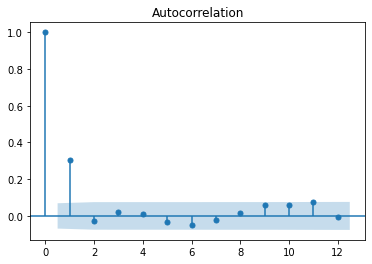

In [38]:
# Visualize our lags and confidence intervals
# 2 lags behind for the autoregressive part
plot_acf(month_diff, lags=12);

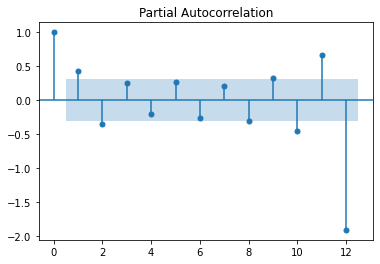

In [39]:
plot_pacf(pacf_month, lags=12);


From the acf and pacf we can determine that in the autocorrelation the first two values are outside of our confidence interval.


## ARIMA

Beginning with ARIMA we will compare other family models for demonstration purposes such as SARIMAX and then Auto-ARIMA.

From our correlation plots the ACF tells us most significant lags in respect to the number of months of the bond yield rate being low or experiencing the greatest change in variance.

In [15]:
# For an arima model we need to split our training and test data
train = month_diff.iloc[:len(month_diff)-12]
test = month_diff.iloc[len(month_diff)-12:]

Use acf and pacf values to determine parameters for the type of arima model we will use for our predictions. According to the lags we will use 0 as our (_AR_), 1 (_I_) for our inegration of differencing order, and 0 (_MA_) for our moving average. Thus we want to builda a (2, 1, 0) ARIMA model.

In [40]:
# Fit our model
from statsmodels.tsa.arima_model import ARIMA

# 0,1,0 ARIMA Model
model = ARIMA(month_diff, order=(2,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

TypeError: float() argument must be a string or a number, not 'ARIMA'

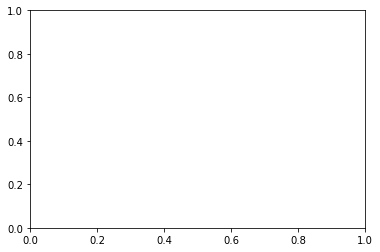

In [19]:
# Plot results
plt.plot(model, label='arima')
plt.plot(month['Rate'][:-2], label='actual')
plt.title('Single-step Forecasting')
plt.grid()
plt.xticks(rotation=90)
plt.legend()
plt.show()

### Section End

In [131]:
# Evaluate parameters
p_values = [0, 1, 2, 3, 9, 12]
d_values = range(0, 3)
q_values = [0, 1, 2, 3]

In [137]:
# Evaluate model using grid search
def evaluate_models(month, p_values, d_values, q_values):
    dataset = month_diff.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [134]:
# Fit our model
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [ ]:
evaluate_models(month_diff, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=0.092
ARIMA(0, 0, 1) RMSE=0.078
ARIMA(0, 0, 2) RMSE=0.076
ARIMA(0, 0, 3) RMSE=0.076
ARIMA(0, 1, 0) RMSE=0.147
ARIMA(0, 1, 1) RMSE=0.092
ARIMA(0, 1, 2) RMSE=0.078
ARIMA(0, 1, 3) RMSE=0.075
ARIMA(0, 2, 0) RMSE=0.255
ARIMA(0, 2, 1) RMSE=0.147
ARIMA(0, 2, 2) RMSE=0.093
ARIMA(0, 2, 3) RMSE=0.083
ARIMA(1, 0, 0) RMSE=0.089
ARIMA(1, 0, 1) RMSE=0.075
ARIMA(1, 0, 2) RMSE=0.076
ARIMA(1, 0, 3) RMSE=0.075
ARIMA(1, 1, 0) RMSE=0.127
ARIMA(1, 1, 1) RMSE=0.089
ARIMA(1, 1, 2) RMSE=0.093
ARIMA(1, 1, 3) RMSE=0.078
ARIMA(1, 2, 0) RMSE=0.195
ARIMA(1, 2, 1) RMSE=0.127
ARIMA(1, 2, 2) RMSE=0.098
ARIMA(1, 2, 3) RMSE=0.092
ARIMA(2, 0, 0) RMSE=0.084
ARIMA(2, 0, 1) RMSE=0.075
ARIMA(2, 0, 2) RMSE=0.075
ARIMA(2, 0, 3) RMSE=0.076
ARIMA(2, 1, 0) RMSE=0.112
ARIMA(2, 1, 1) RMSE=0.084


In [ ]:
# Prediction

In [ ]:
# Visualize plots


## Auto-ARIMA

In [ ]:
#pd.options.display.max_rows=None
#month['rolling_mean_diff'] = month['rolling_mean_diff'].dropna(inplace=False)
#month['rolling_mean_diff']

In [20]:
month_fit = auto_arima(month_diff,start_p=0, d=1, start_q=0, 
                          max_p=3, max_d=3, max_q=3, start_P=0, 
                          D=1, start_Q=0, max_P=3, max_D=3,
                          max_Q=3, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=42,n_fits = 50 )

#print(month_fit.summary().tables[1])
month_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-1629.645, Time=0.31 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-1887.273, Time=0.49 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.71 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-1678.964, Time=0.27 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-1972.154, Time=1.14 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=-2006.439, Time=2.39 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=12.15 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=4.74 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=-1959.435, Time=2.32 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=-2133.898, Time=4.04 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-2090.055, Time=1.89 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=14.74 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=5.62 sec
 ARIMA(3,1,0)(3,1,0)[12]             : AIC=-2160.943, Time=4.86 sec
 ARIMA(3,1,0)(2,1,0)[12]         

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  807
Model:             SARIMAX(3, 1, 1)x(3, 1, [], 12)   Log Likelihood                1161.354
Date:                             Sat, 06 Aug 2022   AIC                          -2306.707
Time:                                     00:39:24   BIC                          -2269.291
Sample:                                          0   HQIC                         -2292.329
                                             - 807                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3402      0.030     11.303      0.000       0.281       0.399
ar.L2         -0.1910      0.036     -5.234      0.000      -0.263      -0.119
ar.L3          0.0834      0.032      2.616      0.009       0.021       0.146
ma.L1         -0.9780      0.014    -70.120      0.000      -1.005      -0.951
ar.S.L12      -0.7622      0.029    -26.474      0.000      -0.819      -0.706
ar.S.L24      -0.5113      0.035    -14.715      0.000      -0.579      -0.443
ar.S.L36      -0.2894      0.029     -9.994      0.000      -0.346      -0.233
sigma2         0.0032   7.41e-05     43.164      0.000       0.003       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              4837.05
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               6.27   Skew:                            -1.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

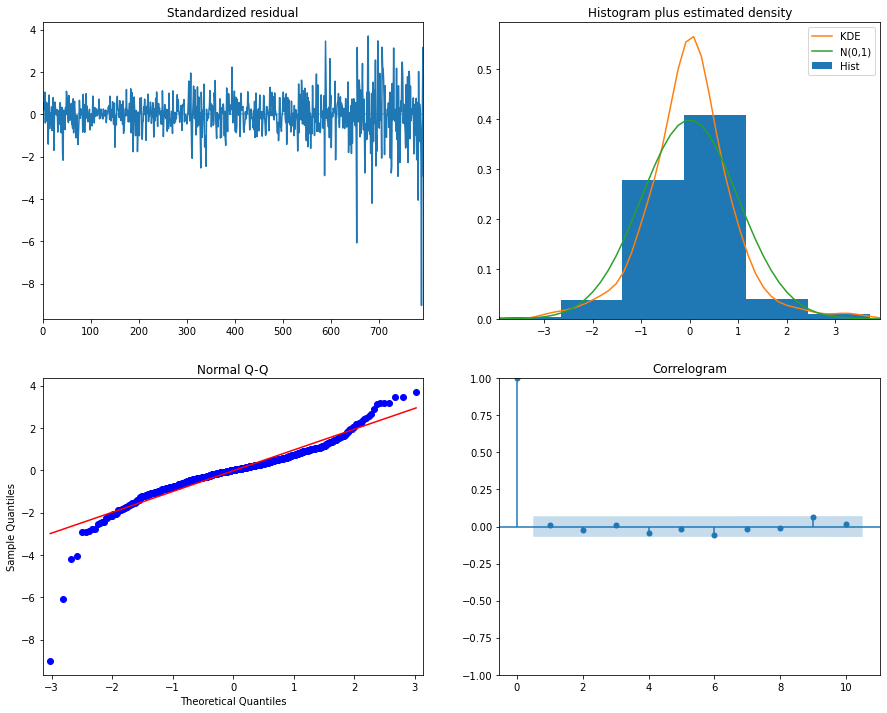

In [21]:
month_fit.plot_diagnostics(figsize=(15, 12))
plt.show();


## SARIMAX

Using the SARIMAX model we will incorporate two orders. The first-order is p,d,q and the other is P,D,Q,m to accountfor seasonality.

In [198]:
month['rolling_mean_diff'].plot(figsize=(15, 6))
plt.show()

KeyError: 'rolling_mean_diff'

In [59]:
train = month['rolling_mean_diff'].iloc[:len(month['rolling_mean_diff'])-12]
test = month['rolling_mean_diff'].iloc[len(month['rolling_mean_diff'])-12:]
test.index, train

(DatetimeIndex(['2019-08-31', '2019-09-30', '2019-10-31', '2019-11-30',
                '2019-12-31', '2020-01-31', '2020-02-29', '2020-03-31',
                '2020-04-30', '2020-05-31', '2020-06-30', '2020-07-31'],
               dtype='datetime64[ns]', name='Date', freq=None),
 Date
 1953-05-31    0.22
 1953-06-30    0.06
 1953-07-31   -0.18
 1953-08-31    0.02
 1953-09-30   -0.08
               ... 
 2019-03-31   -0.11
 2019-04-30   -0.04
 2019-05-31   -0.13
 2019-06-30   -0.33
 2019-07-31   -0.01
 Name: rolling_mean_diff, Length: 795, dtype: float64)

In [68]:
# Split data into train / test sets
train = month['Rate'].iloc[:len(month['Rate'])-12]
test = month['Rate'].iloc[len(month['Rate'])-12:] # set one year(12 months) for testing
  
from statsmodels.tsa.statespace.sarimax import SARIMAX
  
model = SARIMAX(train, 
                order = (2, 1, 1), 
                seasonal_order =(2, 1, 1, 12))
  
result = model.fit()
result.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.04432D-01    |proj g|=  1.08090D+00

At iterate    5    f=  1.46807D-01    |proj g|=  1.61972D-01

At iterate   10    f=  9.45784D-02    |proj g|=  2.49722D-01

At iterate   15    f=  5.31651D-02    |proj g|=  4.15466D-02

At iterate   20    f=  4.65236D-02    |proj g|=  4.43015D-03

At iterate   25    f=  4.59042D-02    |proj g|=  1.15511D-02

At iterate   30    f=  4.58638D-02    |proj g|=  6.97920D-04

At iterate   35    f=  4.58546D-02    |proj g|=  5.77267D-03

At iterate   40    f=  4.58476D-02    |proj g|=  9.13301D-04

At iterate   45    f=  4.58435D-02    |proj g|=  9.98557D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               Rate   No. Observations:                  795
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood                 -36.445
Date:                            Sat, 23 Jul 2022   AIC                             86.891
Time:                                    17:57:27   BIC                            119.524
Sample:                                05-31-1953   HQIC                            99.440
                                     - 07-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1124      0.069     -1.636      0.102      -0.247       0.022
ar.L2         -0.0594      0.036     -1.658      0.097      -0.130       0.011
ma.L1          0.5122      0.070      7.319      0.000       0.375       0.649
ar.S.L12      -0.0551      0.027     -2.049      0.040      -0.108      -0.002
ar.S.L24      -0.0203      0.036     -0.564      0.573      -0.091       0.050
ma.S.L12      -0.9966      0.167     -5.950      0.000      -1.325      -0.668
sigma2         0.0602      0.010      6.192      0.000       0.041       0.079
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1004.10
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.98   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [140]:
pred = result.get_prediction(start='2018-08-31', dynamic=False)
pred_ci = pred.conf_int()

KeyError: 'rolling_mean__diff'

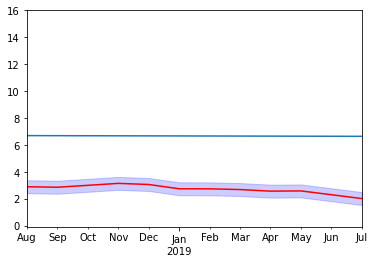

In [150]:
#pred = month['rolling_mean_diff'][750:-1]
pred.predicted_mean.plot(color='red', label='Predicted')
plt.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], 
                 color='blue', alpha=.2)

plt.plot(month['Rate'], label='Rate')
plt.plot(month['rolling_mean__diff'], label='First-order difference', color='orange')
plt.plot(test, label='Actual', alpha=0.7)
plt.title('SARIMA Model')
plt.legend()
plt.show()
;

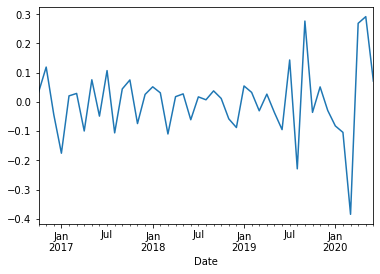

In [129]:
# Rises every 6 months (seasonal)
month['rolling_log_diff'][750:-1].plot();

In [130]:
start = len(train)
end = len(train) + len(test) - 1
  
# Predictions for one-year against the test set
predictions = result.predict(start, end,
                             typ = 'levels').rename("Predictions")
  
# plot predictions and actual values
predictions.plot(legend = True);
test.plot(legend = True);

AttributeError: 'tuple' object has no attribute 'predict'

In [120]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

rmse(test, predictions)
mean_squared_error(test, predictions)

NameError: name 'predictions' is not defined

In [ ]:
# Train the model on the full dataset
model = model = SARIMAX(month_diff, 
                        order = (2, 1, 0), 
                        seasonal_order =(1, 1, 0, 12))
result = model.fit()
  
# Forecast for the next 3 years
forecast = result.predict(start = len(month_diff), 
                          end = (len(month_diff)-1) + 3 * 3
                          , 
                          typ = 'levels').rename('Forecast')
  
# Plot the forecast values
month_diff.plot(figsize = (12, 5), legend = True)
forecast.plot(legend = True);



### Alternate version


In [ ]:
mod = sm.tsa.statespace.SARIMAX(month['Rate'], order=(2,1,0), seasonal_order=(1,1,0,12), simple_differencing=True)
res = mod.fit(disp=False)
print(res.summary())

In [ ]:
# In-sample one-step-ahead predictions
predict = res.get_prediction()
predict_ci = predict.conf_int()
predict_ci

Clearly we see that the model is not predicting well according to our predictions. However, an attempt will be made to determine if parameter tuning would extend the results that we desire.